In [42]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from scipy.stats import t
from scipy.stats import uniform
from scipy.stats import ttest_1samp # library for p-value estimation
import ruptures as rpt # library for change point detection
%matplotlib inline
%run ./master_experminet-functions.ipynb
# load functions for the creation of the different distributions

In [43]:
# define arms
def quick_sort(df):
    sorted_df = df.sort_values(kind="quicksort")
    return sorted_df
def merge_sort(df):
    sorted_df = df.sort_values(kind="mergesort")
    return sorted_df
def heap_sort(df):
    sorted_df = df.sort_values(kind="heapsort")
    return sorted_df

In [44]:
n_samples = 100000
choices = [quick_sort,merge_sort,heap_sort]
choices_names = ["quick_sort","merge_sort","heap_sort"]
dist_types = ["Uniform","Normal","Uniform_Sorted","Uniform_Reverse_Sorted","Uniform_Nearly_Sorted","Zipf"]

In [45]:
#list_distributions = 1000*["Uniform_Sorted"] + 1000*["Normal"] # at first quick sort -> then merge sort 
list_distributions = 500*["Uniform"] + 500*["Uniform_Reverse_Sorted"]+ 500*["Uniform"] + 500*["Uniform_Reverse_Sorted"]
#list_distributions = 100*["Uniform"] +  100*["Uniform_Sorted"] + 100*["Normal"] + 100*["Uniform_Reverse_Sorted"]

In [46]:
def plot_history(rewards,cum_rewards,sample_count, sample_mean):

    q_values = {"quick_sort": sample_mean[0], "merge_sort": sample_mean[1], "heap_sort":sample_mean[2]} ## 
    arm_counts = {"quick_sort": sample_count[0], "merge_sort": sample_count[1], "heap_sort":sample_count[2]} ##
    print("Average rewards per algo", q_values)
    print("Count per chosen algo", arm_counts)
    
    fig = plt.figure(figsize=[30,8])
    ax2 = fig.add_subplot(121)
    ax2.plot(cum_rewards, label="avg rewards")
    ax2.set_title("Cummulative Rewards")
    labels = list(arm_counts.keys())
    ax3 = fig.add_subplot(122)
    ax3.bar([i for i in range(len(arm_counts.values()))], arm_counts.values(), label=[i for i in ((list(arm_counts.keys())))])
    ax3.set_title("Chosen Actions")
    plt.show() 

In [47]:
# help function to return the humber of consecutive elements in a list 
def count_consec(listrand):
    count=1
    consec_list=[]
    for i in range(len(listrand[:-1])):
        if listrand[i]+1 == listrand[i+1]:
            count+=1
        else:
            consec_list.append(count)
            count=1

    # Account for the last iteration
    consec_list.append(count)     

    return consec_list

In [48]:
def TS_stationary(list_distributions, n_samples, var_multiplier = 5): # initialize
    total_reward = 0
    num_choices = len(choices)
    sample_count = [0 for i in range(num_choices)]
    sample_rewards = [0 for i in range(num_choices)]
    sample_mean = [0.0 for i in range(num_choices)]
    sample_var = [0.0 for i in range(num_choices)]
    arm_rewards = {0: [], 1:[], 2:[]}
    rewards = []
    cum_rewards = []
    var_multiplier = 5
    list_iteration_results = []

    len_result = 1

    for n, elem in enumerate(list_distributions):
        dist_type = elem
        distribion = create_df_distribution(n_samples=n_samples, dist_type=dist_type)
        print("\n")
        print("Iteration:", n)
        theta = {}
        for i in range(len(choices)):
            if sample_count[i] >= 2:
                theta[i] = t.rvs(df=sample_count[i]-1,loc=sample_mean[i],scale=np.sqrt(sample_var[i]/sample_count[i])*var_multiplier)
                print(choices_names[i],"Theta", theta[i])

            else:
                print("Less than two values for",choices_names[i])
                theta[i] = uniform.rvs(loc=0, scale=1)
                print(choices_names[i],"Theta", theta[i])

        choice = np.argmin([theta[i] for i in range(len(choices))])
        alg = choices[choice]
        alg_name = choices_names[choice]
        start_time = time.perf_counter() #time.time()
        sorted_dist = alg(distribion[dist_type])
        reward = ((time.perf_counter() - start_time))*(1)
        print("\n")
        print("Chosen algorithm is: ", alg_name, "with reward:", reward)
        arm_rewards[choice].append(reward)
        sample_count[choice] += 1
        sample_rewards[choice] += reward
        sample_mean[choice] = np.mean(arm_rewards[choice])
        sample_var[choice] = np.var(arm_rewards[choice]).astype('float64')
        print("Sample mean is: ", sample_mean[choice], "Sample variance is:", sample_var[choice])
        total_reward += reward
        rewards.append(reward)
        cum_rewards.append(sum(rewards)/len(rewards))
        array_rewards = np.array(rewards)

    list_iteration_results.extend([sample_mean, sample_count,rewards,cum_rewards,n])
    return list_iteration_results, total_reward

In [49]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [50]:
def plot_rewards_distribution(arm_rewards, bins = 20):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 3))
    axes[0].hist(arm_rewards[0], bins, alpha = 0.5, label='quick sort')
    axes[0].set_title("rewards distribution for quick sort")
    axes[1].hist(arm_rewards[1], bins, alpha = 0.5, label='merge sort')
    axes[1].set_title("rewards distribution for merge sort")
    axes[2].hist(arm_rewards[2], bins, alpha = 0.5, label='heap sort')
    axes[2].set_title("rewards distribution for heap sort")
    plt.show()

In [51]:
def plot_rewards_distribution_together(arm_rewards, bins = 20):
    plt.hist(arm_rewards[0], bins, alpha = 0.5, label='quick sort')
    plt.hist(arm_rewards[1], bins, alpha = 0.5, label='merge sort')
    plt.hist(arm_rewards[2], bins, alpha = 0.5, label='heap sort')
    plt.legend(loc='upper right')
    plt.show()

In [52]:
import bayesian_changepoint_detection.online_changepoint_detection as oncd
from functools import partial
import matplotlib.cm as cm

## Thompson Sampling

In [73]:
def ts_quantile(list_distributions, n_samples, var_multiplier = 1, num_consec_elem=1):
    total_reward = 0
    num_choices = len(choices)
    sample_count = [0 for i in range(num_choices)]
    sample_rewards = [0 for i in range(num_choices)]
    sample_mean = [0.0 for i in range(num_choices)]
    sample_var = [0.0 for i in range(num_choices)]
    arm_rewards = {0: [], 1:[], 2:[]}
    arm_rewards_temp = {0: [], 1:[], 2:[]}
    rewards = []
    cum_rewards = []
    var_multiplier = var_multiplier
    n_consecutive_list = [] # this list is to check whether
    list_iteration_results = []
    num_consec_elem = num_consec_elem

    for n, elem in enumerate(list_distributions):
        dist_type = elem
        distribion = create_df_distribution(n_samples=n_samples, dist_type=dist_type)
        print("\n")
        print("Iteration:", n)
        theta = {}
        for i in range(len(choices)):
            if sample_count[i] >= 2:
                theta[i] = t.rvs(df=sample_count[i]-1,loc=sample_mean[i],scale=np.sqrt(sample_var[i]/sample_count[i])*var_multiplier)
                print(choices_names[i],"Theta", theta[i])

            else:
                print("Less than two values for",choices_names[i])
                theta[i] = uniform.rvs(loc=0, scale=0.1)
                print(choices_names[i],"Theta", theta[i])

        choice = np.argmin([theta[i] for i in range(len(choices))])
        alg = choices[choice]
        alg_name = choices_names[choice]
        start_time = time.perf_counter()
        sorted_dist = alg(distribion[dist_type])
        reward = ((time.perf_counter() - start_time))*(1)
        print("\n")
        print("Chosen algorithm is: ", alg_name, "with reward:", reward)
        arm_rewards[choice].append(reward)
        arm_rewards_temp[choice].append(reward)
        sample_count[choice] += 1
        sample_rewards[choice] += reward
        sample_mean[choice] = np.mean(arm_rewards_temp[choice])
        sample_var[choice] = np.var(arm_rewards_temp[choice]).astype('float64')
        print("Sample mean is: ", sample_mean[choice], "Sample variance is:", sample_var[choice])
        total_reward += reward
        rewards.append(reward)
        cum_rewards.append(sum(rewards)/len(rewards))
        if len(arm_rewards_temp[choice])>10:
            if reward < np.quantile(arm_rewards_temp[choice][:-1], 0.025) or reward > np.quantile(arm_rewards_temp[choice][:-1], 0.975):
                n_consecutive_list.append(n)
                if any(i >= num_consec_elem for i in count_consec(n_consecutive_list)):
                    print("RESTART EXPERIMENT")
                    list_iteration_results.append([sample_mean, sample_count,rewards,cum_rewards,n])
                    sample_count = [0 for i in range(num_choices)]
                    sample_rewards = [0 for i in range(num_choices)]
                    sample_mean = [0.0 for i in range(num_choices)]
                    sample_var = [0.0 for i in range(num_choices)]
                    arm_rewards_temp = {0: [], 1:[], 2:[]}
                    rewards = []
                    cum_rewards = []
                    n_consecutive_list = []
    list_iteration_results.append([sample_mean, sample_count,rewards,cum_rewards,n])
    return list_iteration_results, total_reward, arm_rewards

## Single outlier restarts the expriment

In [74]:
list_iteration_results_1, total_reward_1, arm_rewards_1 = ts_quantile(list_distributions, n_samples)



Iteration: 0
Less than two values for quick_sort
quick_sort Theta 0.048767954256562995
Less than two values for merge_sort
merge_sort Theta 0.04850504524416464
Less than two values for heap_sort
heap_sort Theta 0.0032519591355470445


Chosen algorithm is:  heap_sort with reward: 0.024078599999938888
Sample mean is:  0.024078599999938888 Sample variance is: 0.0


Iteration: 1
Less than two values for quick_sort
quick_sort Theta 0.07638343324837413
Less than two values for merge_sort
merge_sort Theta 0.08256625767940717
Less than two values for heap_sort
heap_sort Theta 0.0485880319641033


Chosen algorithm is:  heap_sort with reward: 0.02575869999986935
Sample mean is:  0.02491864999990412 Sample variance is: 7.056840024415848e-07


Iteration: 2
Less than two values for quick_sort
quick_sort Theta 0.06417949104418373
Less than two values for merge_sort
merge_sort Theta 0.05599783672451795
heap_sort Theta 0.02480517931693276


Chosen algorithm is:  heap_sort with reward: 0.024458500000

Chosen algorithm is:  merge_sort with reward: 0.01584699999989425
Sample mean is:  0.016646196000019698 Sample variance is: 1.3610406195097027e-06


Iteration: 30
Less than two values for quick_sort
quick_sort Theta 0.06414714935957169
merge_sort Theta 0.016588133252772152
heap_sort Theta 0.024797047775668803


Chosen algorithm is:  merge_sort with reward: 0.01710129999992205
Sample mean is:  0.016663700000015942 Sample variance is: 1.316352653771427e-06


Iteration: 31
Less than two values for quick_sort
quick_sort Theta 0.03554826613591573
merge_sort Theta 0.016597677148090614
heap_sort Theta 0.02498729656986973


Chosen algorithm is:  merge_sort with reward: 0.017488100000036866
Sample mean is:  0.01669423333335005 Sample variance is: 1.2918382473366784e-06


Iteration: 32
Less than two values for quick_sort
quick_sort Theta 0.012229104130954094
merge_sort Theta 0.01698875180505992
heap_sort Theta 0.02561281113739312


Chosen algorithm is:  quick_sort with reward: 0.0147790999999415



Chosen algorithm is:  quick_sort with reward: 0.01532479999991665
Sample mean is:  0.01525823333330815 Sample variance is: 7.395604220497513e-08


Iteration: 58
quick_sort Theta 0.01527625666435538
merge_sort Theta 0.0167888577007698
heap_sort Theta 0.024768209069692196


Chosen algorithm is:  quick_sort with reward: 0.015453600000000733
Sample mean is:  0.015286142857121376 Sample variance is: 6.806454243543633e-08


Iteration: 59
quick_sort Theta 0.015437454669560494
merge_sort Theta 0.016626186998592068
heap_sort Theta 0.02310630198187075


Chosen algorithm is:  quick_sort with reward: 0.014971800000012081
Sample mean is:  0.015246849999982715 Sample variance is: 7.036397498584187e-08


Iteration: 60
quick_sort Theta 0.015264237448407244
merge_sort Theta 0.016674324105768194
heap_sort Theta 0.024005738473761605


Chosen algorithm is:  quick_sort with reward: 0.014452099999971324
Sample mean is:  0.015158544444425893 Sample variance is: 1.249287246805612e-07


Iteration: 61
quick_s

merge_sort Theta 0.04876444254958964
Less than two values for heap_sort
heap_sort Theta 0.04895306457883436


Chosen algorithm is:  merge_sort with reward: 0.018547099999977945
Sample mean is:  0.018547099999977945 Sample variance is: 0.0


Iteration: 87
Less than two values for quick_sort
quick_sort Theta 6.536937412126021e-05
Less than two values for merge_sort
merge_sort Theta 0.052263508801707576
Less than two values for heap_sort
heap_sort Theta 0.030146623068892233


Chosen algorithm is:  quick_sort with reward: 0.014729200000147102
Sample mean is:  0.014729200000147102 Sample variance is: 0.0


Iteration: 88
Less than two values for quick_sort
quick_sort Theta 0.059505910912785454
Less than two values for merge_sort
merge_sort Theta 0.0675134248089878
Less than two values for heap_sort
heap_sort Theta 0.045975101548363644


Chosen algorithm is:  heap_sort with reward: 0.02438180000012835
Sample mean is:  0.02438180000012835 Sample variance is: 0.0


Iteration: 89
Less than two v



Iteration: 114
quick_sort Theta 0.01511770783309021
merge_sort Theta 0.01599973194877244
heap_sort Theta 0.023480036865195352


Chosen algorithm is:  quick_sort with reward: 0.0160529999998289
Sample mean is:  0.01511575454545974 Sample variance is: 4.440634115697034e-07
RESTART EXPERIMENT


Iteration: 115
Less than two values for quick_sort
quick_sort Theta 0.01369516643532861
Less than two values for merge_sort
merge_sort Theta 0.0639904312368526
Less than two values for heap_sort
heap_sort Theta 0.06549746304677156


Chosen algorithm is:  quick_sort with reward: 0.014107400000057169
Sample mean is:  0.014107400000057169 Sample variance is: 0.0


Iteration: 116
Less than two values for quick_sort
quick_sort Theta 0.09321958721027973
Less than two values for merge_sort
merge_sort Theta 0.009330017657830902
Less than two values for heap_sort
heap_sort Theta 0.09535943477158587


Chosen algorithm is:  merge_sort with reward: 0.01692660000003343
Sample mean is:  0.01692660000003343 Sam

merge_sort Theta 0.01688703698068134
heap_sort Theta 0.02332054787965084


Chosen algorithm is:  merge_sort with reward: 0.017830000000003565
Sample mean is:  0.01705903749996196 Sample variance is: 4.053229573340337e-07


Iteration: 143
Less than two values for quick_sort
quick_sort Theta 0.04365493239805666
merge_sort Theta 0.017232505358766293
heap_sort Theta 0.023360017162240503


Chosen algorithm is:  merge_sort with reward: 0.01684660000000804
Sample mean is:  0.017035433333300414 Sample variance is: 3.647443266560964e-07


Iteration: 144
Less than two values for quick_sort
quick_sort Theta 0.037458647044126436
merge_sort Theta 0.017116449431006566
heap_sort Theta 0.024062775315388


Chosen algorithm is:  merge_sort with reward: 0.01667999999995118
Sample mean is:  0.01699988999996549 Sample variance is: 3.39639850891504e-07


Iteration: 145
Less than two values for quick_sort
quick_sort Theta 0.007611143118356723
merge_sort Theta 0.016921579663740756
heap_sort Theta 0.0046110268



Iteration: 170
Less than two values for quick_sort
quick_sort Theta 0.04693445150663912
merge_sort Theta 0.015954405907154905
Less than two values for heap_sort
heap_sort Theta 0.06838918493924488


Chosen algorithm is:  merge_sort with reward: 0.016899799999919196
Sample mean is:  0.016129279999950084 Sample variance is: 4.5927024951257247e-07


Iteration: 171
Less than two values for quick_sort
quick_sort Theta 0.006294884107987742
merge_sort Theta 0.015553516525465714
Less than two values for heap_sort
heap_sort Theta 0.09830132036639341


Chosen algorithm is:  quick_sort with reward: 0.015264800000068135
Sample mean is:  0.014431850000050872 Sample variance is: 6.938057025287584e-07


Iteration: 172
quick_sort Theta 0.014528855840259397
merge_sort Theta 0.015624695693055766
Less than two values for heap_sort
heap_sort Theta 0.027160743750753804


Chosen algorithm is:  quick_sort with reward: 0.014995900000030815
Sample mean is:  0.014619866666710854 Sample variance is: 5.33237668



Iteration: 198
quick_sort Theta 0.014759257755160694
merge_sort Theta 0.017105870658794268
Less than two values for heap_sort
heap_sort Theta 0.062272975782875134


Chosen algorithm is:  quick_sort with reward: 0.014966199999889795
Sample mean is:  0.015028808333340749 Sample variance is: 1.144257295804237e-06


Iteration: 199
quick_sort Theta 0.015316237694708619
merge_sort Theta 0.01651594287161183
Less than two values for heap_sort
heap_sort Theta 0.08592120615671206


Chosen algorithm is:  quick_sort with reward: 0.014401399999997011
Sample mean is:  0.014980546153852768 Sample variance is: 1.0841883594464553e-06


Iteration: 200
quick_sort Theta 0.015170950797332798
merge_sort Theta 0.01666838288100953
Less than two values for heap_sort
heap_sort Theta 0.03792032018187489


Chosen algorithm is:  quick_sort with reward: 0.015460000000075524
Sample mean is:  0.015014792857154393 Sample variance is: 1.021993210703093e-06


Iteration: 201
quick_sort Theta 0.014999941868886103
merge_



Chosen algorithm is:  merge_sort with reward: 0.018875700000080542
Sample mean is:  0.016826080000009826 Sample variance is: 1.7162801936766133e-06


Iteration: 226
Less than two values for quick_sort
quick_sort Theta 0.07644126636907306
merge_sort Theta 0.017067439605717778
Less than two values for heap_sort
heap_sort Theta 0.07548301603066389


Chosen algorithm is:  merge_sort with reward: 0.016903199999887875
Sample mean is:  0.01683893333332283 Sample variance is: 1.4310595356167876e-06


Iteration: 227
Less than two values for quick_sort
quick_sort Theta 0.07320955169039355
merge_sort Theta 0.015718796259526463
Less than two values for heap_sort
heap_sort Theta 0.0527224988485494


Chosen algorithm is:  merge_sort with reward: 0.015299700000014127
Sample mean is:  0.016619042857135873 Sample variance is: 1.5167333882064662e-06


Iteration: 228
Less than two values for quick_sort
quick_sort Theta 0.05912794288123029
merge_sort Theta 0.016763848826363156
Less than two values for h



Chosen algorithm is:  quick_sort with reward: 0.016625199999907636
Sample mean is:  0.014500308333291892 Sample variance is: 5.845894673698081e-07
RESTART EXPERIMENT


Iteration: 255
Less than two values for quick_sort
quick_sort Theta 0.08445024531119366
Less than two values for merge_sort
merge_sort Theta 0.00043677760669678104
Less than two values for heap_sort
heap_sort Theta 0.09508371932209322


Chosen algorithm is:  merge_sort with reward: 0.017146200000070166
Sample mean is:  0.017146200000070166 Sample variance is: 0.0


Iteration: 256
Less than two values for quick_sort
quick_sort Theta 0.054096176987681904
Less than two values for merge_sort
merge_sort Theta 0.04039287340368822
Less than two values for heap_sort
heap_sort Theta 0.055217700224013636


Chosen algorithm is:  merge_sort with reward: 0.016084600000112914
Sample mean is:  0.01661540000009154 Sample variance is: 2.817486399773095e-07


Iteration: 257
Less than two values for quick_sort
quick_sort Theta 0.00605126



Iteration: 284
Less than two values for quick_sort
quick_sort Theta 0.04453182376432804
merge_sort Theta 0.0160172838929431
Less than two values for heap_sort
heap_sort Theta 0.01726329753986333


Chosen algorithm is:  merge_sort with reward: 0.017474300000003495
Sample mean is:  0.016482049999960207 Sample variance is: 5.993152392155327e-07


Iteration: 285
Less than two values for quick_sort
quick_sort Theta 0.06845124300186105
merge_sort Theta 0.01716651973577895
Less than two values for heap_sort
heap_sort Theta 0.04335053268583025


Chosen algorithm is:  merge_sort with reward: 0.016519100000095932
Sample mean is:  0.01648734285712245 Sample variance is: 5.138668624920962e-07


Iteration: 286
Less than two values for quick_sort
quick_sort Theta 0.06715050225545036
merge_sort Theta 0.016625598880133704
Less than two values for heap_sort
heap_sort Theta 0.04182481158058744


Chosen algorithm is:  merge_sort with reward: 0.01715250000006563
Sample mean is:  0.01657048749999035 Samp



Chosen algorithm is:  quick_sort with reward: 0.01621819999991203
Sample mean is:  0.014584255555519121 Sample variance is: 5.594076046512112e-07


Iteration: 312
quick_sort Theta 0.014535760553471826
merge_sort Theta 0.017600657238229362
heap_sort Theta 0.025298320771317835


Chosen algorithm is:  quick_sort with reward: 0.015225299999883646
Sample mean is:  0.014648359999955573 Sample variance is: 5.404512623546461e-07


Iteration: 313
quick_sort Theta 0.014557172468522582
merge_sort Theta 0.014700650144678199
heap_sort Theta 0.025979960304339033


Chosen algorithm is:  quick_sort with reward: 0.013972599999988233
Sample mean is:  0.014586927272685816 Sample variance is: 5.290591292113195e-07


Iteration: 314
quick_sort Theta 0.014486527209731273
merge_sort Theta 0.017415205836589048
heap_sort Theta 0.025591352195106845


Chosen algorithm is:  quick_sort with reward: 0.01482239999995727
Sample mean is:  0.014606549999958437 Sample variance is: 4.89206434125482e-07


Iteration: 315




Iteration: 340
quick_sort Theta 0.014590018058742896
merge_sort Theta 0.01598583949052778
Less than two values for heap_sort
heap_sort Theta 0.07712432262218016


Chosen algorithm is:  quick_sort with reward: 0.015259100000093895
Sample mean is:  0.01450921666666242 Sample variance is: 3.748685047265405e-07


Iteration: 341
quick_sort Theta 0.014308441931838806
merge_sort Theta 0.016134561888116683
Less than two values for heap_sort
heap_sort Theta 0.08853589828350382


Chosen algorithm is:  quick_sort with reward: 0.014671800000087387
Sample mean is:  0.014532442857151702 Sample variance is: 3.245525967420438e-07


Iteration: 342
quick_sort Theta 0.014564464161341007
merge_sort Theta 0.016088835484068257
Less than two values for heap_sort
heap_sort Theta 0.09783844567160485


Chosen algorithm is:  quick_sort with reward: 0.014839299999948707
Sample mean is:  0.014570800000001327 Sample variance is: 2.942824150023945e-07


Iteration: 343
quick_sort Theta 0.014488389319159772
merge_so



Iteration: 367
quick_sort Theta 0.014744860486068552
merge_sort Theta 0.016834459339591823
heap_sort Theta 0.02353496658001558


Chosen algorithm is:  quick_sort with reward: 0.013988700000027166
Sample mean is:  0.014562215384645381 Sample variance is: 4.95964279783472e-07


Iteration: 368
quick_sort Theta 0.01461413703256405
merge_sort Theta 0.016672693849502297
heap_sort Theta 0.023997017496572653


Chosen algorithm is:  quick_sort with reward: 0.014975300000060088
Sample mean is:  0.014591721428603575 Sample variance is: 4.7185614598975534e-07


Iteration: 369
quick_sort Theta 0.0144516891757542
merge_sort Theta 0.01656308525745872
heap_sort Theta 0.023944592676971313


Chosen algorithm is:  quick_sort with reward: 0.014644200000020646
Sample mean is:  0.01459522000003138 Sample variance is: 4.4057042961893455e-07


Iteration: 370
quick_sort Theta 0.014652361051668844
merge_sort Theta 0.016769965668968035
heap_sort Theta 0.02385491708597097


Chosen algorithm is:  quick_sort with


Chosen algorithm is:  quick_sort with reward: 0.01405720000002475
Sample mean is:  0.014481000000046151 Sample variance is: 1.796064400181399e-07


Iteration: 396
quick_sort Theta 0.012605925269458845
Less than two values for merge_sort
merge_sort Theta 0.08145374745788095
Less than two values for heap_sort
heap_sort Theta 0.026516248717200788


Chosen algorithm is:  quick_sort with reward: 0.014428299999963201
Sample mean is:  0.014463433333351835 Sample variance is: 1.203548022362584e-07


Iteration: 397
quick_sort Theta 0.014568129867236919
Less than two values for merge_sort
merge_sort Theta 0.02221864375844859
Less than two values for heap_sort
heap_sort Theta 0.05473214449798878


Chosen algorithm is:  quick_sort with reward: 0.014407699999992474
Sample mean is:  0.014449500000011994 Sample variance is: 9.08485150110711e-08


Iteration: 398
quick_sort Theta 0.01455444651397711
Less than two values for merge_sort
merge_sort Theta 0.011097265252752342
Less than two values for heap


Iteration: 422
Less than two values for quick_sort
quick_sort Theta 0.09285577171318306
Less than two values for merge_sort
merge_sort Theta 0.005217036520247809
heap_sort Theta 0.024266588787700227


Chosen algorithm is:  merge_sort with reward: 0.017843399999946996
Sample mean is:  0.017008400000008805 Sample variance is: 6.972249998967786e-07


Iteration: 423
Less than two values for quick_sort
quick_sort Theta 0.02435428581918736
merge_sort Theta 0.01670946936960329
heap_sort Theta 0.02085489454549955


Chosen algorithm is:  merge_sort with reward: 0.015906600000107574
Sample mean is:  0.016641133333375063 Sample variance is: 7.345862754383756e-07


Iteration: 424
Less than two values for quick_sort
quick_sort Theta 0.08218857114575019
merge_sort Theta 0.016664737687842726
heap_sort Theta 0.02430701389100697


Chosen algorithm is:  merge_sort with reward: 0.01638330000014321
Sample mean is:  0.016576675000067098 Sample variance is: 5.634043367773031e-07


Iteration: 425
Less than 

Sample mean is:  0.01621819999991203 Sample variance is: 3.3590415501669504e-07


Iteration: 450
Less than two values for quick_sort
quick_sort Theta 0.0892020752901845
merge_sort Theta 0.016113256781597106
heap_sort Theta 0.02338520298000481


Chosen algorithm is:  merge_sort with reward: 0.0169581999998627
Sample mean is:  0.016366199999902166 Sample variance is: 3.563393240016745e-07


Iteration: 451
Less than two values for quick_sort
quick_sort Theta 0.07633641862490252
merge_sort Theta 0.016402077717093008
heap_sort Theta 0.023303598933791216


Chosen algorithm is:  merge_sort with reward: 0.015882599999940794
Sample mean is:  0.0162855999999086 Sample variance is: 3.294312366628728e-07


Iteration: 452
Less than two values for quick_sort
quick_sort Theta 0.050190141098482834
merge_sort Theta 0.01644067285419948
heap_sort Theta 0.023919601431615967


Chosen algorithm is:  merge_sort with reward: 0.01633969999988949
Sample mean is:  0.016293328571334444 Sample variance is: 2.82728



Iteration: 477
quick_sort Theta 0.014075457366583706
merge_sort Theta 0.016727366219840563
heap_sort Theta 0.02256322979143722


Chosen algorithm is:  quick_sort with reward: 0.014102600000114762
Sample mean is:  0.014233737500006782 Sample variance is: 8.888911485243669e-08


Iteration: 478
quick_sort Theta 0.01411241041741874
merge_sort Theta 0.016370434440479135
heap_sort Theta 0.02407209965197687


Chosen algorithm is:  quick_sort with reward: 0.015402200000153243
Sample mean is:  0.014363566666689722 Sample variance is: 2.1385744670819245e-07


Iteration: 479
quick_sort Theta 0.01419551940186258
merge_sort Theta 0.015970583987412926
heap_sort Theta 0.023754894638337704


Chosen algorithm is:  quick_sort with reward: 0.013259800000014366
Sample mean is:  0.014253190000022186 Sample variance is: 3.0211877893909973e-07


Iteration: 480
quick_sort Theta 0.014224983922527757
merge_sort Theta 0.01631829513651288
heap_sort Theta 0.0216256265780735


Chosen algorithm is:  quick_sort wit



Chosen algorithm is:  quick_sort with reward: 0.008828100000073391
Sample mean is:  0.012550654545479616 Sample variance is: 1.4323039007962924e-05


Iteration: 506
quick_sort Theta 0.011725226392291304
merge_sort Theta 0.012150074440310701
heap_sort Theta 0.024103334507285485


Chosen algorithm is:  quick_sort with reward: 0.013672999999926105
Sample mean is:  0.012644183333350156 Sample variance is: 1.322567639973187e-05


Iteration: 507
quick_sort Theta 0.011956758953202196
merge_sort Theta 0.002320912441008985
heap_sort Theta 0.02399004963788418


Chosen algorithm is:  merge_sort with reward: 0.006013199999870267
Sample mean is:  0.007666274999962752 Sample variance is: 2.5038304897074317e-05


Iteration: 508
quick_sort Theta 0.012646362169138134
merge_sort Theta 0.008554385482499993
heap_sort Theta 0.02397102531729472


Chosen algorithm is:  merge_sort with reward: 0.004599499999812906
Sample mean is:  0.007052919999932783 Sample variance is: 2.1535461341906503e-05


Iteration: 



Chosen algorithm is:  quick_sort with reward: 0.00999809999984791
Sample mean is:  0.0072505272727002275 Sample variance is: 1.4703006546416488e-06
RESTART EXPERIMENT


Iteration: 533
Less than two values for quick_sort
quick_sort Theta 0.07045894280759034
Less than two values for merge_sort
merge_sort Theta 0.03878094977028789
Less than two values for heap_sort
heap_sort Theta 0.041321734133316024


Chosen algorithm is:  merge_sort with reward: 0.00507459999994353
Sample mean is:  0.00507459999994353 Sample variance is: 0.0


Iteration: 534
Less than two values for quick_sort
quick_sort Theta 0.07079231181465004
Less than two values for merge_sort
merge_sort Theta 0.011724187405145015
Less than two values for heap_sort
heap_sort Theta 0.02520894551763675


Chosen algorithm is:  merge_sort with reward: 0.0061946000000716595
Sample mean is:  0.005634600000007595 Sample variance is: 3.136000000717526e-07


Iteration: 535
Less than two values for quick_sort
quick_sort Theta 0.0188853527



Chosen algorithm is:  quick_sort with reward: 0.007951399999910791
Sample mean is:  0.006946949999985463 Sample variance is: 3.3713233244848117e-07


Iteration: 562
quick_sort Theta 0.011273420005102376
Less than two values for merge_sort
merge_sort Theta 0.06280254749661267
heap_sort Theta 0.012921995425210322


Chosen algorithm is:  quick_sort with reward: 0.006146799999896757
Sample mean is:  0.006786919999967722 Sample variance is: 3.7214426958149794e-07


Iteration: 563
quick_sort Theta 0.006601836849812242
Less than two values for merge_sort
merge_sort Theta 0.058055650910042646
heap_sort Theta 0.012994427529783624


Chosen algorithm is:  quick_sort with reward: 0.007462199999963559
Sample mean is:  0.006899466666633695 Sample variance is: 3.734539855393563e-07


Iteration: 564
quick_sort Theta 0.006969291860141567
Less than two values for merge_sort
merge_sort Theta 0.007669158321063463
heap_sort Theta 0.012862861985015106


Chosen algorithm is:  quick_sort with reward: 0.0063



Chosen algorithm is:  merge_sort with reward: 0.006042500000148721
Sample mean is:  0.005756650000080299 Sample variance is: 8.171022253911665e-08


Iteration: 590
Less than two values for quick_sort
quick_sort Theta 0.03251930447694269
merge_sort Theta 0.0055816779263072585
heap_sort Theta 0.013489176620540775


Chosen algorithm is:  merge_sort with reward: 0.005736300000080519
Sample mean is:  0.005749866666747039 Sample variance is: 5.4565508914964674e-08


Iteration: 591
Less than two values for quick_sort
quick_sort Theta 0.058545001556765175
merge_sort Theta 0.006150726766180621
heap_sort Theta 0.012827717990573601


Chosen algorithm is:  merge_sort with reward: 0.004779599999892525
Sample mean is:  0.0055073000000334105 Sample variance is: 2.1743989508790488e-07


Iteration: 592
Less than two values for quick_sort
quick_sort Theta 0.023381515870529026
merge_sort Theta 0.005593722088126711
heap_sort Theta 0.013360438860460925


Chosen algorithm is:  merge_sort with reward: 0.00


Chosen algorithm is:  heap_sort with reward: 0.012537600000086968
Sample mean is:  0.012957536363666639 Sample variance is: 5.747030368661077e-07


Iteration: 618
Less than two values for quick_sort
quick_sort Theta 0.04497569484289332
Less than two values for merge_sort
merge_sort Theta 0.026879351102858662
heap_sort Theta 0.012812786848073044


Chosen algorithm is:  heap_sort with reward: 0.012308200000006764
Sample mean is:  0.012903425000028316 Sample variance is: 5.590195535500525e-07


Iteration: 619
Less than two values for quick_sort
quick_sort Theta 0.04023922123254168
Less than two values for merge_sort
merge_sort Theta 0.09879997798310675
heap_sort Theta 0.013740526687980375


Chosen algorithm is:  heap_sort with reward: 0.013153600000123333
Sample mean is:  0.012922669230804856 Sample variance is: 5.204621344489863e-07


Iteration: 620
Less than two values for quick_sort
quick_sort Theta 0.09005549814514813
Less than two values for merge_sort
merge_sort Theta 0.00456041680



Iteration: 646
Less than two values for quick_sort
quick_sort Theta 0.07111806289828815
merge_sort Theta 0.005511465473148136
heap_sort Theta 0.013250496232846402


Chosen algorithm is:  merge_sort with reward: 0.004749299999957657
Sample mean is:  0.005021540000007008 Sample variance is: 9.153917843819757e-08


Iteration: 647
Less than two values for quick_sort
quick_sort Theta 0.018692923282632026
merge_sort Theta 0.005071330627189932
heap_sort Theta 0.01274574504364844


Chosen algorithm is:  merge_sort with reward: 0.0038177000001269334
Sample mean is:  0.004820900000026995 Sample variance is: 2.7756469665839484e-07


Iteration: 648
Less than two values for quick_sort
quick_sort Theta 0.07772926339581615
merge_sort Theta 0.004953087969416442
heap_sort Theta 0.01296895033752979


Chosen algorithm is:  merge_sort with reward: 0.005777400000170019
Sample mean is:  0.004957542857190285 Sample variance is: 3.499402196182491e-07


Iteration: 649
Less than two values for quick_sort
quic

heap_sort Theta 0.012550473824035268


Chosen algorithm is:  merge_sort with reward: 0.0072751999998672545
Sample mean is:  0.005456720000029236 Sample variance is: 8.599079776114047e-07


Iteration: 677
Less than two values for quick_sort
quick_sort Theta 0.0463628578443418
merge_sort Theta 0.005462166401185612
heap_sort Theta 0.012935518683070255


Chosen algorithm is:  merge_sort with reward: 0.00444910000010168
Sample mean is:  0.0053651181818540035 Sample variance is: 8.656434560313606e-07


Iteration: 678
Less than two values for quick_sort
quick_sort Theta 0.008021032318571042
merge_sort Theta 0.005734132589983885
heap_sort Theta 0.013138498356479181


Chosen algorithm is:  merge_sort with reward: 0.005622099999982311
Sample mean is:  0.005386533333364696 Sample variance is: 7.985511972185653e-07


Iteration: 679
Less than two values for quick_sort
quick_sort Theta 0.029332677554737365
merge_sort Theta 0.005518259379130356
heap_sort Theta 0.012123419046094184


Chosen algorithm 

quick_sort Theta 0.006407691075032982
Less than two values for merge_sort
merge_sort Theta 0.00989887540545843
heap_sort Theta 0.012740920213381454


Chosen algorithm is:  quick_sort with reward: 0.007050300000173593
Sample mean is:  0.006413122222284073 Sample variance is: 4.901074862570648e-07


Iteration: 706
quick_sort Theta 0.006690452464447651
Less than two values for merge_sort
merge_sort Theta 0.05861413915135199
heap_sort Theta 0.01273834124997362


Chosen algorithm is:  quick_sort with reward: 0.006221299999879193
Sample mean is:  0.006393940000043586 Sample variance is: 4.444083564821096e-07


Iteration: 707
quick_sort Theta 0.006869358113669011
Less than two values for merge_sort
merge_sort Theta 0.07429541188130792
heap_sort Theta 0.012595261543300498


Chosen algorithm is:  quick_sort with reward: 0.0070149999999102874
Sample mean is:  0.006450400000031467 Sample variance is: 4.3588491278823424e-07


Iteration: 708
quick_sort Theta 0.00668432094786175
Less than two values



Chosen algorithm is:  quick_sort with reward: 0.006536699999969642
Sample mean is:  0.006968569999992269 Sample variance is: 7.758799181190895e-07


Iteration: 735
quick_sort Theta 0.007035413924433224
Less than two values for merge_sort
merge_sort Theta 0.07290765326906022
Less than two values for heap_sort
heap_sort Theta 0.05333291633985015


Chosen algorithm is:  quick_sort with reward: 0.006975999999895066
Sample mean is:  0.00696892380951145 Sample variance is: 7.389357589750312e-07


Iteration: 736
quick_sort Theta 0.007157879094884795
Less than two values for merge_sort
merge_sort Theta 0.021961529187671247
Less than two values for heap_sort
heap_sort Theta 0.09537012758344048


Chosen algorithm is:  quick_sort with reward: 0.00543270000002849
Sample mean is:  0.006899095454534951 Sample variance is: 8.077437522639121e-07
RESTART EXPERIMENT


Iteration: 737
Less than two values for quick_sort
quick_sort Theta 0.02752446164825023
Less than two values for merge_sort
merge_sort 

Less than two values for heap_sort
heap_sort Theta 0.02285819116074718


Chosen algorithm is:  merge_sort with reward: 0.005412400000068374
Sample mean is:  0.005169278947361913 Sample variance is: 3.5668695642373244e-07


Iteration: 759
quick_sort Theta 0.007111504135375082
merge_sort Theta 0.005328615985412595
Less than two values for heap_sort
heap_sort Theta 0.01601232500805484


Chosen algorithm is:  merge_sort with reward: 0.005238500000132262
Sample mean is:  0.0051727400000004305 Sample variance is: 3.3908020742451105e-07


Iteration: 760
quick_sort Theta 0.00695543637609237
merge_sort Theta 0.00522028974666978
Less than two values for heap_sort
heap_sort Theta 0.07985168754313537


Chosen algorithm is:  merge_sort with reward: 0.004648000000088359
Sample mean is:  0.005147752380956999 Sample variance is: 3.354211529896804e-07


Iteration: 761
quick_sort Theta 0.006935454357831843
merge_sort Theta 0.005218504970506107
Less than two values for heap_sort
heap_sort Theta 0.0588497



Iteration: 789
quick_sort Theta 0.006588933345373416
merge_sort Theta 0.005027549592919622
heap_sort Theta 0.01346926849490784


Chosen algorithm is:  merge_sort with reward: 0.004759999999805586
Sample mean is:  0.005048580851082001 Sample variance is: 3.019246649666758e-07


Iteration: 790
quick_sort Theta 0.006329416002829674
merge_sort Theta 0.005073890905348636
heap_sort Theta 0.012090044056974772


Chosen algorithm is:  merge_sort with reward: 0.004618399999799294
Sample mean is:  0.005039618750013612 Sample variance is: 2.994095727911916e-07


Iteration: 791
quick_sort Theta 0.006566130926620612
merge_sort Theta 0.004986489899419046
heap_sort Theta 0.012293511163507931


Chosen algorithm is:  merge_sort with reward: 0.005915999999842825
Sample mean is:  0.005057504081642779 Sample variance is: 3.086536575457679e-07


Iteration: 792
quick_sort Theta 0.006655958837517856
merge_sort Theta 0.005113417731109758
heap_sort Theta 0.011738636903658674


Chosen algorithm is:  merge_sort


Iteration: 821
Less than two values for quick_sort
quick_sort Theta 0.0178181226459205
Less than two values for merge_sort
merge_sort Theta 0.004828634899929885
Less than two values for heap_sort
heap_sort Theta 0.08223576298713693


Chosen algorithm is:  merge_sort with reward: 0.00626220000003741
Sample mean is:  0.00626220000003741 Sample variance is: 0.0


Iteration: 822
Less than two values for quick_sort
quick_sort Theta 0.016606607628674653
Less than two values for merge_sort
merge_sort Theta 0.07957336291791556
Less than two values for heap_sort
heap_sort Theta 0.008901019995192595


Chosen algorithm is:  heap_sort with reward: 0.014315099999976155
Sample mean is:  0.014315099999976155 Sample variance is: 0.0


Iteration: 823
Less than two values for quick_sort
quick_sort Theta 0.05507571828865936
Less than two values for merge_sort
merge_sort Theta 0.005255037090390425
Less than two values for heap_sort
heap_sort Theta 0.00885106108957453


Chosen algorithm is:  merge_sort wi



Iteration: 851
quick_sort Theta 0.0071018039299941315
Less than two values for merge_sort
merge_sort Theta 0.027462012127556303
heap_sort Theta 0.01240954490409039


Chosen algorithm is:  quick_sort with reward: 0.006853099999943879
Sample mean is:  0.006768907142892593 Sample variance is: 4.126952478117605e-07


Iteration: 852
quick_sort Theta 0.006492325318239063
Less than two values for merge_sort
merge_sort Theta 0.03353743228635869
heap_sort Theta 0.011989004479764354


Chosen algorithm is:  quick_sort with reward: 0.0059020999999575
Sample mean is:  0.006711120000030254 Sample variance is: 4.319331856136707e-07


Iteration: 853
quick_sort Theta 0.006918386341537869
Less than two values for merge_sort
merge_sort Theta 0.017545956061929525
heap_sort Theta 0.0121283083844444


Chosen algorithm is:  quick_sort with reward: 0.006308199999921271
Sample mean is:  0.006685937500023442 Sample variance is: 4.144497361117121e-07


Iteration: 854
quick_sort Theta 0.0066682610774567415
Less

Less than two values for quick_sort
quick_sort Theta 0.052813310449622064
Less than two values for merge_sort
merge_sort Theta 0.06534657900079878
Less than two values for heap_sort
heap_sort Theta 0.08038230153949079


Chosen algorithm is:  quick_sort with reward: 0.0069033999998282525
Sample mean is:  0.0069033999998282525 Sample variance is: 0.0


Iteration: 883
Less than two values for quick_sort
quick_sort Theta 0.002570624206370709
Less than two values for merge_sort
merge_sort Theta 0.007578614138073526
Less than two values for heap_sort
heap_sort Theta 0.08079791646379843


Chosen algorithm is:  quick_sort with reward: 0.006767300000092291
Sample mean is:  0.006835349999960272 Sample variance is: 4.630802482032168e-09


Iteration: 884
quick_sort Theta 0.006806951956901263
Less than two values for merge_sort
merge_sort Theta 0.022018764202816333
Less than two values for heap_sort
heap_sort Theta 0.016909429942844455


Chosen algorithm is:  quick_sort with reward: 0.0070096999997

quick_sort Theta 0.0071469291201262195
Less than two values for merge_sort
merge_sort Theta 0.06310192402354763
heap_sort Theta 0.012795465786444016


Chosen algorithm is:  quick_sort with reward: 0.007235300000047573
Sample mean is:  0.007104140000046754 Sample variance is: 5.702489304038328e-07


Iteration: 910
quick_sort Theta 0.0075264549633300044
Less than two values for merge_sort
merge_sort Theta 0.02787394564586343
heap_sort Theta 0.012685805375916905


Chosen algorithm is:  quick_sort with reward: 0.006278900000097565
Sample mean is:  0.006966600000055223 Sample variance is: 5.697936999915466e-07


Iteration: 911
quick_sort Theta 0.007233627975162672
Less than two values for merge_sort
merge_sort Theta 0.0034253112689063836
heap_sort Theta 0.012771241225914113


Chosen algorithm is:  merge_sort with reward: 0.006200199999966571
Sample mean is:  0.005458650000036869 Sample variance is: 5.498964023957419e-07


Iteration: 912
quick_sort Theta 0.0074671164250362035
merge_sort Thet



Iteration: 940
quick_sort Theta 0.006732472073321151
Less than two values for merge_sort
merge_sort Theta 0.08404999163685989
heap_sort Theta 0.012358889391628023


Chosen algorithm is:  quick_sort with reward: 0.006642199999987497
Sample mean is:  0.006737370588218576 Sample variance is: 2.3628566914291984e-07


Iteration: 941
quick_sort Theta 0.006611426251528764
Less than two values for merge_sort
merge_sort Theta 0.024148469699978747
heap_sort Theta 0.012364302738750698


Chosen algorithm is:  quick_sort with reward: 0.006325999999944543
Sample mean is:  0.006714516666647796 Sample variance is: 2.3203781695364562e-07


Iteration: 942
quick_sort Theta 0.006596894469489892
Less than two values for merge_sort
merge_sort Theta 0.003979612319171977
heap_sort Theta 0.012330516034145294


Chosen algorithm is:  merge_sort with reward: 0.00424339999995027
Sample mean is:  0.004722000000015214 Sample variance is: 2.2905796006216414e-07


Iteration: 943
quick_sort Theta 0.006642353016494829

RESTART EXPERIMENT


Iteration: 971
Less than two values for quick_sort
quick_sort Theta 0.0120211455220123
Less than two values for merge_sort
merge_sort Theta 0.09896138903310339
Less than two values for heap_sort
heap_sort Theta 0.08647600163777704


Chosen algorithm is:  quick_sort with reward: 0.006487000000106491
Sample mean is:  0.006487000000106491 Sample variance is: 0.0


Iteration: 972
Less than two values for quick_sort
quick_sort Theta 0.05221875644083085
Less than two values for merge_sort
merge_sort Theta 0.08630854487522724
Less than two values for heap_sort
heap_sort Theta 0.09336685826044668


Chosen algorithm is:  quick_sort with reward: 0.0072104000000763335
Sample mean is:  0.006848700000091412 Sample variance is: 1.3082688998909208e-07


Iteration: 973
quick_sort Theta 0.006719978143750805
Less than two values for merge_sort
merge_sort Theta 0.018003447200173116
Less than two values for heap_sort
heap_sort Theta 0.08553570460585858


Chosen algorithm is:  quick_so


Chosen algorithm is:  quick_sort with reward: 0.006989599999997154
Sample mean is:  0.00654168571424764 Sample variance is: 2.852039955183123e-07


Iteration: 1000
quick_sort Theta 0.006712367954479515
Less than two values for merge_sort
merge_sort Theta 0.09684001117597112
Less than two values for heap_sort
heap_sort Theta 0.0785341432582643


Chosen algorithm is:  quick_sort with reward: 0.015578800000184856
Sample mean is:  0.0076713249999897926 Sample variance is: 9.182147907322797e-06


Iteration: 1001
quick_sort Theta 0.007656794860843858
Less than two values for merge_sort
merge_sort Theta 0.09037116424035066
Less than two values for heap_sort
heap_sort Theta 0.027465742368457658


Chosen algorithm is:  quick_sort with reward: 0.01430890000006002
Sample mean is:  0.00840883333333093 Sample variance is: 1.2513257584934565e-05


Iteration: 1002
quick_sort Theta 0.007161842438237234
Less than two values for merge_sort
merge_sort Theta 0.06753204768495048
Less than two values for h

heap_sort Theta 0.02410380626830753


Chosen algorithm is:  quick_sort with reward: 0.015084399999977904
Sample mean is:  0.014636521052615967 Sample variance is: 5.192095595187148e-07


Iteration: 1030
quick_sort Theta 0.014558404303541774
merge_sort Theta 0.016161517548026225
heap_sort Theta 0.02391767484191962


Chosen algorithm is:  quick_sort with reward: 0.015192599999863887
Sample mean is:  0.014664324999978362 Sample variance is: 5.07937211832466e-07


Iteration: 1031
quick_sort Theta 0.014653317989197083
merge_sort Theta 0.015916920707296802
heap_sort Theta 0.02415444546357645


Chosen algorithm is:  quick_sort with reward: 0.014405699999997523
Sample mean is:  0.014652009523788798 Sample variance is: 4.867831446302437e-07


Iteration: 1032
quick_sort Theta 0.014769226512924647
merge_sort Theta 0.015001137724331573
heap_sort Theta 0.024036513385598996


Chosen algorithm is:  quick_sort with reward: 0.014861899999914385
Sample mean is:  0.014661549999976325 Sample variance is: 



Chosen algorithm is:  merge_sort with reward: 0.016832499999964057
Sample mean is:  0.016143285714243966 Sample variance is: 3.2043131839194044e-07


Iteration: 1057
Less than two values for quick_sort
quick_sort Theta 0.02072729185857336
merge_sort Theta 0.016160709648821898
heap_sort Theta 0.023849757934219843


Chosen algorithm is:  merge_sort with reward: 0.01878519999991113
Sample mean is:  0.01647352499995236 Sample variance is: 1.0437833043692865e-06


Iteration: 1058
Less than two values for quick_sort
quick_sort Theta 0.07298101766741075
merge_sort Theta 0.01655779831208673
heap_sort Theta 0.02362031415166628


Chosen algorithm is:  merge_sort with reward: 0.015544200000022101
Sample mean is:  0.016370266666626776 Sample variance is: 1.0131056488710078e-06


Iteration: 1059
Less than two values for quick_sort
quick_sort Theta 0.020472887360895087
merge_sort Theta 0.01616449915050231
heap_sort Theta 0.02381869281439261


Chosen algorithm is:  merge_sort with reward: 0.0164286



Iteration: 1084
quick_sort Theta 0.014934161258452113
merge_sort Theta 0.015950788422207995
heap_sort Theta 0.023159803932564012


Chosen algorithm is:  quick_sort with reward: 0.015170800000078088
Sample mean is:  0.014875519999941389 Sample variance is: 3.279233176070482e-07


Iteration: 1085
quick_sort Theta 0.015236781556711388
merge_sort Theta 0.017315047950306597
heap_sort Theta 0.022883166537485643


Chosen algorithm is:  quick_sort with reward: 0.015417399999932968
Sample mean is:  0.014965833333273318 Sample variance is: 3.140519222268282e-07


Iteration: 1086
quick_sort Theta 0.015308987099398605
merge_sort Theta 0.01683870435698567
heap_sort Theta 0.02250341659141855


Chosen algorithm is:  quick_sort with reward: 0.01424589999987802
Sample mean is:  0.014862985714216848 Sample variance is: 3.326531583822201e-07


Iteration: 1087
quick_sort Theta 0.014938077625960366
merge_sort Theta 0.016943964917864696
heap_sort Theta 0.022765083585994515


Chosen algorithm is:  quick_so



Iteration: 1114
quick_sort Theta 0.01498316483788546
merge_sort Theta 0.015571062334274117
heap_sort Theta 0.02438196166130967


Chosen algorithm is:  quick_sort with reward: 0.014651400000047943
Sample mean is:  0.014772715789508527 Sample variance is: 9.268727002188143e-07


Iteration: 1115
quick_sort Theta 0.014998933808259854
merge_sort Theta 0.015446943198624732
heap_sort Theta 0.0240714709749838


Chosen algorithm is:  quick_sort with reward: 0.014374899999893387
Sample mean is:  0.01475282500002777 Sample variance is: 8.880462918250617e-07


Iteration: 1116
quick_sort Theta 0.014629378800628935
merge_sort Theta 0.015572776892311565
heap_sort Theta 0.023610443389691146


Chosen algorithm is:  quick_sort with reward: 0.015385599999945043
Sample mean is:  0.014782957142880974 Sample variance is: 8.639172938252424e-07


Iteration: 1117
quick_sort Theta 0.01521693235879448
merge_sort Theta 0.01589474852763744
heap_sort Theta 0.024090575504414454


Chosen algorithm is:  quick_sort w



Iteration: 1143
quick_sort Theta 0.014475339217136764
merge_sort Theta 0.016401010913248675
heap_sort Theta 0.026635712964143583


Chosen algorithm is:  quick_sort with reward: 0.014483700000027966
Sample mean is:  0.014411045454546018 Sample variance is: 1.3595029158555768e-07


Iteration: 1144
quick_sort Theta 0.014223603715591317
merge_sort Theta 0.016102485280181617
heap_sort Theta 0.02546373895390455


Chosen algorithm is:  quick_sort with reward: 0.013984599999957936
Sample mean is:  0.014375508333330345 Sample variance is: 1.3851285744736673e-07


Iteration: 1145
quick_sort Theta 0.014370092851731756
merge_sort Theta 0.016404854318383635
heap_sort Theta 0.02460090502026221


Chosen algorithm is:  quick_sort with reward: 0.014626700000007986
Sample mean is:  0.014394830769228624 Sample variance is: 1.3233830060762544e-07


Iteration: 1146
quick_sort Theta 0.014617157468318712
merge_sort Theta 0.016220978360820617
heap_sort Theta 0.022767259640270987


Chosen algorithm is:  quic



Chosen algorithm is:  quick_sort with reward: 0.017606200000045646
Sample mean is:  0.014922055000010915 Sample variance is: 8.165248374500522e-07
RESTART EXPERIMENT


Iteration: 1172
Less than two values for quick_sort
quick_sort Theta 0.05571695537405085
Less than two values for merge_sort
merge_sort Theta 0.03139368514047686
Less than two values for heap_sort
heap_sort Theta 0.055365165574484676


Chosen algorithm is:  merge_sort with reward: 0.017289300000129515
Sample mean is:  0.017289300000129515 Sample variance is: 0.0


Iteration: 1173
Less than two values for quick_sort
quick_sort Theta 0.059635258632933855
Less than two values for merge_sort
merge_sort Theta 0.05570895338500104
Less than two values for heap_sort
heap_sort Theta 0.09234280253725997


Chosen algorithm is:  merge_sort with reward: 0.01504930000010063
Sample mean is:  0.016169300000115072 Sample variance is: 1.2544000000323518e-06


Iteration: 1174
Less than two values for quick_sort
quick_sort Theta 0.0630905


Chosen algorithm is:  quick_sort with reward: 0.014591999999993277
Sample mean is:  0.014662305263120862 Sample variance is: 3.791743404699108e-07


Iteration: 1200
quick_sort Theta 0.014629672230265739
merge_sort Theta 0.01606546135597883
heap_sort Theta 0.02289575151135552


Chosen algorithm is:  quick_sort with reward: 0.014092899999923247
Sample mean is:  0.014633834999960982 Sample variance is: 3.756161852498797e-07


Iteration: 1201
quick_sort Theta 0.014581510674651155
merge_sort Theta 0.016088545240702634
heap_sort Theta 0.02289945143444674


Chosen algorithm is:  quick_sort with reward: 0.01388730000007854
Sample mean is:  0.014598285714252294 Sample variance is: 3.8300473452593874e-07


Iteration: 1202
quick_sort Theta 0.014471782792467029
merge_sort Theta 0.016061649206158907
heap_sort Theta 0.02289655331885266


Chosen algorithm is:  quick_sort with reward: 0.015428400000018883
Sample mean is:  0.01463601818178714 Sample variance is: 3.9549394964275405e-07


Iteration: 120

merge_sort Theta 0.09523299849614024
heap_sort Theta 0.023837231339835497


Chosen algorithm is:  heap_sort with reward: 0.02537120000010873
Sample mean is:  0.024306650000028185 Sample variance is: 4.472514275045834e-07


Iteration: 1227
Less than two values for quick_sort
quick_sort Theta 0.09520810212892959
Less than two values for merge_sort
merge_sort Theta 0.01612418699286925
heap_sort Theta 0.02509580568774349


Chosen algorithm is:  merge_sort with reward: 0.01622199999997065
Sample mean is:  0.01622199999997065 Sample variance is: 0.0


Iteration: 1228
Less than two values for quick_sort
quick_sort Theta 0.008764681374230143
Less than two values for merge_sort
merge_sort Theta 0.04906946108714655
heap_sort Theta 0.02380487881060328


Chosen algorithm is:  quick_sort with reward: 0.014963000000079774
Sample mean is:  0.014963000000079774 Sample variance is: 0.0


Iteration: 1229
Less than two values for quick_sort
quick_sort Theta 0.07820144768856552
Less than two values for me



Iteration: 1253
quick_sort Theta 0.014953577342575707
merge_sort Theta 0.016671602631071435
heap_sort Theta 0.023084244550062995


Chosen algorithm is:  quick_sort with reward: 0.01389130000006844
Sample mean is:  0.014922900000033223 Sample variance is: 2.920945300469424e-07


Iteration: 1254
quick_sort Theta 0.015018091864413214
merge_sort Theta 0.01660869801470889
heap_sort Theta 0.023052891825078373


Chosen algorithm is:  quick_sort with reward: 0.01511409999989155
Sample mean is:  0.014940281818202162 Sample variance is: 2.685617578894372e-07


Iteration: 1255
quick_sort Theta 0.014999622057151234
merge_sort Theta 0.01654912717685002
heap_sort Theta 0.02308975315546929


Chosen algorithm is:  quick_sort with reward: 0.013652800000045318
Sample mean is:  0.014832991666689091 Sample variance is: 3.7280455412732436e-07
RESTART EXPERIMENT


Iteration: 1256
Less than two values for quick_sort
quick_sort Theta 0.09943209496243664
Less than two values for merge_sort
merge_sort Theta 0



Iteration: 1281
Less than two values for quick_sort
quick_sort Theta 0.01332917161843329
Less than two values for merge_sort
merge_sort Theta 0.09358484989122476
heap_sort Theta 0.023268016453392167


Chosen algorithm is:  quick_sort with reward: 0.015317099999947459
Sample mean is:  0.015269249999960266 Sample variance is: 2.2896224987743567e-09


Iteration: 1282
quick_sort Theta 0.015229963614930045
Less than two values for merge_sort
merge_sort Theta 0.016068504634242097
heap_sort Theta 0.023676922617019886


Chosen algorithm is:  quick_sort with reward: 0.014257100000122591
Sample mean is:  0.01493186666668104 Sample variance is: 2.2918144214838403e-07


Iteration: 1283
quick_sort Theta 0.014696388172225551
Less than two values for merge_sort
merge_sort Theta 0.04410305199226227
heap_sort Theta 0.02350582638839814


Chosen algorithm is:  quick_sort with reward: 0.014453799999955663
Sample mean is:  0.014812349999999697 Sample variance is: 2.1473878245514683e-07


Iteration: 1284




Chosen algorithm is:  quick_sort with reward: 0.015630799999826195
Sample mean is:  0.014747066666637288 Sample variance is: 3.344256555355242e-07


Iteration: 1310
quick_sort Theta 0.014556387304971127
merge_sort Theta 0.01635755647613105
heap_sort Theta 0.023900398448158566


Chosen algorithm is:  quick_sort with reward: 0.014793900000086069
Sample mean is:  0.014751749999982166 Sample variance is: 3.01180492482945e-07


Iteration: 1311
quick_sort Theta 0.014736263538064091
merge_sort Theta 0.016303755362683883
heap_sort Theta 0.0237166482426796


Chosen algorithm is:  quick_sort with reward: 0.014125300000159768
Sample mean is:  0.014694799999998313 Sample variance is: 3.0623347269337826e-07


Iteration: 1312
quick_sort Theta 0.014840820114894319
merge_sort Theta 0.01605301189051098
heap_sort Theta 0.023896659747453187


Chosen algorithm is:  quick_sort with reward: 0.015832699999918987
Sample mean is:  0.014789624999991702 Sample variance is: 3.796236034968063e-07
RESTART EXPERIM

Sample mean is:  0.01583675000006224 Sample variance is: 1.515155625978457e-07


Iteration: 1338
Less than two values for quick_sort
quick_sort Theta 0.08683445108425797
merge_sort Theta 0.020884555246601003
Less than two values for heap_sort
heap_sort Theta 0.07782149630477107


Chosen algorithm is:  merge_sort with reward: 0.016217200000028242
Sample mean is:  0.015963566666717572 Sample variance is: 1.3317530894837097e-07


Iteration: 1339
Less than two values for quick_sort
quick_sort Theta 0.02901811481691783
merge_sort Theta 0.015952130747595078
Less than two values for heap_sort
heap_sort Theta 0.09934082324018008


Chosen algorithm is:  merge_sort with reward: 0.016029299999900104
Sample mean is:  0.015980000000013206 Sample variance is: 1.0069164504089427e-07


Iteration: 1340
Less than two values for quick_sort
quick_sort Theta 0.0331674994186985
merge_sort Theta 0.015889198969340643
Less than two values for heap_sort
heap_sort Theta 0.04324462830354121


Chosen algorithm is:


Chosen algorithm is:  quick_sort with reward: 0.01366199999984019
Sample mean is:  0.014779373913054018 Sample variance is: 6.200226245797124e-07
RESTART EXPERIMENT


Iteration: 1366
Less than two values for quick_sort
quick_sort Theta 0.0465801175595338
Less than two values for merge_sort
merge_sort Theta 0.06331341354258117
Less than two values for heap_sort
heap_sort Theta 0.057362523079415584


Chosen algorithm is:  quick_sort with reward: 0.015052100000048085
Sample mean is:  0.015052100000048085 Sample variance is: 0.0


Iteration: 1367
Less than two values for quick_sort
quick_sort Theta 0.020802053979288526
Less than two values for merge_sort
merge_sort Theta 0.07474477980921125
Less than two values for heap_sort
heap_sort Theta 0.04181561772612046


Chosen algorithm is:  quick_sort with reward: 0.015132199999925433
Sample mean is:  0.01509214999998676 Sample variance is: 1.6040024950877766e-09


Iteration: 1368
quick_sort Theta 0.01506067506701589
Less than two values for mer



Chosen algorithm is:  heap_sort with reward: 0.02446800000006988
Sample mean is:  0.02425285000003896 Sample variance is: 4.628952251330359e-08


Iteration: 1395
quick_sort Theta 0.014327889012085508
merge_sort Theta 0.016990873806197047
heap_sort Theta 0.024198202076354935


Chosen algorithm is:  quick_sort with reward: 0.015015800000128365
Sample mean is:  0.01449665999998615 Sample variance is: 3.474139164651777e-07


Iteration: 1396
quick_sort Theta 0.014496048591966156
merge_sort Theta 0.0159363447469437
heap_sort Theta 0.024635014304449122


Chosen algorithm is:  quick_sort with reward: 0.013905700000123034
Sample mean is:  0.014442936363634957 Sample variance is: 3.446931241781132e-07


Iteration: 1397
quick_sort Theta 0.014627359807612124
merge_sort Theta 0.016313200492578867
heap_sort Theta 0.024630186987529414


Chosen algorithm is:  quick_sort with reward: 0.013535099999899103
Sample mean is:  0.014367283333323636 Sample variance is: 3.78925888111413e-07


Iteration: 1398



Chosen algorithm is:  quick_sort with reward: 0.014127800000096613
Sample mean is:  0.01463160000002972 Sample variance is: 2.2791652491597516e-07


Iteration: 1423
quick_sort Theta 0.014680093990572395
merge_sort Theta 0.015858106557653524
heap_sort Theta 0.02339143642935042


Chosen algorithm is:  quick_sort with reward: 0.014649199999894336
Sample mean is:  0.014635120000002643 Sample variance is: 1.823827815320176e-07


Iteration: 1424
quick_sort Theta 0.014576924579502524
merge_sort Theta 0.015748155320763502
heap_sort Theta 0.01477074852230692


Chosen algorithm is:  quick_sort with reward: 0.015163199999960852
Sample mean is:  0.014723133333329011 Sample variance is: 1.9071738549277327e-07


Iteration: 1425
quick_sort Theta 0.014531239398983304
merge_sort Theta 0.015783180479837493
heap_sort Theta 0.023661583970699986


Chosen algorithm is:  quick_sort with reward: 0.015498499999921478
Sample mean is:  0.014833899999985078 Sample variance is: 2.3708757136066842e-07


Iteration:



Iteration: 1450
quick_sort Theta 0.014528670539924798
Less than two values for merge_sort
merge_sort Theta 0.08221248845418674
heap_sort Theta 0.023576857826983173


Chosen algorithm is:  quick_sort with reward: 0.015394700000115336
Sample mean is:  0.014725850000047558 Sample variance is: 1.686591225342085e-07


Iteration: 1451
quick_sort Theta 0.015084336085243177
Less than two values for merge_sort
merge_sort Theta 0.01753916590238105
heap_sort Theta 0.02334893043833961


Chosen algorithm is:  quick_sort with reward: 0.01452659999995376
Sample mean is:  0.014686000000028798 Sample variance is: 1.4127938803334738e-07


Iteration: 1452
quick_sort Theta 0.014749041857237783
Less than two values for merge_sort
merge_sort Theta 0.03364469643371446
heap_sort Theta 0.023454974388920517


Chosen algorithm is:  quick_sort with reward: 0.014448399999992034
Sample mean is:  0.014646400000022671 Sample variance is: 1.2557362336354923e-07


Iteration: 1453
quick_sort Theta 0.014618680217395897

merge_sort Theta 0.016192227680925913
heap_sort Theta 0.023952929684617277


Chosen algorithm is:  quick_sort with reward: 0.01875829999994494
Sample mean is:  0.01493455384614278 Sample variance is: 2.552524962517505e-06
RESTART EXPERIMENT


Iteration: 1480
Less than two values for quick_sort
quick_sort Theta 0.004697999843201295
Less than two values for merge_sort
merge_sort Theta 0.07778954357959893
Less than two values for heap_sort
heap_sort Theta 0.04441114350553982


Chosen algorithm is:  quick_sort with reward: 0.015603300000066156
Sample mean is:  0.015603300000066156 Sample variance is: 0.0


Iteration: 1481
Less than two values for quick_sort
quick_sort Theta 0.09178873963724338
Less than two values for merge_sort
merge_sort Theta 0.0377648545296537
Less than two values for heap_sort
heap_sort Theta 0.024015318184453727


Chosen algorithm is:  heap_sort with reward: 0.022020000000111395
Sample mean is:  0.022020000000111395 Sample variance is: 0.0


Iteration: 1482
Less than



Chosen algorithm is:  heap_sort with reward: 0.013311000000157946
Sample mean is:  0.017600733333387727 Sample variance is: 2.8887868833305055e-05


Iteration: 1505
Less than two values for quick_sort
quick_sort Theta 0.08845668653637746
Less than two values for merge_sort
merge_sort Theta 0.02059460413825729
heap_sort Theta 0.021479708582734052


Chosen algorithm is:  merge_sort with reward: 0.005092999999988024
Sample mean is:  0.005092999999988024 Sample variance is: 0.0


Iteration: 1506
Less than two values for quick_sort
quick_sort Theta 0.09468460499596165
Less than two values for merge_sort
merge_sort Theta 0.03304861022693852
heap_sort Theta 0.01811678911766163


Chosen algorithm is:  heap_sort with reward: 0.012616999999863765
Sample mean is:  0.017102360000035333 Sample variance is: 2.8234465764545565e-05


Iteration: 1507
Less than two values for quick_sort
quick_sort Theta 0.07473536982329383
Less than two values for merge_sort
merge_sort Theta 0.07091469581589407
heap_s



Chosen algorithm is:  quick_sort with reward: 0.007225500000004104
Sample mean is:  0.006735214285689446 Sample variance is: 3.9514752406590293e-07


Iteration: 1534
quick_sort Theta 0.006559288421775534
Less than two values for merge_sort
merge_sort Theta 0.09293143804934012
Less than two values for heap_sort
heap_sort Theta 0.004776658587537119


Chosen algorithm is:  heap_sort with reward: 0.012853599999971266
Sample mean is:  0.012853599999971266 Sample variance is: 0.0


Iteration: 1535
quick_sort Theta 0.007095470352459387
Less than two values for merge_sort
merge_sort Theta 0.06738325048286907
Less than two values for heap_sort
heap_sort Theta 0.09707257574943899


Chosen algorithm is:  quick_sort with reward: 0.006355299999995623
Sample mean is:  0.006687724999977718 Sample variance is: 3.6154070935953597e-07


Iteration: 1536
quick_sort Theta 0.007049367650521407
Less than two values for merge_sort
merge_sort Theta 0.034897046001420816
Less than two values for heap_sort
heap

heap_sort Theta 0.03443726355879977


Chosen algorithm is:  quick_sort with reward: 0.006824900000083289
Sample mean is:  0.006724239999994097 Sample variance is: 2.2640768239140782e-07


Iteration: 1564
quick_sort Theta 0.006891669415027678
Less than two values for merge_sort
merge_sort Theta 0.09444899001631082
Less than two values for heap_sort
heap_sort Theta 0.0014965212859600176


Chosen algorithm is:  heap_sort with reward: 0.012590399999908186
Sample mean is:  0.012736599999925602 Sample variance is: 2.137444000509236e-08


Iteration: 1565
quick_sort Theta 0.00702015416593515
Less than two values for merge_sort
merge_sort Theta 0.012363266020766352
heap_sort Theta 0.012835054925199756


Chosen algorithm is:  quick_sort with reward: 0.006013599999960206
Sample mean is:  0.006605799999988449 Sample variance is: 2.5881323666619656e-07


Iteration: 1566
quick_sort Theta 0.006713490227900453
Less than two values for merge_sort
merge_sort Theta 0.018660029986432247
heap_sort Theta 0.

Less than two values for quick_sort
quick_sort Theta 0.07518563547632992
merge_sort Theta 0.004882967430654597
heap_sort Theta 0.012412898551900383


Chosen algorithm is:  merge_sort with reward: 0.006068400000003749
Sample mean is:  0.005051589473683443 Sample variance is: 3.7205877037830614e-07


Iteration: 1593
Less than two values for quick_sort
quick_sort Theta 0.08653614649733866
merge_sort Theta 0.005068614664867329
heap_sort Theta 0.013060173824715934


Chosen algorithm is:  merge_sort with reward: 0.0056747000000996195
Sample mean is:  0.005082745000004251 Sample variance is: 3.718985014455965e-07


Iteration: 1594
Less than two values for quick_sort
quick_sort Theta 0.045061835743844404
merge_sort Theta 0.004904840446118415
heap_sort Theta 0.006620625366050573


Chosen algorithm is:  merge_sort with reward: 0.004574699999920995
Sample mean is:  0.005058552380952668 Sample variance is: 3.658947053273072e-07


Iteration: 1595
Less than two values for quick_sort
quick_sort Theta



Iteration: 1624
quick_sort Theta 0.006780395176564408
merge_sort Theta 0.005159006632197519
heap_sort Theta 0.012903352809955115


Chosen algorithm is:  merge_sort with reward: 0.004625700000133293
Sample mean is:  0.005069045833351993 Sample variance is: 2.71259229557623e-07


Iteration: 1625
quick_sort Theta 0.006451925734969269
merge_sort Theta 0.005044585767373116
heap_sort Theta 0.013392298844151657


Chosen algorithm is:  merge_sort with reward: 0.005568199999970602
Sample mean is:  0.005079232653078903 Sample variance is: 2.707043491287213e-07


Iteration: 1626
quick_sort Theta 0.006142643210343122
merge_sort Theta 0.004887789600323338
heap_sort Theta 0.013024016010254694


Chosen algorithm is:  merge_sort with reward: 0.004796599999963291
Sample mean is:  0.005073580000016591 Sample variance is: 2.6685593399164737e-07


Iteration: 1627
quick_sort Theta 0.006539983266575934
merge_sort Theta 0.0050958299350505705
heap_sort Theta 0.013427820879592814


Chosen algorithm is:  merg



Iteration: 1655
Less than two values for quick_sort
quick_sort Theta 0.038510815705346674
merge_sort Theta 0.00515214763275619
heap_sort Theta 0.012494185077977435


Chosen algorithm is:  merge_sort with reward: 0.0053378000000066095
Sample mean is:  0.005088885714323104 Sample variance is: 1.6205034406756396e-07


Iteration: 1656
Less than two values for quick_sort
quick_sort Theta 0.06656488154848378
merge_sort Theta 0.005152977658788845
heap_sort Theta 0.012381105153358314


Chosen algorithm is:  merge_sort with reward: 0.0047647999999753665
Sample mean is:  0.005048375000029637 Sample variance is: 1.532818768670869e-07


Iteration: 1657
Less than two values for quick_sort
quick_sort Theta 0.008109277814322169
merge_sort Theta 0.005242323171615108
heap_sort Theta 0.01203964693909013


Chosen algorithm is:  merge_sort with reward: 0.004438400000026377
Sample mean is:  0.004980600000029274 Sample variance is: 1.729981622155812e-07


Iteration: 1658
Less than two values for quick_sor

Iteration: 1686
quick_sort Theta 0.006880921718498186
merge_sort Theta 0.0049047700473146445
heap_sort Theta 0.012316527318239238


Chosen algorithm is:  merge_sort with reward: 0.00767479999990428
Sample mean is:  0.005283042857123681 Sample variance is: 1.0766319881092662e-06
RESTART EXPERIMENT


Iteration: 1687
Less than two values for quick_sort
quick_sort Theta 0.021414680694222754
Less than two values for merge_sort
merge_sort Theta 0.013335878949616653
Less than two values for heap_sort
heap_sort Theta 0.013639928542056546


Chosen algorithm is:  merge_sort with reward: 0.0042737000001125125
Sample mean is:  0.0042737000001125125 Sample variance is: 0.0


Iteration: 1688
Less than two values for quick_sort
quick_sort Theta 0.02982317169799488
Less than two values for merge_sort
merge_sort Theta 0.010169386513020275
Less than two values for heap_sort
heap_sort Theta 0.01910123182140079


Chosen algorithm is:  merge_sort with reward: 0.004842000000053304
Sample mean is:  0.0045578


Iteration: 1716
quick_sort Theta 0.0056856409483484315
merge_sort Theta 0.005354194691564881
Less than two values for heap_sort
heap_sort Theta 0.04358122860226941


Chosen algorithm is:  merge_sort with reward: 0.006388900000047215
Sample mean is:  0.005313423999987208 Sample variance is: 5.49112118613113e-07


Iteration: 1717
quick_sort Theta 0.006253136207376294
merge_sort Theta 0.0053057844691723425
Less than two values for heap_sort
heap_sort Theta 0.08566641809075774


Chosen algorithm is:  merge_sort with reward: 0.004498300000022937
Sample mean is:  0.005282073076911659 Sample variance is: 5.525644311856024e-07
RESTART EXPERIMENT


Iteration: 1718
Less than two values for quick_sort
quick_sort Theta 0.08196988664796206
Less than two values for merge_sort
merge_sort Theta 0.0553763857780297
Less than two values for heap_sort
heap_sort Theta 0.01220466434250217


Chosen algorithm is:  heap_sort with reward: 0.013022299999875031
Sample mean is:  0.013022299999875031 Sample varian

quick_sort Theta 0.0066953001800461095
merge_sort Theta 0.004809286224515059
heap_sort Theta 0.012991076000610686


Chosen algorithm is:  merge_sort with reward: 0.006196499999987282
Sample mean is:  0.005071783333316186 Sample variance is: 2.9027724475571494e-07
RESTART EXPERIMENT


Iteration: 1746
Less than two values for quick_sort
quick_sort Theta 0.034370867220948155
Less than two values for merge_sort
merge_sort Theta 0.038022467053349523
Less than two values for heap_sort
heap_sort Theta 0.08021961135866518


Chosen algorithm is:  quick_sort with reward: 0.007519599999795901
Sample mean is:  0.007519599999795901 Sample variance is: 0.0


Iteration: 1747
Less than two values for quick_sort
quick_sort Theta 0.007867178767293771
Less than two values for merge_sort
merge_sort Theta 0.06350067968579258
Less than two values for heap_sort
heap_sort Theta 0.006158117390287477


Chosen algorithm is:  heap_sort with reward: 0.012602999999899112
Sample mean is:  0.012602999999899112 Sample



Chosen algorithm is:  merge_sort with reward: 0.006653899999946589
Sample mean is:  0.005231819999971776 Sample variance is: 5.901621915906994e-07


Iteration: 1776
quick_sort Theta 0.006393066634692354
merge_sort Theta 0.0056900375975016525
Less than two values for heap_sort
heap_sort Theta 0.04283201335056372


Chosen algorithm is:  merge_sort with reward: 0.0057899999999335705
Sample mean is:  0.005282563636331939 Sample variance is: 5.622602495747968e-07


Iteration: 1777
quick_sort Theta 0.005977289332891741
merge_sort Theta 0.005266504233158579
Less than two values for heap_sort
heap_sort Theta 0.052754513399951276


Chosen algorithm is:  merge_sort with reward: 0.004686399999854984
Sample mean is:  0.005232883333292193 Sample variance is: 5.425546863882284e-07


Iteration: 1778
quick_sort Theta 0.006241749844393232
merge_sort Theta 0.005485132195236747
Less than two values for heap_sort
heap_sort Theta 0.08552916175990488


Chosen algorithm is:  merge_sort with reward: 0.00478



Iteration: 1806
quick_sort Theta 0.0063976407062789524
merge_sort Theta 0.0050631728456905275
heap_sort Theta 0.013199868804692268


Chosen algorithm is:  merge_sort with reward: 0.004477499999893553
Sample mean is:  0.005001538461509625 Sample variance is: 3.4830485160849464e-07


Iteration: 1807
quick_sort Theta 0.006439828849521277
merge_sort Theta 0.004982046885237757
heap_sort Theta 0.013105350386630998


Chosen algorithm is:  merge_sort with reward: 0.005800299999918934
Sample mean is:  0.005021507499969857 Sample variance is: 3.551489677023062e-07


Iteration: 1808
quick_sort Theta 0.006553121443177114
merge_sort Theta 0.004993671578564898
heap_sort Theta 0.01323998647722766


Chosen algorithm is:  merge_sort with reward: 0.0045072000000345724
Sample mean is:  0.005008963414605582 Sample variance is: 3.527809608633964e-07


Iteration: 1809
quick_sort Theta 0.006342827643093593
merge_sort Theta 0.004919829983629821
heap_sort Theta 0.013191502346112587


Chosen algorithm is:  me

Less than two values for merge_sort
merge_sort Theta 0.03258764488498428
Less than two values for heap_sort
heap_sort Theta 0.029507999777309314


Chosen algorithm is:  quick_sort with reward: 0.0075213000000076136
Sample mean is:  0.00758860000007644 Sample variance is: 4.529290009264005e-09


Iteration: 1837
quick_sort Theta 0.0076487929216942216
Less than two values for merge_sort
merge_sort Theta 0.012619193101899762
Less than two values for heap_sort
heap_sort Theta 0.0779506811776336


Chosen algorithm is:  quick_sort with reward: 0.007589199999983975
Sample mean is:  0.007588800000045619 Sample variance is: 3.019606672818013e-09


Iteration: 1838
quick_sort Theta 0.007614249187511234
Less than two values for merge_sort
merge_sort Theta 0.04123734861901324
Less than two values for heap_sort
heap_sort Theta 0.056675081240370406


Chosen algorithm is:  quick_sort with reward: 0.006064899999955742
Sample mean is:  0.007207825000023149 Sample variance is: 4.3769055693097455e-07


Ite



Chosen algorithm is:  quick_sort with reward: 0.006855200000018158
Sample mean is:  0.006590233333289082 Sample variance is: 2.5527965219847014e-07


Iteration: 1866
quick_sort Theta 0.006616456086648643
Less than two values for merge_sort
merge_sort Theta 0.04041781190129351
Less than two values for heap_sort
heap_sort Theta 0.040468578208565864


Chosen algorithm is:  quick_sort with reward: 0.007559399999991001
Sample mean is:  0.0067286857142464995 Sample variance is: 3.3382550121249786e-07


Iteration: 1867
quick_sort Theta 0.006902292435194642
Less than two values for merge_sort
merge_sort Theta 0.055284914076930404
Less than two values for heap_sort
heap_sort Theta 0.035536783830235695


Chosen algorithm is:  quick_sort with reward: 0.006658300000026429
Sample mean is:  0.006719887499968991 Sample variance is: 2.9263917358224634e-07


Iteration: 1868
quick_sort Theta 0.006430054197741734
Less than two values for merge_sort
merge_sort Theta 0.03712601432290521
Less than two val



Chosen algorithm is:  merge_sort with reward: 0.005192200000010416
Sample mean is:  0.004897399999952706 Sample variance is: 1.9115745093277596e-07


Iteration: 1896
quick_sort Theta 0.006300697141192902
merge_sort Theta 0.004740055464831934
Less than two values for heap_sort
heap_sort Theta 0.06244485146209975


Chosen algorithm is:  merge_sort with reward: 0.005316700000093988
Sample mean is:  0.004932341666631146 Sample variance is: 1.8865778412798406e-07


Iteration: 1897
quick_sort Theta 0.006653354416987102
merge_sort Theta 0.005096038171640378
Less than two values for heap_sort
heap_sort Theta 0.07479367226058749


Chosen algorithm is:  merge_sort with reward: 0.0047375000001466105
Sample mean is:  0.004917353846132335 Sample variance is: 1.7684126404702464e-07


Iteration: 1898
quick_sort Theta 0.006768759285083227
merge_sort Theta 0.0051670780874167425
Less than two values for heap_sort
heap_sort Theta 0.030118582809796582


Chosen algorithm is:  merge_sort with reward: 0.00



Iteration: 1926
Less than two values for quick_sort
quick_sort Theta 0.019544077199354394
merge_sort Theta 0.005434378190105014
Less than two values for heap_sort
heap_sort Theta 0.003175310036959889


Chosen algorithm is:  heap_sort with reward: 0.01367959999993218
Sample mean is:  0.013118599999984326 Sample variance is: 3.147209999414913e-07


Iteration: 1927
Less than two values for quick_sort
quick_sort Theta 0.012174359211090825
merge_sort Theta 0.005442005373897115
heap_sort Theta 0.013457081157283092


Chosen algorithm is:  merge_sort with reward: 0.005259500000192929
Sample mean is:  0.005447500000036598 Sample variance is: 6.355814003167789e-08


Iteration: 1928
Less than two values for quick_sort
quick_sort Theta 0.026560108865302235
merge_sort Theta 0.0053811714850156055
heap_sort Theta 0.013001155425749249


Chosen algorithm is:  merge_sort with reward: 0.004987199999959557
Sample mean is:  0.0053707833333570916 Sample variance is: 8.239235142513763e-08


Iteration: 1929

heap_sort Theta 0.0013819324370727194


Chosen algorithm is:  heap_sort with reward: 0.0148073000000295
Sample mean is:  0.013800000000060209 Sample variance is: 1.0146532899381337e-06


Iteration: 1951
Less than two values for quick_sort
quick_sort Theta 0.0277576454133339
merge_sort Theta 0.005165715072405533
heap_sort Theta 0.01323462495584537


Chosen algorithm is:  merge_sort with reward: 0.0051433999999517255
Sample mean is:  0.005154543749995355 Sample variance is: 1.175097599088344e-07


Iteration: 1952
Less than two values for quick_sort
quick_sort Theta 0.020700810309849573
merge_sort Theta 0.005260857978603416
heap_sort Theta 0.013419958527086571


Chosen algorithm is:  merge_sort with reward: 0.004679899999928239
Sample mean is:  0.005126623529403172 Sample variance is: 1.230700405773265e-07
RESTART EXPERIMENT


Iteration: 1953
Less than two values for quick_sort
quick_sort Theta 0.06069798980849192
Less than two values for merge_sort
merge_sort Theta 0.020035187648816746
L



Iteration: 1979
quick_sort Theta 0.006249156400176818
Less than two values for merge_sort
merge_sort Theta 0.03621016655355052
Less than two values for heap_sort
heap_sort Theta 0.01621411825222139


Chosen algorithm is:  quick_sort with reward: 0.006427999999914391
Sample mean is:  0.006005599999980404 Sample variance is: 4.1411662325250834e-07


Iteration: 1980
quick_sort Theta 0.006006498659044507
Less than two values for merge_sort
merge_sort Theta 0.0043842802138648
Less than two values for heap_sort
heap_sort Theta 0.05359524322320017


Chosen algorithm is:  merge_sort with reward: 0.005365700000083962
Sample mean is:  0.005540300000120624 Sample variance is: 3.04851600128024e-08


Iteration: 1981
quick_sort Theta 0.00649909045332526
merge_sort Theta 0.005599735607608721
Less than two values for heap_sort
heap_sort Theta 0.0024800423758658654


Chosen algorithm is:  heap_sort with reward: 0.01235280000014427
Sample mean is:  0.01235280000014427 Sample variance is: 0.0


Iterati

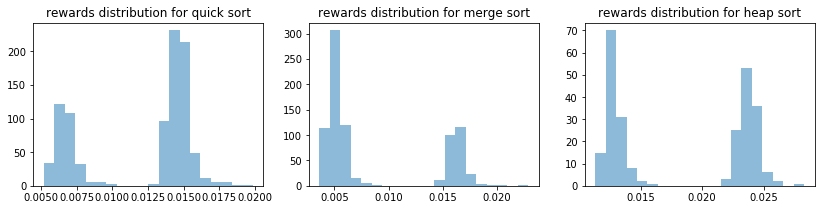

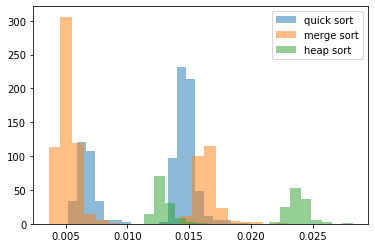

In [75]:
plot_rewards_distribution(arm_rewards_1)
plot_rewards_distribution_together(arm_rewards_1)

Restart at iteration: 44
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.015023478571460405, 'merge_sort': 0.01669423333335005, 'heap_sort': 0.025637949999975262}
Count per chosen algo {'quick_sort': 14, 'merge_sort': 27, 'heap_sort': 4}


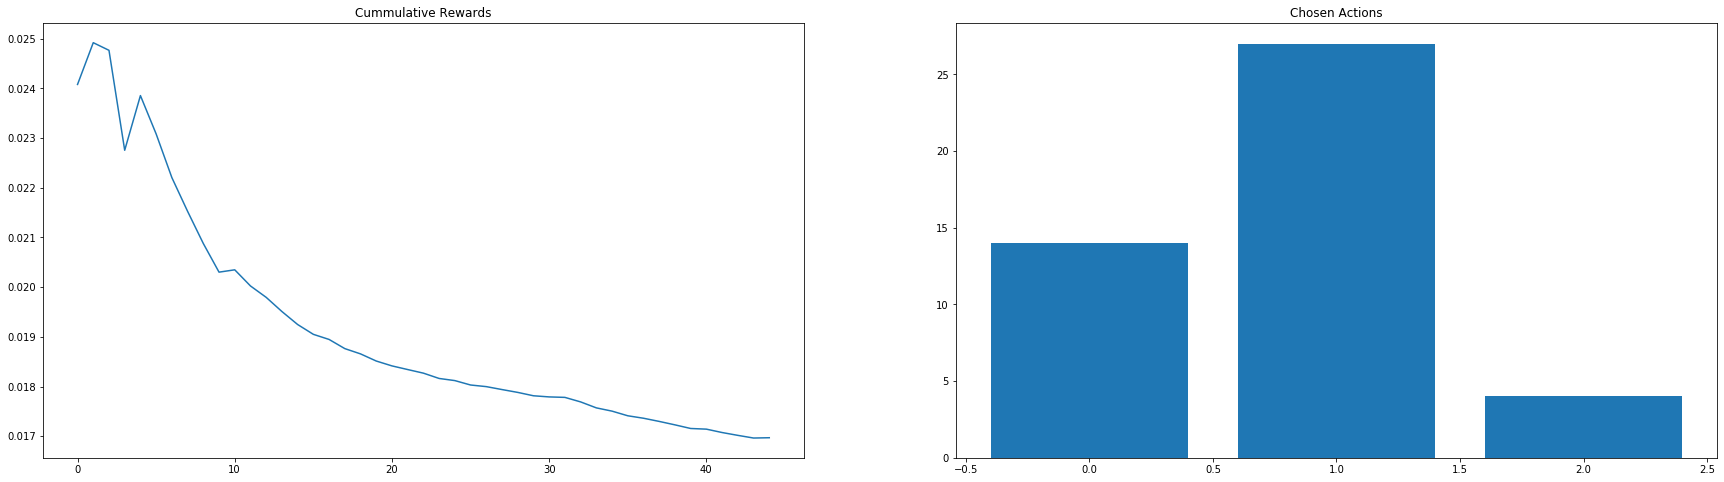

Restart at iteration: 63
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.015009749999990163, 'merge_sort': 0.01668629999994664, 'heap_sort': 0.02403124999989359}
Count per chosen algo {'quick_sort': 12, 'merge_sort': 3, 'heap_sort': 4}


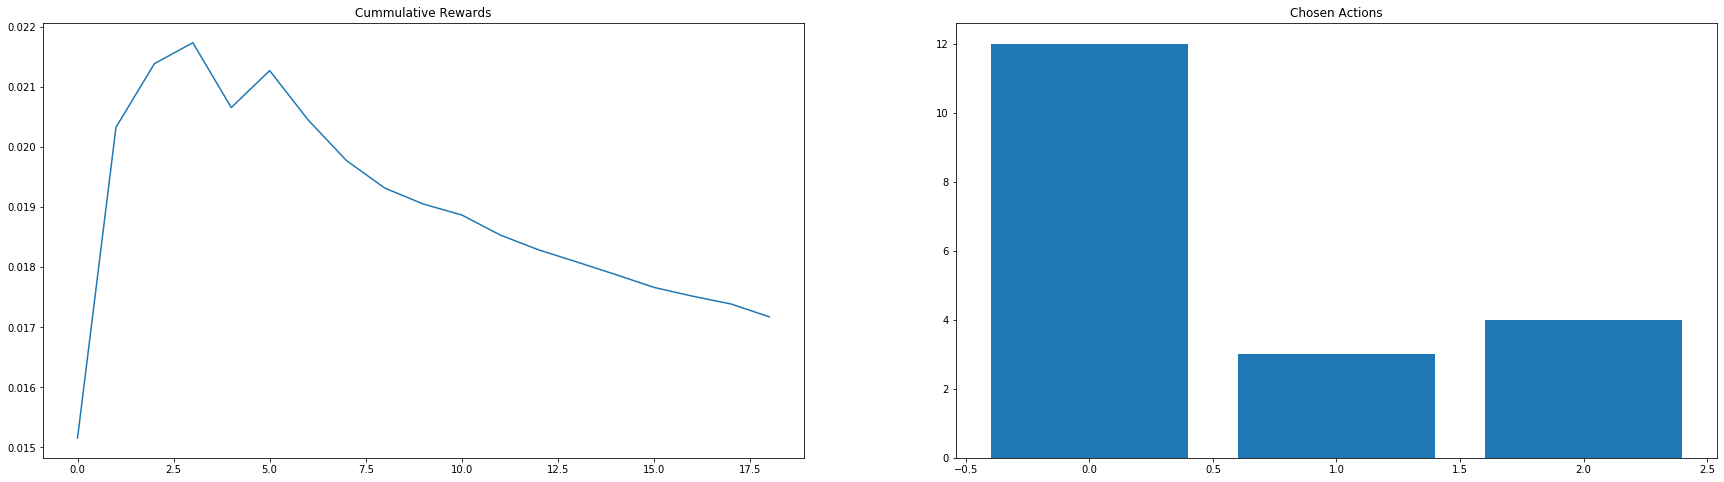

Restart at iteration: 85
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.014603023529402622, 'merge_sort': 0.016382366666751597, 'heap_sort': 0.024125899999944522}
Count per chosen algo {'quick_sort': 17, 'merge_sort': 3, 'heap_sort': 2}


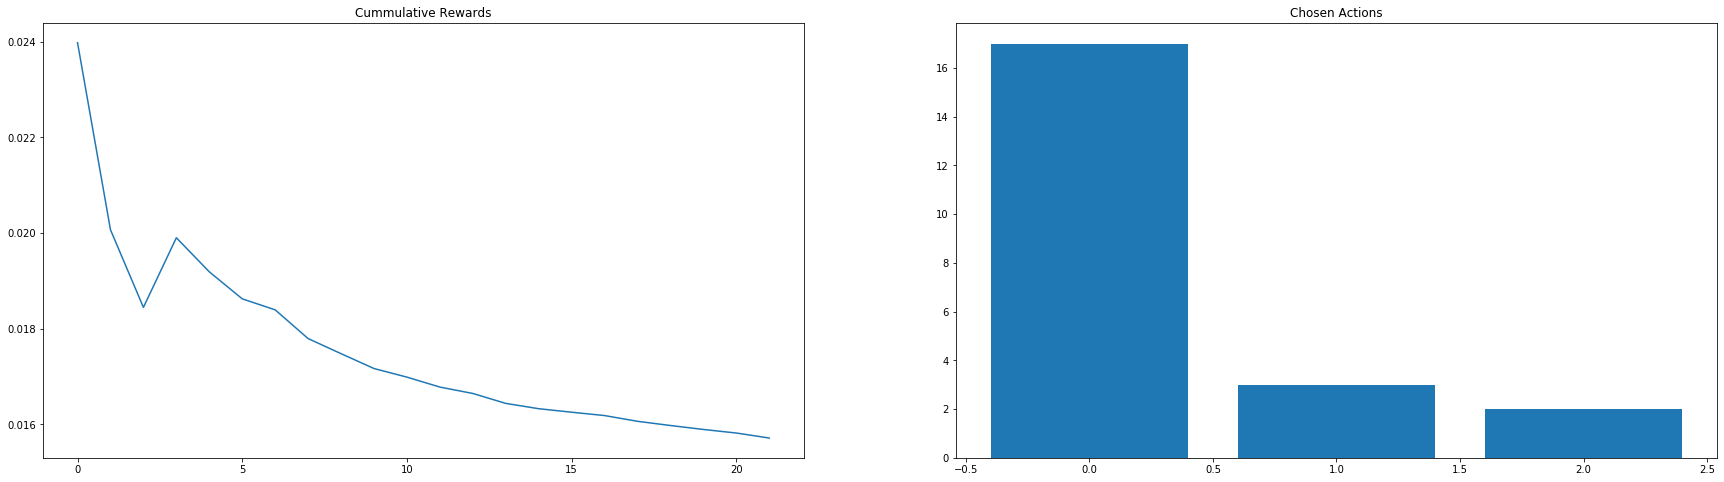

Restart at iteration: 99
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.014643681818163466, 'merge_sort': 0.018547099999977945, 'heap_sort': 0.023976500000117085}
Count per chosen algo {'quick_sort': 11, 'merge_sort': 1, 'heap_sort': 2}


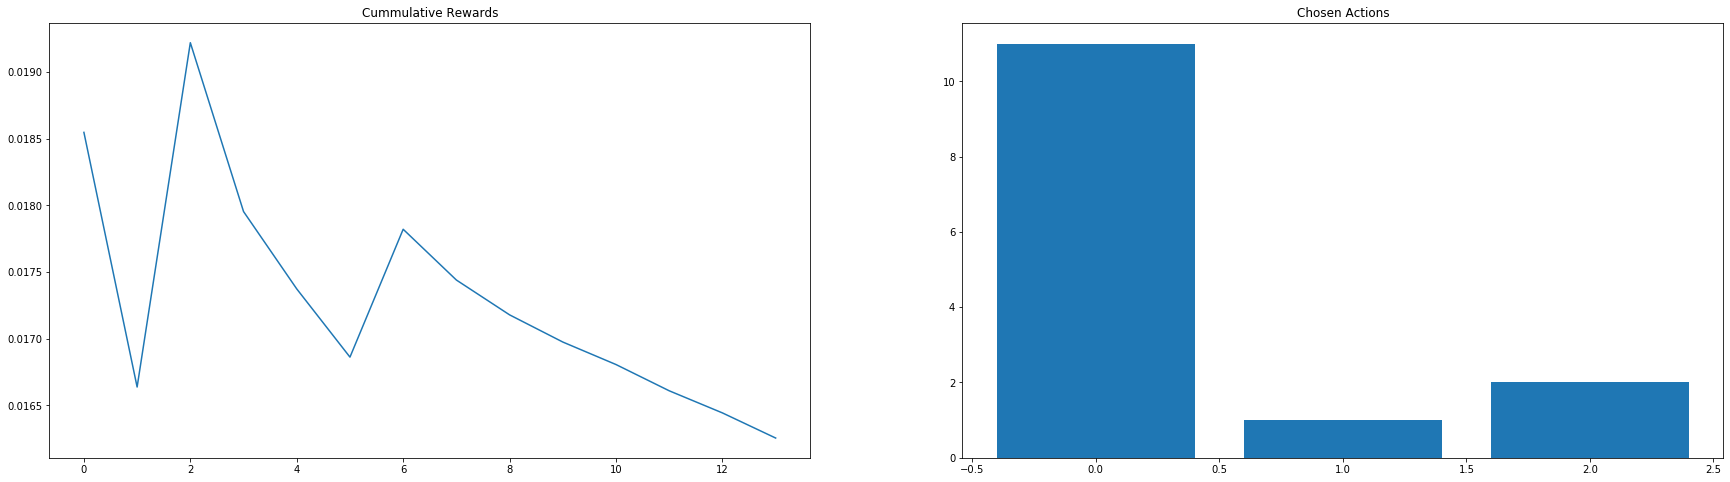

Restart at iteration: 114
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.01511575454545974, 'merge_sort': 0.016390949999959048, 'heap_sort': 0.023109350000027007}
Count per chosen algo {'quick_sort': 11, 'merge_sort': 2, 'heap_sort': 2}


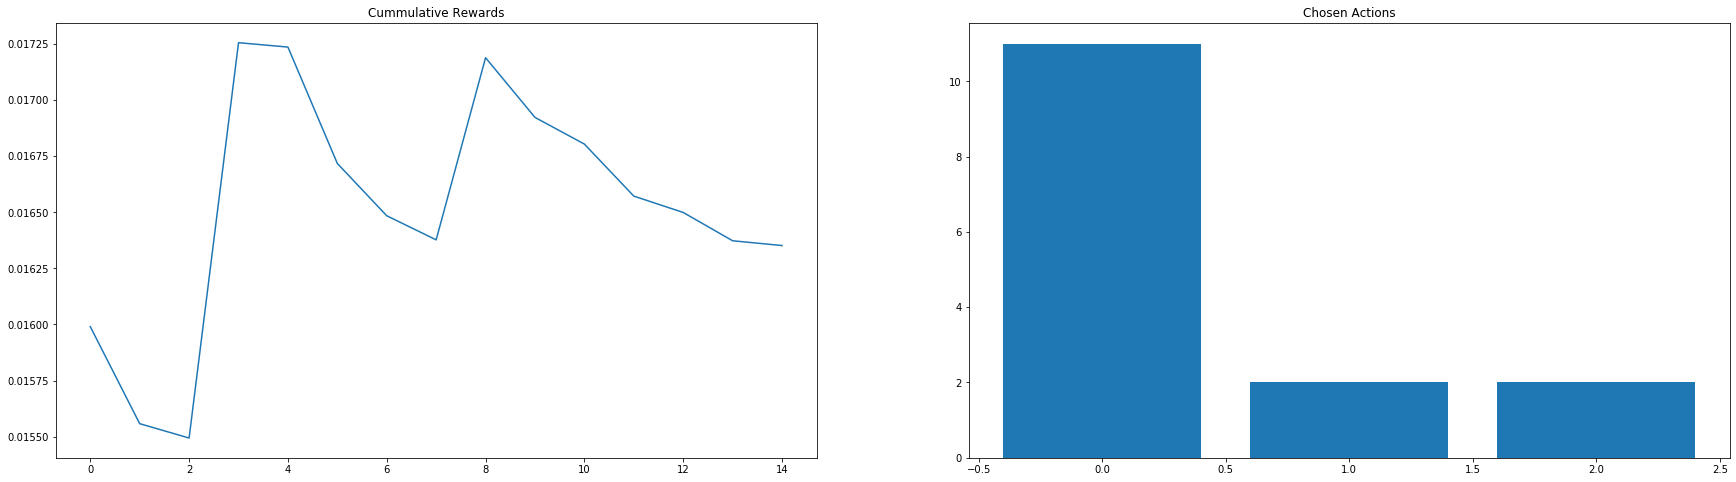

Restart at iteration: 131
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.01468490833336015, 'merge_sort': 0.016527766666664927, 'heap_sort': 0.023985250000009728}
Count per chosen algo {'quick_sort': 12, 'merge_sort': 3, 'heap_sort': 2}


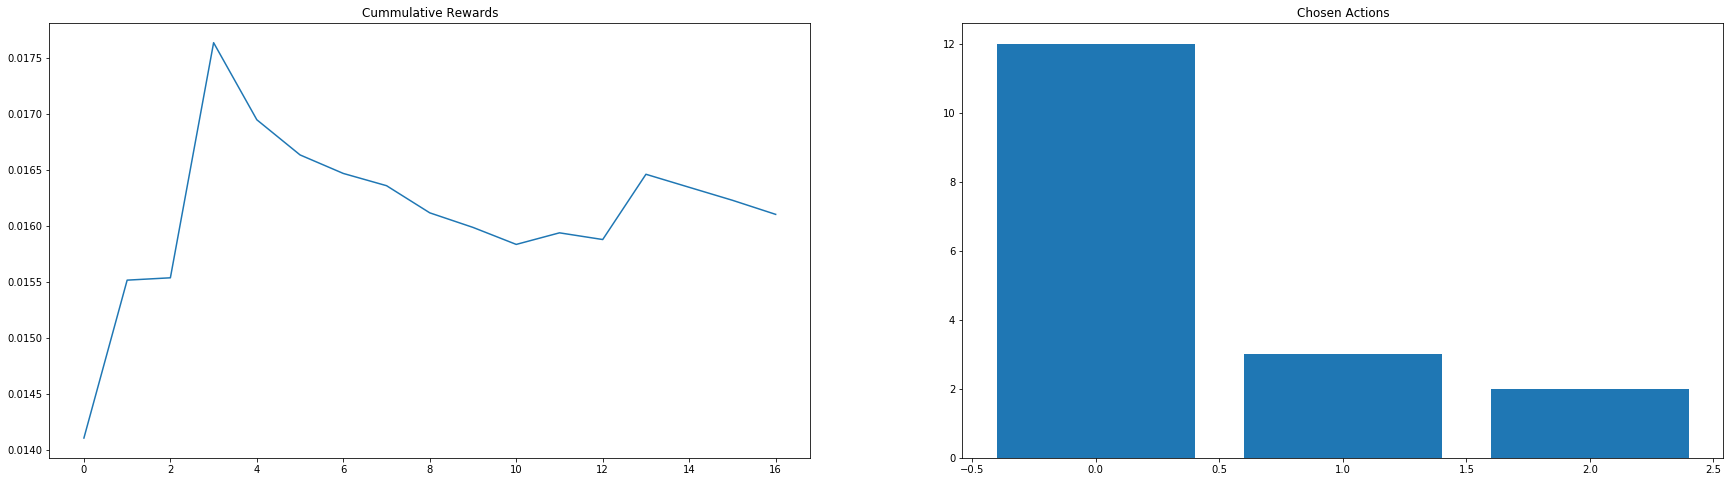

Restart at iteration: 147
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.014641100000062579, 'merge_sort': 0.01692677499996383, 'heap_sort': 0.023085333333407714}
Count per chosen algo {'quick_sort': 1, 'merge_sort': 12, 'heap_sort': 3}


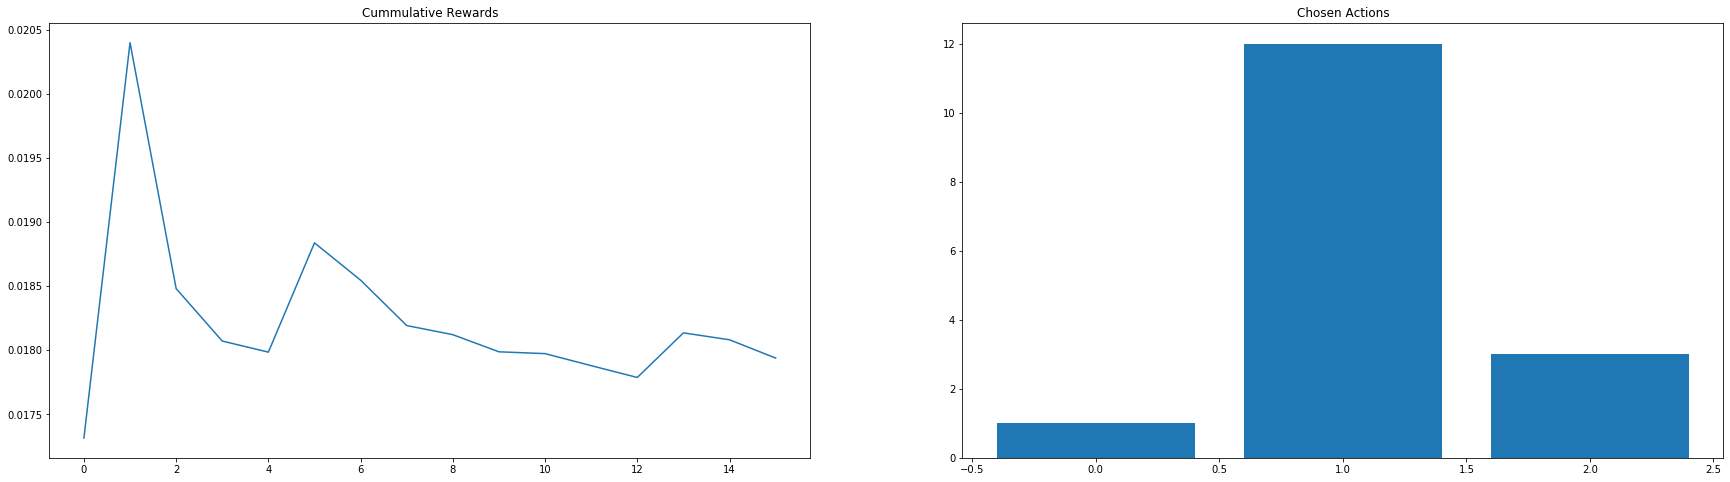

Restart at iteration: 163
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.014438200000003317, 'merge_sort': 0.016859133333355203, 'heap_sort': 0.023357799999985218}
Count per chosen algo {'quick_sort': 11, 'merge_sort': 3, 'heap_sort': 2}


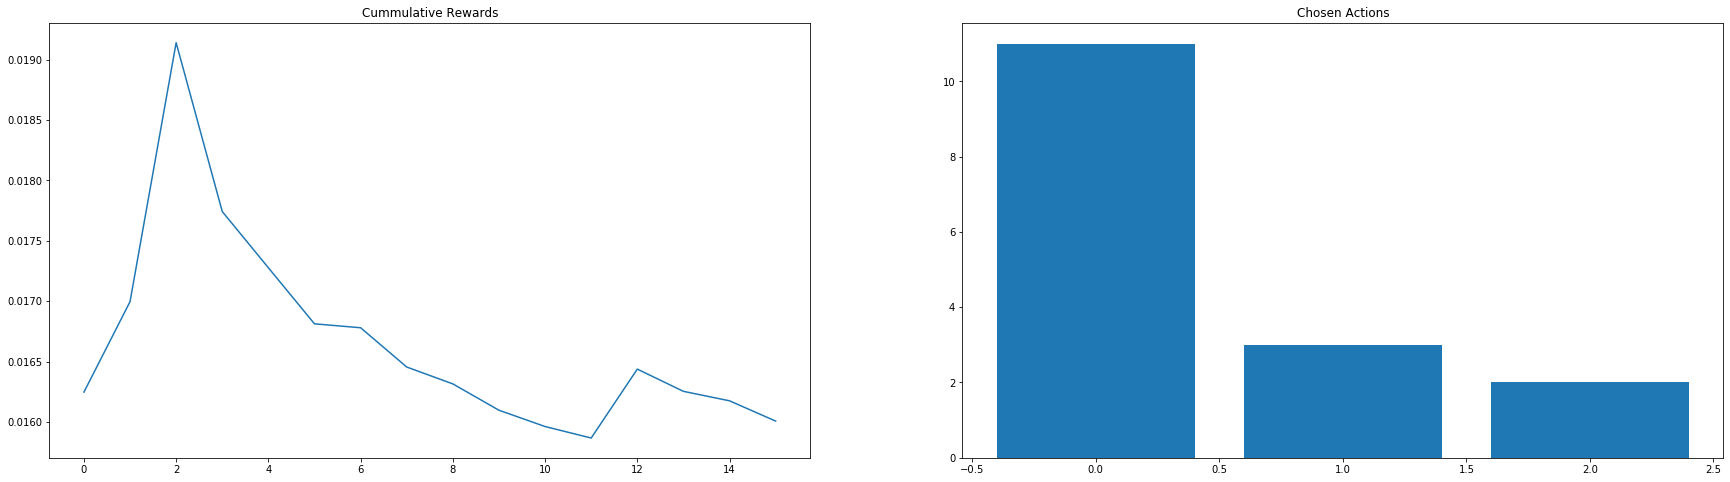

Restart at iteration: 183
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.014551550000040455, 'merge_sort': 0.016129279999950084, 'heap_sort': 0.02285330000002735}
Count per chosen algo {'quick_sort': 12, 'merge_sort': 5, 'heap_sort': 3}


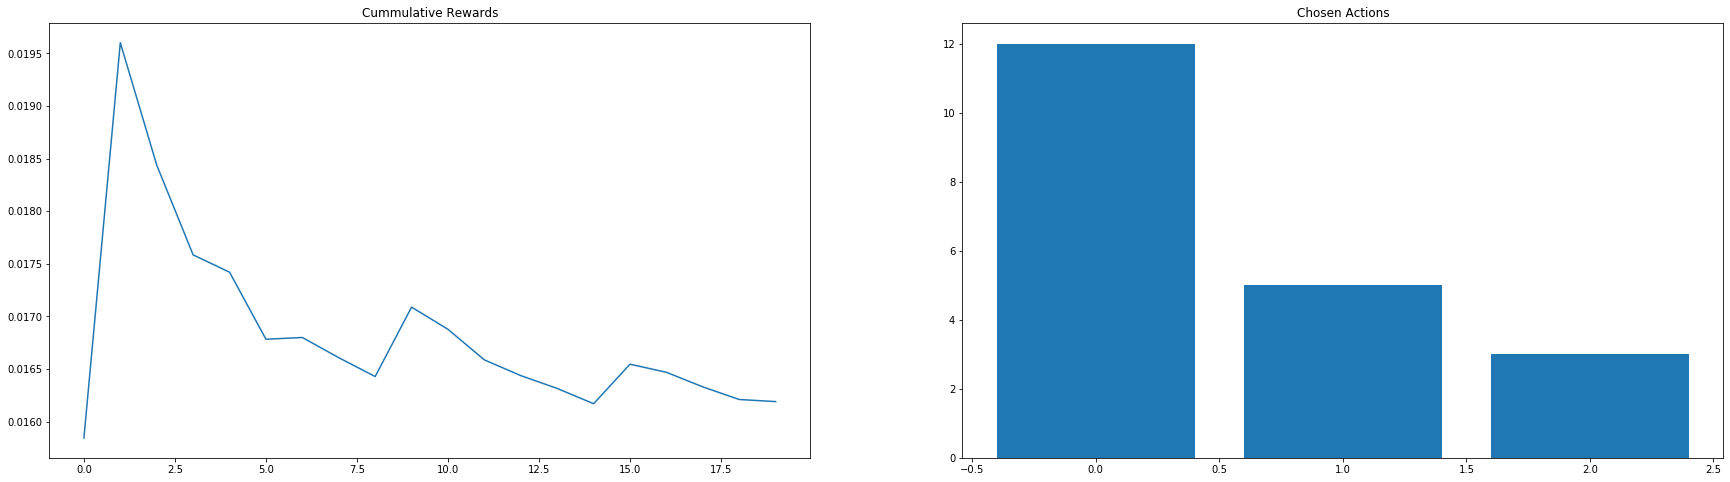

Restart at iteration: 201
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.014907300000019556, 'merge_sort': 0.016711449999888828, 'heap_sort': 0.024432400000023335}
Count per chosen algo {'quick_sort': 15, 'merge_sort': 2, 'heap_sort': 1}


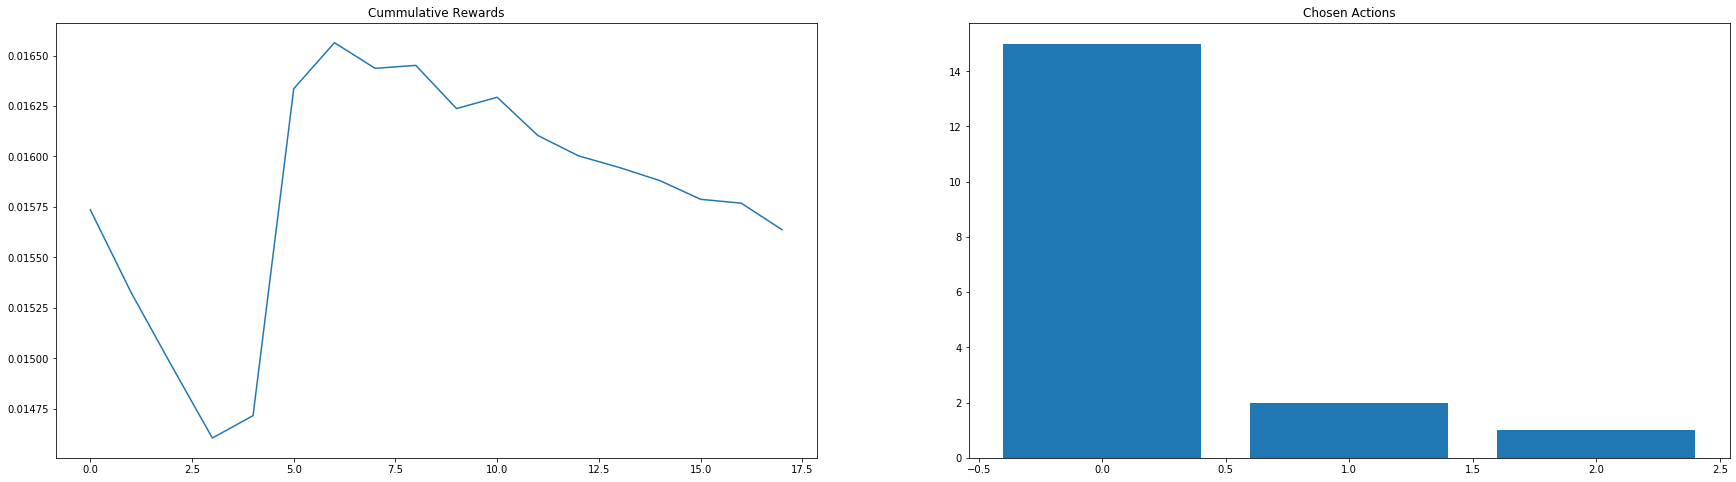

Restart at iteration: 219
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.014693899999883797, 'merge_sort': 0.01644890666664954, 'heap_sort': 0.02428704999999809}
Count per chosen algo {'quick_sort': 1, 'merge_sort': 15, 'heap_sort': 2}


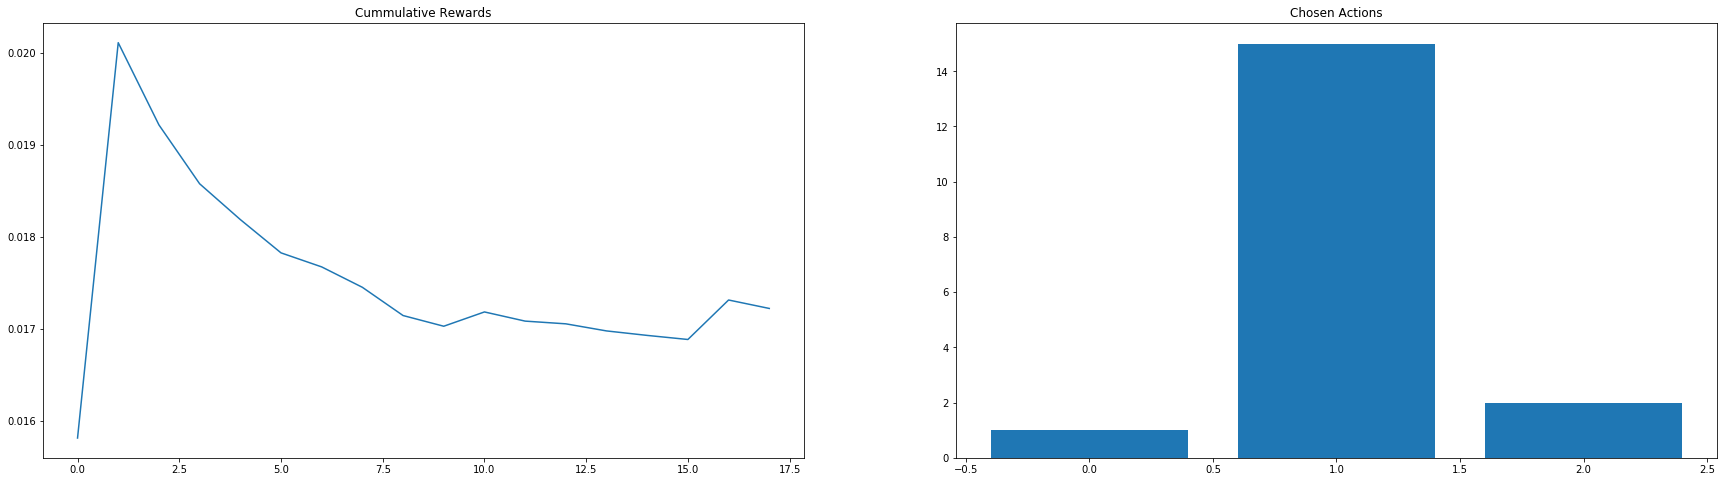

Restart at iteration: 254
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.014500308333291892, 'merge_sort': 0.01626369523812952, 'heap_sort': 0.023636500000066007}
Count per chosen algo {'quick_sort': 12, 'merge_sort': 21, 'heap_sort': 2}


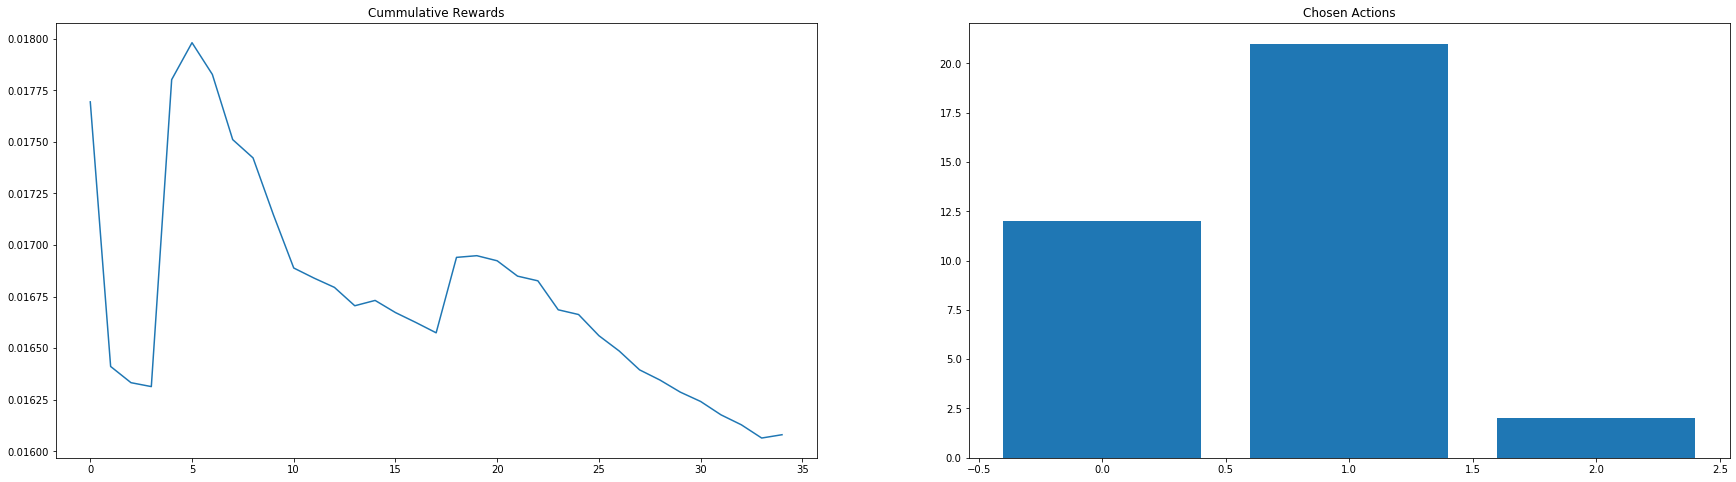

Restart at iteration: 276
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.015026940000022174, 'merge_sort': 0.016533814285756825, 'heap_sort': 0.0}
Count per chosen algo {'quick_sort': 15, 'merge_sort': 7, 'heap_sort': 0}


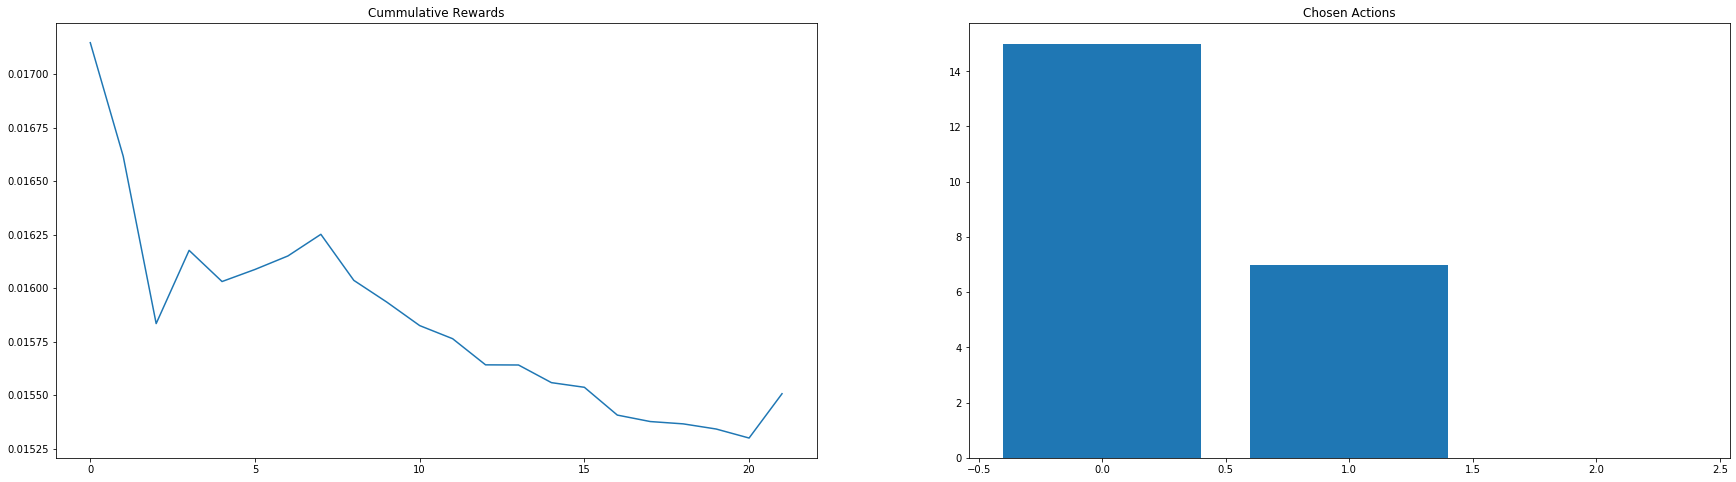

Restart at iteration: 297
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.01518749999991087, 'merge_sort': 0.016363216666642682, 'heap_sort': 0.023807049999959418}
Count per chosen algo {'quick_sort': 1, 'merge_sort': 18, 'heap_sort': 2}


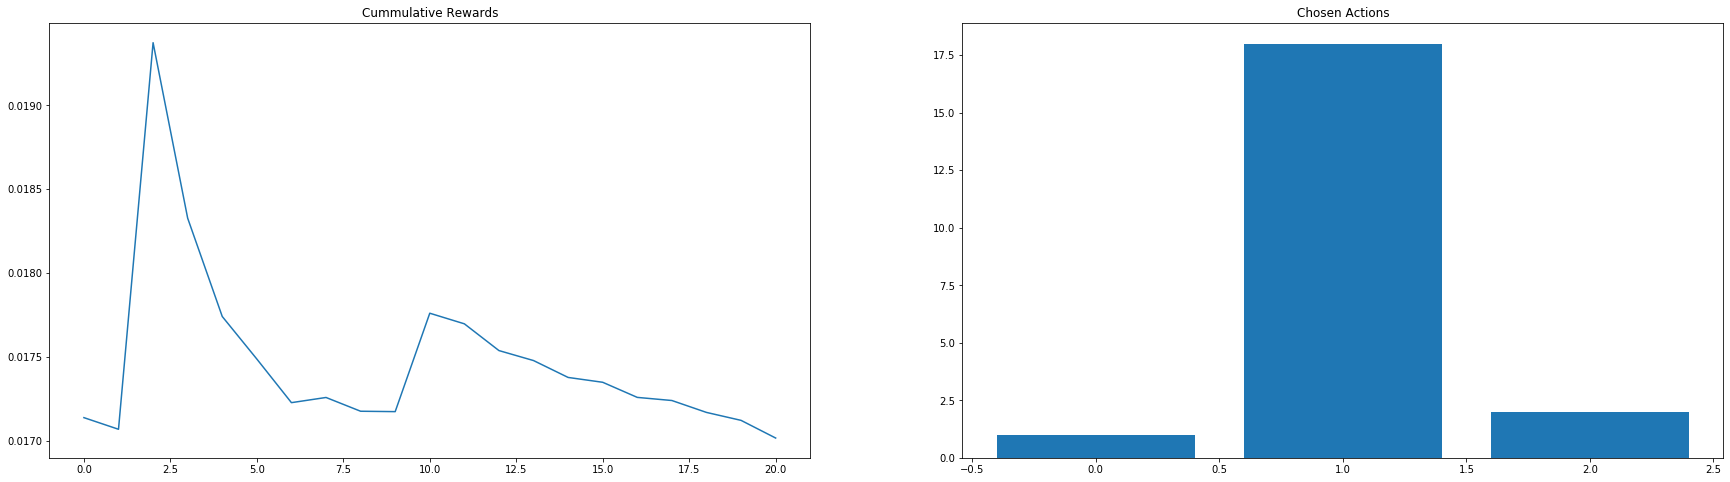

Restart at iteration: 331
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.0145197178571347, 'merge_sort': 0.016151275000083842, 'heap_sort': 0.02530509999996866}
Count per chosen algo {'quick_sort': 28, 'merge_sort': 4, 'heap_sort': 2}


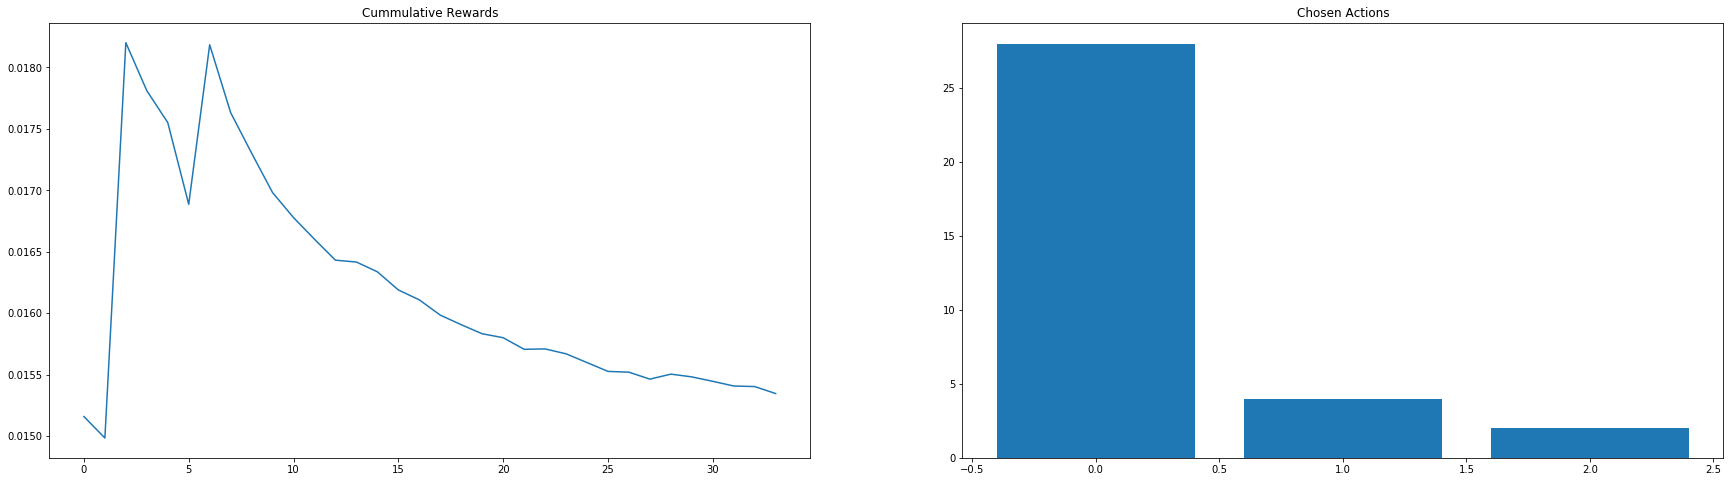

Restart at iteration: 347
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.014777349999993325, 'merge_sort': 0.0160968000000139, 'heap_sort': 0.023238650000052985}
Count per chosen algo {'quick_sort': 12, 'merge_sort': 2, 'heap_sort': 2}


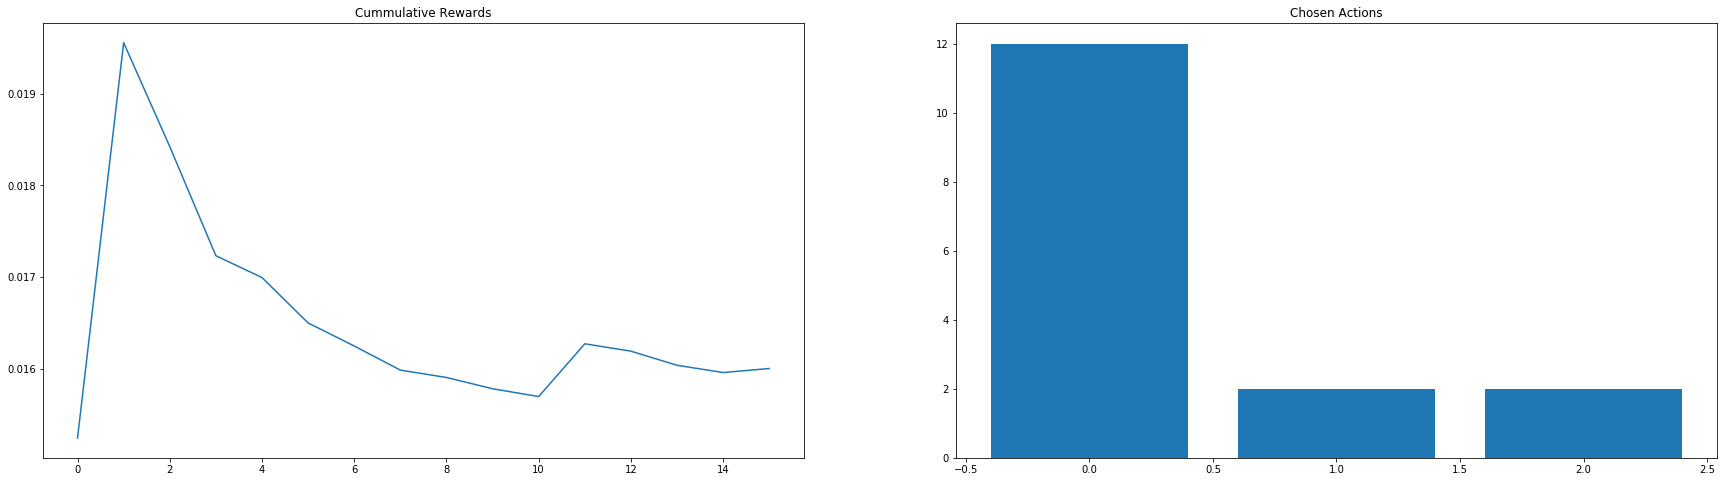

Restart at iteration: 374
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.014619145000051504, 'merge_sort': 0.01668564999999944, 'heap_sort': 0.023972479999974892}
Count per chosen algo {'quick_sort': 20, 'merge_sort': 2, 'heap_sort': 5}


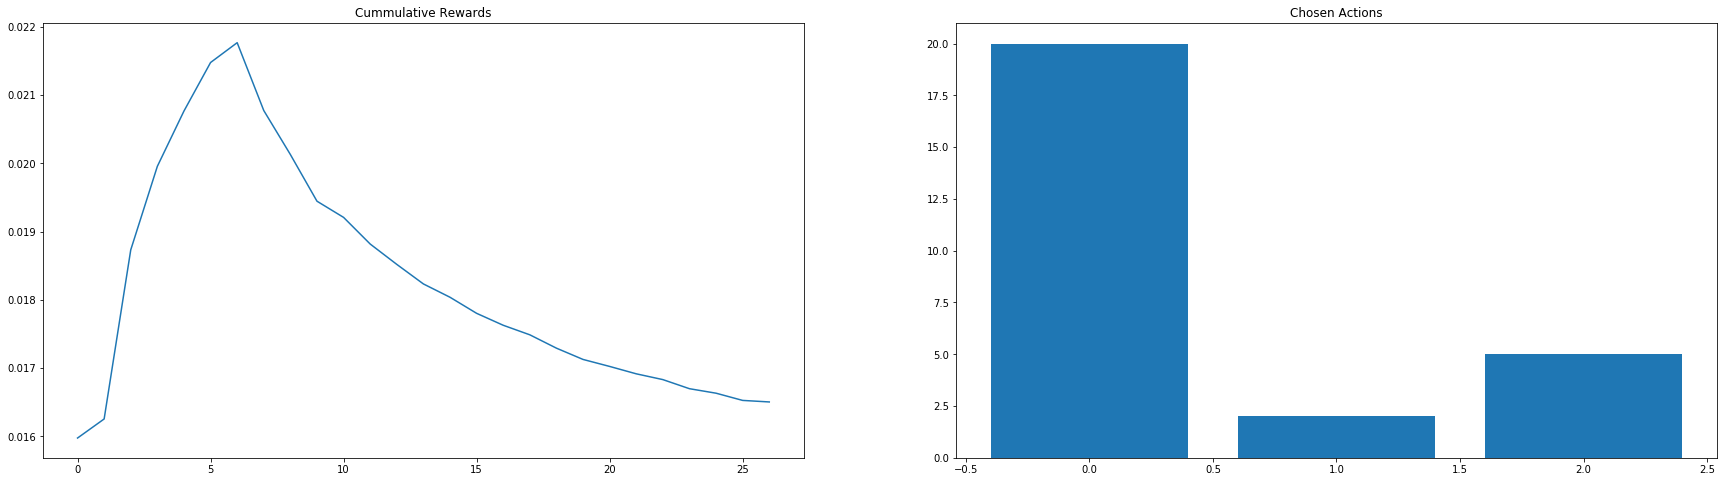

Restart at iteration: 393
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.014614212500006829, 'merge_sort': 0.016557400000010603, 'heap_sort': 0.022592850000023645}
Count per chosen algo {'quick_sort': 16, 'merge_sort': 1, 'heap_sort': 2}


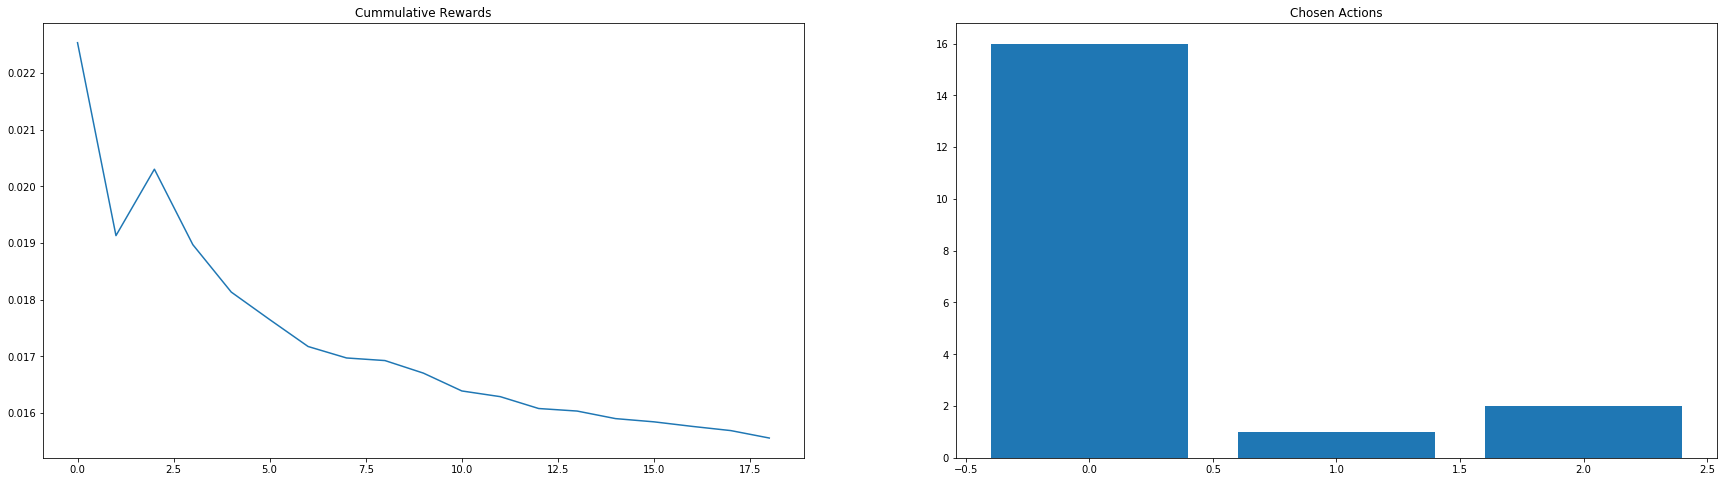

Restart at iteration: 417
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.014597330000003694, 'merge_sort': 0.01606305000007069, 'heap_sort': 0.023537549999900875}
Count per chosen algo {'quick_sort': 20, 'merge_sort': 2, 'heap_sort': 2}


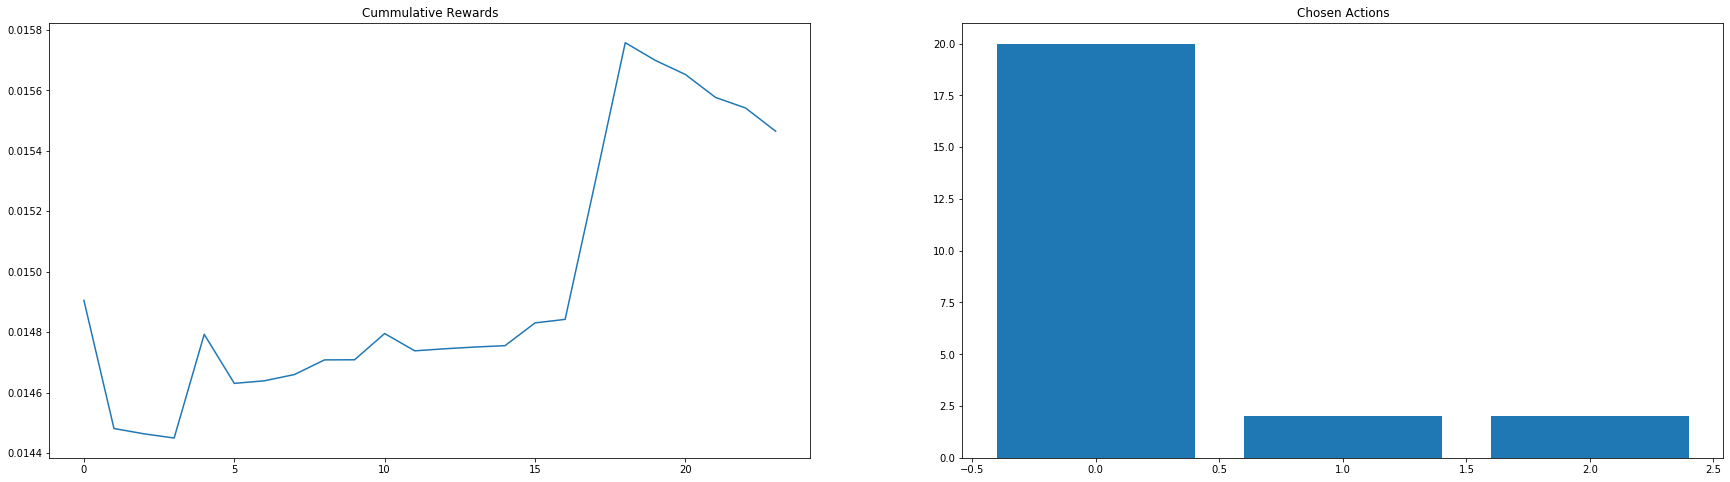

Restart at iteration: 441
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.014715886666635924, 'merge_sort': 0.016364514285766876, 'heap_sort': 0.024345050000079027}
Count per chosen algo {'quick_sort': 15, 'merge_sort': 7, 'heap_sort': 2}


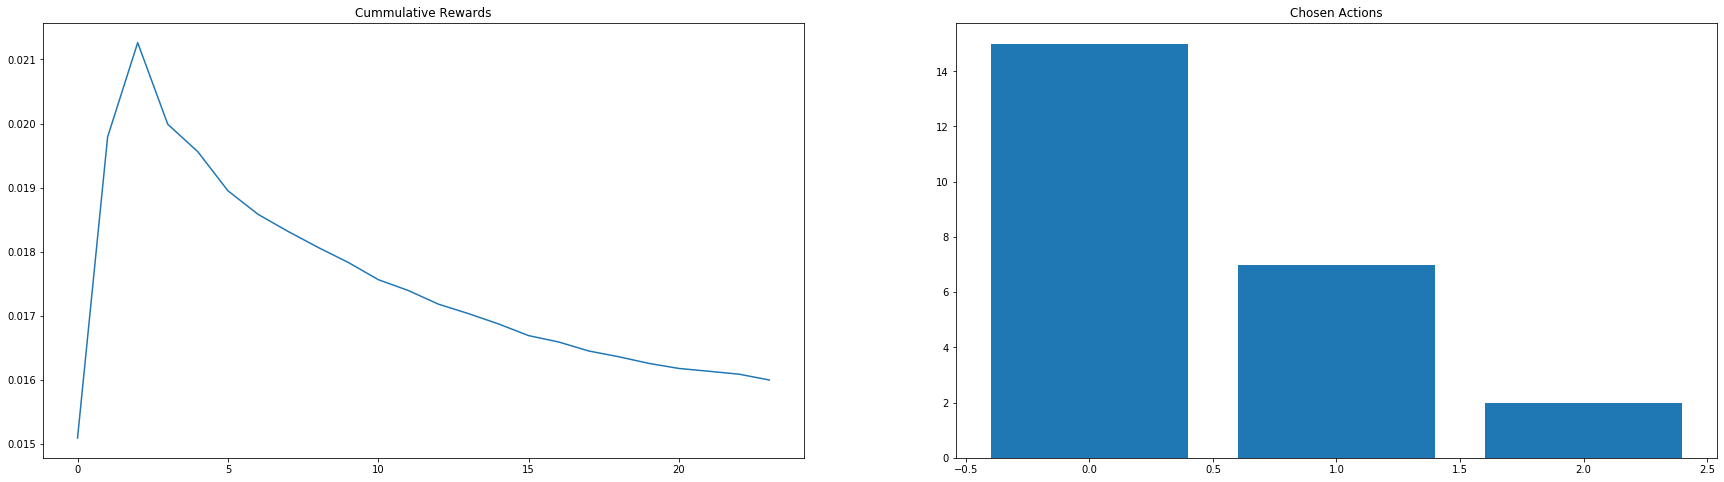

Restart at iteration: 456
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.015008300000090458, 'merge_sort': 0.016902372727186463, 'heap_sort': 0.023632566666719867}
Count per chosen algo {'quick_sort': 1, 'merge_sort': 11, 'heap_sort': 3}


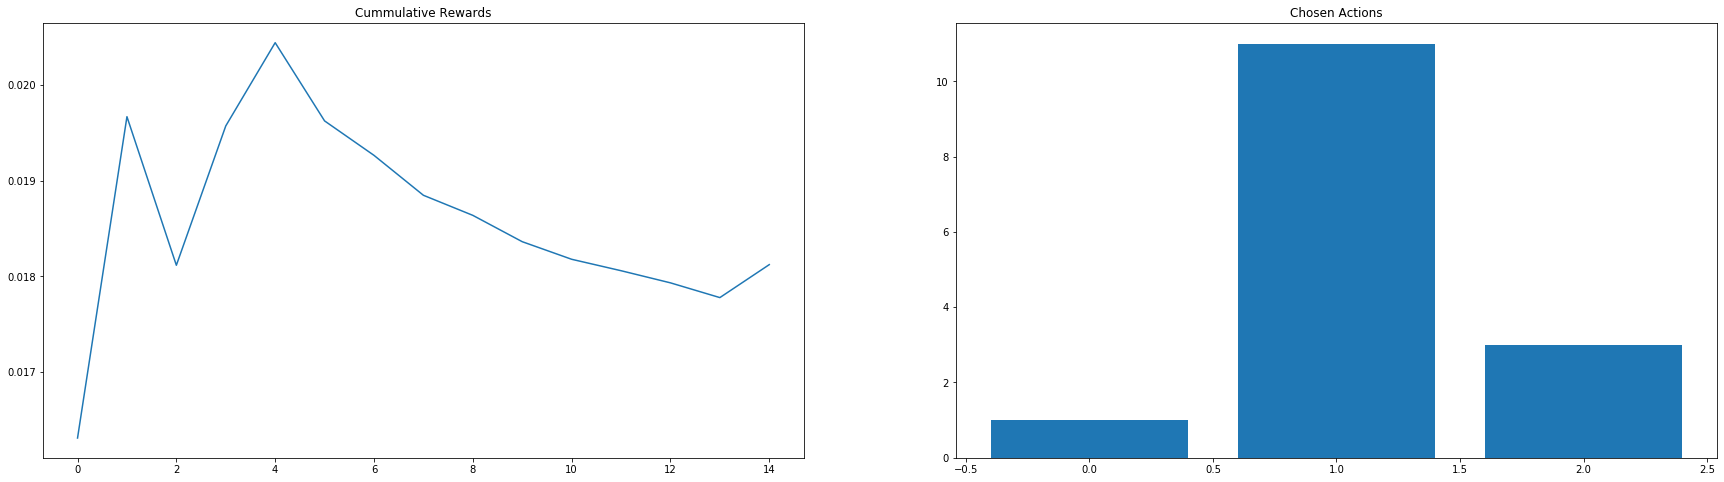

Restart at iteration: 484
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.014508246666688743, 'merge_sort': 0.016226449999999205, 'heap_sort': 0.02383333333326239}
Count per chosen algo {'quick_sort': 15, 'merge_sort': 10, 'heap_sort': 3}


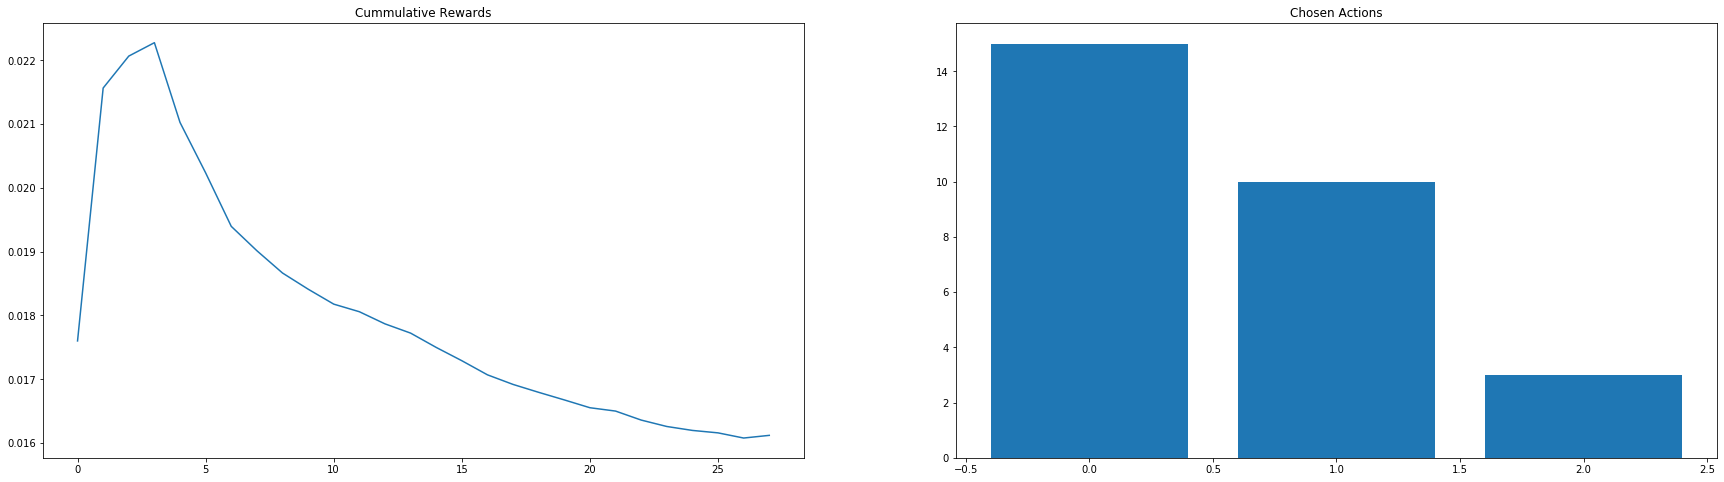

Restart at iteration: 520
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.012644183333350156, 'merge_sort': 0.005503664705857399, 'heap_sort': 0.024005200000017015}
Count per chosen algo {'quick_sort': 12, 'merge_sort': 17, 'heap_sort': 7}


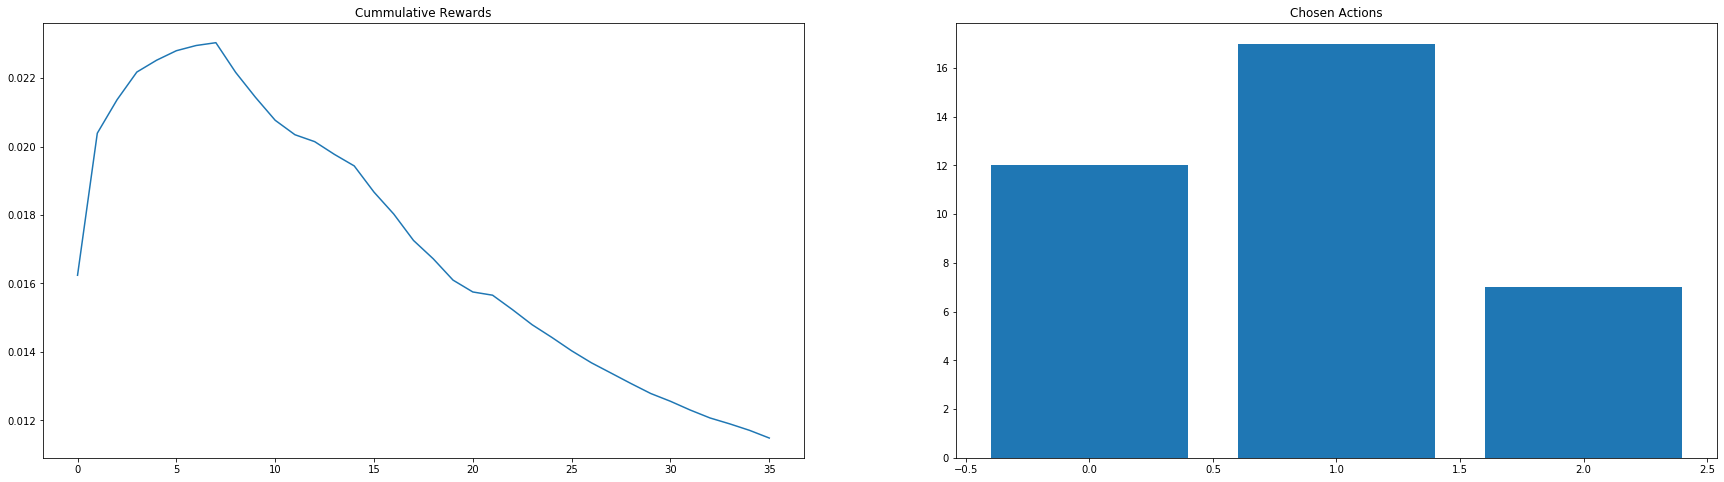

Restart at iteration: 532
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.0072505272727002275, 'merge_sort': 0.0, 'heap_sort': 0.014348400000017136}
Count per chosen algo {'quick_sort': 11, 'merge_sort': 0, 'heap_sort': 1}


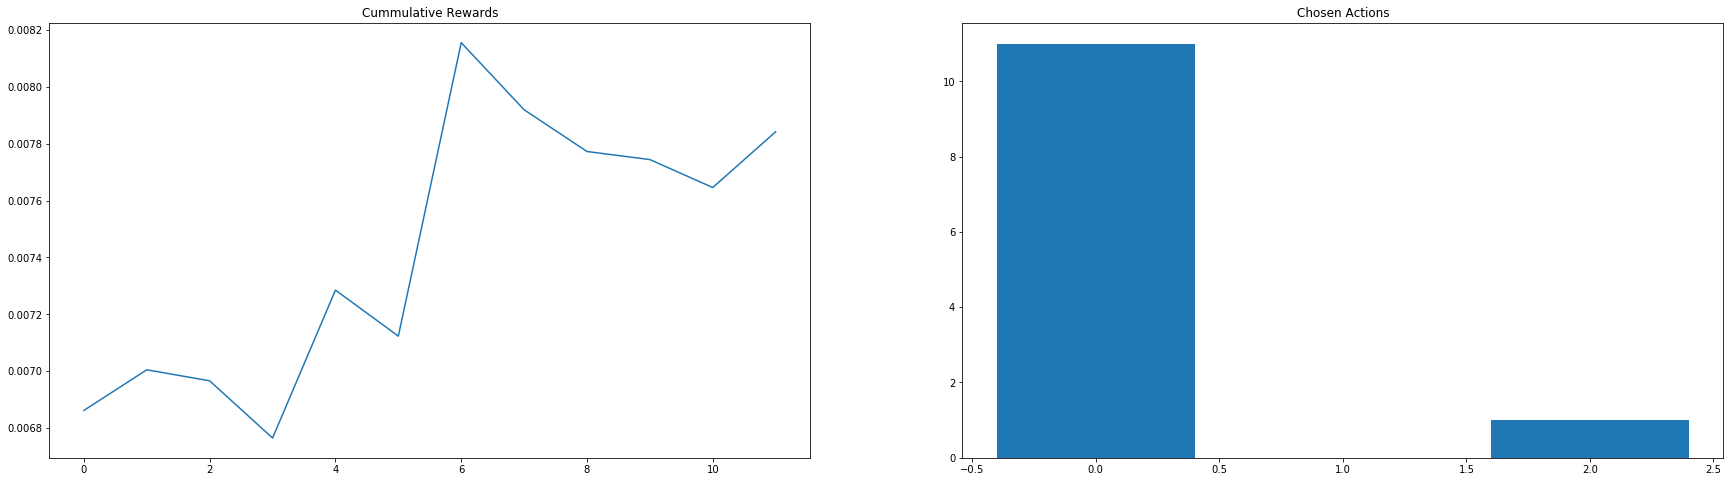

Restart at iteration: 550
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.0, 'merge_sort': 0.005291112500003692, 'heap_sort': 0.013132699999914621}
Count per chosen algo {'quick_sort': 0, 'merge_sort': 16, 'heap_sort': 2}


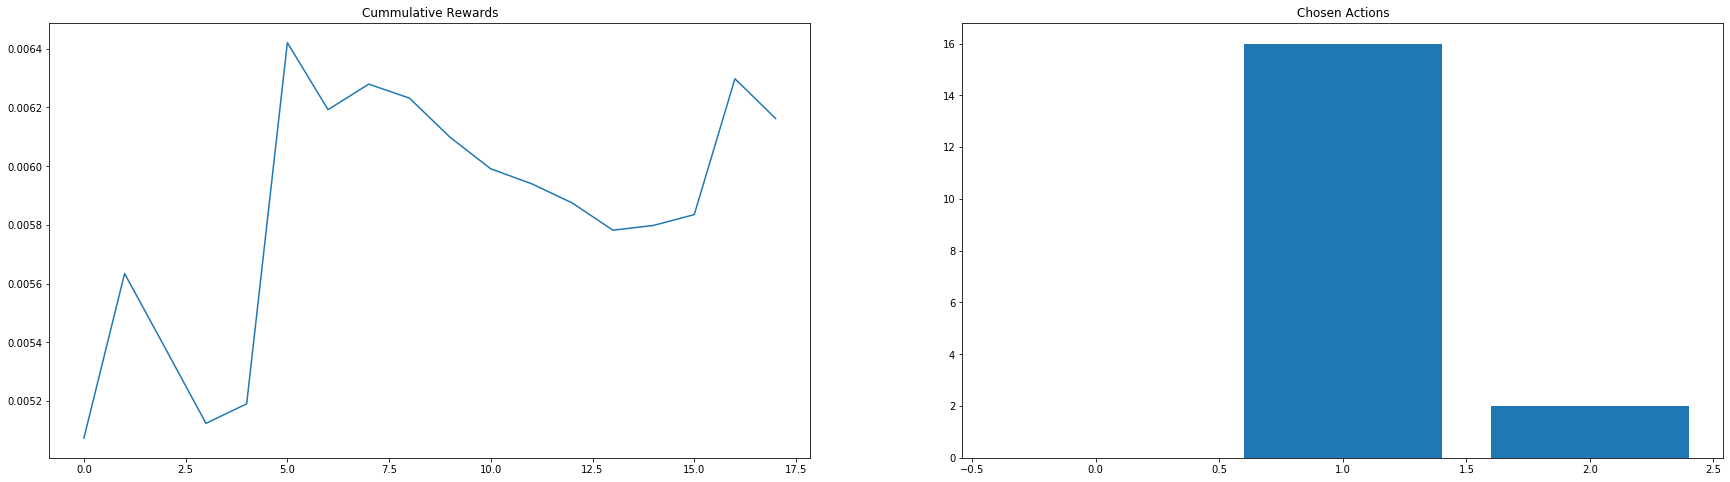

Restart at iteration: 574
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.006539874999968258, 'merge_sort': 0.005501899999944726, 'heap_sort': 0.012928057142906775}
Count per chosen algo {'quick_sort': 12, 'merge_sort': 5, 'heap_sort': 7}


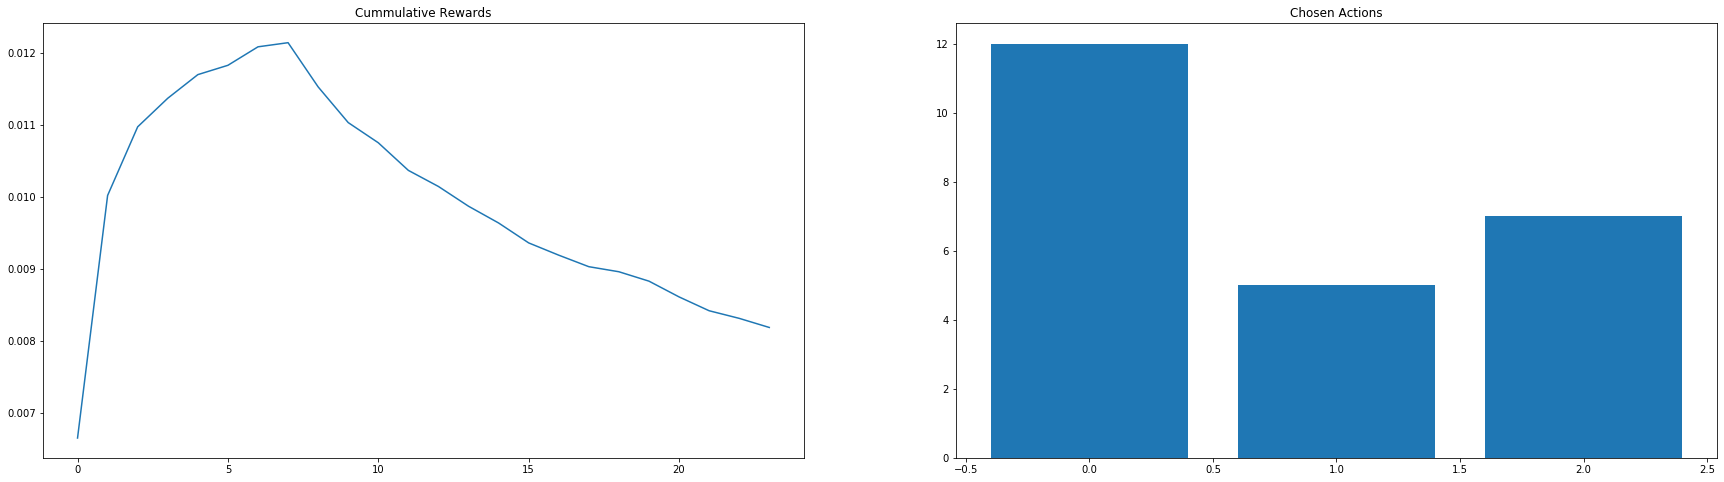

Restart at iteration: 605
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.0066279500000518965, 'merge_sort': 0.005064494117638841, 'heap_sort': 0.01287013333332728}
Count per chosen algo {'quick_sort': 2, 'merge_sort': 17, 'heap_sort': 12}


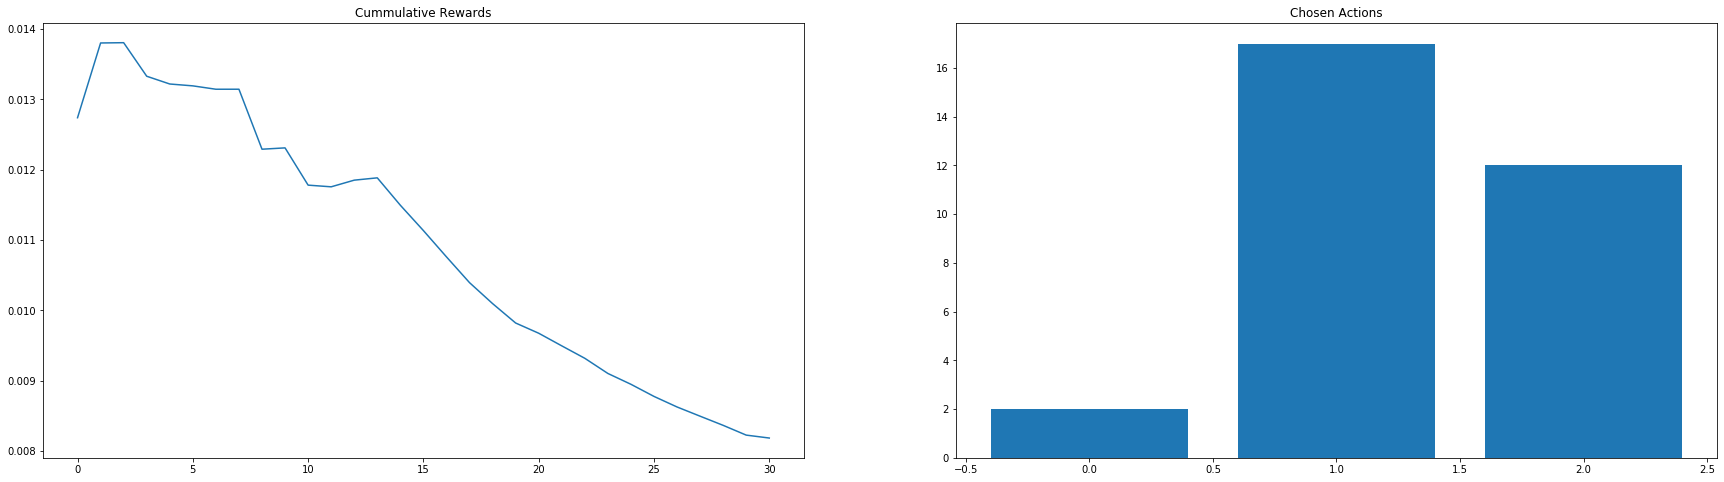

Restart at iteration: 623
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.006898500000033891, 'merge_sort': 0.00457460000006904, 'heap_sort': 0.012838587500041854}
Count per chosen algo {'quick_sort': 1, 'merge_sort': 1, 'heap_sort': 16}


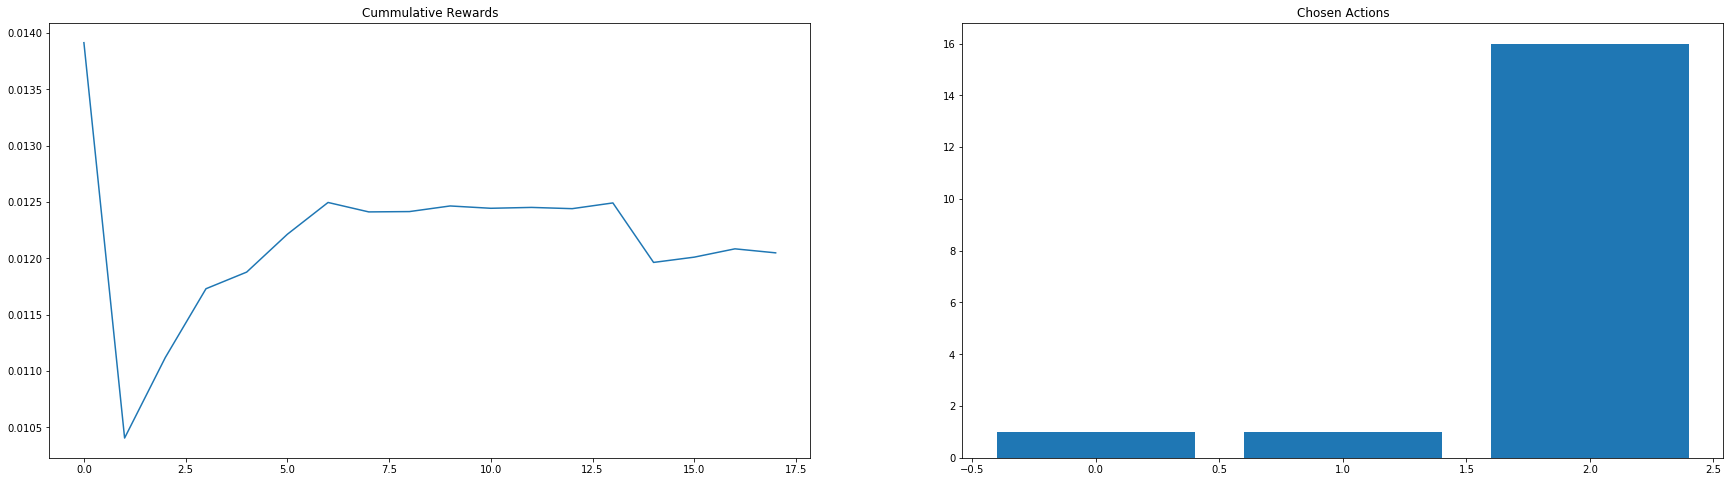

Restart at iteration: 638
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.0065043000000416995, 'merge_sort': 0.0, 'heap_sort': 0.013484299999845462}
Count per chosen algo {'quick_sort': 14, 'merge_sort': 0, 'heap_sort': 1}


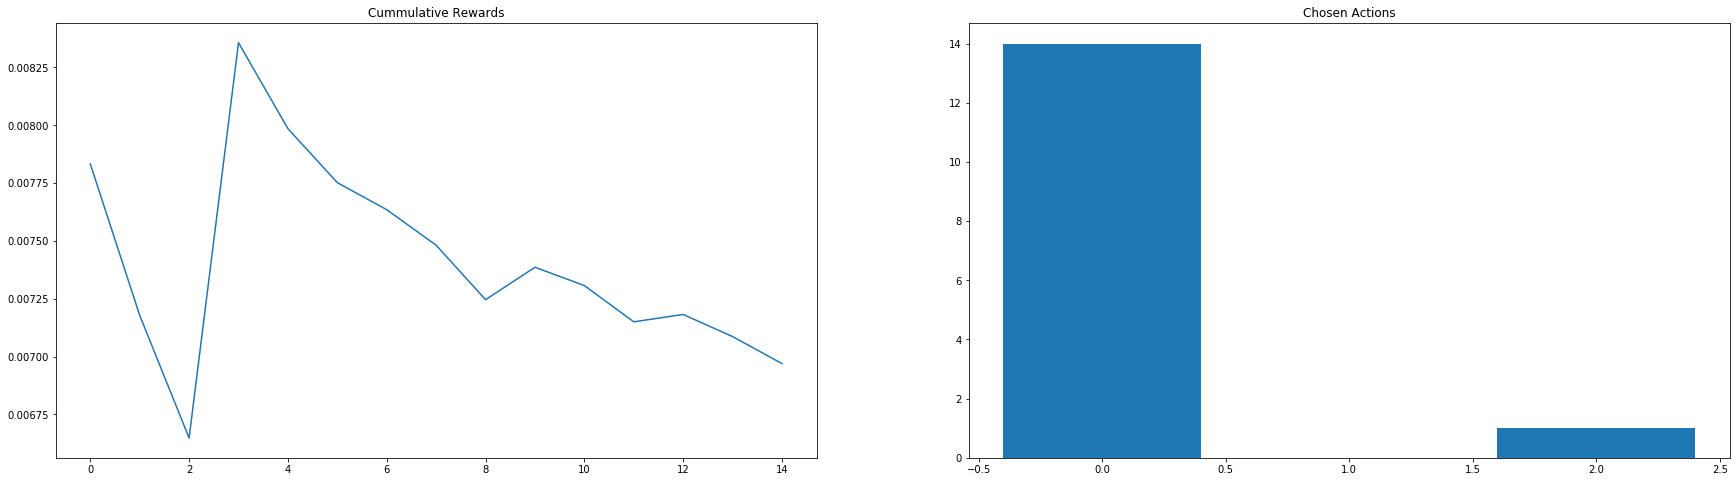

Restart at iteration: 659
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.006166999999891232, 'merge_sort': 0.004923493750013108, 'heap_sort': 0.012714200000042789}
Count per chosen algo {'quick_sort': 2, 'merge_sort': 16, 'heap_sort': 3}


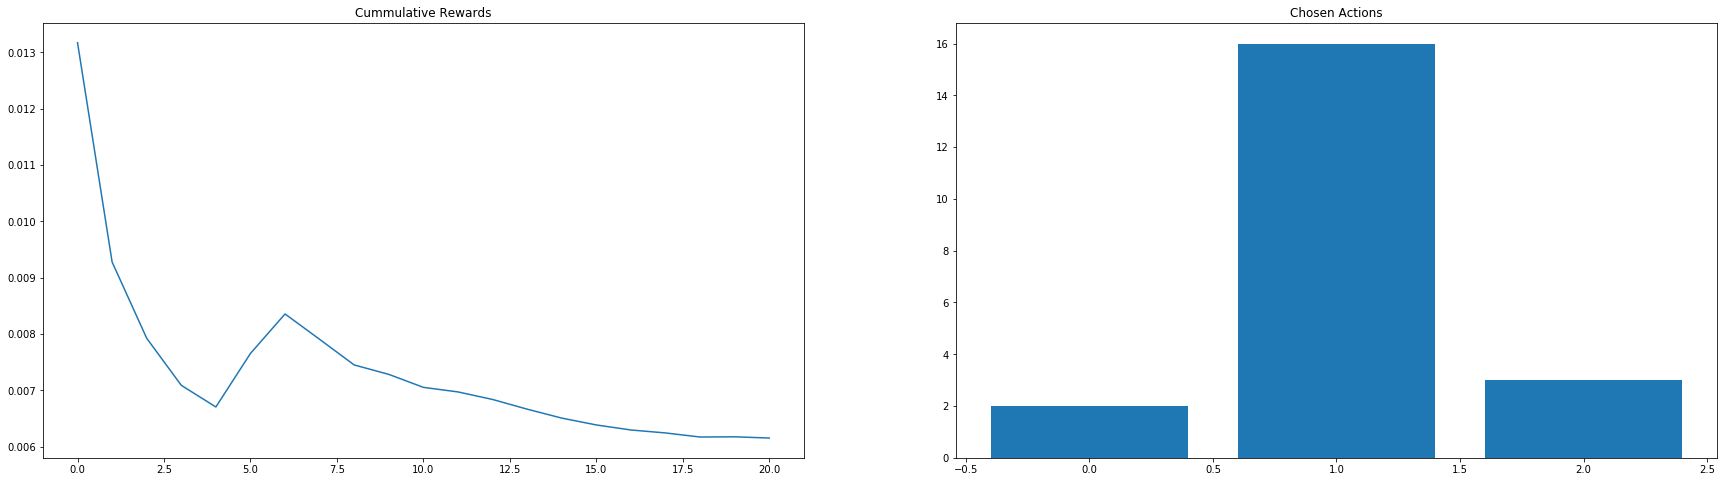

Restart at iteration: 684
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.006830900000068141, 'merge_sort': 0.005370055555583046, 'heap_sort': 0.012797583333356973}
Count per chosen algo {'quick_sort': 1, 'merge_sort': 18, 'heap_sort': 6}


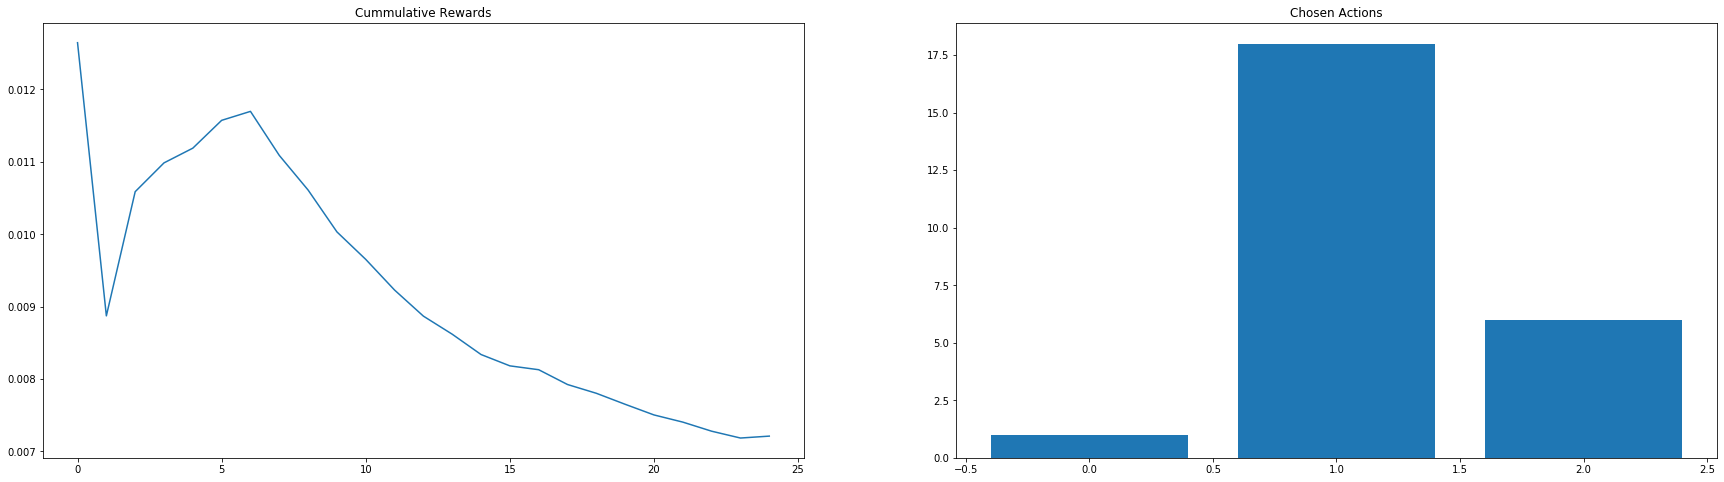

Restart at iteration: 712
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.006671525000015777, 'merge_sort': 0.005547299999989264, 'heap_sort': 0.012718709090946008}
Count per chosen algo {'quick_sort': 16, 'merge_sort': 1, 'heap_sort': 11}


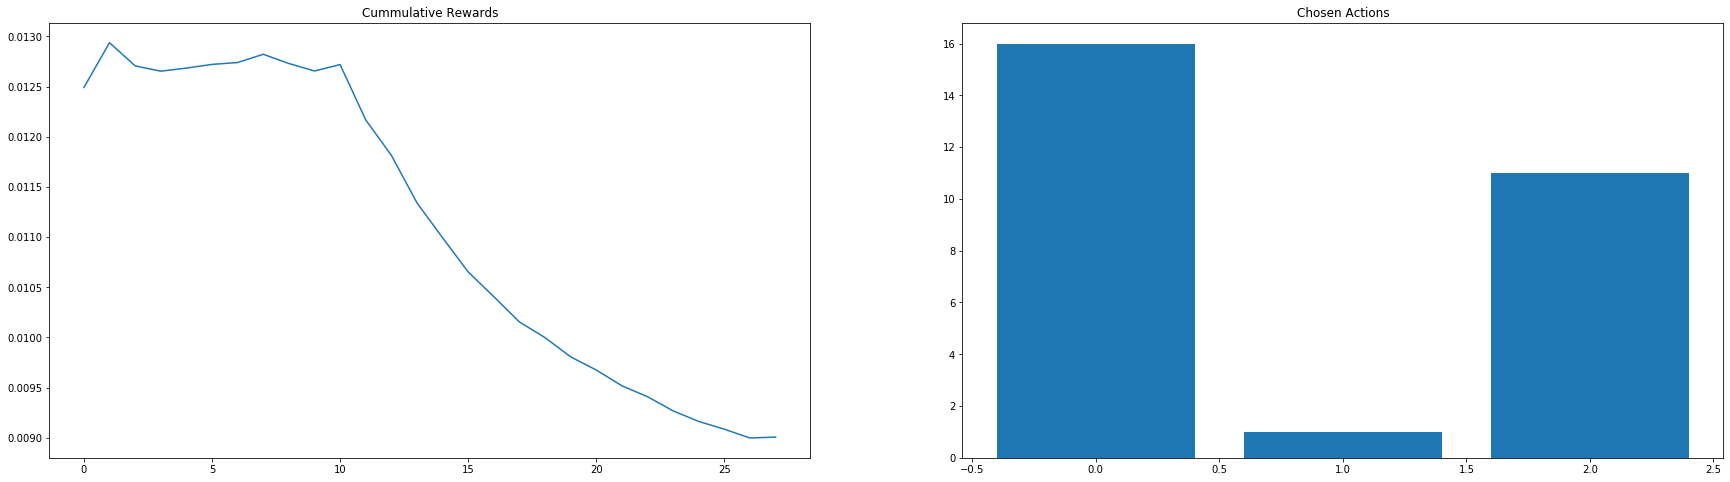

Restart at iteration: 736
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.006899095454534951, 'merge_sort': 0.005078500000081476, 'heap_sort': 0.012917499999957727}
Count per chosen algo {'quick_sort': 22, 'merge_sort': 1, 'heap_sort': 1}


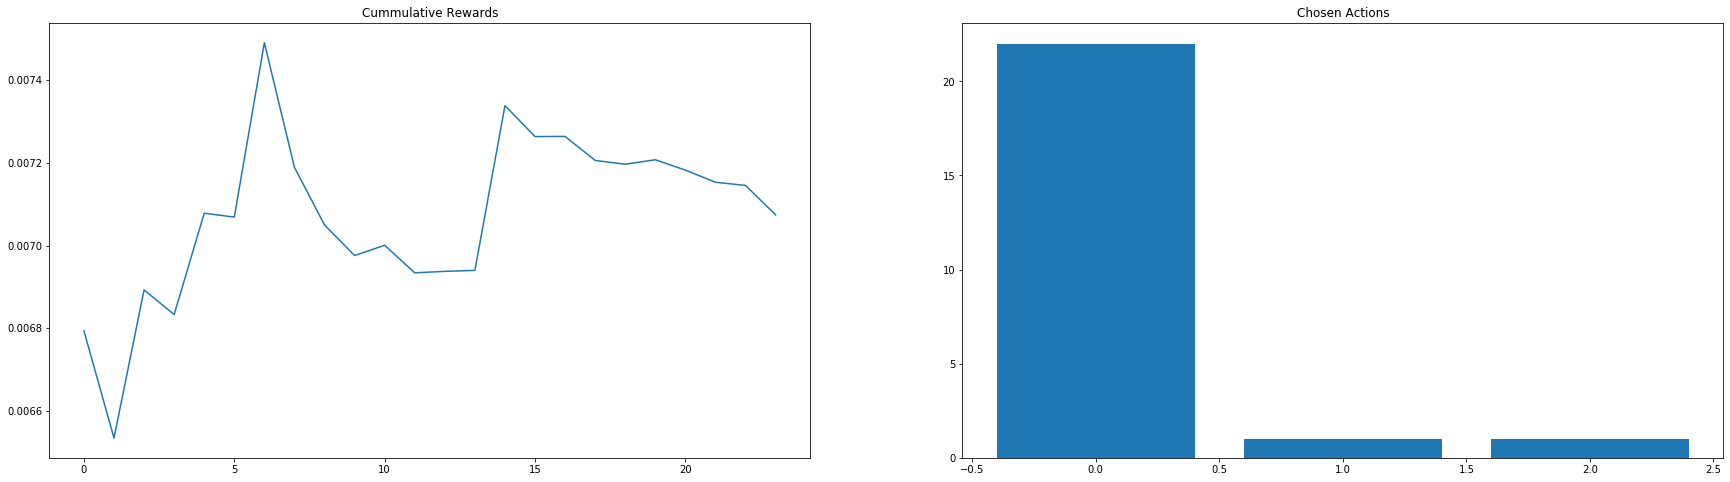

Restart at iteration: 806
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.006704333333345858, 'merge_sort': 0.005031489062496064, 'heap_sort': 0.012241566666640816}
Count per chosen algo {'quick_sort': 3, 'merge_sort': 64, 'heap_sort': 3}


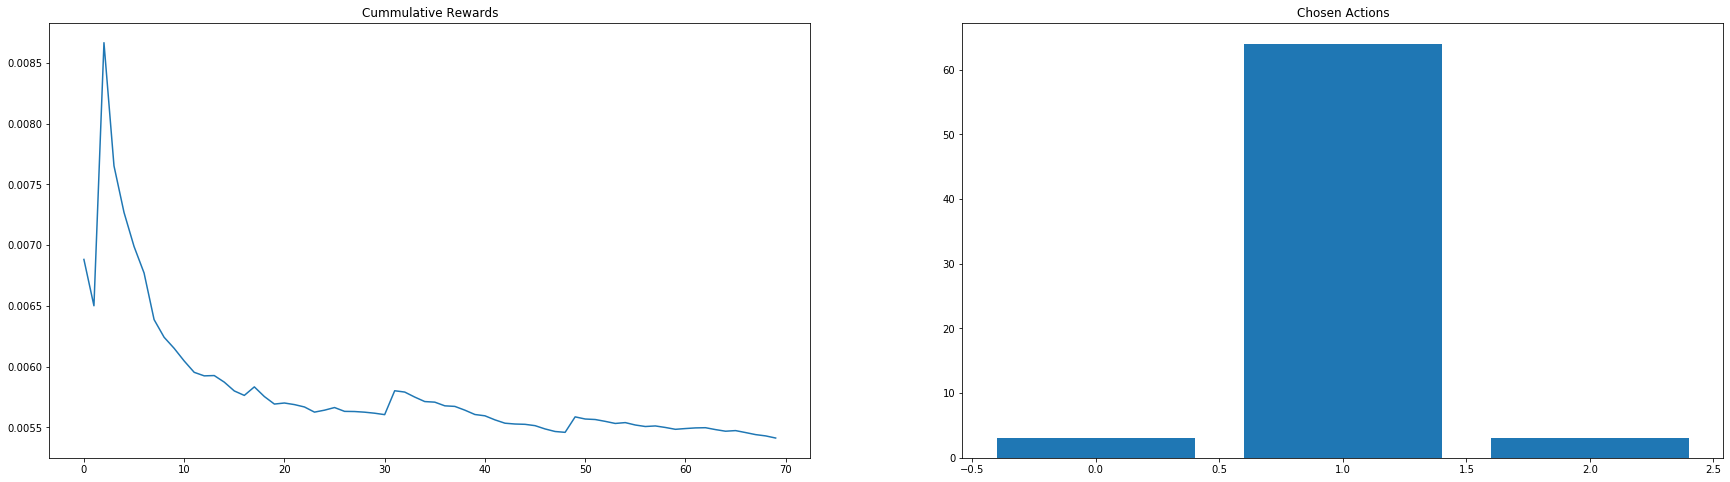

Restart at iteration: 820
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.005877099999906932, 'merge_sort': 0.005286145454564658, 'heap_sort': 0.012953249999895888}
Count per chosen algo {'quick_sort': 1, 'merge_sort': 11, 'heap_sort': 2}


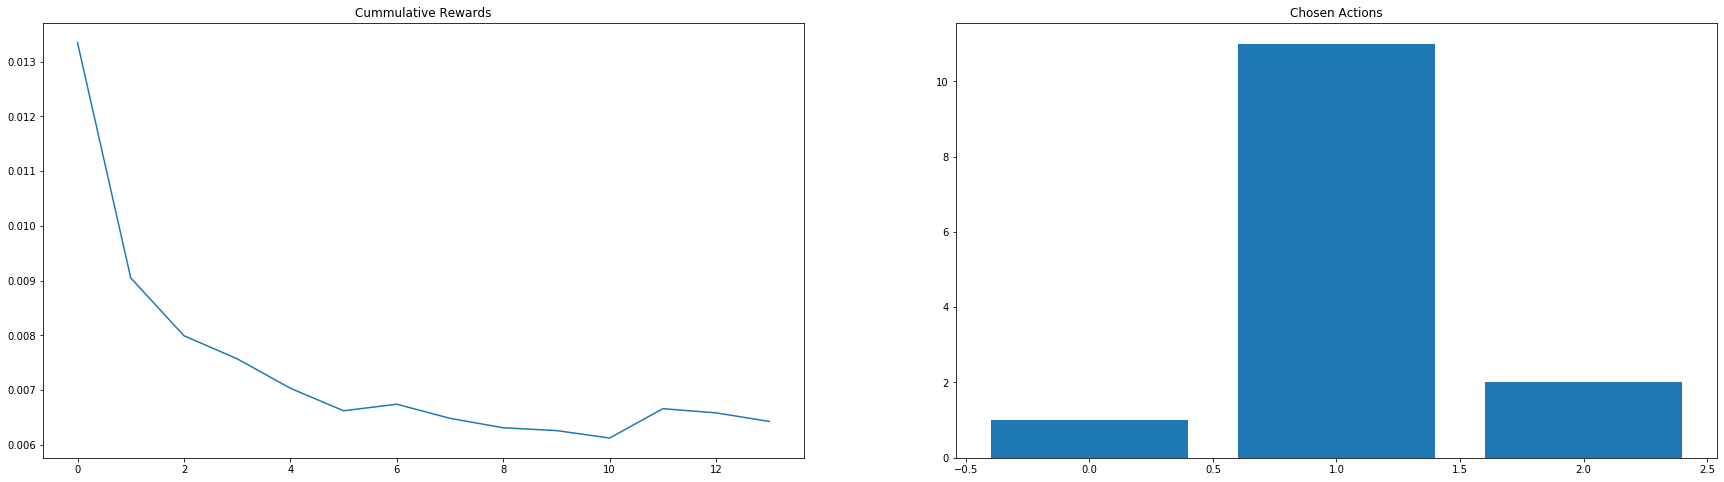

Restart at iteration: 834
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.0, 'merge_sort': 0.005357499999997974, 'heap_sort': 0.014315099999976155}
Count per chosen algo {'quick_sort': 0, 'merge_sort': 13, 'heap_sort': 1}


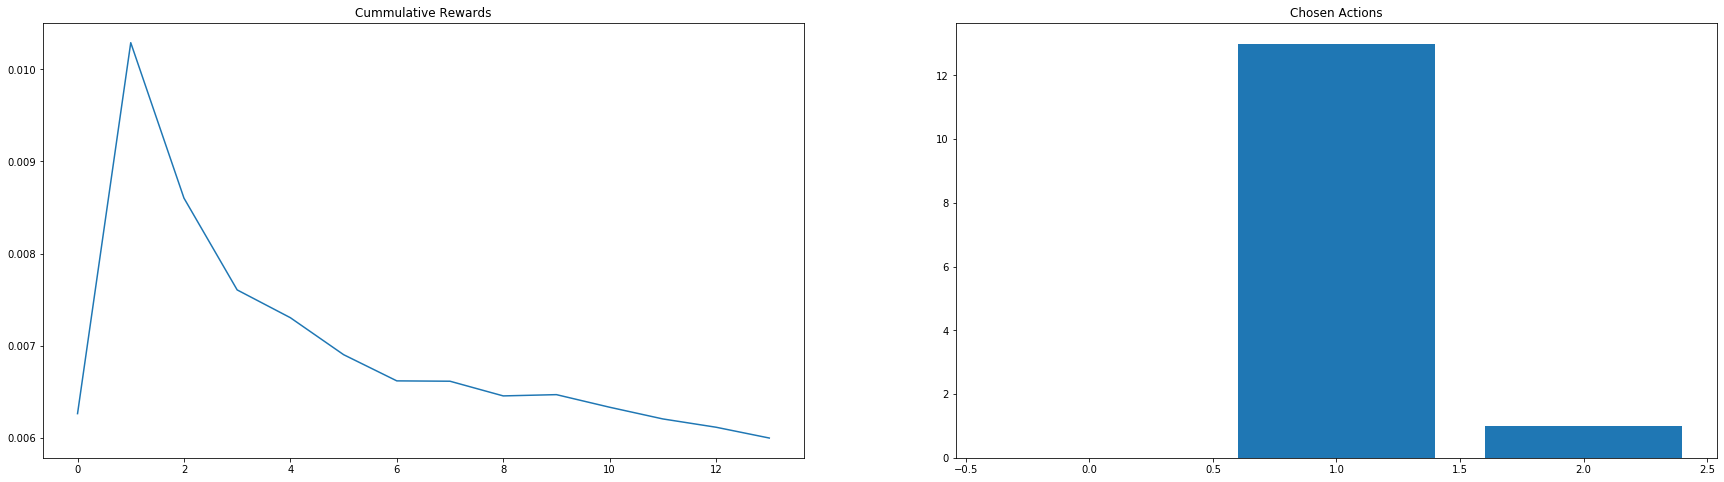

Restart at iteration: 867
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.006699233333354944, 'merge_sort': 0.004869499999983873, 'heap_sort': 0.012306733333237693}
Count per chosen algo {'quick_sort': 18, 'merge_sort': 12, 'heap_sort': 3}


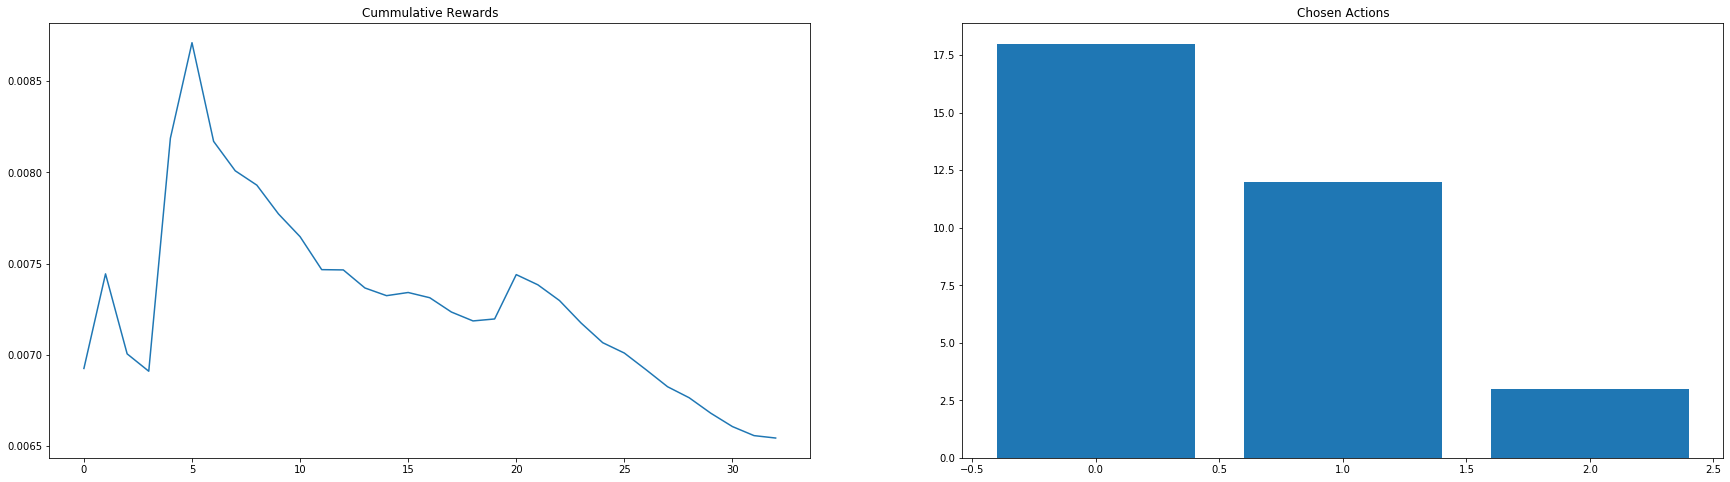

Restart at iteration: 879
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.0, 'merge_sort': 0.005139618181829064, 'heap_sort': 0.012285599999813712}
Count per chosen algo {'quick_sort': 0, 'merge_sort': 11, 'heap_sort': 1}


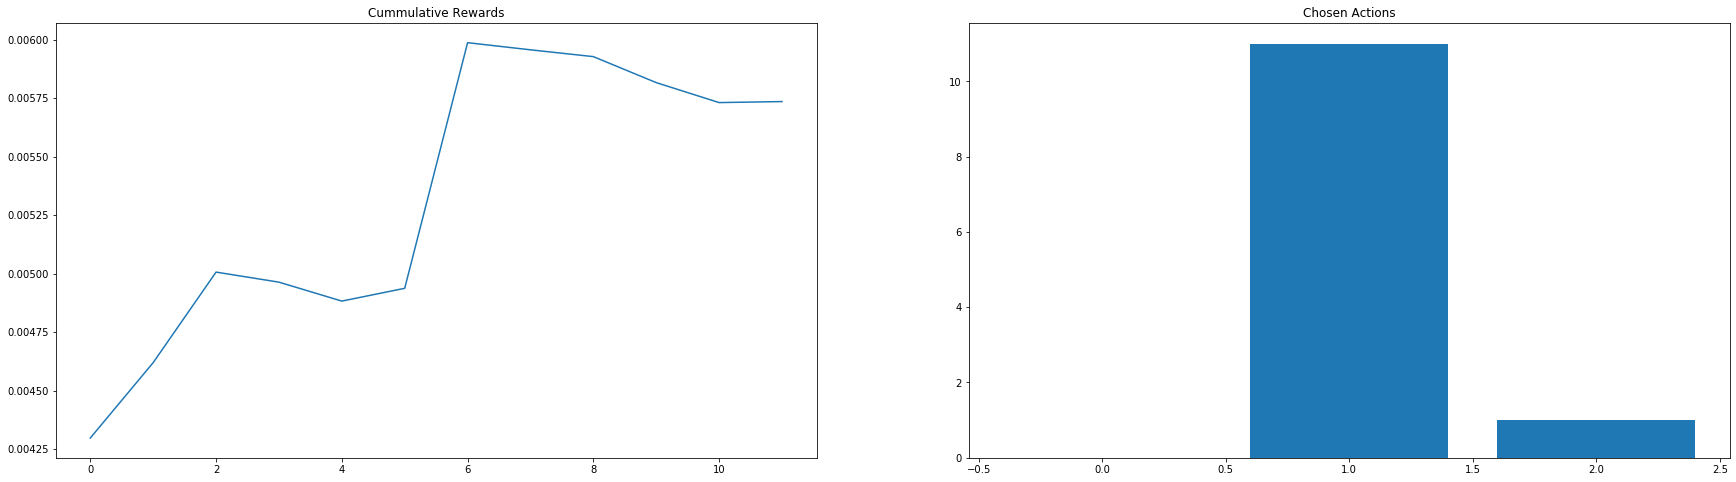

Restart at iteration: 895
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.0067484153846460405, 'merge_sort': 0.004331399999955465, 'heap_sort': 0.012277400000130001}
Count per chosen algo {'quick_sort': 13, 'merge_sort': 1, 'heap_sort': 2}


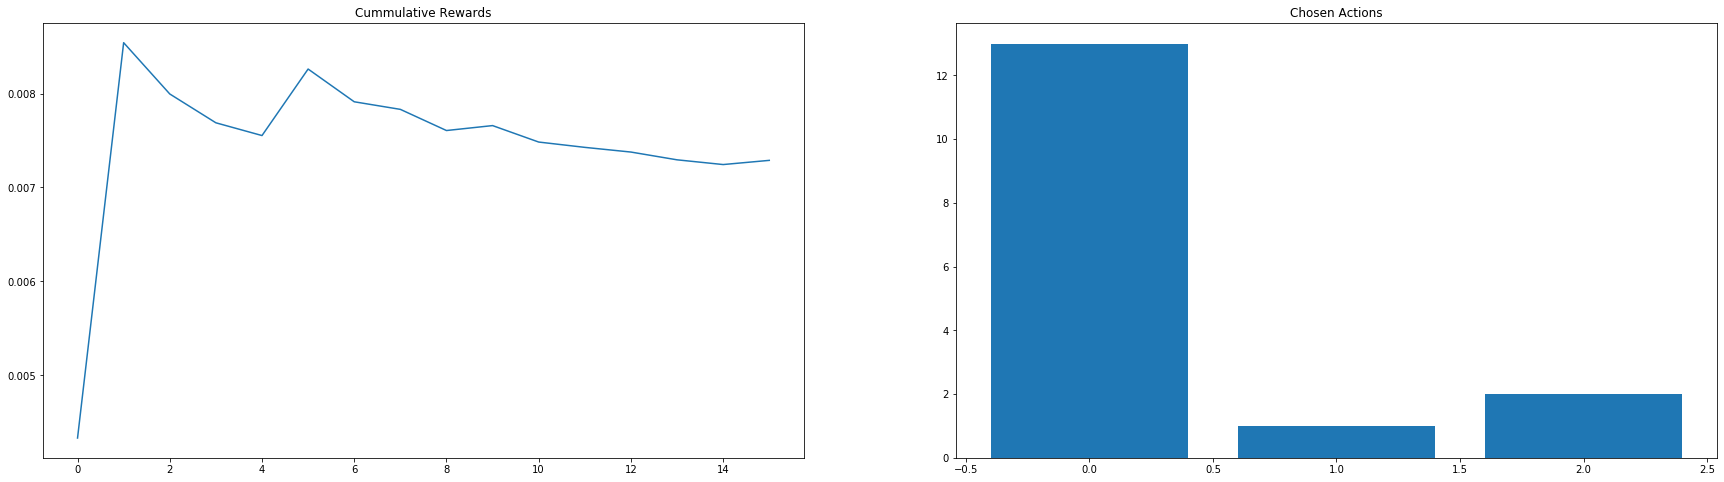

Restart at iteration: 920
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.006966600000055223, 'merge_sort': 0.00505994545456319, 'heap_sort': 0.012711649999999963}
Count per chosen algo {'quick_sort': 6, 'merge_sort': 11, 'heap_sort': 8}


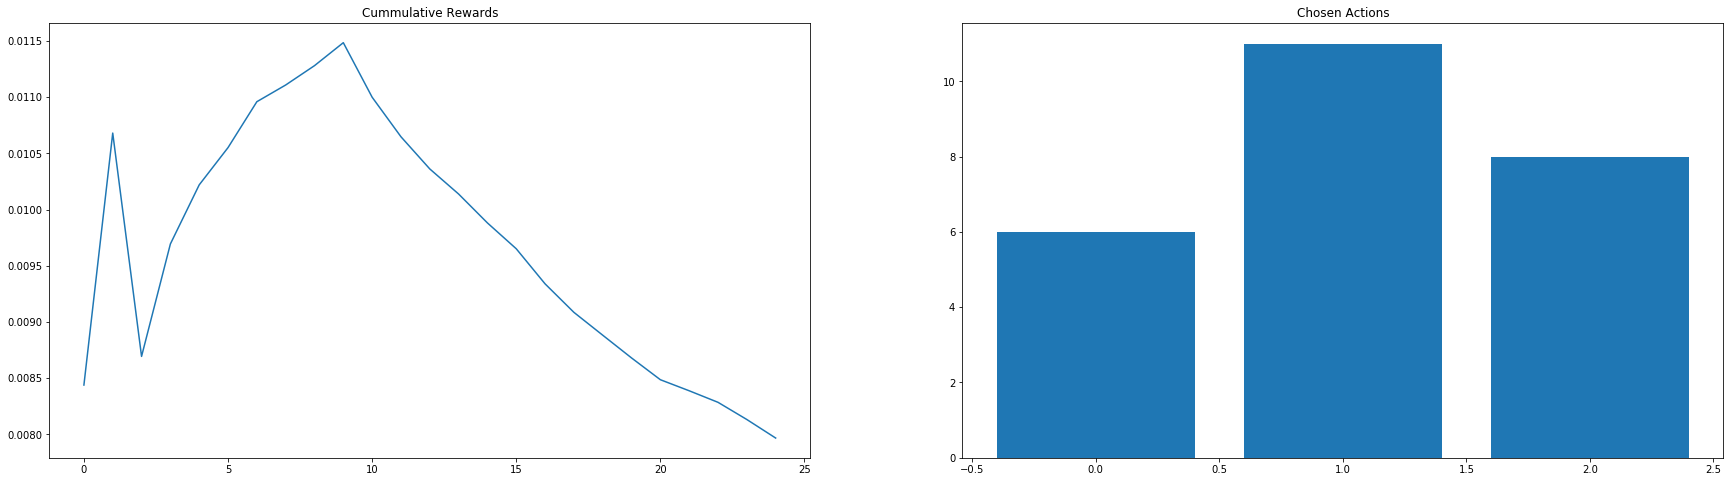

Restart at iteration: 953
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.006714516666647796, 'merge_sort': 0.004876192307707383, 'heap_sort': 0.012335600000028535}
Count per chosen algo {'quick_sort': 18, 'merge_sort': 13, 'heap_sort': 2}


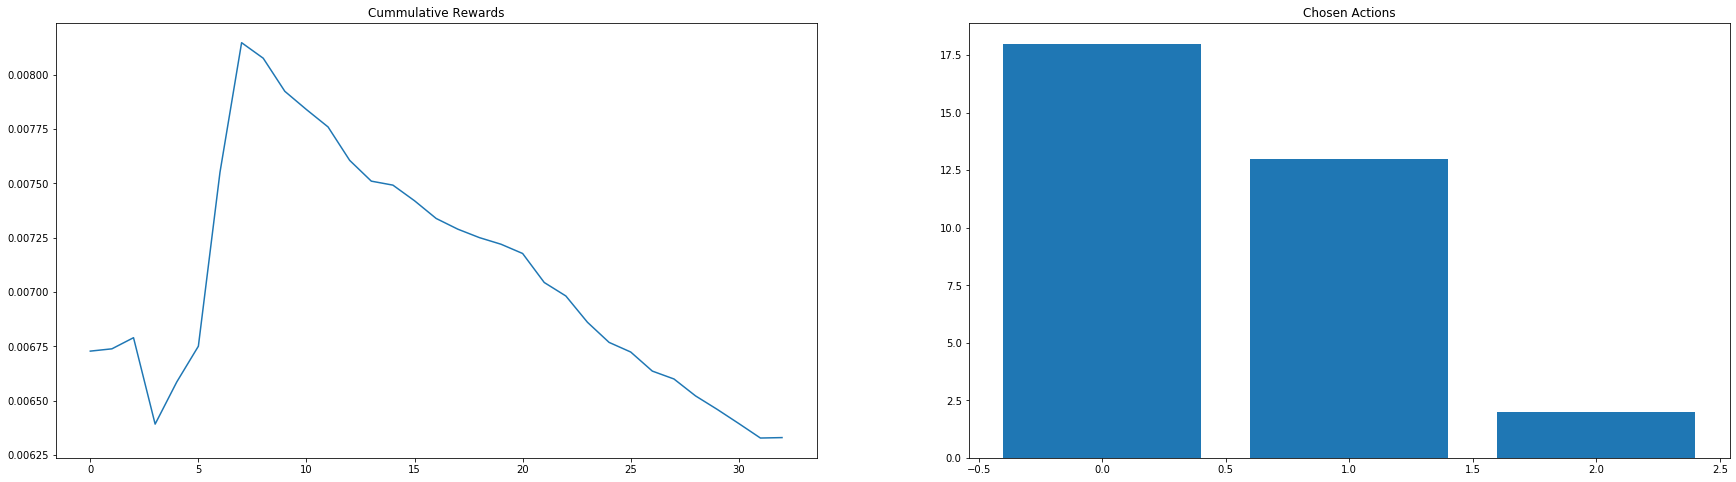

Restart at iteration: 970
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.006654506250029613, 'merge_sort': 0.0, 'heap_sort': 0.012676899999860325}
Count per chosen algo {'quick_sort': 16, 'merge_sort': 0, 'heap_sort': 1}


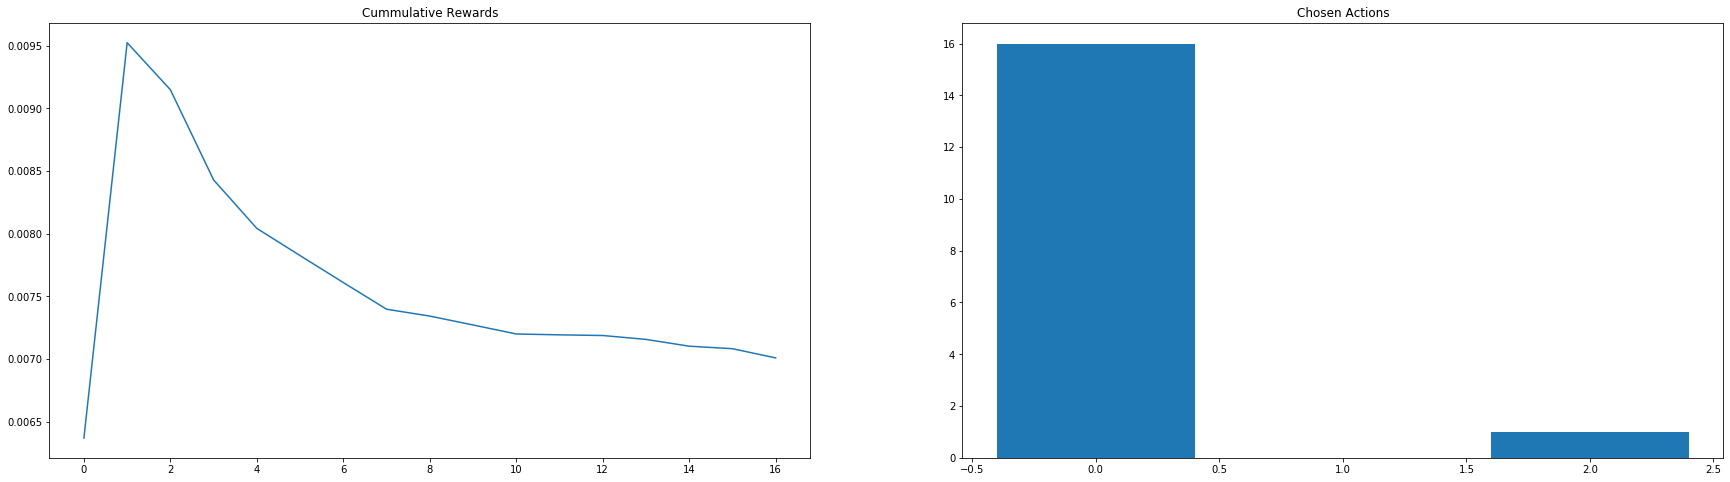

Restart at iteration: 991
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.006447710000031748, 'merge_sort': 0.0, 'heap_sort': 0.01257620000001225}
Count per chosen algo {'quick_sort': 20, 'merge_sort': 0, 'heap_sort': 1}


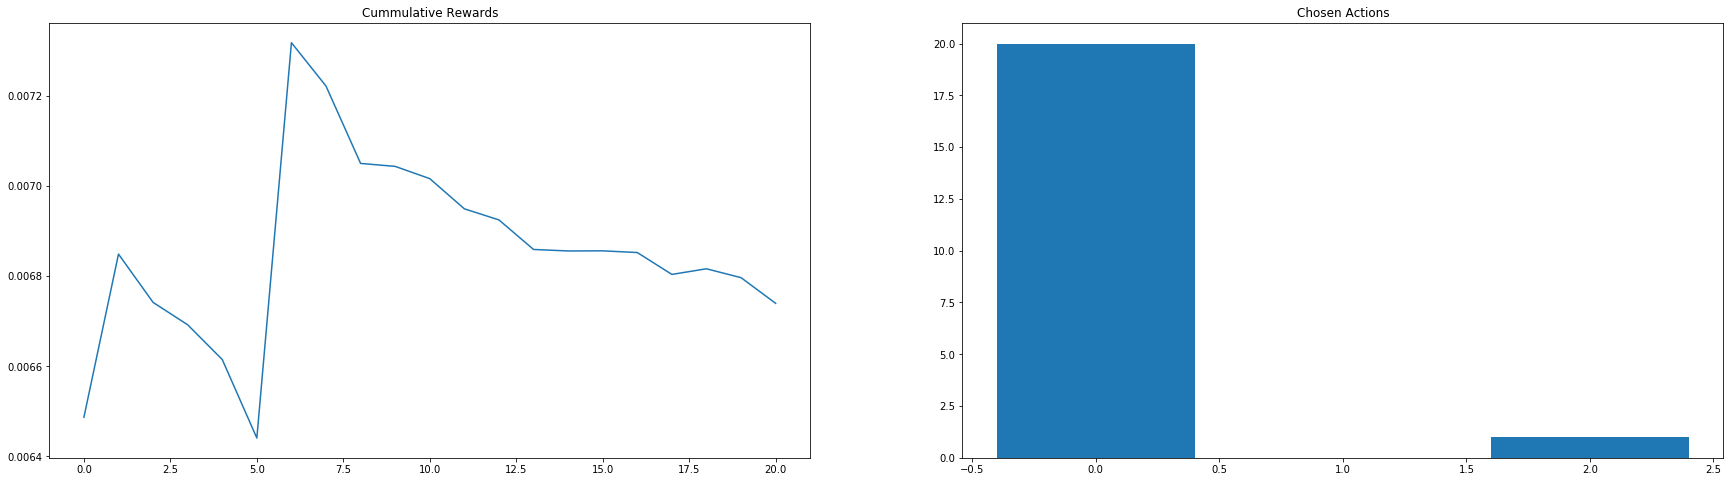

Restart at iteration: 1005
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.01006220833333297, 'merge_sort': 0.01620819999993728, 'heap_sort': 0.013154499999927793}
Count per chosen algo {'quick_sort': 12, 'merge_sort': 1, 'heap_sort': 1}


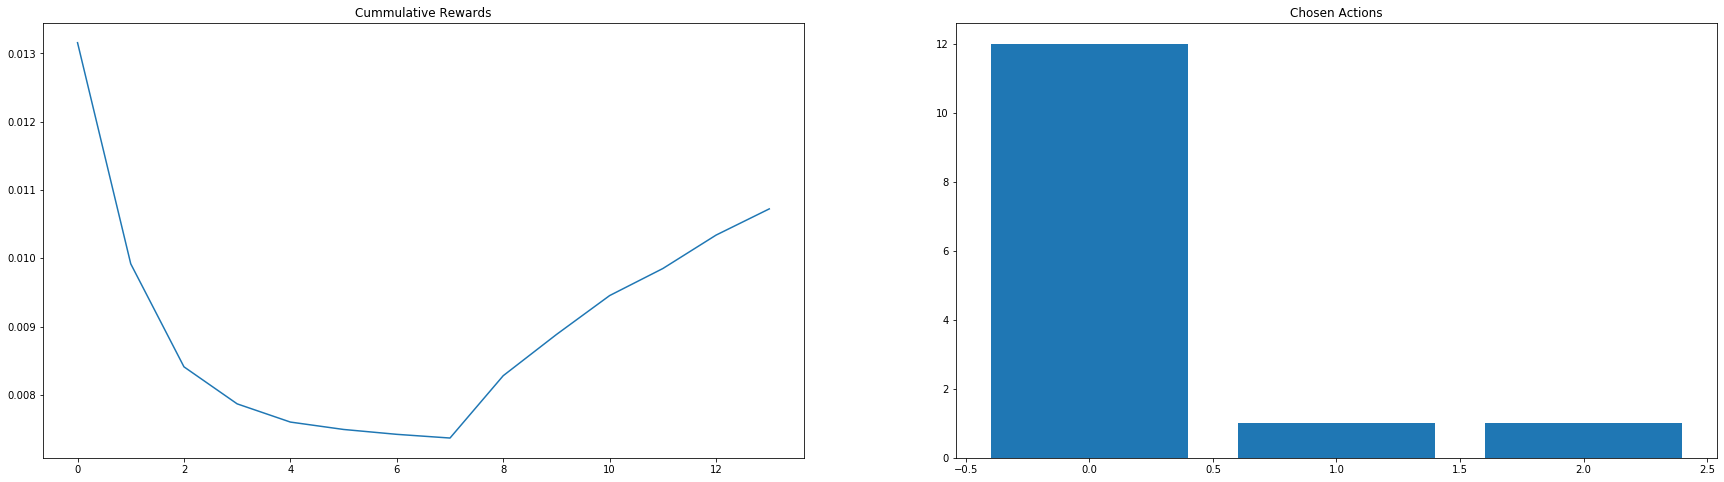

Restart at iteration: 1043
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.01459946060603987, 'merge_sort': 0.015766900000016904, 'heap_sort': 0.023937533333385847}
Count per chosen algo {'quick_sort': 33, 'merge_sort': 2, 'heap_sort': 3}


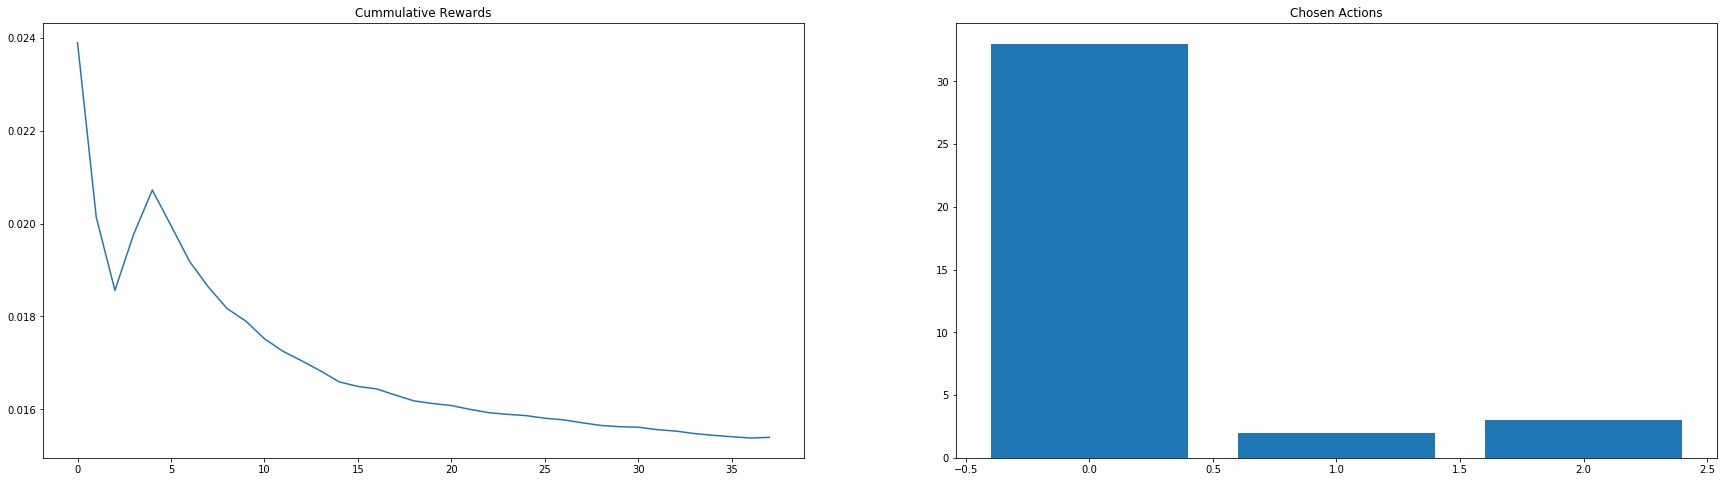

Restart at iteration: 1072
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.014584071428592844, 'merge_sort': 0.016376109999941945, 'heap_sort': 0.02385858000002372}
Count per chosen algo {'quick_sort': 14, 'merge_sort': 10, 'heap_sort': 5}


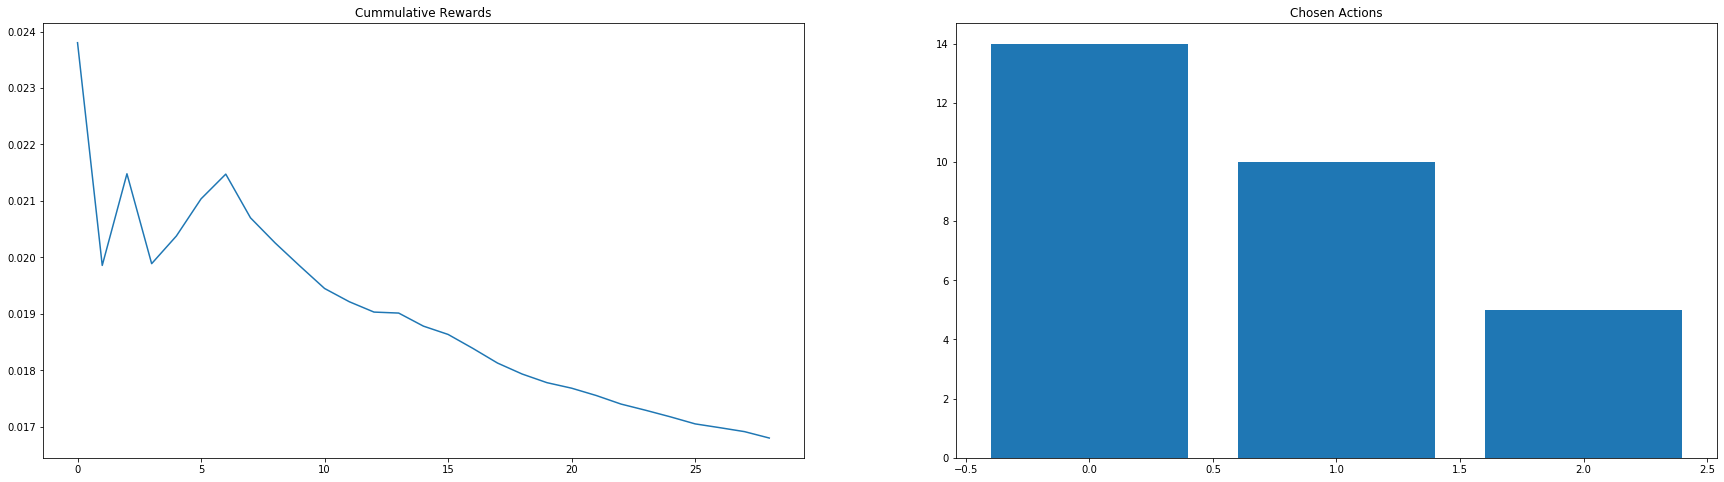

Restart at iteration: 1090
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.014670554545401419, 'merge_sort': 0.016673880000053033, 'heap_sort': 0.02319014999989122}
Count per chosen algo {'quick_sort': 11, 'merge_sort': 5, 'heap_sort': 2}


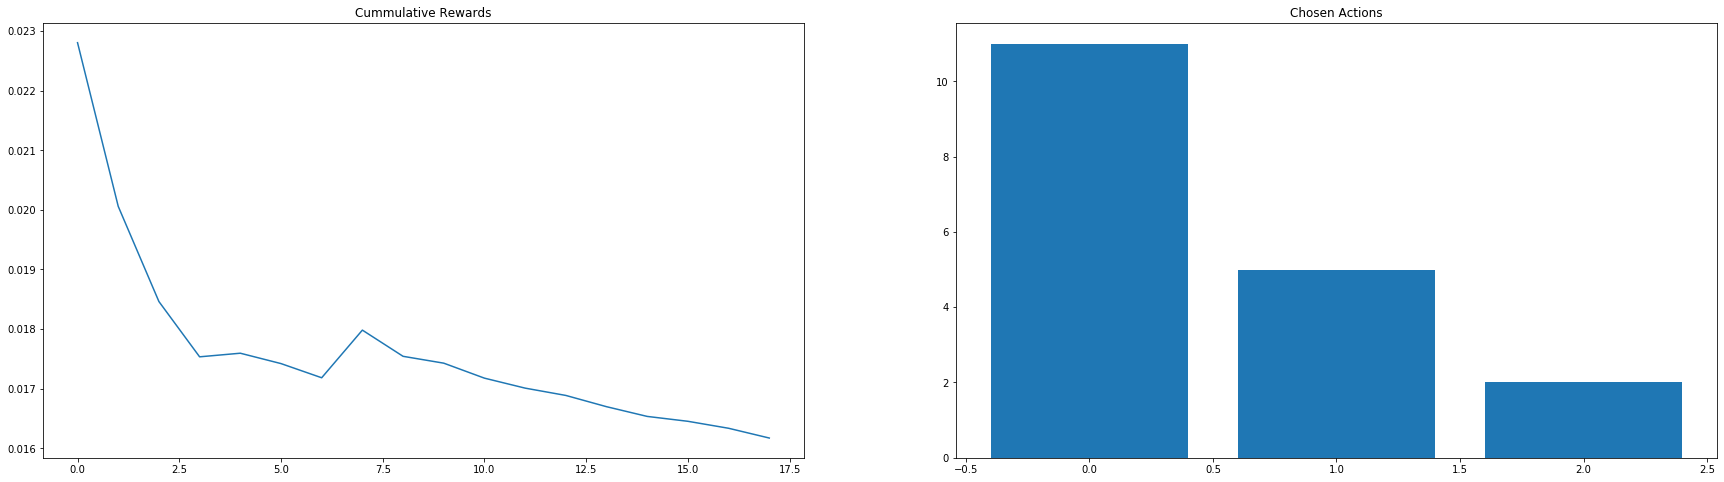

Restart at iteration: 1120
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.01468822400002864, 'merge_sort': 0.01582915000005869, 'heap_sort': 0.024240666666704175}
Count per chosen algo {'quick_sort': 25, 'merge_sort': 2, 'heap_sort': 3}


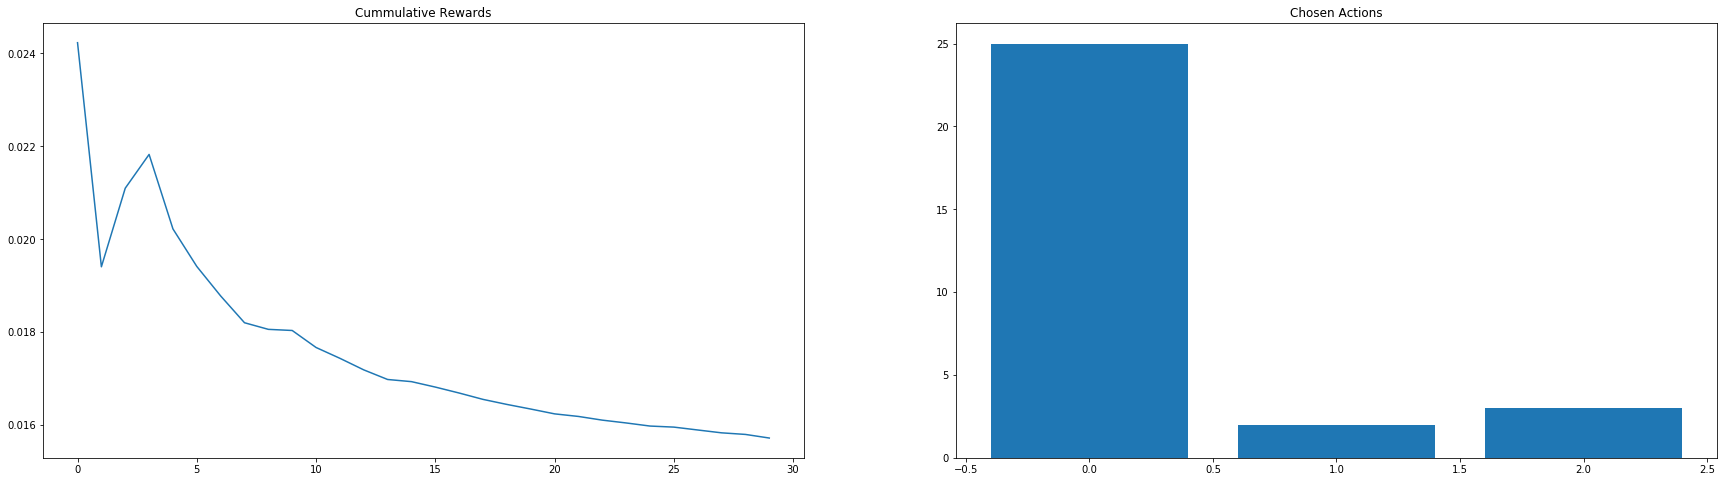

Restart at iteration: 1146
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.014328999999991408, 'merge_sort': 0.01633074999999735, 'heap_sort': 0.02424759999996695}
Count per chosen algo {'quick_sort': 14, 'merge_sort': 10, 'heap_sort': 2}


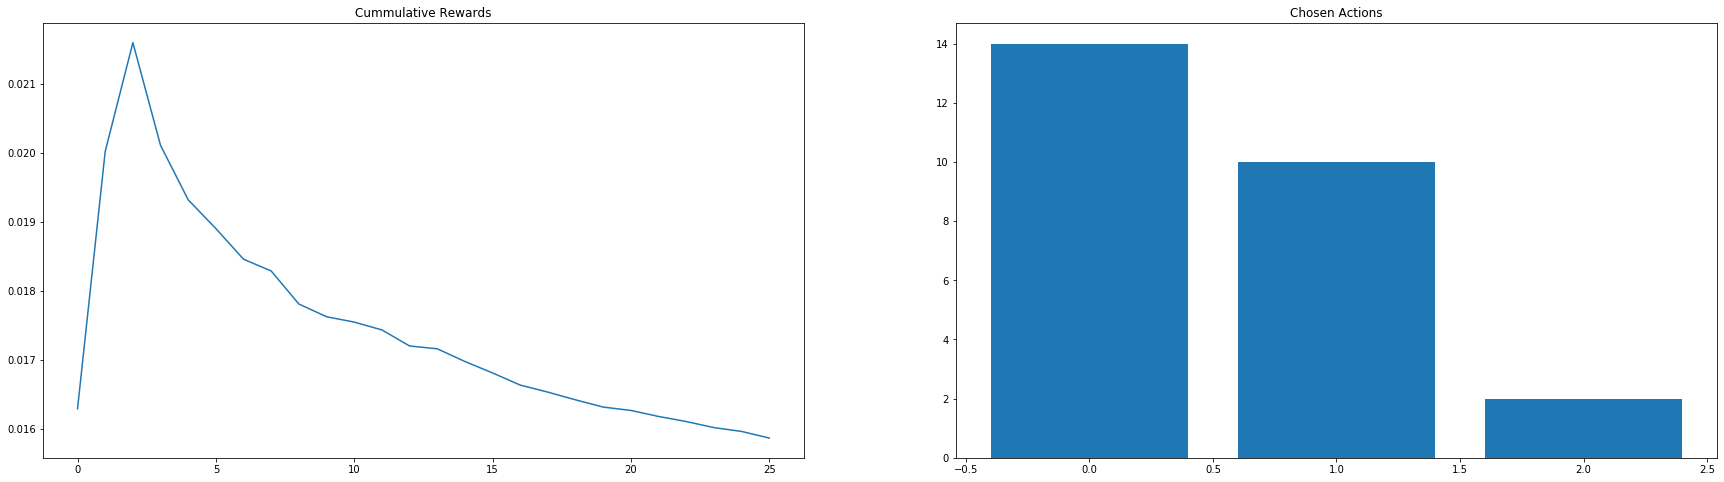

Restart at iteration: 1171
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.014922055000010915, 'merge_sort': 0.016457700000046316, 'heap_sort': 0.023296933333237273}
Count per chosen algo {'quick_sort': 20, 'merge_sort': 2, 'heap_sort': 3}


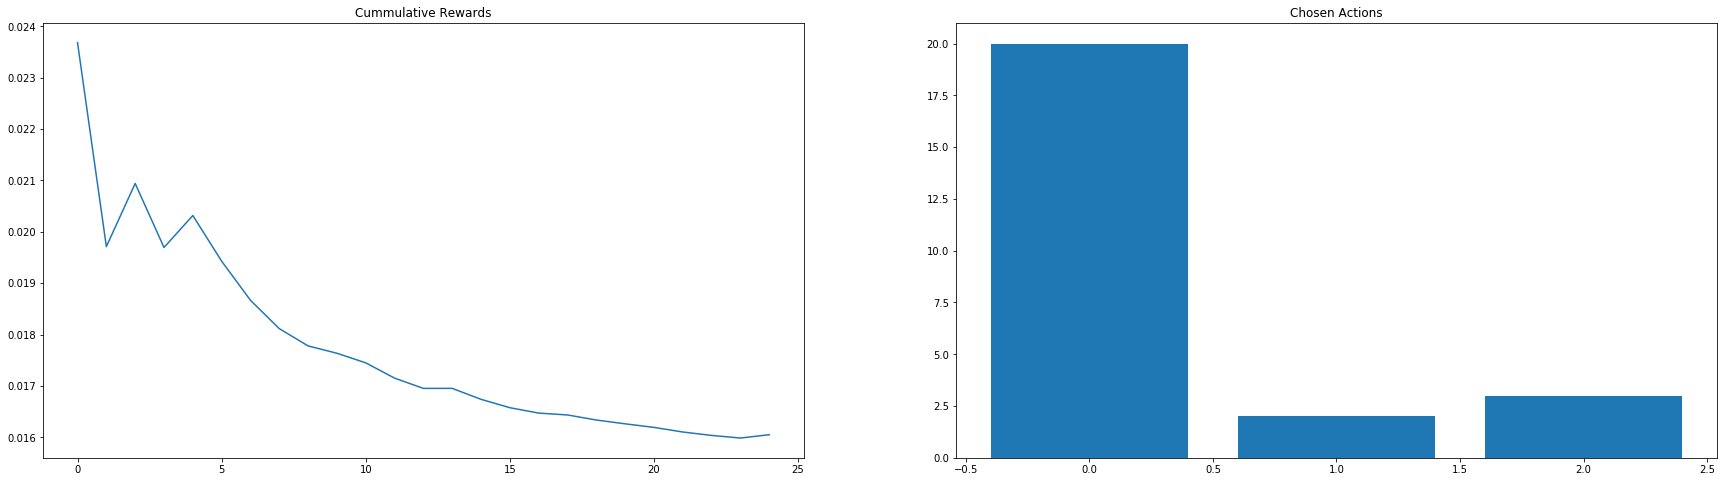

Restart at iteration: 1206
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.014561280769210217, 'merge_sort': 0.01621499999997208, 'heap_sort': 0.022899900000084017}
Count per chosen algo {'quick_sort': 26, 'merge_sort': 7, 'heap_sort': 2}


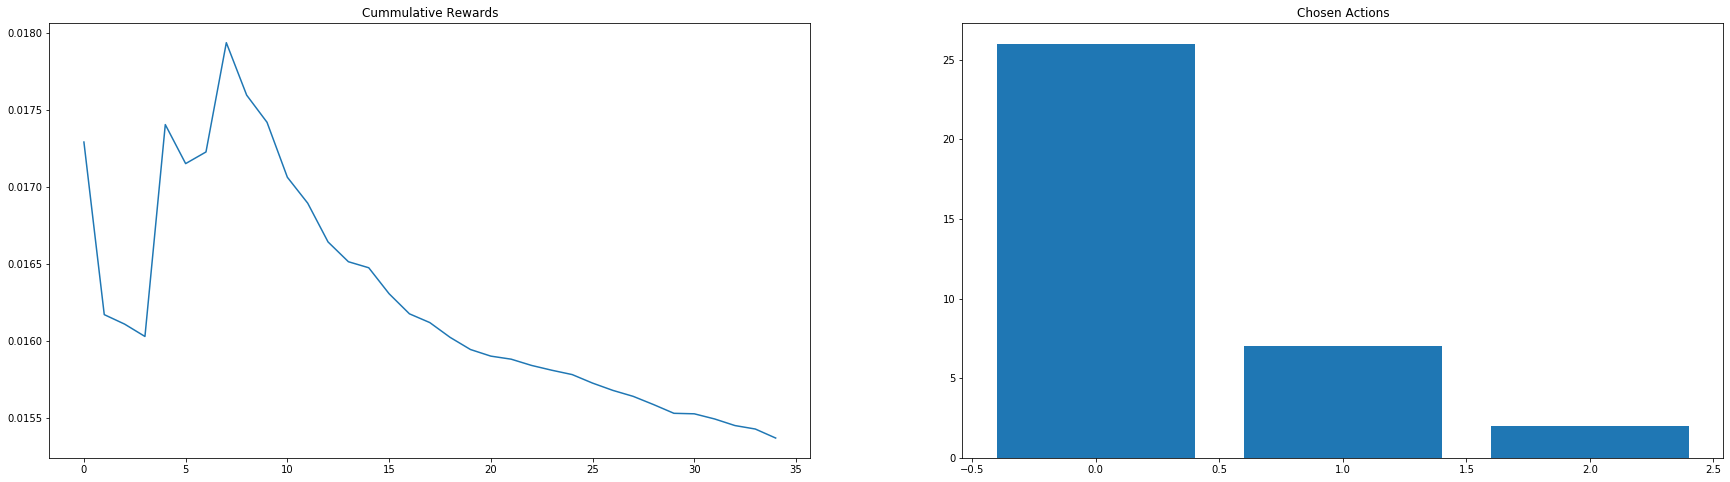

Restart at iteration: 1222
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.01465508333338524, 'merge_sort': 0.015999599999986458, 'heap_sort': 0.024024000000054002}
Count per chosen algo {'quick_sort': 12, 'merge_sort': 1, 'heap_sort': 3}


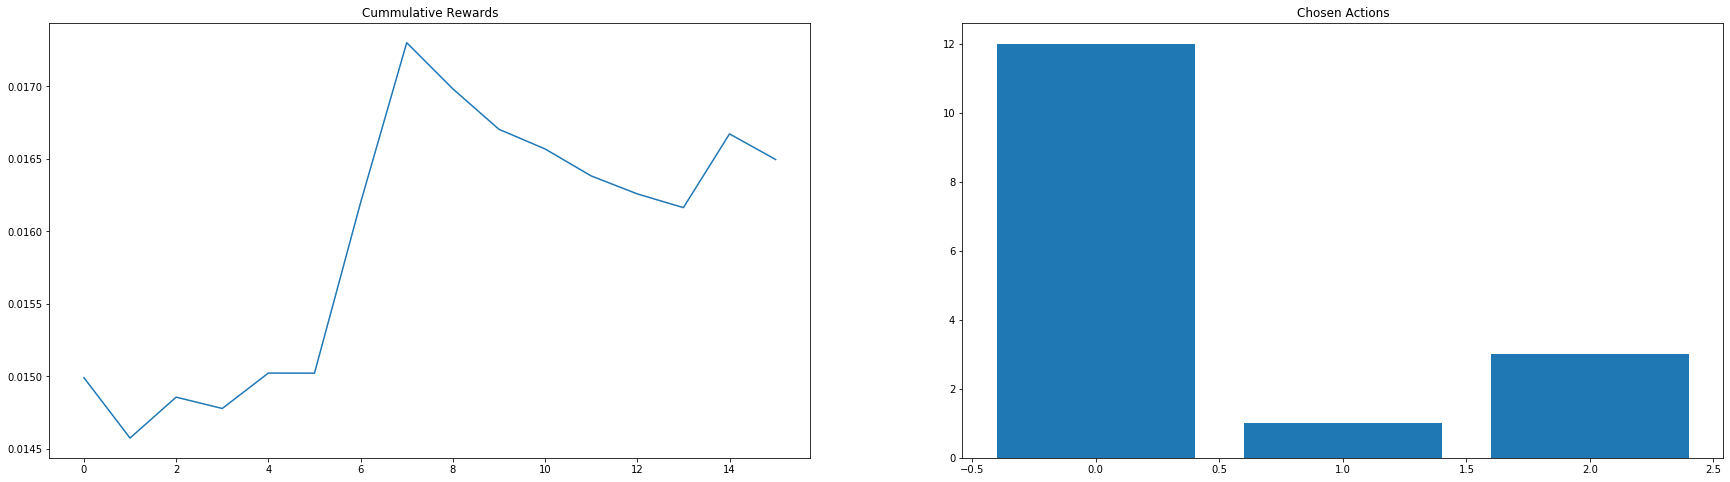

Restart at iteration: 1239
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.014963000000079774, 'merge_sort': 0.016881036363615334, 'heap_sort': 0.0240611600000193}
Count per chosen algo {'quick_sort': 1, 'merge_sort': 11, 'heap_sort': 5}


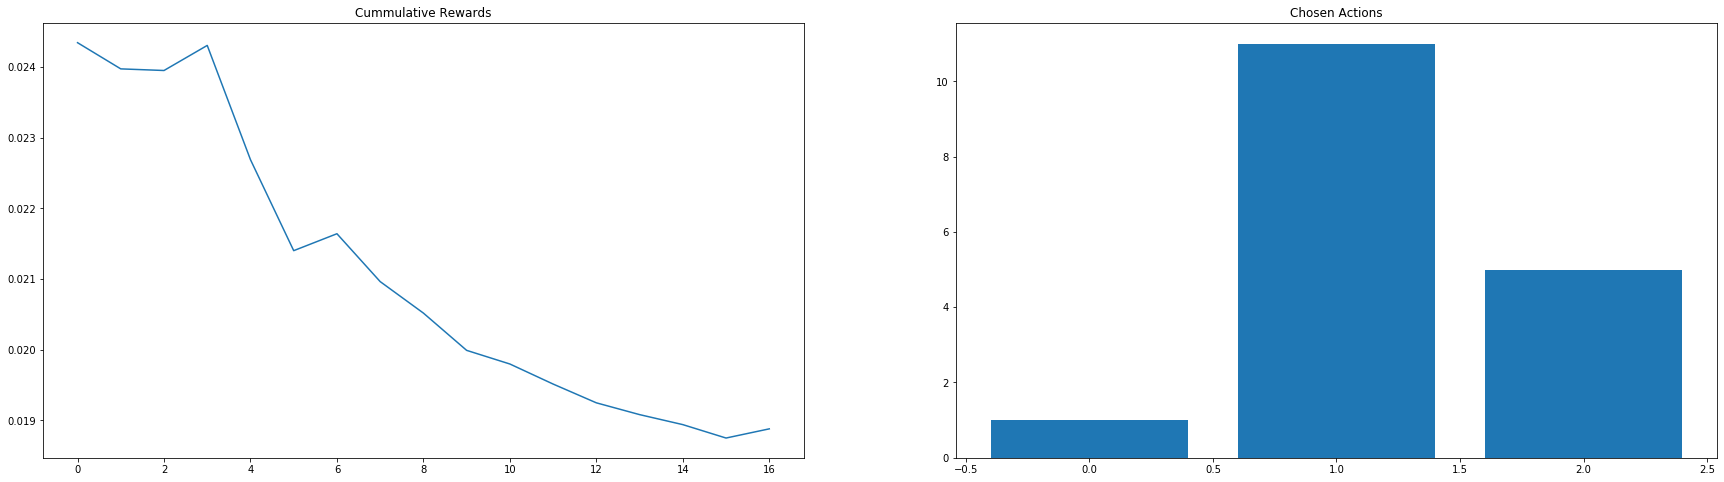

Restart at iteration: 1255
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.014832991666689091, 'merge_sort': 0.016606700000011188, 'heap_sort': 0.023058249999962754}
Count per chosen algo {'quick_sort': 12, 'merge_sort': 2, 'heap_sort': 2}


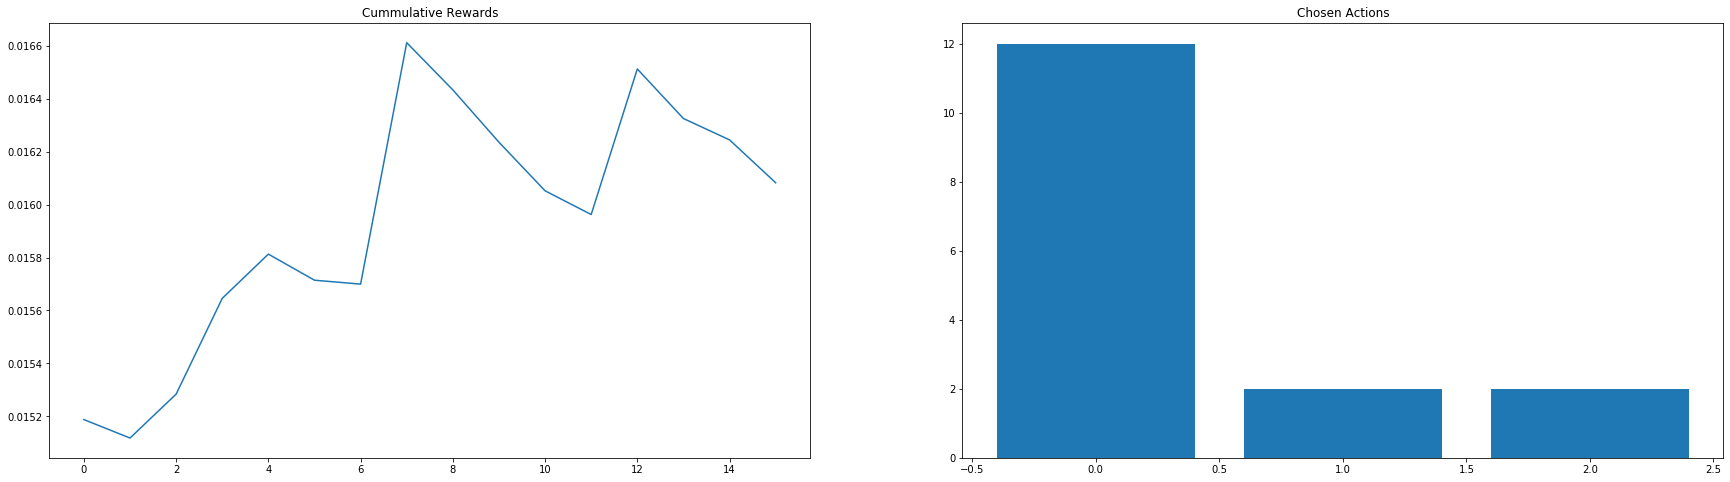

Restart at iteration: 1272
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.014548341666663115, 'merge_sort': 0.015929700000090936, 'heap_sort': 0.023402400000009038}
Count per chosen algo {'quick_sort': 12, 'merge_sort': 3, 'heap_sort': 2}


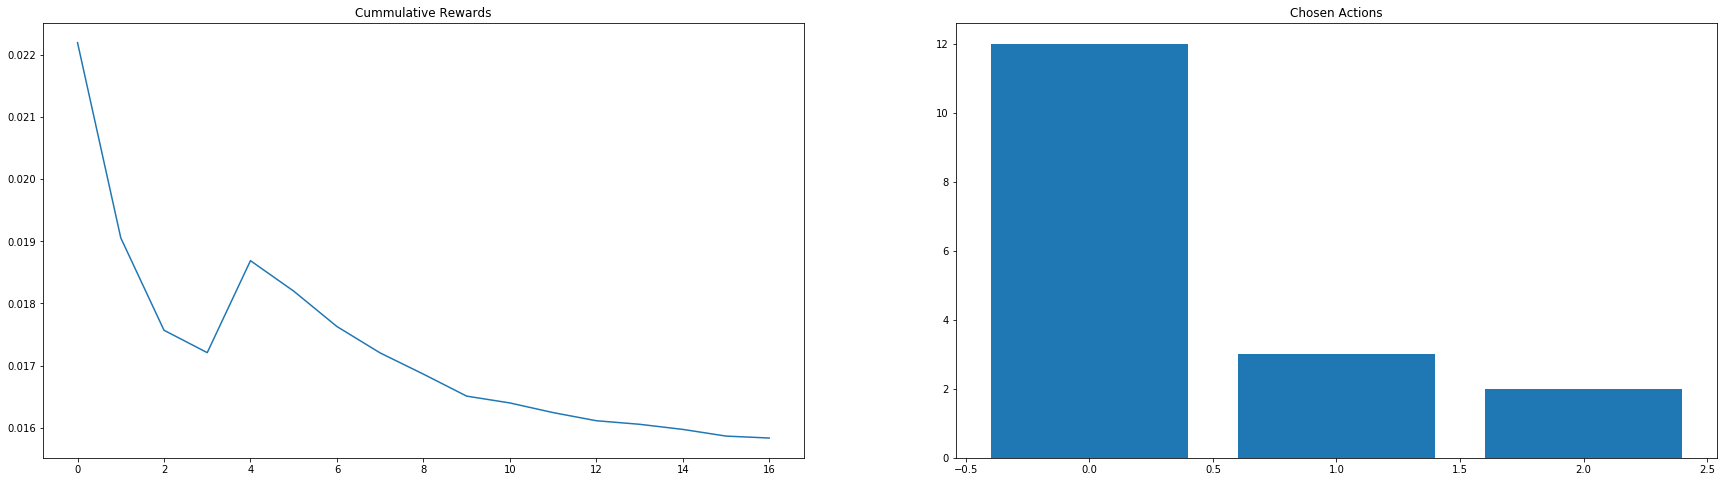

Restart at iteration: 1295
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.014825331249980422, 'merge_sort': 0.015879799999993338, 'heap_sort': 0.023778949999950783}
Count per chosen algo {'quick_sort': 16, 'merge_sort': 1, 'heap_sort': 6}


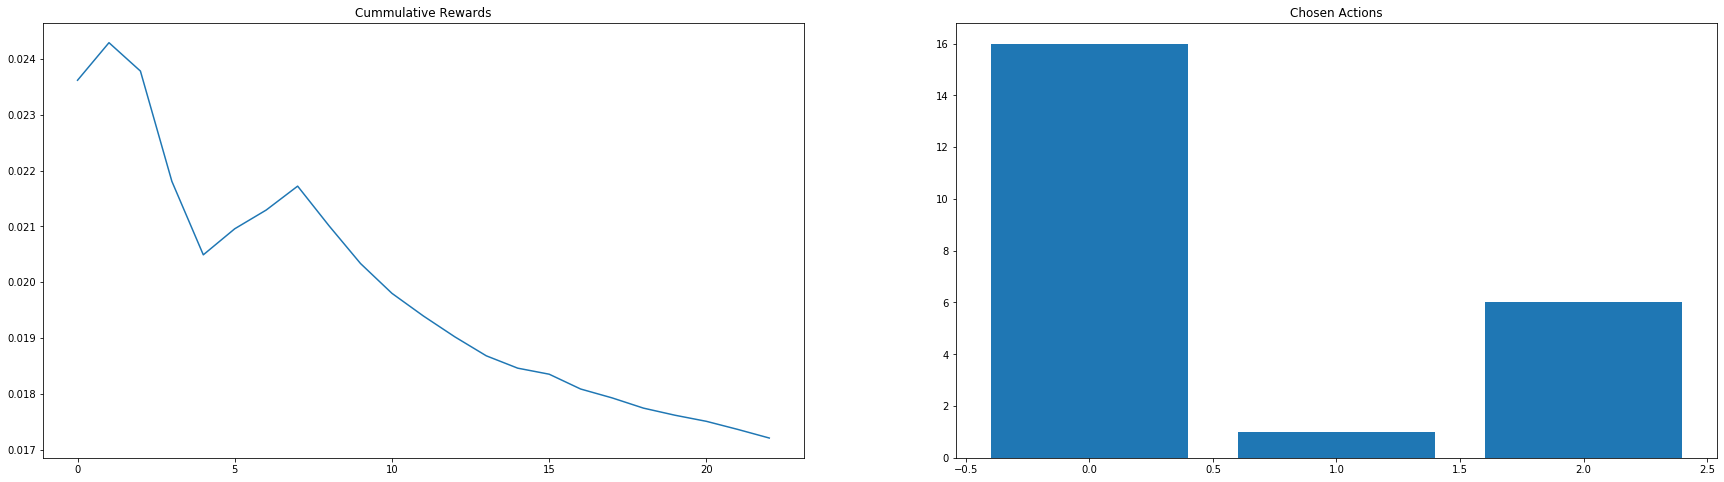

Restart at iteration: 1312
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.014789624999991702, 'merge_sort': 0.01611553333335299, 'heap_sort': 0.023861799999963296}
Count per chosen algo {'quick_sort': 12, 'merge_sort': 3, 'heap_sort': 2}


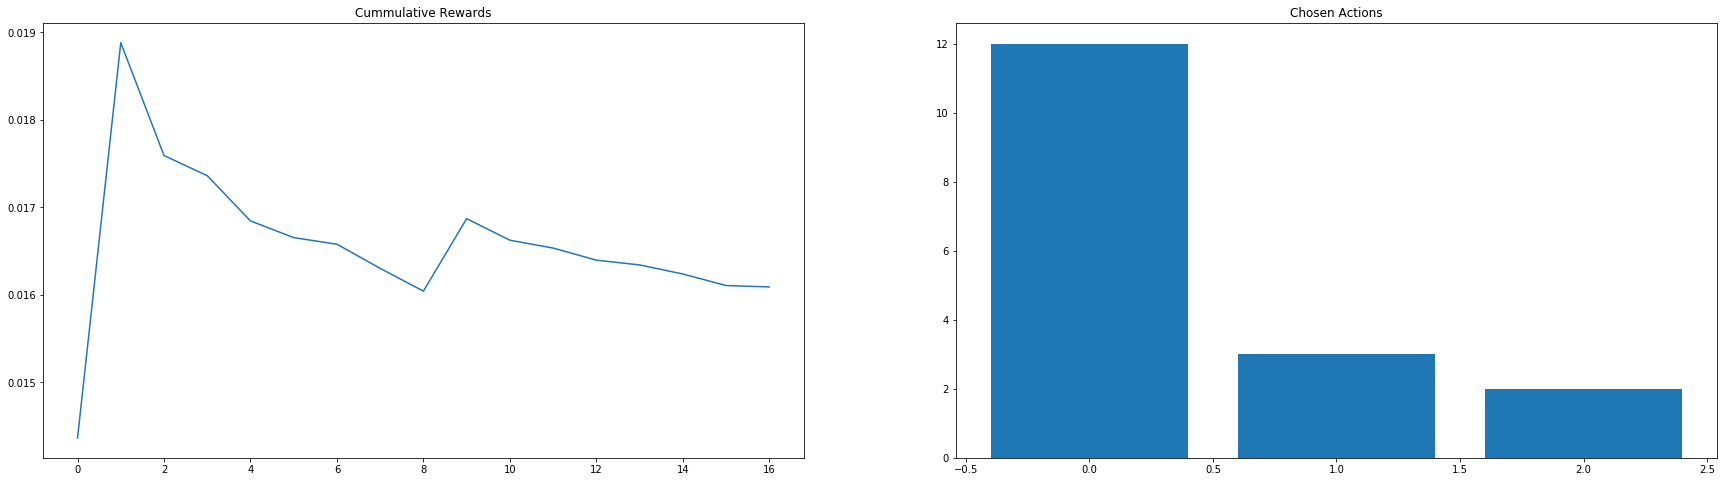

Restart at iteration: 1334
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.014801192857183716, 'merge_sort': 0.017140019999987998, 'heap_sort': 0.02380329999997836}
Count per chosen algo {'quick_sort': 14, 'merge_sort': 5, 'heap_sort': 3}


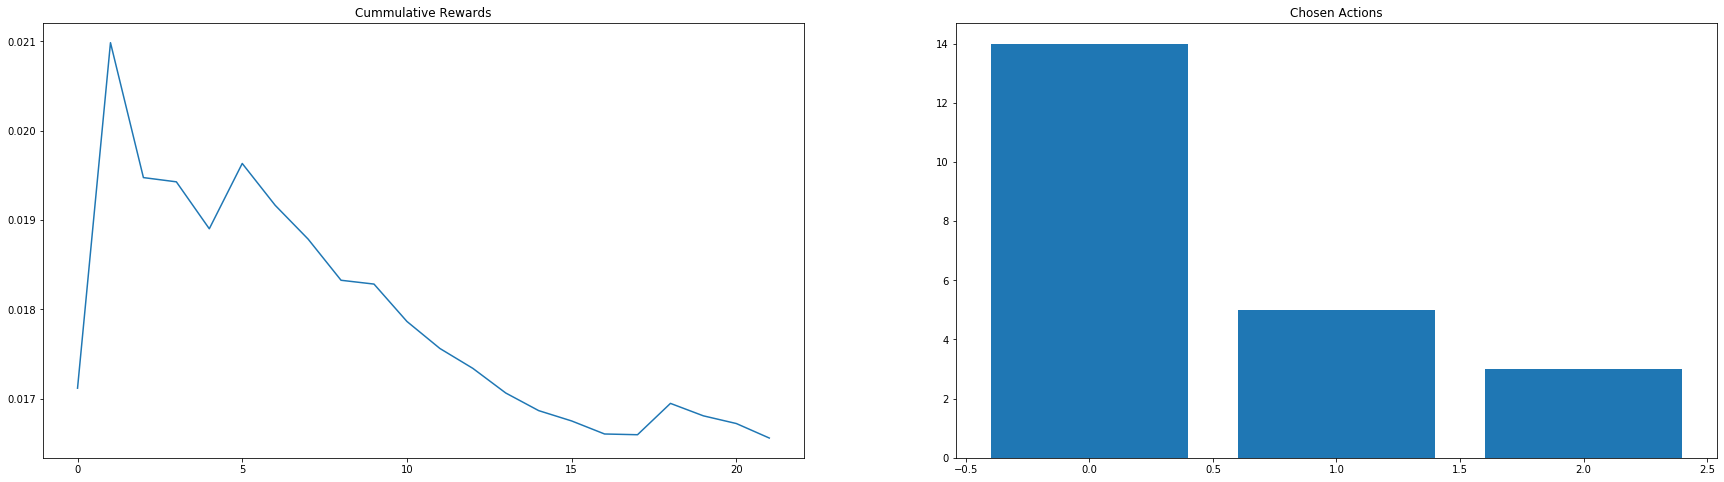

Restart at iteration: 1365
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.014779373913054018, 'merge_sort': 0.01605198333337891, 'heap_sort': 0.023292850000075305}
Count per chosen algo {'quick_sort': 23, 'merge_sort': 6, 'heap_sort': 2}


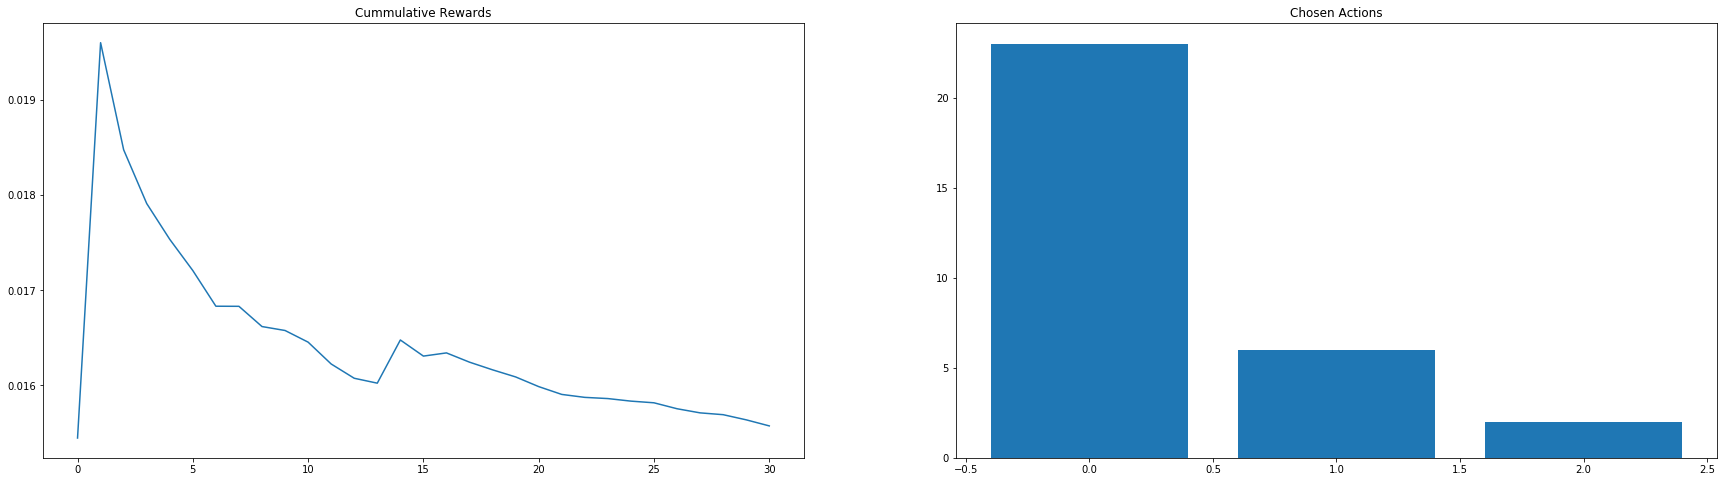

Restart at iteration: 1380
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.014786009090957205, 'merge_sort': 0.015868149999960224, 'heap_sort': 0.023522049999883166}
Count per chosen algo {'quick_sort': 11, 'merge_sort': 2, 'heap_sort': 2}


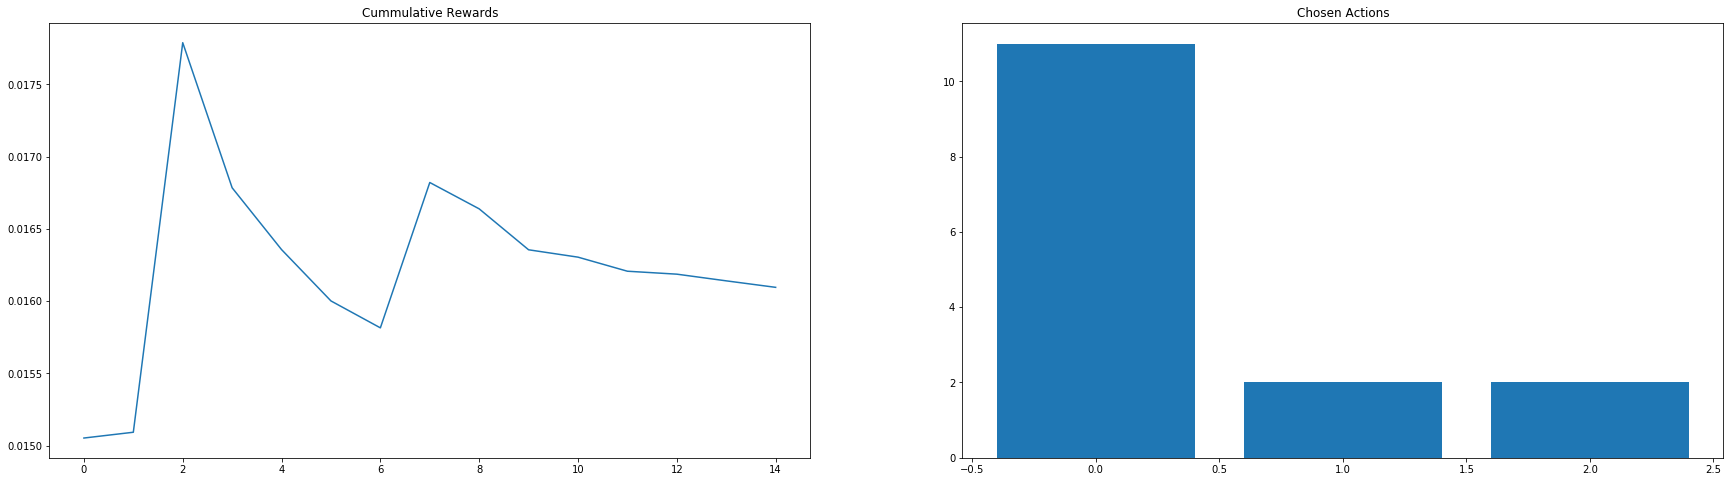

Restart at iteration: 1404
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.014371473684222062, 'merge_sort': 0.01609690000009323, 'heap_sort': 0.02425285000003896}
Count per chosen algo {'quick_sort': 19, 'merge_sort': 3, 'heap_sort': 2}


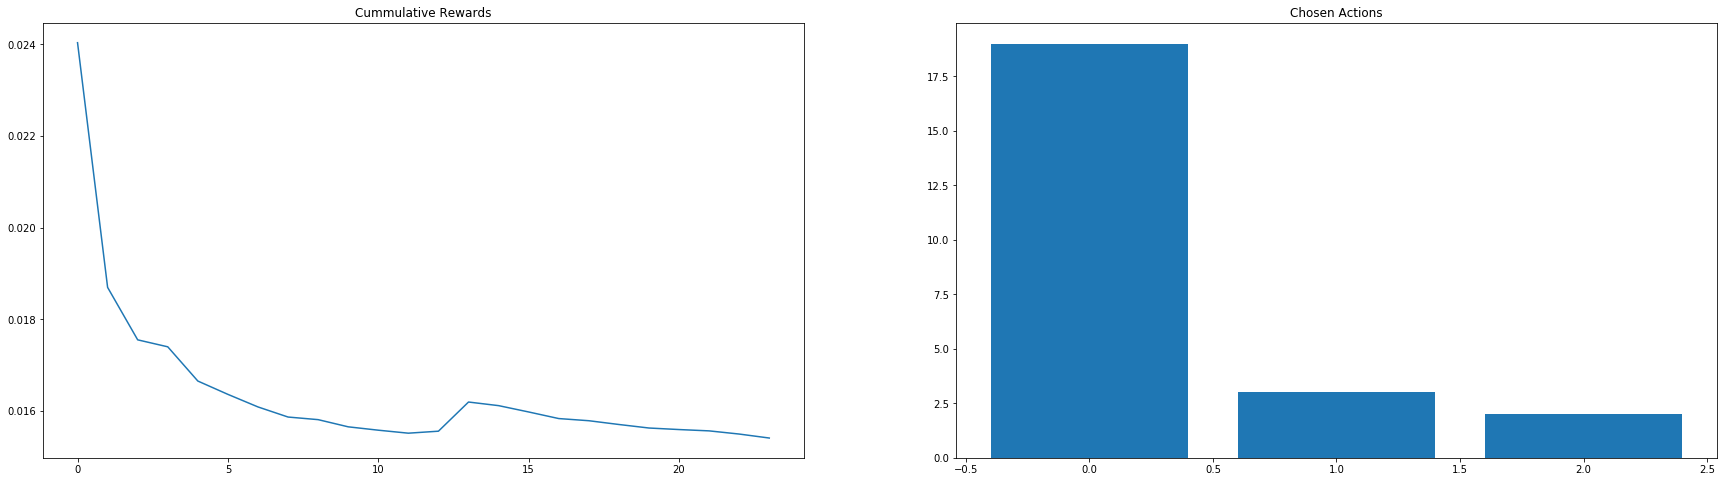

Restart at iteration: 1437
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.014721421052603259, 'merge_sort': 0.015770791666663325, 'heap_sort': 0.02375670000003538}
Count per chosen algo {'quick_sort': 19, 'merge_sort': 12, 'heap_sort': 2}


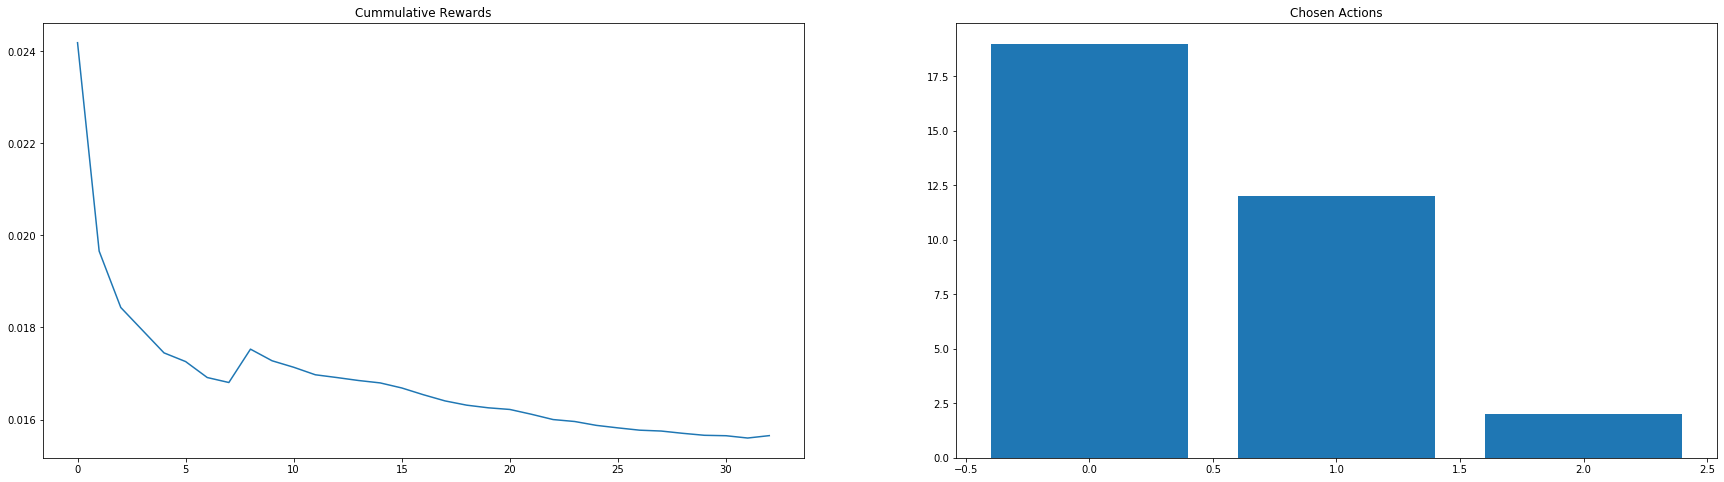

Restart at iteration: 1459
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.014794953846166418, 'merge_sort': 0.017086299999846233, 'heap_sort': 0.0234432624999954}
Count per chosen algo {'quick_sort': 13, 'merge_sort': 1, 'heap_sort': 8}


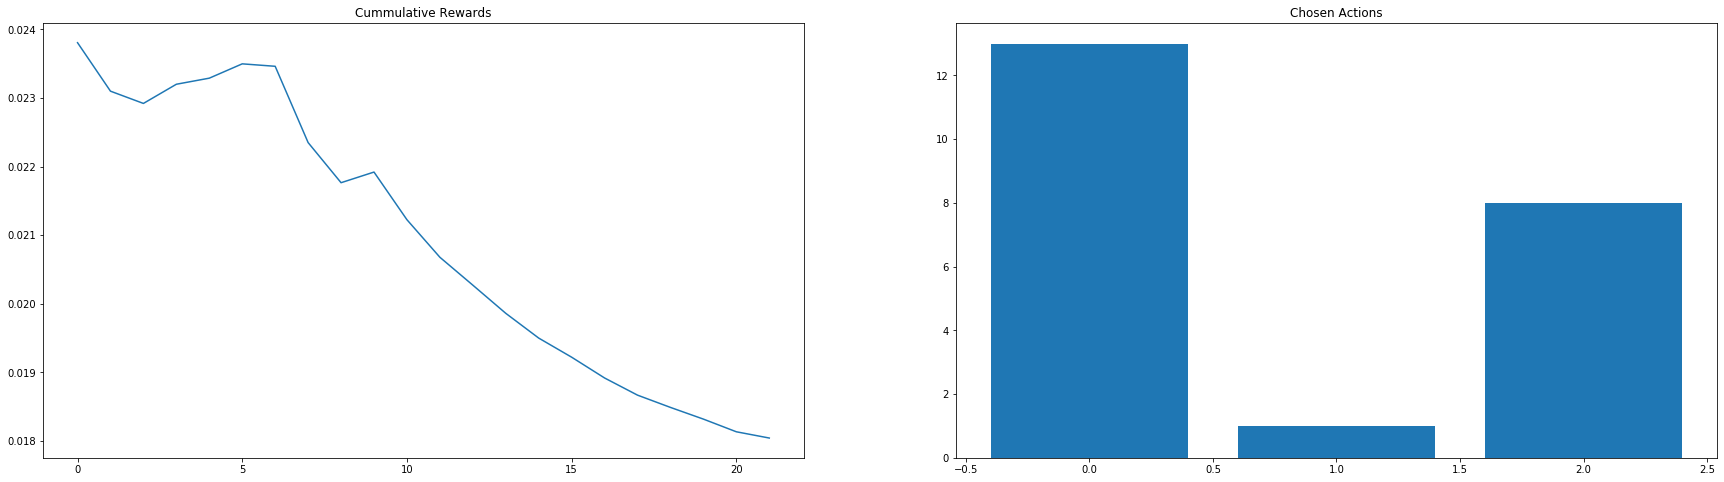

Restart at iteration: 1479
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.01493455384614278, 'merge_sort': 0.016383520000044883, 'heap_sort': 0.023757499999987886}
Count per chosen algo {'quick_sort': 13, 'merge_sort': 5, 'heap_sort': 2}


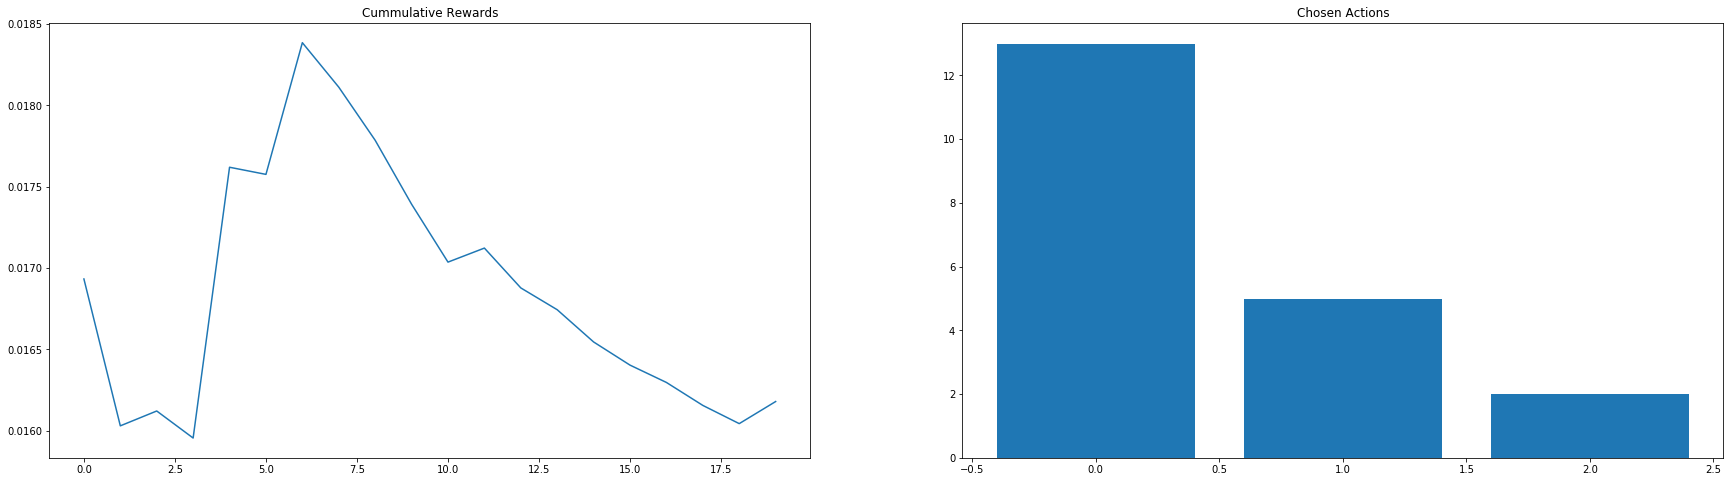

Restart at iteration: 1494
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.014588799999997222, 'merge_sort': 0.015589050000016869, 'heap_sort': 0.023400500000093416}
Count per chosen algo {'quick_sort': 11, 'merge_sort': 2, 'heap_sort': 2}


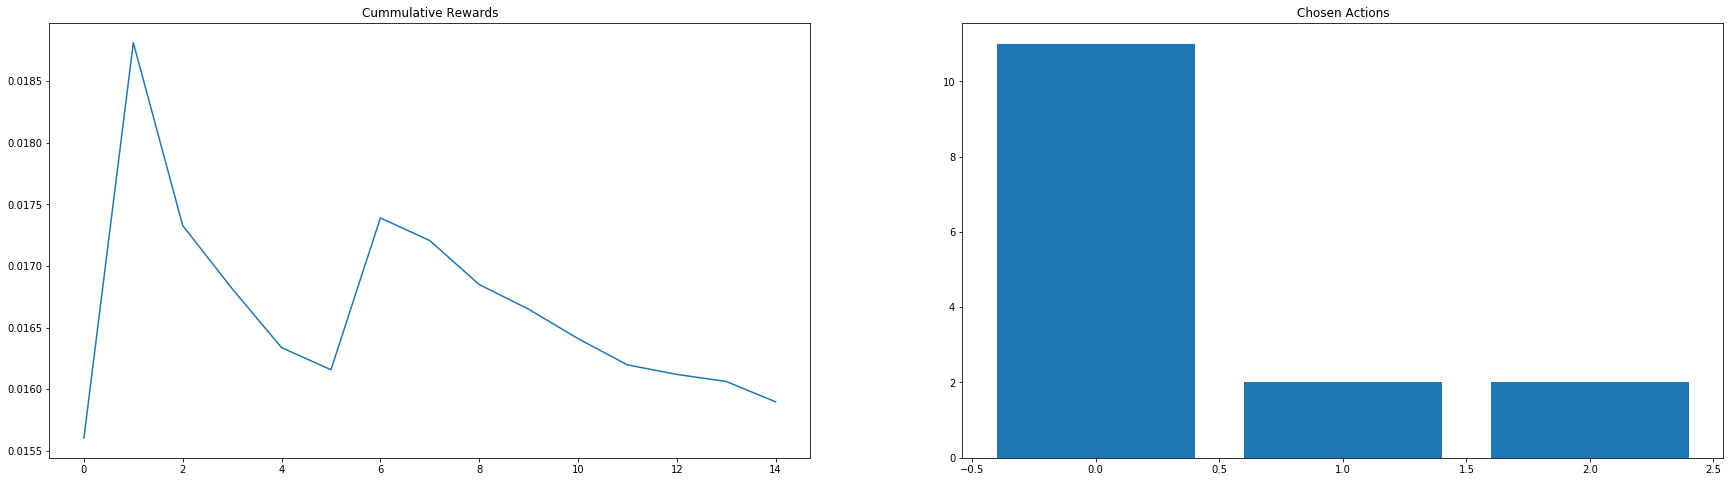

Restart at iteration: 1508
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.015137899999899673, 'merge_sort': 0.005092999999988024, 'heap_sort': 0.0162971833333548}
Count per chosen algo {'quick_sort': 1, 'merge_sort': 1, 'heap_sort': 12}


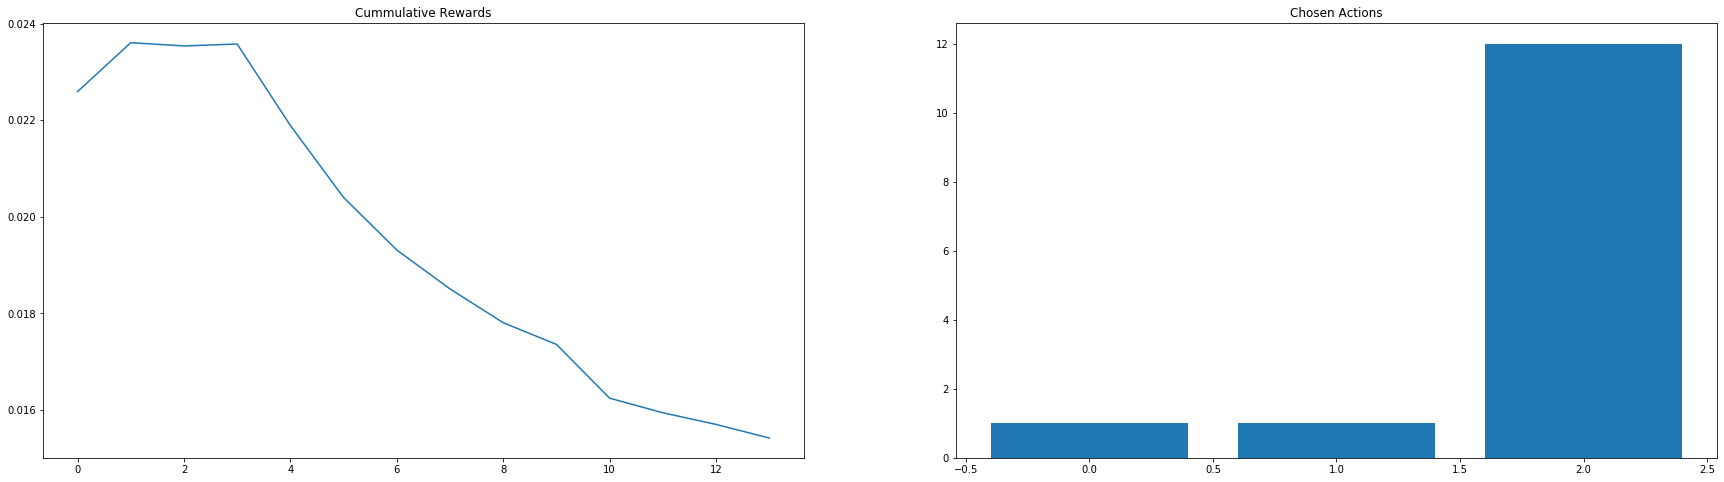

Restart at iteration: 1526
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.007080275000078018, 'merge_sort': 0.005537927272743301, 'heap_sort': 0.013407566666728599}
Count per chosen algo {'quick_sort': 4, 'merge_sort': 11, 'heap_sort': 3}


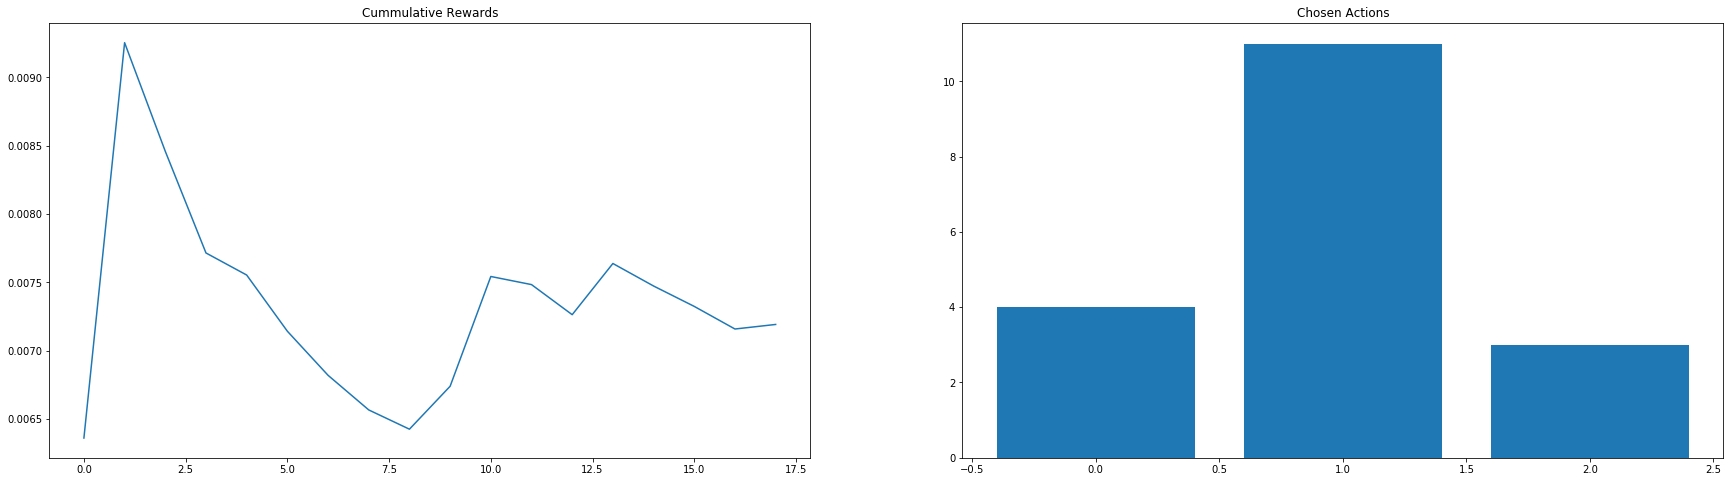

Restart at iteration: 1541
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.006722949999974455, 'merge_sort': 0.0, 'heap_sort': 0.012853599999971266}
Count per chosen algo {'quick_sort': 14, 'merge_sort': 0, 'heap_sort': 1}


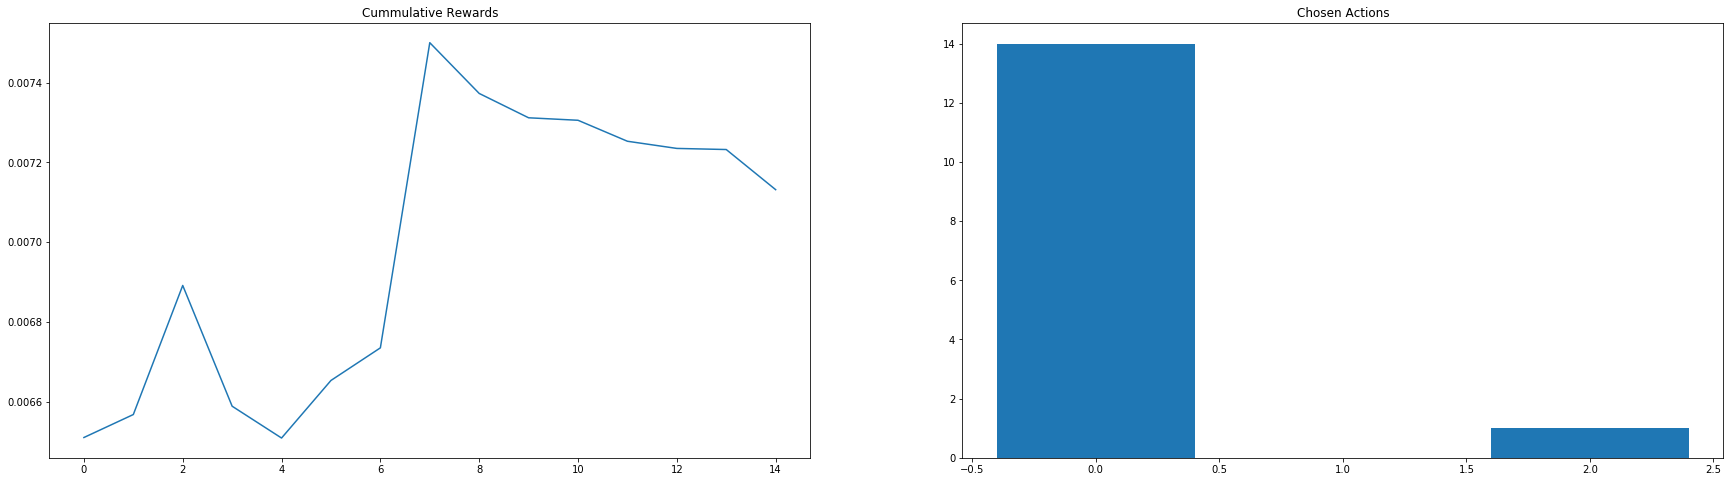

Restart at iteration: 1556
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.0067853999998988, 'merge_sort': 0.005227200000018246, 'heap_sort': 0.013082400000030248}
Count per chosen algo {'quick_sort': 1, 'merge_sort': 13, 'heap_sort': 1}


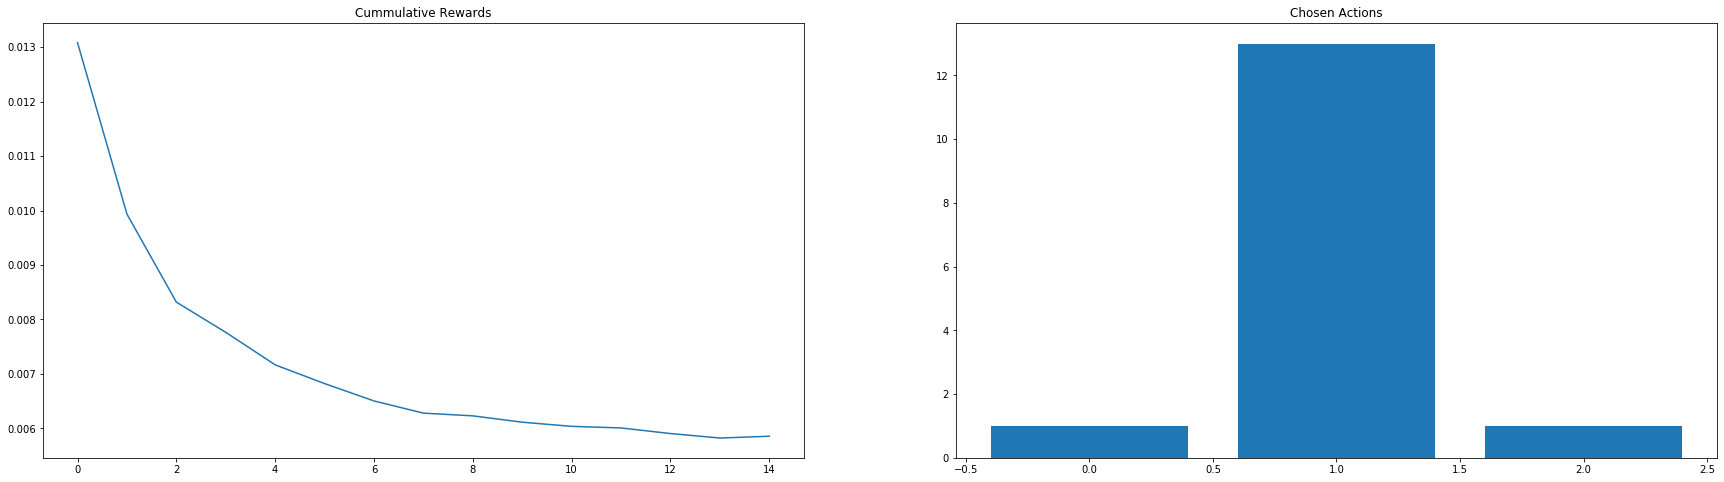

Restart at iteration: 1570
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.006941818181799549, 'merge_sort': 0.00406299999986004, 'heap_sort': 0.012736599999925602}
Count per chosen algo {'quick_sort': 11, 'merge_sort': 1, 'heap_sort': 2}


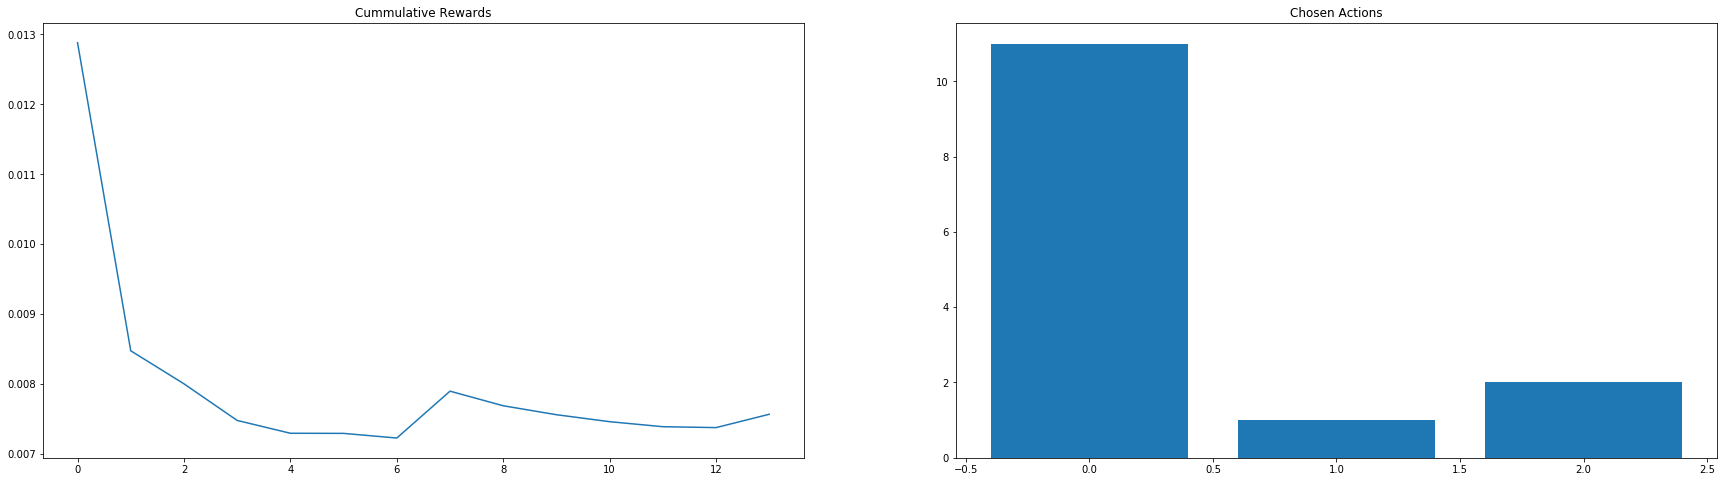

Restart at iteration: 1632
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.006607000000030894, 'merge_sort': 0.005102626785734239, 'heap_sort': 0.013170833333333576}
Count per chosen algo {'quick_sort': 3, 'merge_sort': 56, 'heap_sort': 3}


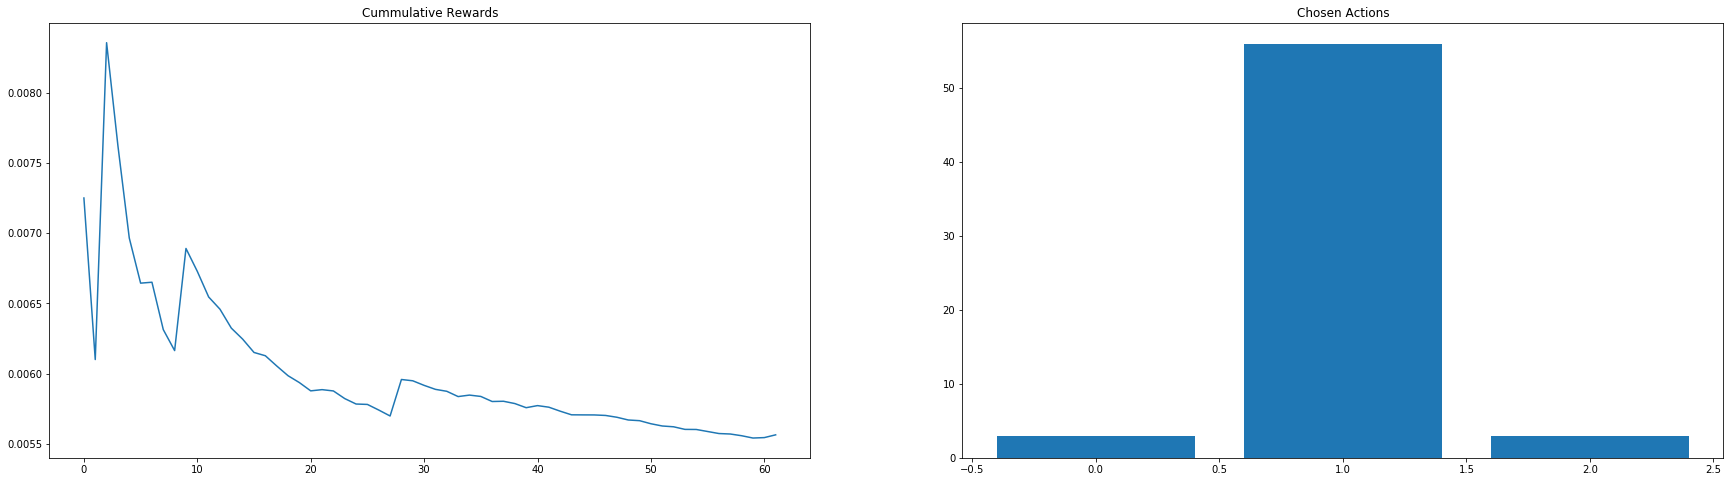

Restart at iteration: 1645
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.009386500000118758, 'merge_sort': 0.005165400000020203, 'heap_sort': 0.012278899999955684}
Count per chosen algo {'quick_sort': 1, 'merge_sort': 11, 'heap_sort': 1}


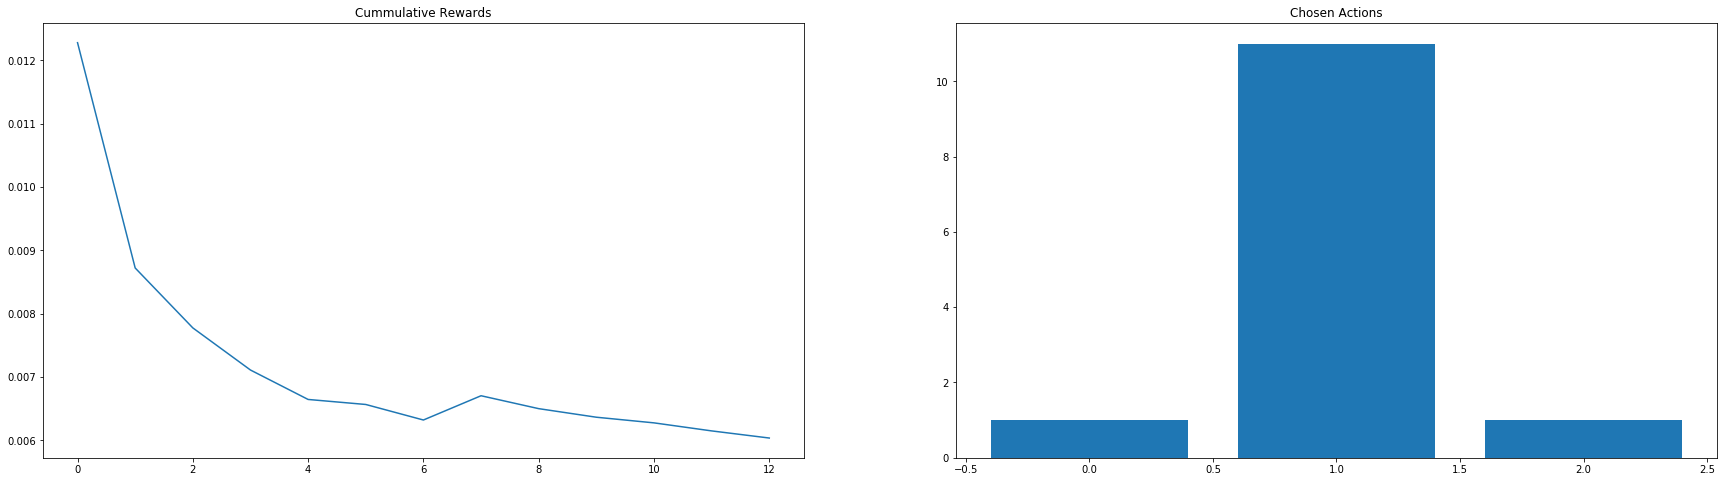

Restart at iteration: 1663
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.009533899999951245, 'merge_sort': 0.0051395266666531825, 'heap_sort': 0.012538299999846458}
Count per chosen algo {'quick_sort': 1, 'merge_sort': 15, 'heap_sort': 2}


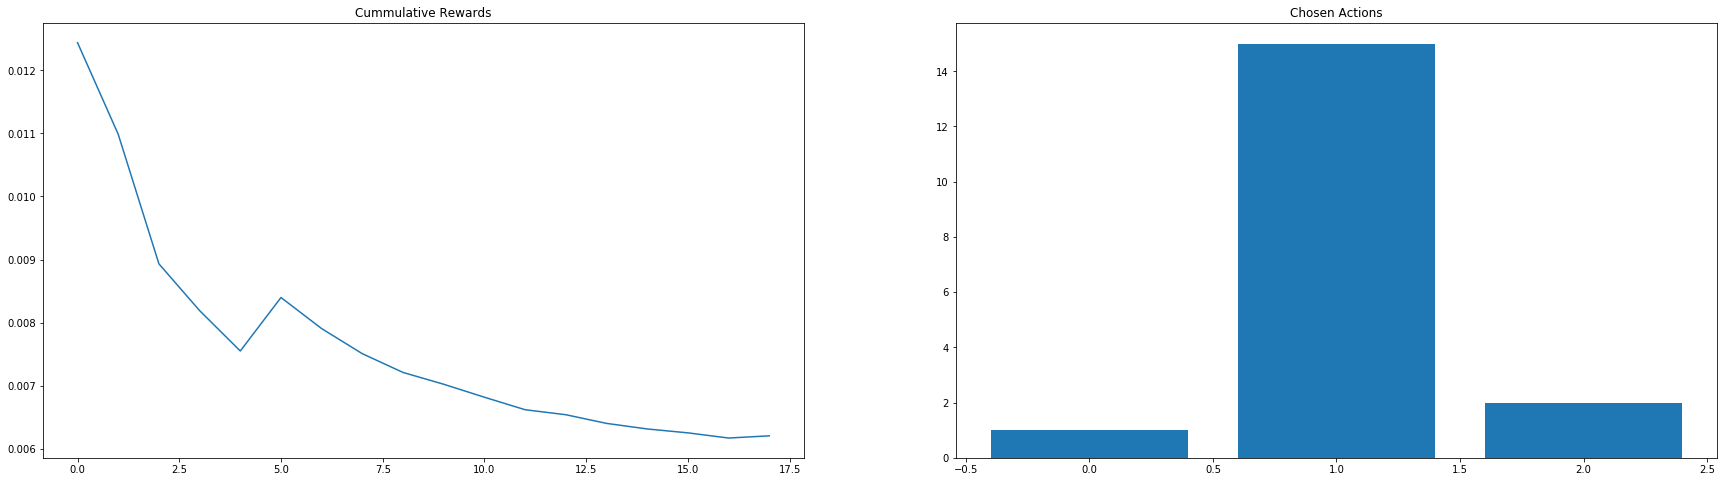

Restart at iteration: 1686
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.006801342857118341, 'merge_sort': 0.005283042857123681, 'heap_sort': 0.012477250000074491}
Count per chosen algo {'quick_sort': 7, 'merge_sort': 14, 'heap_sort': 2}


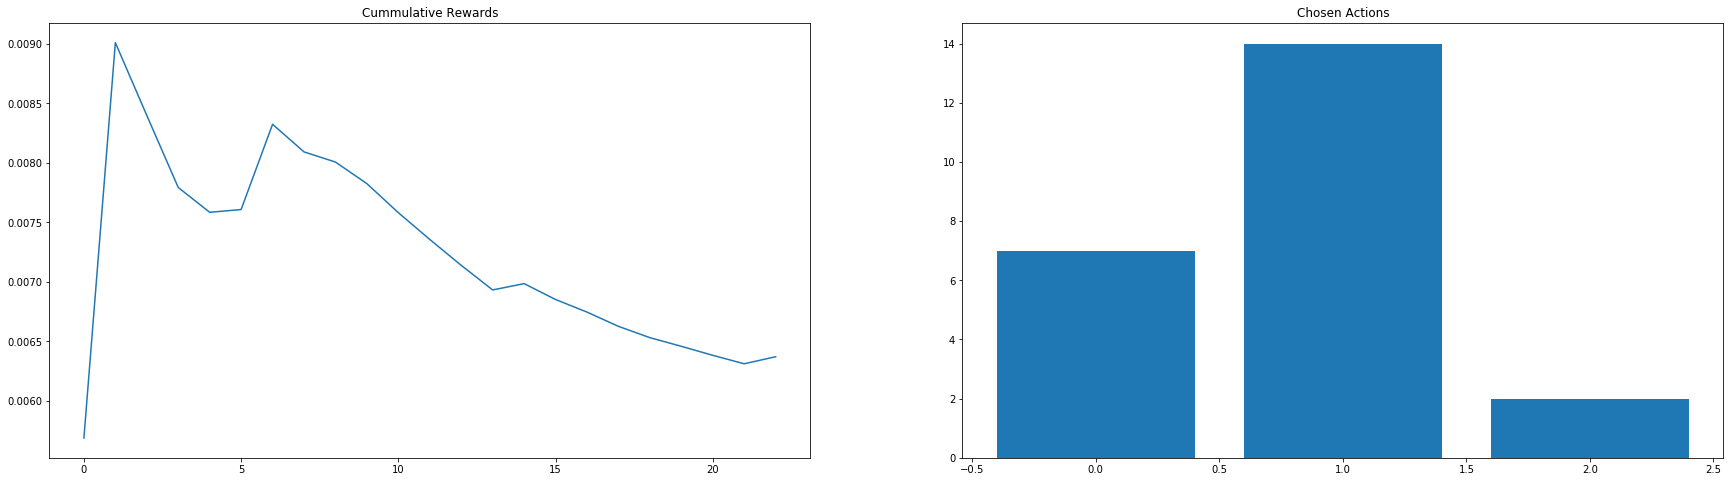

Restart at iteration: 1717
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.006533875000116041, 'merge_sort': 0.005282073076911659, 'heap_sort': 0.014430900000206748}
Count per chosen algo {'quick_sort': 4, 'merge_sort': 26, 'heap_sort': 1}


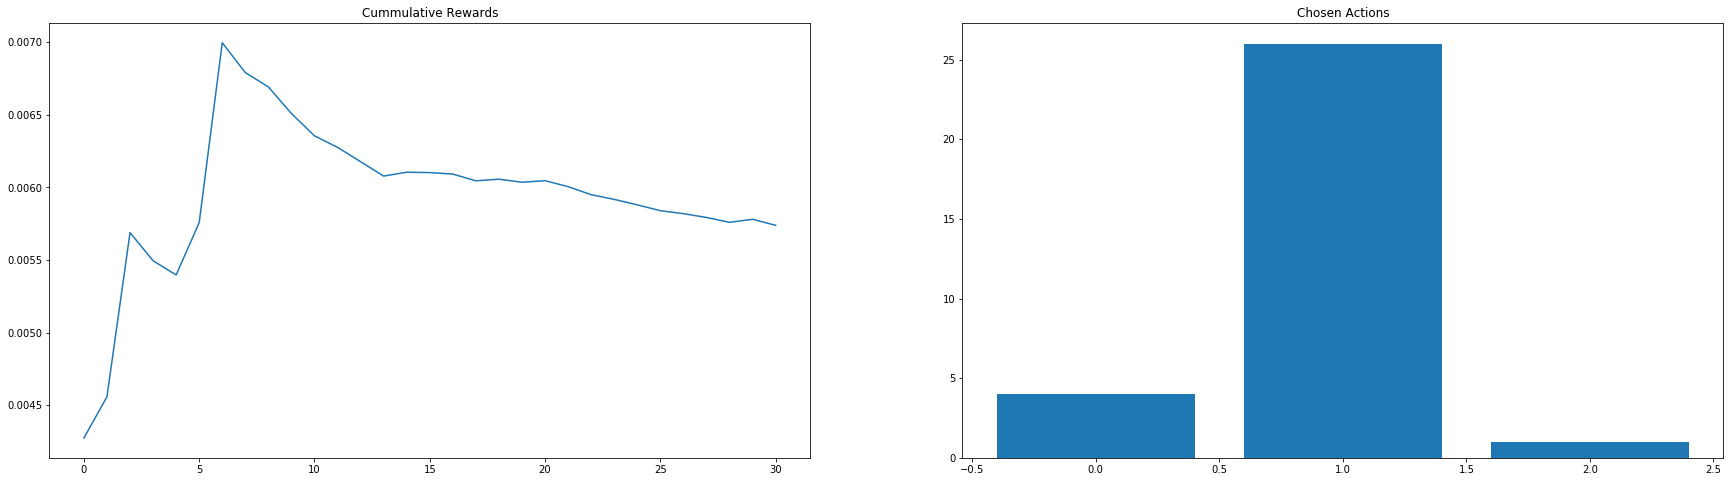

Restart at iteration: 1745
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.00672450714286502, 'merge_sort': 0.005071783333316186, 'heap_sort': 0.01298549999989973}
Count per chosen algo {'quick_sort': 14, 'merge_sort': 12, 'heap_sort': 2}


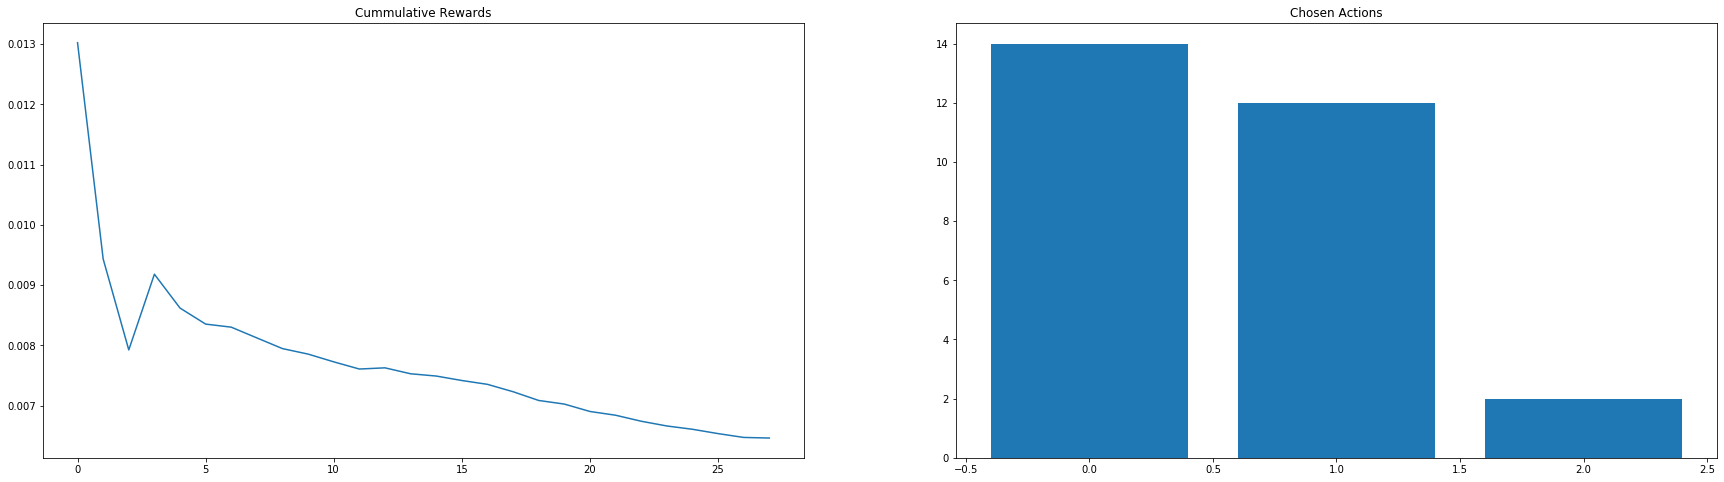

Restart at iteration: 1762
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.0069620749999330656, 'merge_sort': 0.004955600000016602, 'heap_sort': 0.012602999999899112}
Count per chosen algo {'quick_sort': 4, 'merge_sort': 12, 'heap_sort': 1}


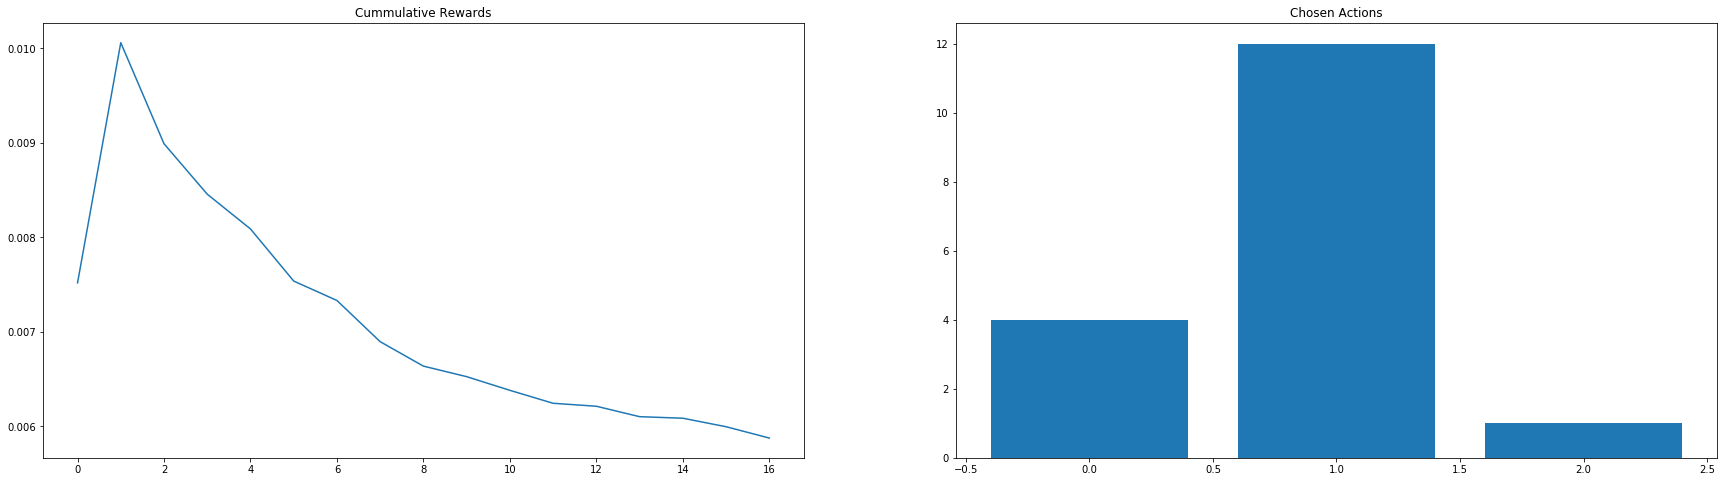

Restart at iteration: 1819
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.00655513333329812, 'merge_sort': 0.004949523076902551, 'heap_sort': 0.013202950000049896}
Count per chosen algo {'quick_sort': 3, 'merge_sort': 52, 'heap_sort': 2}


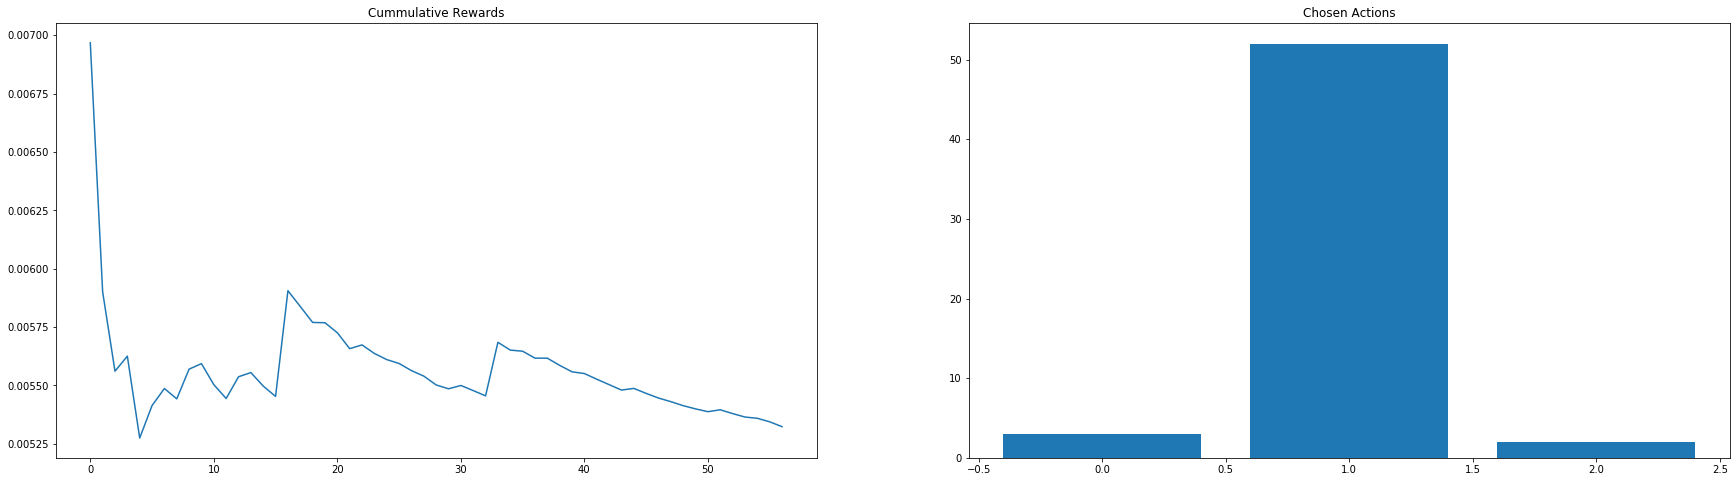

Restart at iteration: 1832
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.006802024999994198, 'merge_sort': 0.0, 'heap_sort': 0.01375240000015765}
Count per chosen algo {'quick_sort': 12, 'merge_sort': 0, 'heap_sort': 1}


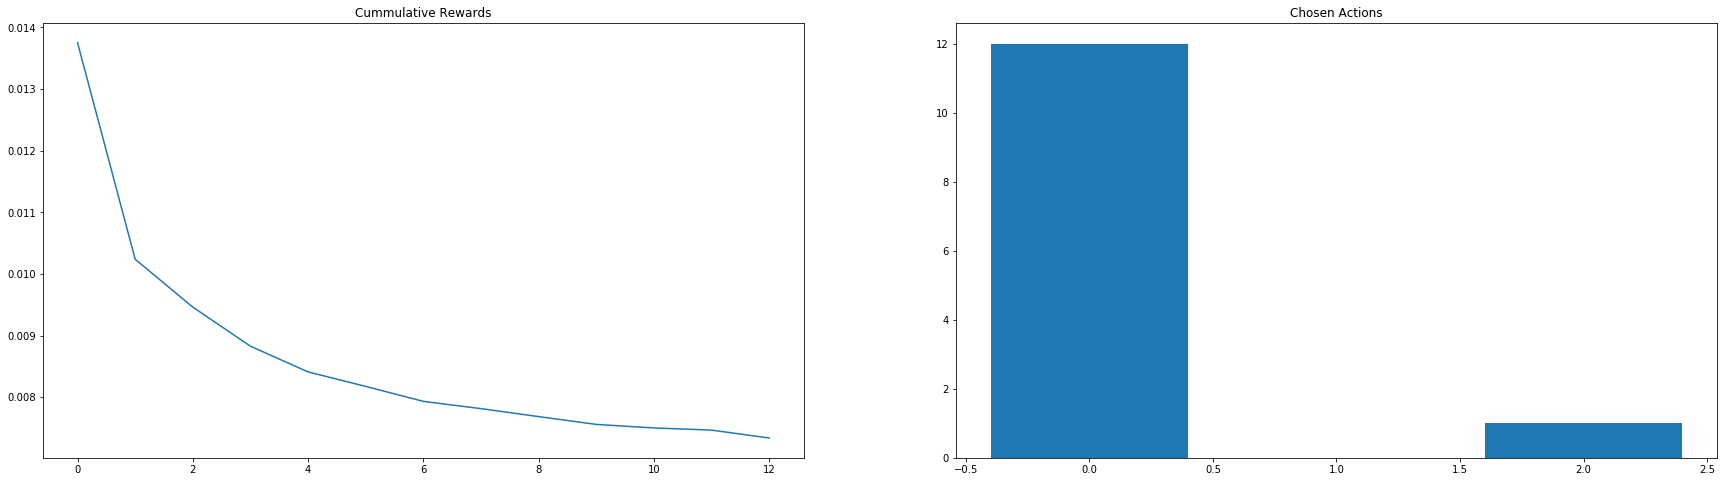

Restart at iteration: 1858
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.006881758333349808, 'merge_sort': 0.005322907692288936, 'heap_sort': 0.012481799999932264}
Count per chosen algo {'quick_sort': 12, 'merge_sort': 13, 'heap_sort': 1}


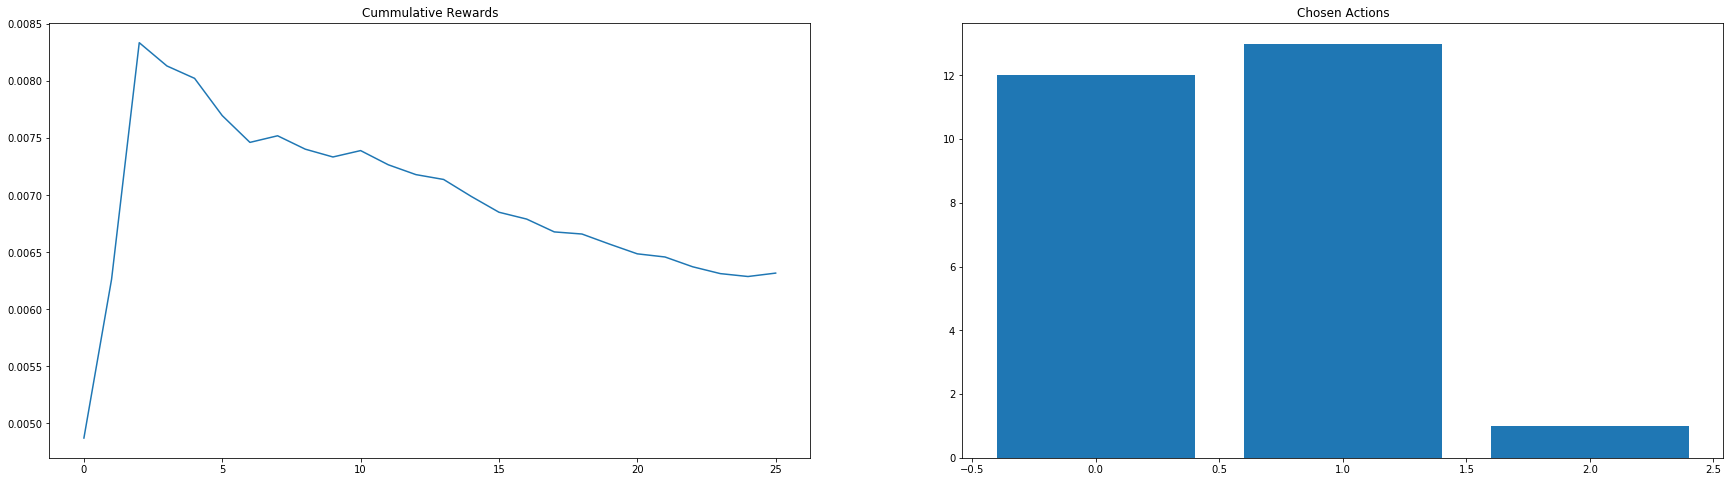

Restart at iteration: 1872
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.006954966666645153, 'merge_sort': 0.00588330000005044, 'heap_sort': 0.012287300000025425}
Count per chosen algo {'quick_sort': 12, 'merge_sort': 1, 'heap_sort': 1}


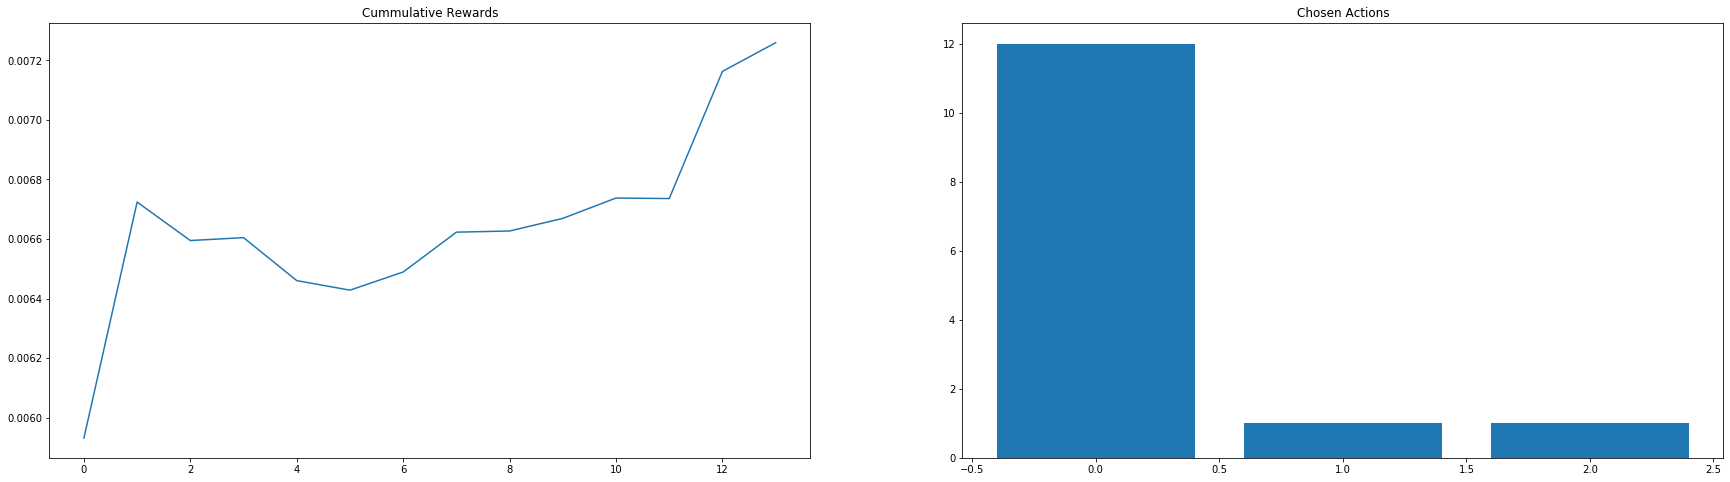

Restart at iteration: 1904
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.006558400000027508, 'merge_sort': 0.00501048499999115, 'heap_sort': 0.0130076000000372}
Count per chosen algo {'quick_sort': 11, 'merge_sort': 20, 'heap_sort': 1}


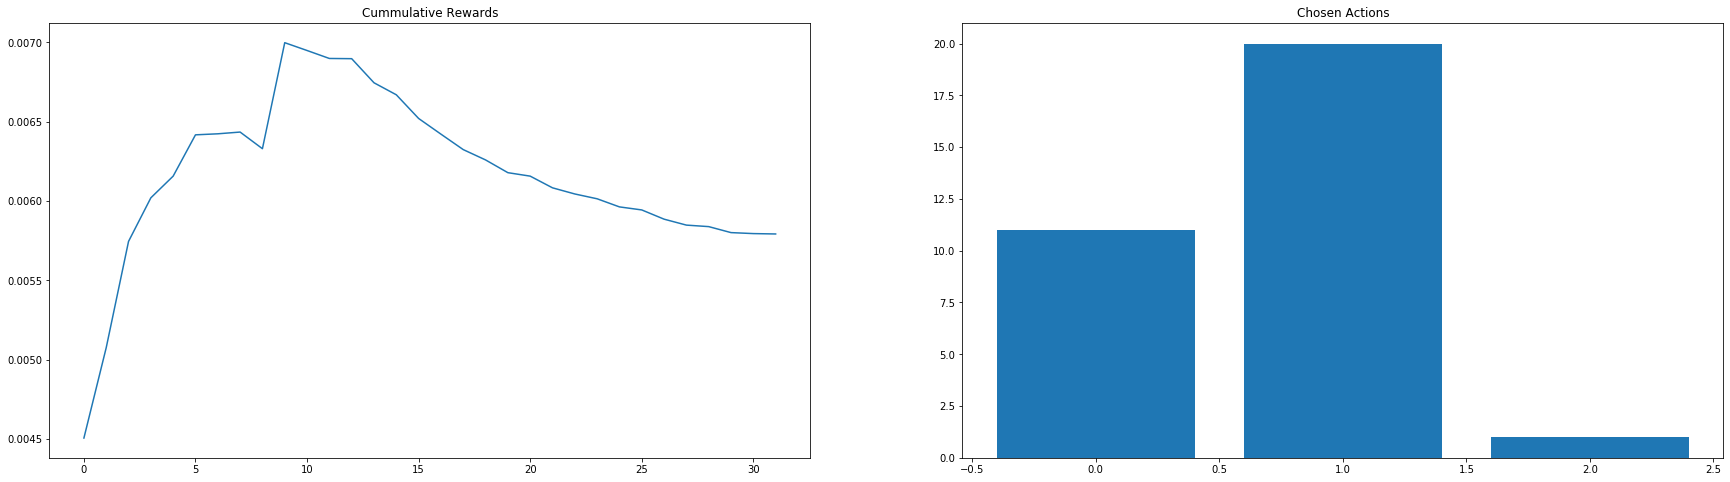

Restart at iteration: 1920
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.006475549999890973, 'merge_sort': 0.00534761666661628, 'heap_sort': 0.01239060000000336}
Count per chosen algo {'quick_sort': 2, 'merge_sort': 12, 'heap_sort': 2}


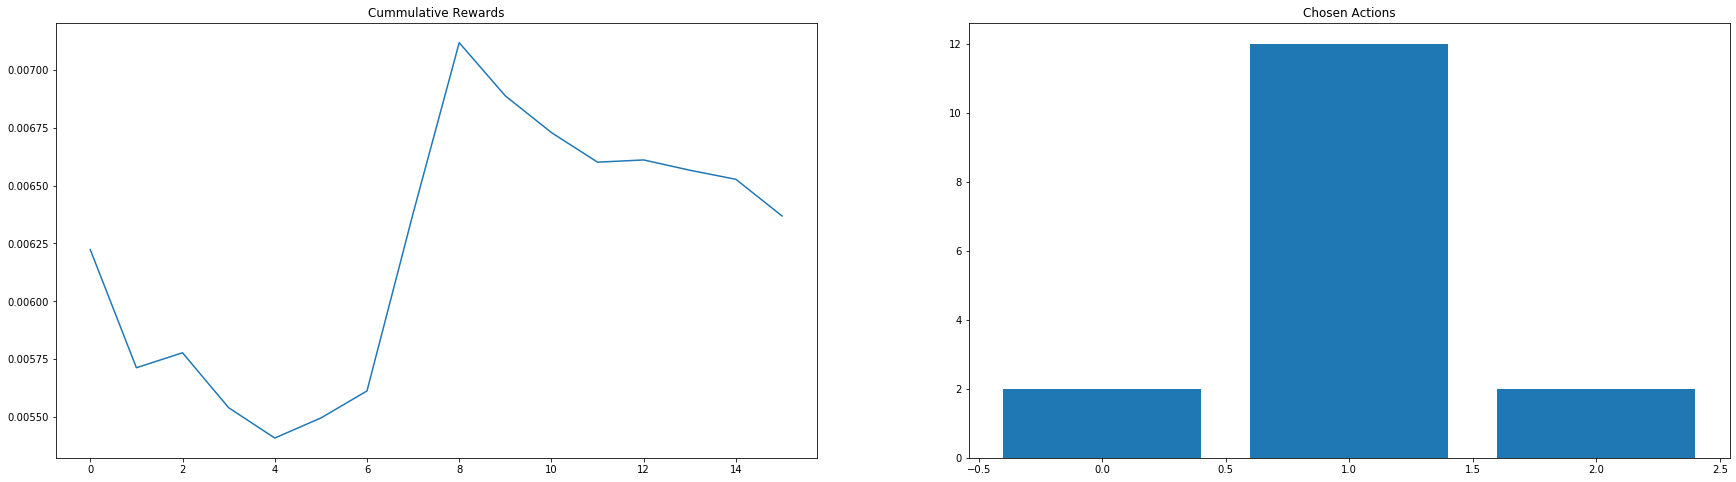

Restart at iteration: 1933
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.0, 'merge_sort': 0.005341881818181223, 'heap_sort': 0.013118599999984326}
Count per chosen algo {'quick_sort': 0, 'merge_sort': 11, 'heap_sort': 2}


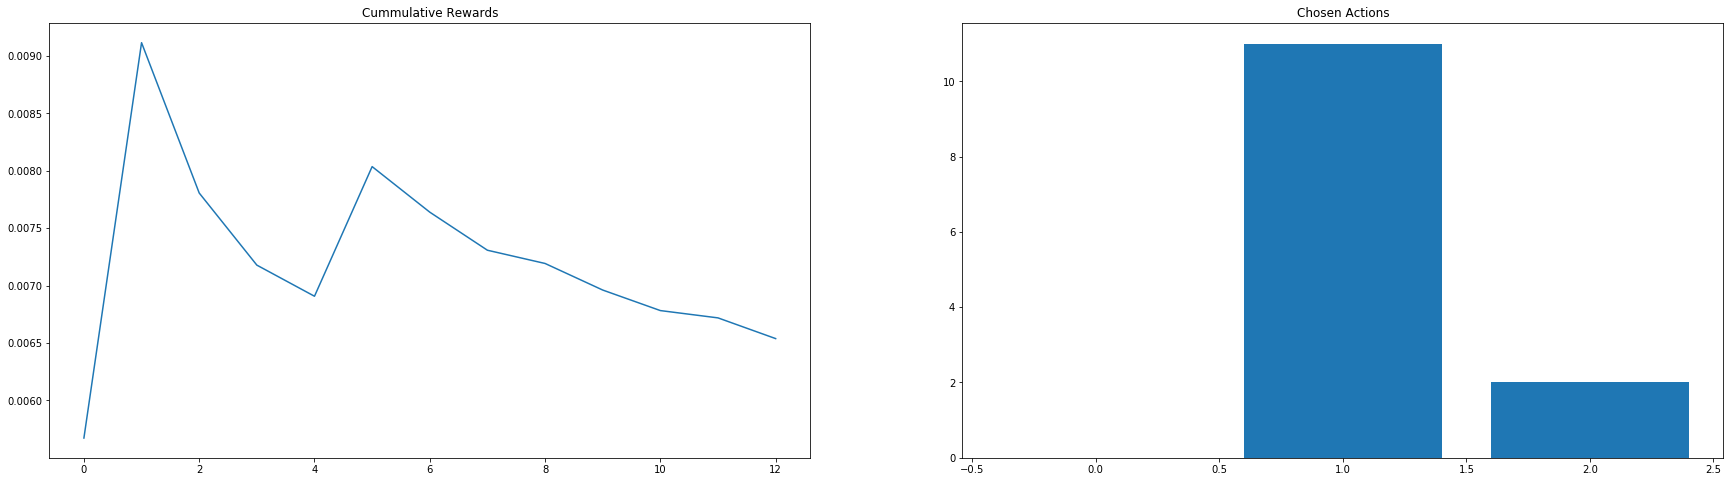

Restart at iteration: 1952
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.0, 'merge_sort': 0.005126623529403172, 'heap_sort': 0.013800000000060209}
Count per chosen algo {'quick_sort': 0, 'merge_sort': 17, 'heap_sort': 2}


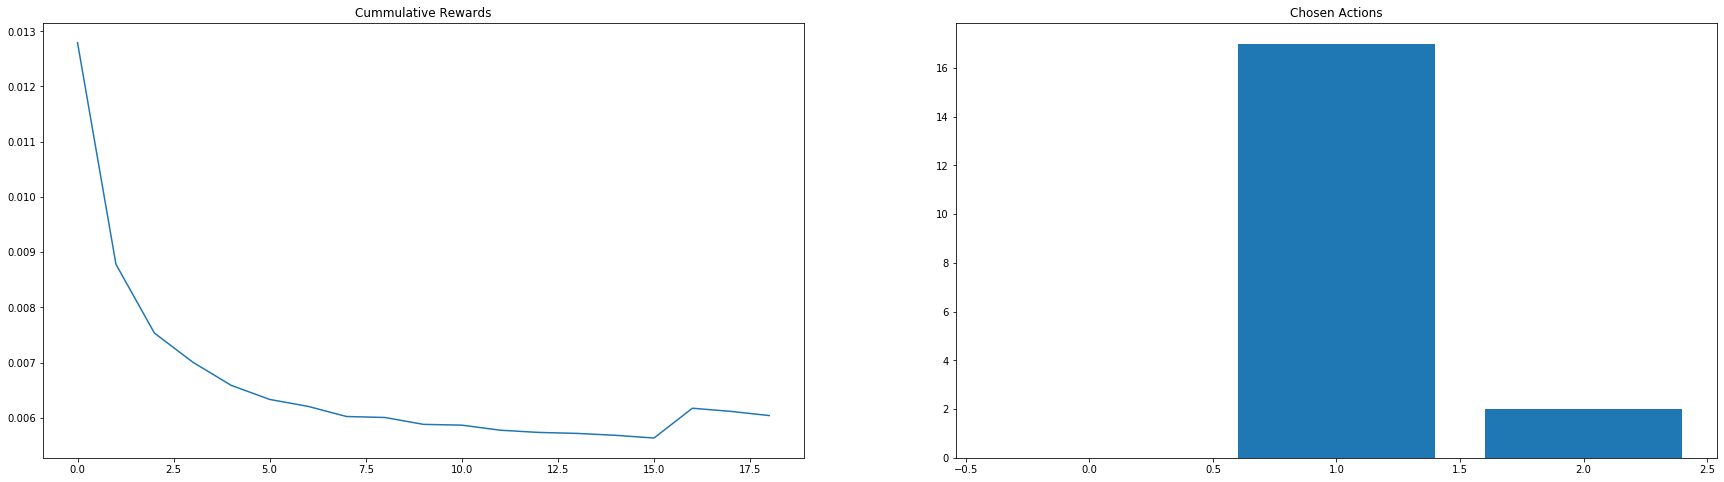

Restart at iteration: 1972
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.006944700000076409, 'merge_sort': 0.005617505882368919, 'heap_sort': 0.013647449999893979}
Count per chosen algo {'quick_sort': 1, 'merge_sort': 17, 'heap_sort': 2}


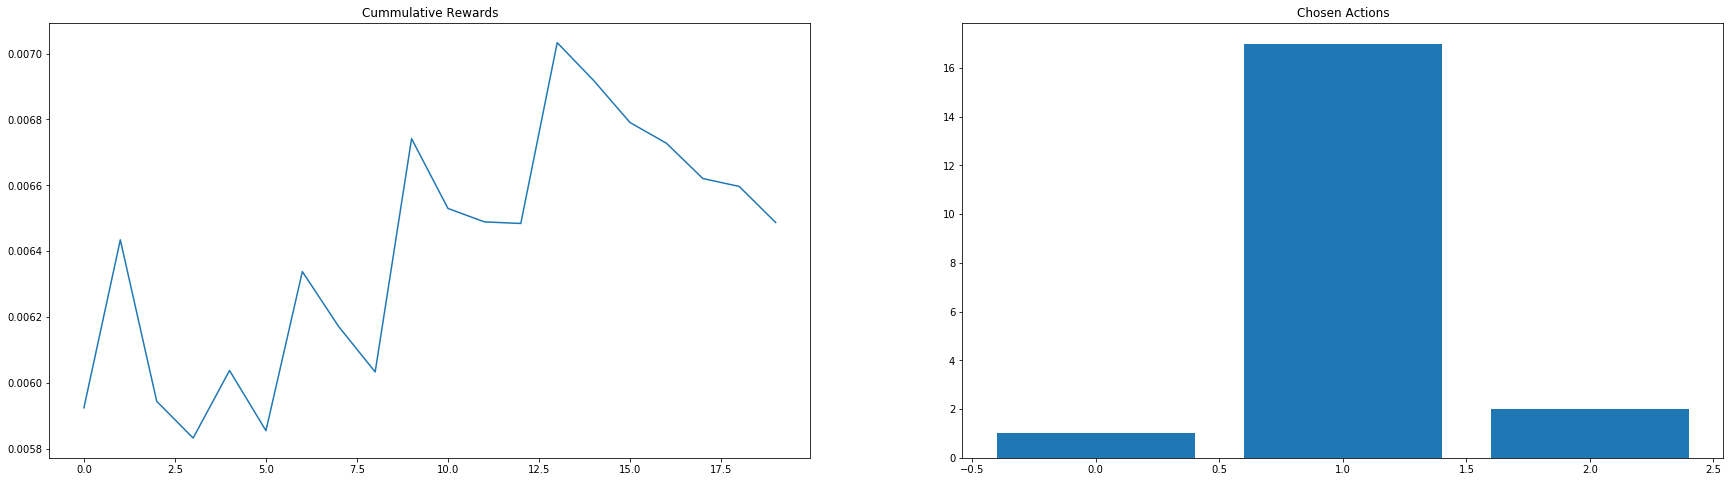

Restart at iteration: 1993
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.006005599999980404, 'merge_sort': 0.005125357142869039, 'heap_sort': 0.01235280000014427}
Count per chosen algo {'quick_sort': 6, 'merge_sort': 14, 'heap_sort': 1}


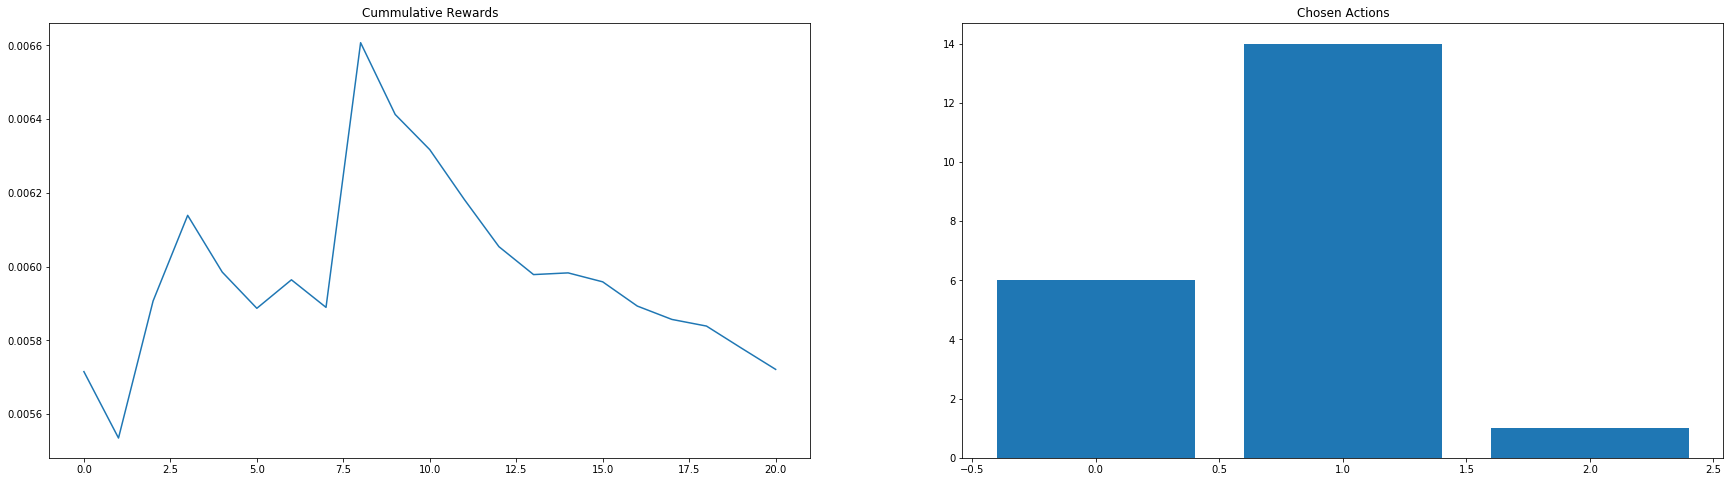

Restart at iteration: 1999
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.0, 'merge_sort': 0.005335533333322928, 'heap_sort': 0.0}
Count per chosen algo {'quick_sort': 0, 'merge_sort': 6, 'heap_sort': 0}


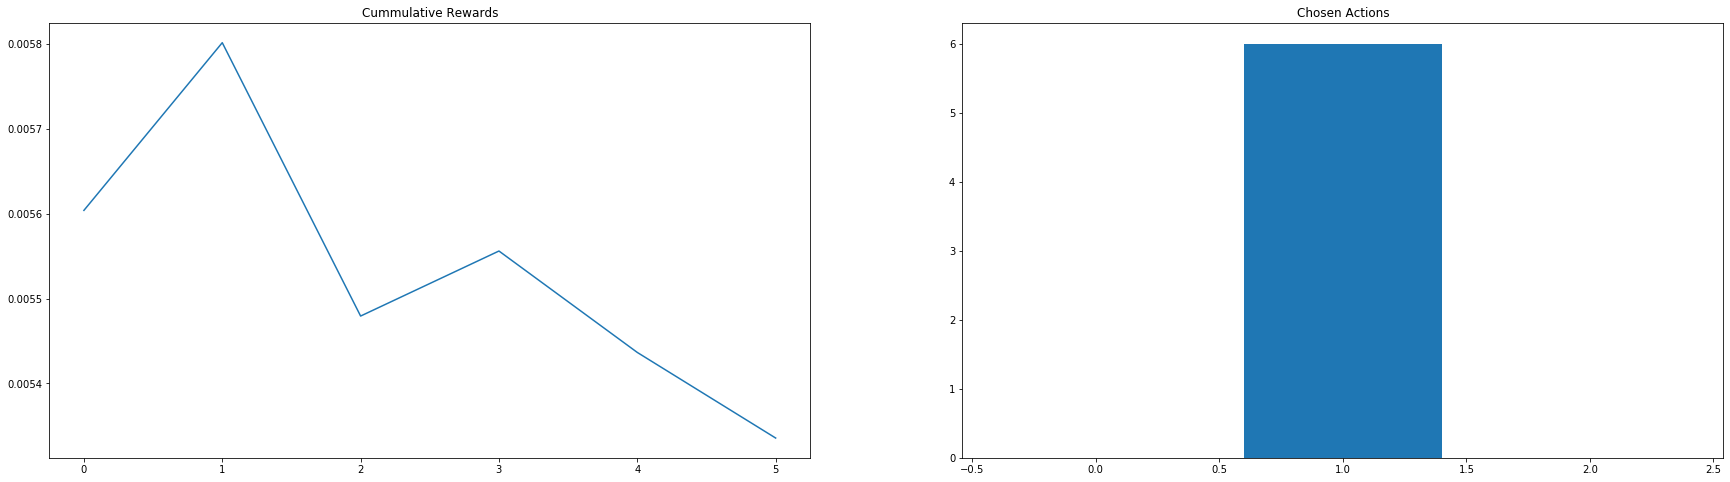

Total reward 22.9152


In [76]:
for elem in list_iteration_results_1:
    sample_mean, sample_count,rewards,cum_rewards,n = elem
    print("Restart at iteration:", n)
    print("Results up to this iteration: ")
    plot_history(rewards,cum_rewards, sample_count, sample_mean)
print("Total reward", np.round(total_reward_1,4))

## Two outliers in a row restart the expriment

In [77]:
list_iteration_results_2, total_reward_2, arm_rewards_2 = ts_quantile(list_distributions, n_samples, num_consec_elem=2)



Iteration: 0
Less than two values for quick_sort
quick_sort Theta 0.09835695051734322
Less than two values for merge_sort
merge_sort Theta 0.0919522341480442
Less than two values for heap_sort
heap_sort Theta 0.0015166259605984167


Chosen algorithm is:  heap_sort with reward: 0.026156899999932648
Sample mean is:  0.026156899999932648 Sample variance is: 0.0


Iteration: 1
Less than two values for quick_sort
quick_sort Theta 0.0498319513381439
Less than two values for merge_sort
merge_sort Theta 0.030182263184360694
Less than two values for heap_sort
heap_sort Theta 0.020176404766836353


Chosen algorithm is:  heap_sort with reward: 0.023739599999998973
Sample mean is:  0.02494824999996581 Sample variance is: 1.4608348224198367e-06


Iteration: 2
Less than two values for quick_sort
quick_sort Theta 0.053890383922388645
Less than two values for merge_sort
merge_sort Theta 0.09927158483650836
heap_sort Theta 0.024896831986752996


Chosen algorithm is:  heap_sort with reward: 0.02212510


Chosen algorithm is:  quick_sort with reward: 0.017123299999866504
Sample mean is:  0.018165249999973248 Sample variance is: 3.5893676679984565e-05


Iteration: 32
quick_sort Theta 0.017868254847315232
merge_sort Theta 0.017226106940146906
heap_sort Theta 0.024194130343494255


Chosen algorithm is:  merge_sort with reward: 0.01702930000010383
Sample mean is:  0.017332606666726254 Sample variance is: 1.8502834606679156e-06


Iteration: 33
quick_sort Theta 0.01988411169771344
merge_sort Theta 0.017323926036040396
heap_sort Theta 0.024419340028197078


Chosen algorithm is:  merge_sort with reward: 0.015573399999993853
Sample mean is:  0.01722265625005548 Sample variance is: 1.9159771562673267e-06


Iteration: 34
quick_sort Theta 0.020003704724278665
merge_sort Theta 0.01728357791256278
heap_sort Theta 0.024150316582018966


Chosen algorithm is:  merge_sort with reward: 0.01597049999986666
Sample mean is:  0.017149000000044372 Sample variance is: 1.890076508314545e-06


Iteration: 35
quic

Chosen algorithm is:  quick_sort with reward: 0.01365710000004583
Sample mean is:  0.014191457142845008 Sample variance is: 1.6666650820313524e-07


Iteration: 59
quick_sort Theta 0.014082514023118924
merge_sort Theta 0.016171879649901133
heap_sort Theta 0.02197092142828163


Chosen algorithm is:  quick_sort with reward: 0.013965200000029654
Sample mean is:  0.014163174999993089 Sample variance is: 1.5143235190781792e-07


Iteration: 60
quick_sort Theta 0.014356724939043355
merge_sort Theta 0.016774994758602807
heap_sort Theta 0.023324472227286508


Chosen algorithm is:  quick_sort with reward: 0.015126199999940582
Sample mean is:  0.014270177777765033 Sample variance is: 2.2620329063646712e-07


Iteration: 61
quick_sort Theta 0.01440420449011497
merge_sort Theta 0.016155137328771812
heap_sort Theta 0.023854839153353416


Chosen algorithm is:  quick_sort with reward: 0.015028300000039962
Sample mean is:  0.014345989999992526 Sample variance is: 2.553103989244574e-07


Iteration: 62
qui



Chosen algorithm is:  quick_sort with reward: 0.015237500000012005
Sample mean is:  0.014652966666631073 Sample variance is: 1.0019465406924725e-06


Iteration: 87
quick_sort Theta 0.014652557336399736
merge_sort Theta 0.01569856432832609
heap_sort Theta 0.02293455322760496


Chosen algorithm is:  quick_sort with reward: 0.014069900000095004
Sample mean is:  0.014608115384589837 Sample variance is: 9.490133798788845e-07


Iteration: 88
quick_sort Theta 0.014530693649108766
merge_sort Theta 0.016502948777576642
heap_sort Theta 0.023947825270781233


Chosen algorithm is:  quick_sort with reward: 0.014729600000009668
Sample mean is:  0.014616792857119825 Sample variance is: 8.822055907711488e-07


Iteration: 89
quick_sort Theta 0.01519996565013065
merge_sort Theta 0.015489941036636725
heap_sort Theta 0.023312835786036924


Chosen algorithm is:  quick_sort with reward: 0.014835999999831984
Sample mean is:  0.014631406666633968 Sample variance is: 8.263817727189584e-07


Iteration: 90
qui



Chosen algorithm is:  quick_sort with reward: 0.014262499999858846
Sample mean is:  0.014037540000026638 Sample variance is: 3.7364127037969544e-07


Iteration: 116
quick_sort Theta 0.01369040204060858
merge_sort Theta 0.015980148639932922
heap_sort Theta 0.024670846014537413


Chosen algorithm is:  quick_sort with reward: 0.014448599999923317
Sample mean is:  0.014106050000009418 Sample variance is: 3.348358258046153e-07


Iteration: 117
quick_sort Theta 0.014092764788313112
merge_sort Theta 0.0160987334375241
heap_sort Theta 0.022397139373286374


Chosen algorithm is:  quick_sort with reward: 0.014727100000072824
Sample mean is:  0.014194771428589905 Sample variance is: 3.342310877401302e-07


Iteration: 118
quick_sort Theta 0.013323943575076625
merge_sort Theta 0.016279817628273907
heap_sort Theta 0.023858840774536625


Chosen algorithm is:  quick_sort with reward: 0.013623099999904298
Sample mean is:  0.014123312500004204 Sample variance is: 3.28196851094928e-07


Iteration: 119




Chosen algorithm is:  quick_sort with reward: 0.015544800000043324
Sample mean is:  0.014466571428602037 Sample variance is: 6.086390905923592e-07


Iteration: 146
quick_sort Theta 0.014489202176598501
merge_sort Theta 0.016094976259632177
heap_sort Theta 0.02514557210747288


Chosen algorithm is:  quick_sort with reward: 0.014929599999959464
Sample mean is:  0.014479433333361966 Sample variance is: 5.975224499788873e-07


Iteration: 147
quick_sort Theta 0.01435485446306733
merge_sort Theta 0.015947359701149227
heap_sort Theta 0.02384637146489733


Chosen algorithm is:  quick_sort with reward: 0.014418900000009671
Sample mean is:  0.014477797297325418 Sample variance is: 5.814695526749165e-07


Iteration: 148
quick_sort Theta 0.014397827462054598
merge_sort Theta 0.01598091338014578
heap_sort Theta 0.023879460757479175


Chosen algorithm is:  quick_sort with reward: 0.0142315000000508
Sample mean is:  0.014471315789502401 Sample variance is: 5.677220902567794e-07


Iteration: 149
qui



Chosen algorithm is:  quick_sort with reward: 0.015035799999850497
Sample mean is:  0.014387323880623287 Sample variance is: 5.349365271930177e-07


Iteration: 178
quick_sort Theta 0.014368927199646204
merge_sort Theta 0.015886815055487735
heap_sort Theta 0.02792446172172701


Chosen algorithm is:  quick_sort with reward: 0.014490000000023429
Sample mean is:  0.014388833823555642 Sample variance is: 5.272225687109775e-07


Iteration: 179
quick_sort Theta 0.014286435740687956
merge_sort Theta 0.01594701582331134
heap_sort Theta 0.02577632096855344


Chosen algorithm is:  quick_sort with reward: 0.014238799999930052
Sample mean is:  0.01438665942031469 Sample variance is: 5.19903167920954e-07


Iteration: 180
quick_sort Theta 0.014353094808558458
merge_sort Theta 0.016208612365063657
heap_sort Theta 0.022526943169187633


Chosen algorithm is:  quick_sort with reward: 0.01420500000017455
Sample mean is:  0.01438406428574126 Sample variance is: 5.129406757261384e-07


Iteration: 181
quic



Iteration: 209
quick_sort Theta 0.014193536930372366
merge_sort Theta 0.01611121616432682
heap_sort Theta 0.024993582100144948


Chosen algorithm is:  quick_sort with reward: 0.015031099999987418
Sample mean is:  0.014303047474776568 Sample variance is: 5.104265295647933e-07


Iteration: 210
quick_sort Theta 0.014248137423542431
merge_sort Theta 0.01621118484767582
heap_sort Theta 0.023227588614318565


Chosen algorithm is:  quick_sort with reward: 0.013741799999934301
Sample mean is:  0.014297435000028145 Sample variance is: 5.084407516765119e-07


Iteration: 211
quick_sort Theta 0.01424770921739756
merge_sort Theta 0.016368883684664205
heap_sort Theta 0.02302035326027868


Chosen algorithm is:  quick_sort with reward: 0.014004499999828113
Sample mean is:  0.01429453465349151 Sample variance is: 5.042478858314861e-07


Iteration: 212
quick_sort Theta 0.014296308189708727
merge_sort Theta 0.01648102013181583
heap_sort Theta 0.023187317954517287


Chosen algorithm is:  quick_sort with

merge_sort Theta 0.016424317537661992
heap_sort Theta 0.02405398886576465


Chosen algorithm is:  merge_sort with reward: 0.016571200000043973
Sample mean is:  0.01623028333331907 Sample variance is: 3.1160394133741035e-07


Iteration: 238
Less than two values for quick_sort
quick_sort Theta 0.012492879340575658
merge_sort Theta 0.016004064390805775
heap_sort Theta 0.025501434591612464


Chosen algorithm is:  quick_sort with reward: 0.01492740000003323
Sample mean is:  0.01478830000007747 Sample variance is: 1.9348809987692634e-08


Iteration: 239
quick_sort Theta 0.012404873085797605
merge_sort Theta 0.016052775714586156
heap_sort Theta 0.023280697457552978


Chosen algorithm is:  quick_sort with reward: 0.014009699999860459
Sample mean is:  0.0145287666666718 Sample variance is: 1.4761430895577953e-07


Iteration: 240
quick_sort Theta 0.013788168132050804
merge_sort Theta 0.01635622886202281
heap_sort Theta 0.022998764615215526


Chosen algorithm is:  quick_sort with reward: 0.015189



Chosen algorithm is:  quick_sort with reward: 0.014828999999963344
Sample mean is:  0.014405738709683646 Sample variance is: 2.8199698110816967e-07


Iteration: 268
quick_sort Theta 0.01437707086457066
merge_sort Theta 0.01660554746918363
heap_sort Theta 0.023544017982091367


Chosen algorithm is:  quick_sort with reward: 0.015046299999994517
Sample mean is:  0.014425756250005861 Sample variance is: 2.856063349856356e-07


Iteration: 269
quick_sort Theta 0.014398580322913064
merge_sort Theta 0.016740343692966158
heap_sort Theta 0.02385183460863026


Chosen algorithm is:  quick_sort with reward: 0.013834600000109276
Sample mean is:  0.01440784242425142 Sample variance is: 2.872205624629648e-07


Iteration: 270
quick_sort Theta 0.014401665167644906
merge_sort Theta 0.016186410835158368
heap_sort Theta 0.024279035142421627


Chosen algorithm is:  quick_sort with reward: 0.013605200000029072
Sample mean is:  0.014384235294127232 Sample variance is: 2.971636864202221e-07


Iteration: 271




Chosen algorithm is:  quick_sort with reward: 0.016467099999999846
Sample mean is:  0.014276506451628554 Sample variance is: 3.795517219033574e-07


Iteration: 299
quick_sort Theta 0.014232321465188357
merge_sort Theta 0.016302142150164022
heap_sort Theta 0.023750105481359


Chosen algorithm is:  quick_sort with reward: 0.01402179999990949
Sample mean is:  0.014272463492077458 Sample variance is: 3.745405137567265e-07


Iteration: 300
quick_sort Theta 0.014247858565137918
merge_sort Theta 0.01556484525195815
heap_sort Theta 0.023431287455545322


Chosen algorithm is:  quick_sort with reward: 0.016627900000003137
Sample mean is:  0.014309267187513797 Sample variance is: 4.5402257408883687e-07


Iteration: 301
quick_sort Theta 0.014266380254725937
merge_sort Theta 0.016496897572000478
heap_sort Theta 0.02384017295003758


Chosen algorithm is:  quick_sort with reward: 0.013489100000015242
Sample mean is:  0.01429664923078305 Sample variance is: 4.5722723266232343e-07


Iteration: 302
qu



Chosen algorithm is:  quick_sort with reward: 0.01561560000004647
Sample mean is:  0.014249309090919177 Sample variance is: 4.422929018439916e-07


Iteration: 336
quick_sort Theta 0.014256922125092804
merge_sort Theta 0.015962574325668475
heap_sort Theta 0.021058144833613318


Chosen algorithm is:  quick_sort with reward: 0.013470699999970748
Sample mean is:  0.014241523000009693 Sample variance is: 4.4387167077897627e-07


Iteration: 337
quick_sort Theta 0.01412359488561633
merge_sort Theta 0.01645903021447522
heap_sort Theta 0.022910333921302636


Chosen algorithm is:  quick_sort with reward: 0.014085600000043996
Sample mean is:  0.014239979207930825 Sample variance is: 4.3971523115964033e-07


Iteration: 338
quick_sort Theta 0.014255889598339795
merge_sort Theta 0.015633873336014063
heap_sort Theta 0.026927321528549847


Chosen algorithm is:  quick_sort with reward: 0.014214600000059363
Sample mean is:  0.01423973039216738 Sample variance is: 4.3541055035851844e-07


Iteration: 33

quick_sort Theta 0.01418288092349867
merge_sort Theta 0.015887270927266738
heap_sort Theta 0.024717584730814028


Chosen algorithm is:  quick_sort with reward: 0.014465100000052189
Sample mean is:  0.01420109153847044 Sample variance is: 4.2396977047202226e-07


Iteration: 367
quick_sort Theta 0.014249388331529094
merge_sort Theta 0.016744683022466338
heap_sort Theta 0.023555236304655332


Chosen algorithm is:  quick_sort with reward: 0.015060500000117827
Sample mean is:  0.014207651908406681 Sample variance is: 4.2632835899144487e-07


Iteration: 368
quick_sort Theta 0.014172356954117248
merge_sort Theta 0.01627287729430285
heap_sort Theta 0.02417326613145162


Chosen algorithm is:  quick_sort with reward: 0.014006200000039826
Sample mean is:  0.01420612575758572 Sample variance is: 4.23403715555065e-07


Iteration: 369
quick_sort Theta 0.014295744876618334
merge_sort Theta 0.01611043277165082
heap_sort Theta 0.02435805785750097


Chosen algorithm is:  quick_sort with reward: 0.014083



Chosen algorithm is:  quick_sort with reward: 0.014362200000050507
Sample mean is:  0.016692450000050485 Sample variance is: 5.430065062499898e-06


Iteration: 402
quick_sort Theta 0.01597184125689654
Less than two values for merge_sort
merge_sort Theta 0.018598371481263077
Less than two values for heap_sort
heap_sort Theta 0.07465305889624989


Chosen algorithm is:  quick_sort with reward: 0.015555699999822536
Sample mean is:  0.016313533333307834 Sample variance is: 3.907199055670653e-06


Iteration: 403
quick_sort Theta 0.015142059024112742
Less than two values for merge_sort
merge_sort Theta 0.09489991800027818
Less than two values for heap_sort
heap_sort Theta 0.05776572383191031


Chosen algorithm is:  quick_sort with reward: 0.014737800000148127
Sample mean is:  0.01591960000001791 Sample variance is: 3.395949704983728e-06


Iteration: 404
quick_sort Theta 0.017178846276352997
Less than two values for merge_sort
merge_sort Theta 0.003840496210026001
Less than two values for he



Iteration: 430
quick_sort Theta 0.014961455838333833
merge_sort Theta 0.01632721285607304
heap_sort Theta 0.02543190886676133


Chosen algorithm is:  quick_sort with reward: 0.016048100000034538
Sample mean is:  0.015112374074095459 Sample variance is: 8.136921182161554e-07


Iteration: 431
quick_sort Theta 0.0148693044438563
merge_sort Theta 0.016579945291218458
heap_sort Theta 0.025300668170348237


Chosen algorithm is:  quick_sort with reward: 0.02033530000016981
Sample mean is:  0.015298907142883829 Sample variance is: 1.7240855007161006e-06


Iteration: 432
quick_sort Theta 0.015104077196432187
merge_sort Theta 0.016480627756722193
heap_sort Theta 0.024365854262204778


Chosen algorithm is:  quick_sort with reward: 0.017329300000028525
Sample mean is:  0.01536892068968192 Sample variance is: 1.8018873851404422e-06


Iteration: 433
quick_sort Theta 0.01530695560743947
merge_sort Theta 0.016372408271459717
heap_sort Theta 0.021569318516825395


Chosen algorithm is:  quick_sort wit



Chosen algorithm is:  quick_sort with reward: 0.015342600000167295
Sample mean is:  0.015538577966126623 Sample variance is: 2.1619886946291435e-06


Iteration: 463
quick_sort Theta 0.015710076730804514
merge_sort Theta 0.017056023677198752
heap_sort Theta 0.025071881883268712


Chosen algorithm is:  quick_sort with reward: 0.01374260000011418
Sample mean is:  0.015508645000026414 Sample variance is: 2.178818514832471e-06


Iteration: 464
quick_sort Theta 0.015489189977526425
merge_sort Theta 0.01650074423474306
heap_sort Theta 0.025780277344019133


Chosen algorithm is:  quick_sort with reward: 0.014140400000087539
Sample mean is:  0.015486214754125777 Sample variance is: 2.1732871343935257e-06


Iteration: 465
quick_sort Theta 0.01517115161323781
merge_sort Theta 0.016384336705907224
heap_sort Theta 0.025147045395360803


Chosen algorithm is:  quick_sort with reward: 0.013148900000032882
Sample mean is:  0.015448516129059764 Sample variance is: 2.2249264823407997e-06


Iteration: 4


Chosen algorithm is:  merge_sort with reward: 0.015820300000086718
Sample mean is:  0.01592717272726738 Sample variance is: 4.059002020394348e-07


Iteration: 497
quick_sort Theta 0.017331519176981017
merge_sort Theta 0.016062236254298506
heap_sort Theta 0.02283304668477353


Chosen algorithm is:  merge_sort with reward: 0.015926300000046467
Sample mean is:  0.015927099999998973 Sample variance is: 3.7207524338462653e-07


Iteration: 498
quick_sort Theta 0.018577869107071283
merge_sort Theta 0.015591376665710048
heap_sort Theta 0.027837986459602965


Chosen algorithm is:  merge_sort with reward: 0.015898699999979726
Sample mean is:  0.015924915384612878 Sample variance is: 3.435113413492003e-07


Iteration: 499
quick_sort Theta 0.017267574880131826
merge_sort Theta 0.01617058581741863
heap_sort Theta 0.02586471023379893


Chosen algorithm is:  merge_sort with reward: 0.01601340000001983
Sample mean is:  0.015931235714284803 Sample variance is: 3.194941223402181e-07


Iteration: 500
qu

quick_sort Theta 0.004035126674137979
merge_sort Theta 0.004946119287188403
heap_sort Theta 0.0145736544655255


Chosen algorithm is:  quick_sort with reward: 0.008208599999989019
Sample mean is:  0.008386650000034024 Sample variance is: 3.1701802516026174e-08


Iteration: 526
quick_sort Theta 0.007660591104982009
merge_sort Theta 0.004907355504721809
heap_sort Theta 0.015223196850913044


Chosen algorithm is:  merge_sort with reward: 0.004572499999994761
Sample mean is:  0.004831023529411194 Sample variance is: 1.379251665041531e-07


Iteration: 527
quick_sort Theta 0.00860886198344583
merge_sort Theta 0.004995698349080662
heap_sort Theta 0.014402921835248647


Chosen algorithm is:  merge_sort with reward: 0.003772300000036921
Sample mean is:  0.004772205555557068 Sample variance is: 1.89075076075102e-07


Iteration: 528
quick_sort Theta 0.008037020443492098
merge_sort Theta 0.004743592291079087
heap_sort Theta 0.015855700435024822


Chosen algorithm is:  merge_sort with reward: 0.004



Chosen algorithm is:  heap_sort with reward: 0.01773630000002413
Sample mean is:  0.01596570000003794 Sample variance is: 3.135024359951092e-06


Iteration: 555
quick_sort Theta 0.006765178467025413
Less than two values for merge_sort
merge_sort Theta 0.09576703415104522
heap_sort Theta 0.014749393992342314


Chosen algorithm is:  quick_sort with reward: 0.008483899999873756
Sample mean is:  0.006947545454584708 Sample variance is: 3.479614988153159e-07


Iteration: 556
quick_sort Theta 0.006840114997202703
Less than two values for merge_sort
merge_sort Theta 0.016864244674388507
heap_sort Theta 0.01760243589679786


Chosen algorithm is:  quick_sort with reward: 0.00685050000015508
Sample mean is:  0.006939458333382238 Sample variance is: 3.1968412407015057e-07


Iteration: 557
quick_sort Theta 0.006892874871495096
Less than two values for merge_sort
merge_sort Theta 0.05994180295607732
heap_sort Theta 0.004898426738272116


Chosen algorithm is:  heap_sort with reward: 0.015074200000



Chosen algorithm is:  merge_sort with reward: 0.0063680000000658765
Sample mean is:  0.005134741935469192 Sample variance is: 1.295506785714968e-06


Iteration: 591
quick_sort Theta 0.007047124213554047
merge_sort Theta 0.005364455886227871
heap_sort Theta 0.015809268727115373


Chosen algorithm is:  merge_sort with reward: 0.003385200000138866
Sample mean is:  0.005080068749990119 Sample variance is: 1.347686072184677e-06


Iteration: 592
quick_sort Theta 0.00706356848681936
merge_sort Theta 0.005073181152616802
heap_sort Theta 0.015159891283635556


Chosen algorithm is:  merge_sort with reward: 0.005283200000121724
Sample mean is:  0.00508622424241835 Sample variance is: 1.3080595830853808e-06


Iteration: 593
quick_sort Theta 0.006875334255987096
merge_sort Theta 0.005194657574341589
heap_sort Theta 0.01607232045660164


Chosen algorithm is:  merge_sort with reward: 0.004490900000064357
Sample mean is:  0.005068714705878526 Sample variance is: 1.279704510111099e-06


Iteration: 59



Chosen algorithm is:  merge_sort with reward: 0.005379899999979898
Sample mean is:  0.005345403030298367 Sample variance is: 1.2867285669633909e-06


Iteration: 626
quick_sort Theta 0.006755876732157558
merge_sort Theta 0.005454093994206864
heap_sort Theta 0.014875265254698917


Chosen algorithm is:  merge_sort with reward: 0.005701599999838436
Sample mean is:  0.0053507194029780705 Sample variance is: 1.2693890749978491e-06


Iteration: 627
quick_sort Theta 0.007034510622222001
merge_sort Theta 0.005261911132385755
heap_sort Theta 0.015865631919834342


Chosen algorithm is:  merge_sort with reward: 0.004335500000024695
Sample mean is:  0.005335789705875815 Sample variance is: 1.2656556109236834e-06


Iteration: 628
quick_sort Theta 0.006979306055787197
merge_sort Theta 0.005243865197302126
heap_sort Theta 0.014162876252321153


Chosen algorithm is:  merge_sort with reward: 0.0057432999999491585
Sample mean is:  0.0053416956521667325 Sample variance is: 1.2496846296909624e-06


Itera



Iteration: 653
quick_sort Theta 0.007120700060712585
merge_sort Theta 0.005671117542231634
heap_sort Theta 0.014092977073193137


Chosen algorithm is:  merge_sort with reward: 0.006588100000044506
Sample mean is:  0.005127999999984922 Sample variance is: 9.449717125728803e-07


Iteration: 654
quick_sort Theta 0.006292679008704637
merge_sort Theta 0.006439691390019672
heap_sort Theta 0.014071467980593805


Chosen algorithm is:  quick_sort with reward: 0.006992699999955221
Sample mean is:  0.007136114285653353 Sample variance is: 6.341032784072271e-07


Iteration: 655
quick_sort Theta 0.007130213477296657
merge_sort Theta 0.005545910126003507
heap_sort Theta 0.014060969734793502


Chosen algorithm is:  merge_sort with reward: 0.004766699999890989
Sample mean is:  0.005087855555530041 Sample variance is: 8.528674669850664e-07


Iteration: 656
quick_sort Theta 0.007065991457710584
merge_sort Theta 0.004675482314187354
heap_sort Theta 0.014186371536454297


Chosen algorithm is:  merge_sor

quick_sort Theta 0.007182347490510666
merge_sort Theta 0.004868142057648319
heap_sort Theta 0.01409005440217557


Chosen algorithm is:  merge_sort with reward: 0.0068668999999772495
Sample mean is:  0.0050263184210375825 Sample variance is: 5.704871720321438e-07


Iteration: 685
quick_sort Theta 0.007320509465973506
merge_sort Theta 0.005214756132897109
heap_sort Theta 0.014103523719654072


Chosen algorithm is:  merge_sort with reward: 0.005777299999863317
Sample mean is:  0.005045574358956191 Sample variance is: 5.69949359340953e-07


Iteration: 686
quick_sort Theta 0.007065301142309134
merge_sort Theta 0.005015552399902462
heap_sort Theta 0.01420137680123505


Chosen algorithm is:  merge_sort with reward: 0.00489360000005945
Sample mean is:  0.005041774999983773 Sample variance is: 5.562635953728799e-07


Iteration: 687
quick_sort Theta 0.006644008461148673
merge_sort Theta 0.005087958693122438
heap_sort Theta 0.0141280907873588


Chosen algorithm is:  merge_sort with reward: 0.0062



Chosen algorithm is:  merge_sort with reward: 0.005622200000061639
Sample mean is:  0.005164866176464918 Sample variance is: 6.881345263570484e-07


Iteration: 715
quick_sort Theta 0.0074282349907292084
merge_sort Theta 0.0053457316403628915
heap_sort Theta 0.014083081330146711


Chosen algorithm is:  merge_sort with reward: 0.003946600000062972
Sample mean is:  0.00514721014492286 Sample variance is: 6.993595727943062e-07


Iteration: 716
quick_sort Theta 0.006999127863297034
merge_sort Theta 0.005260311485323409
heap_sort Theta 0.014107717767156157


Chosen algorithm is:  merge_sort with reward: 0.0046273000000383036
Sample mean is:  0.0051397828571387956 Sample variance is: 6.93175079418473e-07


Iteration: 717
quick_sort Theta 0.0065254207545491025
merge_sort Theta 0.005201139540826249
heap_sort Theta 0.014079826849508292


Chosen algorithm is:  merge_sort with reward: 0.006230399999822112
Sample mean is:  0.005155143661965321 Sample variance is: 6.999288528751917e-07


Iteration

quick_sort Theta 0.007422262411553787
merge_sort Theta 0.005039190450852434
heap_sort Theta 0.014029509748147153


Chosen algorithm is:  merge_sort with reward: 0.006629400000065289
Sample mean is:  0.005204748571419432 Sample variance is: 8.934023101202809e-07


Iteration: 752
quick_sort Theta 0.007409706035449182
merge_sort Theta 0.005099541945089844
heap_sort Theta 0.014107276069108141


Chosen algorithm is:  merge_sort with reward: 0.005096599999887985
Sample mean is:  0.005203728301876683 Sample variance is: 8.850832861835863e-07


Iteration: 753
quick_sort Theta 0.007570697489991486
merge_sort Theta 0.005151057725686658
heap_sort Theta 0.014080478571813817


Chosen algorithm is:  merge_sort with reward: 0.005369699999846489
Sample mean is:  0.005205279439240887 Sample variance is: 8.770665186456544e-07


Iteration: 754
quick_sort Theta 0.0073854895264948385
merge_sort Theta 0.005263320507663491
heap_sort Theta 0.01427666539825177


Chosen algorithm is:  merge_sort with reward: 0.



Chosen algorithm is:  merge_sort with reward: 0.006272800000033385
Sample mean is:  0.005192311194023273 Sample variance is: 7.67534699958769e-07


Iteration: 781
quick_sort Theta 0.0075911465665505365
merge_sort Theta 0.005218324949713708
heap_sort Theta 0.014123991759024406


Chosen algorithm is:  merge_sort with reward: 0.004352600000174789
Sample mean is:  0.0051860911111058765 Sample variance is: 7.670336415577561e-07


Iteration: 782
quick_sort Theta 0.007491402267888973
merge_sort Theta 0.005174154692902127
heap_sort Theta 0.014102869353263851


Chosen algorithm is:  merge_sort with reward: 0.005381599999964237
Sample mean is:  0.005187528676465129 Sample variance is: 7.616726785228946e-07


Iteration: 783
quick_sort Theta 0.007261012421704205
merge_sort Theta 0.005195265228717575
heap_sort Theta 0.014074923315626823


Chosen algorithm is:  merge_sort with reward: 0.004202099999929487
Sample mean is:  0.005180335766417424 Sample variance is: 7.631493858089322e-07


Iteration: 

Less than two values for quick_sort
quick_sort Theta 0.01578101247318404
merge_sort Theta 0.00512838546587991
heap_sort Theta 0.012652929864053903


Chosen algorithm is:  merge_sort with reward: 0.006483300000127201
Sample mean is:  0.005392000000028929 Sample variance is: 5.779370950444829e-07


Iteration: 812
Less than two values for quick_sort
quick_sort Theta 0.06193633275870432
merge_sort Theta 0.00560654472431055
heap_sort Theta 0.013146513655390829


Chosen algorithm is:  merge_sort with reward: 0.006560799999988376
Sample mean is:  0.005625760000020819 Sample variance is: 6.809246264204188e-07


Iteration: 813
Less than two values for quick_sort
quick_sort Theta 0.09948966786480201
merge_sort Theta 0.006091019992041492
heap_sort Theta 0.013133674218477111


Chosen algorithm is:  merge_sort with reward: 0.004084599999941929
Sample mean is:  0.00536890000000767 Sample variance is: 8.973224867174549e-07


Iteration: 814
Less than two values for quick_sort
quick_sort Theta 0.064460


Chosen algorithm is:  merge_sort with reward: 0.0048774000001685636
Sample mean is:  0.004897267647051836 Sample variance is: 4.806819510252065e-07


Iteration: 842
Less than two values for quick_sort
quick_sort Theta 0.019136490517580287
merge_sort Theta 0.005020173059162691
heap_sort Theta 0.013095206746009487


Chosen algorithm is:  merge_sort with reward: 0.0047569999999268475
Sample mean is:  0.0048932599999911225 Sample variance is: 4.674942629846654e-07


Iteration: 843
Less than two values for quick_sort
quick_sort Theta 0.03558834367294644
merge_sort Theta 0.004809932643376084
heap_sort Theta 0.013197351259981905


Chosen algorithm is:  merge_sort with reward: 0.005321299999877738
Sample mean is:  0.004905149999987973 Sample variance is: 4.5945633473247005e-07


Iteration: 844
Less than two values for quick_sort
quick_sort Theta 0.04512156847268838
merge_sort Theta 0.00492445188580356
heap_sort Theta 0.013236417390673171


Chosen algorithm is:  merge_sort with reward: 0.00462

quick_sort Theta 0.05981812384903969
merge_sort Theta 0.004912596886432739
heap_sort Theta 0.013089624241468473


Chosen algorithm is:  merge_sort with reward: 0.006163499999956912
Sample mean is:  0.004935672307675094 Sample variance is: 4.826938819970359e-07


Iteration: 874
Less than two values for quick_sort
quick_sort Theta 0.03481812088206291
merge_sort Theta 0.0050862715394808565
heap_sort Theta 0.0129007563382909


Chosen algorithm is:  merge_sort with reward: 0.004746300000078918
Sample mean is:  0.004932803030287273 Sample variance is: 4.759154672577509e-07


Iteration: 875
Less than two values for quick_sort
quick_sort Theta 0.03934208800808902
merge_sort Theta 0.004951390626448796
heap_sort Theta 0.01303337045725521


Chosen algorithm is:  merge_sort with reward: 0.0055658999999650405
Sample mean is:  0.0049422522387899265 Sample variance is: 4.747052290560874e-07


Iteration: 876
Less than two values for quick_sort
quick_sort Theta 0.0009523611091178608
merge_sort Theta 0.



Chosen algorithm is:  merge_sort with reward: 0.005729499999915788
Sample mean is:  0.004862135416658475 Sample variance is: 4.884655966617037e-07


Iteration: 907
quick_sort Theta 0.003413202077870221
merge_sort Theta 0.0049544870487781105
heap_sort Theta 0.013004971855195759


Chosen algorithm is:  quick_sort with reward: 0.005901999999878171
Sample mean is:  0.0061419749999345186 Sample variance is: 2.4640232185923174e-07


Iteration: 908
quick_sort Theta 0.006282556133436572
merge_sort Theta 0.004919709111451104
heap_sort Theta 0.01326224593997099


Chosen algorithm is:  merge_sort with reward: 0.004657599999973172
Sample mean is:  0.004860026804115328 Sample variance is: 4.838567085593509e-07


Iteration: 909
quick_sort Theta 0.0070259440961306695
merge_sort Theta 0.004853531188988543
heap_sort Theta 0.013163206257884157


Chosen algorithm is:  merge_sort with reward: 0.004966100000046936
Sample mean is:  0.00486110918366565 Sample variance is: 4.790330351193273e-07


Iteration:

quick_sort Theta 0.006170907349209723
merge_sort Theta 0.004903916966736822
heap_sort Theta 0.013098328970903616


Chosen algorithm is:  merge_sort with reward: 0.007401399999935165
Sample mean is:  0.005032476190469049 Sample variance is: 7.061582519719115e-07


Iteration: 938
quick_sort Theta 0.006604748821105829
merge_sort Theta 0.005052222236976732
heap_sort Theta 0.013056598744592135


Chosen algorithm is:  merge_sort with reward: 0.005896800000073199
Sample mean is:  0.00503928188975727 Sample variance is: 7.064339611682966e-07


Iteration: 939
quick_sort Theta 0.005770169688923026
merge_sort Theta 0.004992437247053594
heap_sort Theta 0.013112536680142114


Chosen algorithm is:  merge_sort with reward: 0.004659099999798855
Sample mean is:  0.00503631171874197 Sample variance is: 7.020353291609057e-07


Iteration: 940
quick_sort Theta 0.006081292127430574
merge_sort Theta 0.004983296767780362
heap_sort Theta 0.013093062628053665


Chosen algorithm is:  merge_sort with reward: 0.00



Chosen algorithm is:  quick_sort with reward: 0.006742300000041723
Sample mean is:  0.00626203999995596 Sample variance is: 2.547842744079798e-07


Iteration: 973
quick_sort Theta 0.006153214683894491
merge_sort Theta 0.0051028422814857225
heap_sort Theta 0.013378047568311954


Chosen algorithm is:  merge_sort with reward: 0.005101100000047154
Sample mean is:  0.005127059627323868 Sample variance is: 8.7341532029947e-07


Iteration: 974
quick_sort Theta 0.006153993714614681
merge_sort Theta 0.00507746815946791
heap_sort Theta 0.012776049536520395


Chosen algorithm is:  merge_sort with reward: 0.004548899999917921
Sample mean is:  0.005123490740734943 Sample variance is: 8.700745168940517e-07


Iteration: 975
quick_sort Theta 0.006005983768409516
merge_sort Theta 0.005129867967261758
heap_sort Theta 0.013132394218391508


Chosen algorithm is:  merge_sort with reward: 0.004204500000014377
Sample mean is:  0.005117852760730522 Sample variance is: 8.69886101024209e-07


Iteration: 976
q



Iteration: 1003
Less than two values for quick_sort
quick_sort Theta 0.06846326147077061
Less than two values for merge_sort
merge_sort Theta 0.02476062463715503
Less than two values for heap_sort
heap_sort Theta 0.0020013796084156765


Chosen algorithm is:  heap_sort with reward: 0.023967899999888687
Sample mean is:  0.023967899999888687 Sample variance is: 0.0


Iteration: 1004
Less than two values for quick_sort
quick_sort Theta 0.03627345580771211
Less than two values for merge_sort
merge_sort Theta 0.07398556346744427
Less than two values for heap_sort
heap_sort Theta 0.025995098319942612


Chosen algorithm is:  heap_sort with reward: 0.023169100000131948
Sample mean is:  0.023568500000010317 Sample variance is: 1.5952035990284137e-07


Iteration: 1005
Less than two values for quick_sort
quick_sort Theta 0.06177537918952891
Less than two values for merge_sort
merge_sort Theta 0.022605838638959843
heap_sort Theta 0.03478274888224553


Chosen algorithm is:  merge_sort with reward:



Iteration: 1030
Less than two values for quick_sort
quick_sort Theta 0.009316953099562176
merge_sort Theta 0.016118597279630234
heap_sort Theta 0.02347000704319398


Chosen algorithm is:  quick_sort with reward: 0.019440300000042043
Sample mean is:  0.016916599999944992 Sample variance is: 6.3690616904898555e-06


Iteration: 1031
quick_sort Theta 0.017164723320381086
merge_sort Theta 0.01621228013717781
heap_sort Theta 0.02368289691641912


Chosen algorithm is:  merge_sort with reward: 0.016512000000147964
Sample mean is:  0.01624510000004875 Sample variance is: 2.6941625018964188e-08


Iteration: 1032
quick_sort Theta 0.018845657875859588
merge_sort Theta 0.016383749524819264
heap_sort Theta 0.023467555505248625


Chosen algorithm is:  merge_sort with reward: 0.015709500000184562
Sample mean is:  0.016137980000075915 Sample variance is: 6.745207759189445e-08


Iteration: 1033
quick_sort Theta 0.017985529361612528
merge_sort Theta 0.016304990355362703
heap_sort Theta 0.02314247244549



Iteration: 1060
quick_sort Theta 0.013795675153179398
merge_sort Theta 0.016055745541951775
heap_sort Theta 0.023828643857361782


Chosen algorithm is:  quick_sort with reward: 0.015444999999999709
Sample mean is:  0.014356495000026826 Sample variance is: 1.6991681954596408e-06


Iteration: 1061
quick_sort Theta 0.014505063659365552
merge_sort Theta 0.01597086656533767
heap_sort Theta 0.023713407258722948


Chosen algorithm is:  quick_sort with reward: 0.01405150000005051
Sample mean is:  0.014341971428599382 Sample variance is: 1.6224741067874383e-06


Iteration: 1062
quick_sort Theta 0.014319850401789999
merge_sort Theta 0.0160004901437664
heap_sort Theta 0.02323428111961636


Chosen algorithm is:  quick_sort with reward: 0.014132000000017797
Sample mean is:  0.014332427272754765 Sample variance is: 1.5506381928781592e-06


Iteration: 1063
quick_sort Theta 0.014608096059635
merge_sort Theta 0.016043826364664195
heap_sort Theta 0.023714214937894933


Chosen algorithm is:  quick_sort

heap_sort Theta 0.02385504043181007


Chosen algorithm is:  quick_sort with reward: 0.0167162999998709
Sample mean is:  0.014339958000009574 Sample variance is: 1.1387988664361562e-06


Iteration: 1091
quick_sort Theta 0.0141864744500948
merge_sort Theta 0.0161720605213493
heap_sort Theta 0.023870851440470724


Chosen algorithm is:  quick_sort with reward: 0.015585999999984779
Sample mean is:  0.014364390196087519 Sample variance is: 1.1463160871577503e-06


Iteration: 1092
quick_sort Theta 0.014534900909604749
merge_sort Theta 0.01592378548311562
heap_sort Theta 0.023552522582350303


Chosen algorithm is:  quick_sort with reward: 0.014354500000081316
Sample mean is:  0.014364200000010477 Sample variance is: 1.124273391922035e-06


Iteration: 1093
quick_sort Theta 0.014202686829821667
merge_sort Theta 0.015899733612795813
heap_sort Theta 0.023146785694798236


Chosen algorithm is:  quick_sort with reward: 0.014134900000044581
Sample mean is:  0.01435987358491678 Sample variance is: 1.1



Chosen algorithm is:  quick_sort with reward: 0.0177269000000706
Sample mean is:  0.014309369512211671 Sample variance is: 9.820678840702273e-07
RESTART EXPERIMENT


Iteration: 1123
Less than two values for quick_sort
quick_sort Theta 0.028866102488000523
Less than two values for merge_sort
merge_sort Theta 0.09825998170002159
Less than two values for heap_sort
heap_sort Theta 0.041242663080874514


Chosen algorithm is:  quick_sort with reward: 0.015707700000120894
Sample mean is:  0.015707700000120894 Sample variance is: 0.0


Iteration: 1124
Less than two values for quick_sort
quick_sort Theta 0.09763402567870855
Less than two values for merge_sort
merge_sort Theta 0.05270860537983858
Less than two values for heap_sort
heap_sort Theta 0.09594831643752401


Chosen algorithm is:  merge_sort with reward: 0.016450200000008408
Sample mean is:  0.016450200000008408 Sample variance is: 0.0


Iteration: 1125
Less than two values for quick_sort
quick_sort Theta 0.05696252023672024
Less than


Chosen algorithm is:  quick_sort with reward: 0.017070099999955346
Sample mean is:  0.015029276923087309 Sample variance is: 1.161939817995276e-06


Iteration: 1156
quick_sort Theta 0.014927924699209482
merge_sort Theta 0.017793957681446117
heap_sort Theta 0.022667025935901156


Chosen algorithm is:  quick_sort with reward: 0.01860579999993206
Sample mean is:  0.015161740740748227 Sample variance is: 1.575118247643296e-06
RESTART EXPERIMENT


Iteration: 1157
Less than two values for quick_sort
quick_sort Theta 0.010255789347007173
Less than two values for merge_sort
merge_sort Theta 0.03207218157671735
Less than two values for heap_sort
heap_sort Theta 0.008540580481726413


Chosen algorithm is:  heap_sort with reward: 0.02636989999996331
Sample mean is:  0.02636989999996331 Sample variance is: 0.0


Iteration: 1158
Less than two values for quick_sort
quick_sort Theta 0.05596392542943952
Less than two values for merge_sort
merge_sort Theta 0.014686892810658648
Less than two values for



Chosen algorithm is:  quick_sort with reward: 0.019127300000036485
Sample mean is:  0.016226045000007617 Sample variance is: 2.202399237460074e-06


Iteration: 1186
quick_sort Theta 0.016220649938596687
merge_sort Theta 0.018425174842546237
heap_sort Theta 0.04083550515265115


Chosen algorithm is:  quick_sort with reward: 0.01580429999989974
Sample mean is:  0.016205961904764383 Sample variance is: 2.1055896975862836e-06


Iteration: 1187
quick_sort Theta 0.016319216295191084
merge_sort Theta 0.018292114149551456
heap_sort Theta 0.022920730546478495


Chosen algorithm is:  quick_sort with reward: 0.015616900000168243
Sample mean is:  0.01617918636364638 Sample variance is: 2.024936596614128e-06


Iteration: 1188
quick_sort Theta 0.016348480415604227
merge_sort Theta 0.01753304523529402
heap_sort Theta 0.024774424106423738


Chosen algorithm is:  quick_sort with reward: 0.015340100000003076
Sample mean is:  0.0161427043478358 Sample variance is: 1.9661764995294815e-06


Iteration: 11


Iteration: 1214
Less than two values for quick_sort
quick_sort Theta 0.017964066372140708
Less than two values for merge_sort
merge_sort Theta 0.07088739170485234
Less than two values for heap_sort
heap_sort Theta 0.09008941287427469


Chosen algorithm is:  quick_sort with reward: 0.02044490000002952
Sample mean is:  0.017942950000019664 Sample variance is: 6.259753802549318e-06


Iteration: 1215
quick_sort Theta 0.017808733127370684
Less than two values for merge_sort
merge_sort Theta 0.06043149548577969
Less than two values for heap_sort
heap_sort Theta 0.07718532972380934


Chosen algorithm is:  quick_sort with reward: 0.01592760000016824
Sample mean is:  0.017271166666735855 Sample variance is: 5.075754895455353e-06


Iteration: 1216
quick_sort Theta 0.017637257834356164
Less than two values for merge_sort
merge_sort Theta 0.058482314518879
Less than two values for heap_sort
heap_sort Theta 0.04070558685594942


Chosen algorithm is:  quick_sort with reward: 0.014310000000023138
Sa


Chosen algorithm is:  quick_sort with reward: 0.01604629999997087
Sample mean is:  0.01674872500000409 Sample variance is: 3.7485657110841208e-06


Iteration: 1242
quick_sort Theta 0.01650891624384934
merge_sort Theta 0.022209609010406993
heap_sort Theta 0.026003437456116923


Chosen algorithm is:  quick_sort with reward: 0.01712689999999384
Sample mean is:  0.01676385200000368 Sample variance is: 3.604114909736458e-06


Iteration: 1243
quick_sort Theta 0.01722000081330647
merge_sort Theta 0.01854737909026239
heap_sort Theta 0.023327824630371027


Chosen algorithm is:  quick_sort with reward: 0.01448549999986426
Sample mean is:  0.016676223076921397 Sample variance is: 3.6574658095298522e-06


Iteration: 1244
quick_sort Theta 0.016912566561429362
merge_sort Theta 0.020226581483670052
heap_sort Theta 0.02763393717530071


Chosen algorithm is:  quick_sort with reward: 0.01565400000004047
Sample mean is:  0.01663836296296284 Sample variance is: 3.559272206833418e-06


Iteration: 1245
qui

Iteration: 1275
quick_sort Theta 0.01670738596809749
merge_sort Theta 0.019728064796749725
heap_sort Theta 0.023205095409118314


Chosen algorithm is:  quick_sort with reward: 0.016526999999996406
Sample mean is:  0.016815952727281248 Sample variance is: 2.9968891949150925e-06


Iteration: 1276
quick_sort Theta 0.01700075298029785
merge_sort Theta 0.019774053810890972
heap_sort Theta 0.027101894493446074


Chosen algorithm is:  quick_sort with reward: 0.01835110000001805
Sample mean is:  0.016843366071437264 Sample variance is: 2.98470534551435e-06


Iteration: 1277
quick_sort Theta 0.01714082089908903
merge_sort Theta 0.021629020975246712
heap_sort Theta 0.027823085510638827


Chosen algorithm is:  quick_sort with reward: 0.020572600000150487
Sample mean is:  0.016908791228081355 Sample variance is: 3.1720473566652797e-06


Iteration: 1278
quick_sort Theta 0.016927122520769815
merge_sort Theta 0.024002560558668867
heap_sort Theta 0.028377633567724055


Chosen algorithm is:  quick_sort

quick_sort Theta 0.016556665429561346
merge_sort Theta 0.02030919153052314
heap_sort Theta 0.02907207862354697


Chosen algorithm is:  quick_sort with reward: 0.016990299999861236
Sample mean is:  0.017057560227290092 Sample variance is: 3.2319090299785915e-06


Iteration: 1309
quick_sort Theta 0.017100903991695258
merge_sort Theta 0.019942099797845798
heap_sort Theta 0.02655489850106557


Chosen algorithm is:  quick_sort with reward: 0.01762759999996888
Sample mean is:  0.017063965168556145 Sample variance is: 3.1992054933627907e-06


Iteration: 1310
quick_sort Theta 0.01665794688036999
merge_sort Theta 0.019469553122983433
heap_sort Theta 0.026265945983274527


Chosen algorithm is:  quick_sort with reward: 0.016759000000092783
Sample mean is:  0.01706057666668433 Sample variance is: 3.164680658758001e-06


Iteration: 1311
quick_sort Theta 0.01670066873623632
merge_sort Theta 0.02080940741177472
heap_sort Theta 0.026593009620733958


Chosen algorithm is:  quick_sort with reward: 0.017

Sample mean is:  0.016969700000013997 Sample variance is: 3.663073054866239e-06


Iteration: 1338
quick_sort Theta 0.017167329469885192
merge_sort Theta 0.020254054234580245
heap_sort Theta 0.033478654119506394


Chosen algorithm is:  quick_sort with reward: 0.01944350000007944
Sample mean is:  0.016990843589758144 Sample variance is: 3.683622699081173e-06


Iteration: 1339
quick_sort Theta 0.0169641327462571
merge_sort Theta 0.0202909783404203
heap_sort Theta 0.027972406464722727


Chosen algorithm is:  quick_sort with reward: 0.017233699999906094
Sample mean is:  0.01699290169492889 Sample variance is: 3.6529011458001154e-06


Iteration: 1340
quick_sort Theta 0.01696718614788027
merge_sort Theta 0.020355156477221834
heap_sort Theta 0.022712378549585823


Chosen algorithm is:  quick_sort with reward: 0.015746199999966848
Sample mean is:  0.016982425210097275 Sample variance is: 3.6351557921784704e-06


Iteration: 1341
quick_sort Theta 0.01688246201988405
merge_sort Theta 0.01976807178



Iteration: 1366
quick_sort Theta 0.014975504670229386
merge_sort Theta 0.015548435797626565
heap_sort Theta 0.02327104585989085


Chosen algorithm is:  quick_sort with reward: 0.016061700000136625
Sample mean is:  0.01525601818184441 Sample variance is: 1.2475744633871192e-06


Iteration: 1367
quick_sort Theta 0.015578514041982162
merge_sort Theta 0.01569816264657904
heap_sort Theta 0.023164276364945783


Chosen algorithm is:  quick_sort with reward: 0.0159993999998278
Sample mean is:  0.01531796666667636 Sample variance is: 1.1858236872742426e-06


Iteration: 1368
quick_sort Theta 0.01575200192066854
merge_sort Theta 0.015446576630480307
heap_sort Theta 0.02326196187087793


Chosen algorithm is:  merge_sort with reward: 0.019172000000025946
Sample mean is:  0.01657634999997981 Sample variance is: 2.264825322584104e-06


Iteration: 1369
quick_sort Theta 0.014925626223884603
merge_sort Theta 0.01646843899088458
heap_sort Theta 0.023251835039191412


Chosen algorithm is:  quick_sort wi


Chosen algorithm is:  quick_sort with reward: 0.016198900000063077
Sample mean is:  0.014585654761899172 Sample variance is: 1.3206550263279678e-06


Iteration: 1401
quick_sort Theta 0.014763359849031791
merge_sort Theta 0.01588256096541263
heap_sort Theta 0.02402272655066069


Chosen algorithm is:  quick_sort with reward: 0.015885899999830144
Sample mean is:  0.014615893023246403 Sample variance is: 1.3283449216096925e-06


Iteration: 1402
quick_sort Theta 0.014490432704459303
merge_sort Theta 0.01621678835549883
heap_sort Theta 0.023246751084363953


Chosen algorithm is:  quick_sort with reward: 0.014941700000008495
Sample mean is:  0.014623297727263724 Sample variance is: 1.3005129388884984e-06


Iteration: 1403
quick_sort Theta 0.014513662652898785
merge_sort Theta 0.01660744056840897
heap_sort Theta 0.023074667836937998


Chosen algorithm is:  quick_sort with reward: 0.01529490000007172
Sample mean is:  0.014638222222215013 Sample variance is: 1.281413235537889e-06


Iteration: 1



Chosen algorithm is:  quick_sort with reward: 0.017326600000160397
Sample mean is:  0.014669844444471083 Sample variance is: 1.2623754959015301e-06


Iteration: 1436
quick_sort Theta 0.014047195847874854
merge_sort Theta 0.017211825247244746
heap_sort Theta 0.024470115228550655


Chosen algorithm is:  quick_sort with reward: 0.016263600000002043
Sample mean is:  0.01482922000002418 Sample variance is: 1.364743055682099e-06


Iteration: 1437
quick_sort Theta 0.014606264147058854
merge_sort Theta 0.01695681560342459
heap_sort Theta 0.02576832881760707


Chosen algorithm is:  quick_sort with reward: 0.015281099999810976
Sample mean is:  0.014870300000004798 Sample variance is: 1.2575511691496204e-06


Iteration: 1438
quick_sort Theta 0.01468704235692103
merge_sort Theta 0.017005941864751736
heap_sort Theta 0.02805923175195045


Chosen algorithm is:  quick_sort with reward: 0.017256100000167862
Sample mean is:  0.015069116666685053 Sample variance is: 1.5875639748354775e-06


Iteration: 



Chosen algorithm is:  quick_sort with reward: 0.01481100000000879
Sample mean is:  0.015704747368413575 Sample variance is: 9.782500130061197e-07


Iteration: 1468
quick_sort Theta 0.015348280963735948
merge_sort Theta 0.01811282491835403
heap_sort Theta 0.02372655646425482


Chosen algorithm is:  quick_sort with reward: 0.014589199999818447
Sample mean is:  0.01564896999998382 Sample variance is: 9.884486941058408e-07


Iteration: 1469
quick_sort Theta 0.015702554145069606
merge_sort Theta 0.01821901486854274
heap_sort Theta 0.02359334932373198


Chosen algorithm is:  quick_sort with reward: 0.013871200000039607
Sample mean is:  0.015564314285700761 Sample variance is: 1.0847115078877237e-06


Iteration: 1470
quick_sort Theta 0.01570630372785186
merge_sort Theta 0.018205356867348255
heap_sort Theta 0.023516498810270143


Chosen algorithm is:  quick_sort with reward: 0.01424500000007356
Sample mean is:  0.015504345454535889 Sample variance is: 1.1109279142842736e-06


Iteration: 1471

Sample mean is:  0.015096870000024864 Sample variance is: 1.1049249920313362e-06


Iteration: 1500
quick_sort Theta 0.014980127894655203
merge_sort Theta 0.016620474770151394
heap_sort Theta 0.02548581354816629


Chosen algorithm is:  quick_sort with reward: 0.006557800000109637
Sample mean is:  0.01432059090912348 Sample variance is: 7.03056953518983e-06


Iteration: 1501
quick_sort Theta 0.014042130391616711
merge_sort Theta 0.01637649006517333
heap_sort Theta 0.0241360430826129


Chosen algorithm is:  quick_sort with reward: 0.005834399999912421
Sample mean is:  0.013613408333355892 Sample variance is: 1.1945867890752765e-05
RESTART EXPERIMENT


Iteration: 1502
Less than two values for quick_sort
quick_sort Theta 0.04174023611234478
Less than two values for merge_sort
merge_sort Theta 0.04424620862039639
Less than two values for heap_sort
heap_sort Theta 0.0017417774132565513


Chosen algorithm is:  heap_sort with reward: 0.012748599999895305
Sample mean is:  0.012748599999895305 Sa



Chosen algorithm is:  merge_sort with reward: 0.006663200000048164
Sample mean is:  0.005242304166652427 Sample variance is: 7.201695937507085e-07


Iteration: 1529
Less than two values for quick_sort
quick_sort Theta 0.07185204980642497
merge_sort Theta 0.00544195952176337
heap_sort Theta 0.012842144660320645


Chosen algorithm is:  merge_sort with reward: 0.00672349999990729
Sample mean is:  0.005301551999982621 Sample variance is: 7.756101481044204e-07


Iteration: 1530
Less than two values for quick_sort
quick_sort Theta 0.053711833948789804
merge_sort Theta 0.005342682455269143
heap_sort Theta 0.01291939072550782


Chosen algorithm is:  merge_sort with reward: 0.004885799999783558
Sample mean is:  0.005285561538436503 Sample variance is: 7.521713600733896e-07


Iteration: 1531
Less than two values for quick_sort
quick_sort Theta 0.04818417048243522
merge_sort Theta 0.005367229415871376
heap_sort Theta 0.012670249402110707


Chosen algorithm is:  merge_sort with reward: 0.0064313



Chosen algorithm is:  merge_sort with reward: 0.005461299999979019
Sample mean is:  0.005110564814816388 Sample variance is: 5.855895159823179e-07


Iteration: 1560
quick_sort Theta 0.006538895173445647
merge_sort Theta 0.005103187893663507
heap_sort Theta 0.012870435418695435


Chosen algorithm is:  merge_sort with reward: 0.004817399999865302
Sample mean is:  0.005105234545453641 Sample variance is: 5.764766695334383e-07


Iteration: 1561
quick_sort Theta 0.006451876002686411
merge_sort Theta 0.005118175448938131
heap_sort Theta 0.012840277527725779


Chosen algorithm is:  merge_sort with reward: 0.007526800000050571
Sample mean is:  0.0051484767857143 Sample variance is: 6.690264671436026e-07


Iteration: 1562
quick_sort Theta 0.006673897753076497
merge_sort Theta 0.005184805062303458
heap_sort Theta 0.012594745106875768


Chosen algorithm is:  merge_sort with reward: 0.004749799999899551
Sample mean is:  0.005141482456138603 Sample variance is: 6.600287168904414e-07


Iteration: 

merge_sort Theta 0.0051230129718205205
heap_sort Theta 0.01287465654666275


Chosen algorithm is:  merge_sort with reward: 0.005121099999996659
Sample mean is:  0.0051160702380944455 Sample variance is: 6.702452444799217e-07


Iteration: 1590
quick_sort Theta 0.006418638988638581
merge_sort Theta 0.005267466518473928
heap_sort Theta 0.01344579298193953


Chosen algorithm is:  merge_sort with reward: 0.006698899999946661
Sample mean is:  0.005134691764704471 Sample variance is: 6.91487951585754e-07


Iteration: 1591
quick_sort Theta 0.006445582929061657
merge_sort Theta 0.00506631765138686
heap_sort Theta 0.01258634210932551


Chosen algorithm is:  merge_sort with reward: 0.00437629999987621
Sample mean is:  0.005125873255811119 Sample variance is: 6.900575124328563e-07


Iteration: 1592
quick_sort Theta 0.0063020998961464065
merge_sort Theta 0.005020162394399654
heap_sort Theta 0.012935131253080101


Chosen algorithm is:  merge_sort with reward: 0.004624699999794757
Sample mean is:  0.

Iteration: 1619
quick_sort Theta 0.0066444735375339225
merge_sort Theta 0.005095127781658756
heap_sort Theta 0.012716130068391247


Chosen algorithm is:  merge_sort with reward: 0.006083400000079564
Sample mean is:  0.005090842105252641 Sample variance is: 6.805037043771785e-07


Iteration: 1620
quick_sort Theta 0.006474678901693044
merge_sort Theta 0.004996855968247873
heap_sort Theta 0.012719420091462406


Chosen algorithm is:  merge_sort with reward: 0.006150899999965986
Sample mean is:  0.0051000599999892786 Sample variance is: 6.842728133656891e-07


Iteration: 1621
quick_sort Theta 0.006683110780139908
merge_sort Theta 0.005024061524095198
heap_sort Theta 0.012880915805966939


Chosen algorithm is:  merge_sort with reward: 0.004263899999841669
Sample mean is:  0.005092851724125937 Sample variance is: 6.843492225082252e-07


Iteration: 1622
quick_sort Theta 0.00631450325994424
merge_sort Theta 0.005025368700017604
heap_sort Theta 0.012844076139491515


Chosen algorithm is:  merge_



Chosen algorithm is:  merge_sort with reward: 0.007547900000190566
Sample mean is:  0.005161182550331823 Sample variance is: 7.684270889798791e-07


Iteration: 1656
quick_sort Theta 0.0063569214894562956
merge_sort Theta 0.005223802937860154
heap_sort Theta 0.012871072368567656


Chosen algorithm is:  merge_sort with reward: 0.005140500000152315
Sample mean is:  0.005161044666663959 Sample variance is: 7.633070744939869e-07


Iteration: 1657
quick_sort Theta 0.006292620659885777
merge_sort Theta 0.0051859628049066644
heap_sort Theta 0.012920362629331036


Chosen algorithm is:  merge_sort with reward: 0.004474500000014814
Sample mean is:  0.005156498013242442 Sample variance is: 7.613528693559257e-07


Iteration: 1658
quick_sort Theta 0.0061860502001032805
merge_sort Theta 0.005233784866610649
heap_sort Theta 0.012657378771405351


Chosen algorithm is:  merge_sort with reward: 0.004586300000028132
Sample mean is:  0.005152746710523927 Sample variance is: 7.584688819846135e-07


Iterat



Chosen algorithm is:  merge_sort with reward: 0.006182100000160062
Sample mean is:  0.005153309729732084 Sample variance is: 7.366612732190849e-07


Iteration: 1692
quick_sort Theta 0.006353352707899883
merge_sort Theta 0.0051855947024398615
heap_sort Theta 0.01282102717989845


Chosen algorithm is:  merge_sort with reward: 0.00453719999995883
Sample mean is:  0.005149997311830076 Sample variance is: 7.347305695255563e-07


Iteration: 1693
quick_sort Theta 0.00638057123626489
merge_sort Theta 0.005077899425194951
heap_sort Theta 0.012969627794087226


Chosen algorithm is:  merge_sort with reward: 0.0049914999999600695
Sample mean is:  0.005149149732622216 Sample variance is: 7.309351496823392e-07


Iteration: 1694
quick_sort Theta 0.006567764460255097
merge_sort Theta 0.005093499087908415
heap_sort Theta 0.012741990397285366


Chosen algorithm is:  merge_sort with reward: 0.004570000000057917
Sample mean is:  0.005146069148938363 Sample variance is: 7.288218259793091e-07


Iteration:


Iteration: 1722
quick_sort Theta 0.006511563410497913
merge_sort Theta 0.005095220082607594
heap_sort Theta 0.012975295545852944


Chosen algorithm is:  merge_sort with reward: 0.006858899999997448
Sample mean is:  0.005113411574080197 Sample variance is: 7.232507793717727e-07


Iteration: 1723
quick_sort Theta 0.0067546862877367435
merge_sort Theta 0.005084184244789707
heap_sort Theta 0.013023019737202787


Chosen algorithm is:  merge_sort with reward: 0.005875699999933204
Sample mean is:  0.00511692442396892 Sample variance is: 7.225832911690342e-07


Iteration: 1724
quick_sort Theta 0.006461009221776954
merge_sort Theta 0.00520423630078619
heap_sort Theta 0.012827990793732681


Chosen algorithm is:  merge_sort with reward: 0.004661899999973684
Sample mean is:  0.005114837155968942 Sample variance is: 7.202140901476754e-07


Iteration: 1725
quick_sort Theta 0.006403348197940997
merge_sort Theta 0.005053237134726899
heap_sort Theta 0.012948918352908753


Chosen algorithm is:  merge_s



Chosen algorithm is:  merge_sort with reward: 0.005438599999934013
Sample mean is:  0.005115232411070803 Sample variance is: 7.104236141411307e-07


Iteration: 1760
quick_sort Theta 0.006304500489418345
merge_sort Theta 0.005069555435957588
heap_sort Theta 0.012879932127191927


Chosen algorithm is:  merge_sort with reward: 0.004022500000019136
Sample mean is:  0.005110930314964301 Sample variance is: 7.123092025984953e-07


Iteration: 1761
quick_sort Theta 0.006269582428337956
merge_sort Theta 0.005092244476172444
heap_sort Theta 0.013308829330190529


Chosen algorithm is:  merge_sort with reward: 0.004544600000144783
Sample mean is:  0.00510870941176893 Sample variance is: 7.107686655713553e-07


Iteration: 1762
quick_sort Theta 0.006324004514803318
merge_sort Theta 0.005199882434386622
heap_sort Theta 0.012881608510670673


Chosen algorithm is:  merge_sort with reward: 0.0049672000000100525
Sample mean is:  0.005108156640629247 Sample variance is: 7.080701422343481e-07


Iteration



Chosen algorithm is:  merge_sort with reward: 0.005441700000119454
Sample mean is:  0.005083181754387847 Sample variance is: 6.782165939258384e-07


Iteration: 1792
quick_sort Theta 0.0064579905351911755
merge_sort Theta 0.005086186725056832
heap_sort Theta 0.013076505990210865


Chosen algorithm is:  merge_sort with reward: 0.004564699999946242
Sample mean is:  0.005081368881120569 Sample variance is: 6.767818624365055e-07


Iteration: 1793
quick_sort Theta 0.0066687603064013185
merge_sort Theta 0.005094035134365513
heap_sort Theta 0.012877860256699781


Chosen algorithm is:  merge_sort with reward: 0.0043306999998549145
Sample mean is:  0.005078753310105706 Sample variance is: 6.763803240361449e-07


Iteration: 1794
quick_sort Theta 0.006494264668998134
merge_sort Theta 0.005185340964319019
heap_sort Theta 0.01286749266220352


Chosen algorithm is:  merge_sort with reward: 0.005055899999888425
Sample mean is:  0.005078673958334118 Sample variance is: 6.740335883983016e-07


Iterati

heap_sort Theta 0.01277589913680248


Chosen algorithm is:  merge_sort with reward: 0.00490710000008221
Sample mean is:  0.0050589996835430865 Sample variance is: 6.761019727638915e-07


Iteration: 1823
quick_sort Theta 0.006146229764530372
merge_sort Theta 0.005021145604550713
heap_sort Theta 0.012865866734360411


Chosen algorithm is:  merge_sort with reward: 0.0055009999998674175
Sample mean is:  0.005060394006307516 Sample variance is: 6.745835059366486e-07


Iteration: 1824
quick_sort Theta 0.0063514453913460275
merge_sort Theta 0.005048032356331703
heap_sort Theta 0.012843941397785415


Chosen algorithm is:  merge_sort with reward: 0.005094100000178514
Sample mean is:  0.005060499999998935 Sample variance is: 6.724657355450243e-07


Iteration: 1825
quick_sort Theta 0.006480082381049708
merge_sort Theta 0.005056224958218666
heap_sort Theta 0.01312025200091589


Chosen algorithm is:  merge_sort with reward: 0.005072500000096625
Sample mean is:  0.0050605376175541 Sample variance is

merge_sort Theta 0.0051220128387596325
heap_sort Theta 0.012636789408785173


Chosen algorithm is:  merge_sort with reward: 0.006745899999941685
Sample mean is:  0.005084195086704449 Sample variance is: 6.923042374118996e-07


Iteration: 1853
quick_sort Theta 0.006906062612128637
merge_sort Theta 0.005114578465780802
heap_sort Theta 0.01280233560023559


Chosen algorithm is:  merge_sort with reward: 0.005518299999948795
Sample mean is:  0.005085446109509188 Sample variance is: 6.908506344238445e-07


Iteration: 1854
quick_sort Theta 0.006458587324451331
merge_sort Theta 0.005073198771380853
heap_sort Theta 0.012662330816909297


Chosen algorithm is:  merge_sort with reward: 0.005162299999938114
Sample mean is:  0.005085666954021914 Sample variance is: 6.888823554390463e-07


Iteration: 1855
quick_sort Theta 0.006190775791496534
merge_sort Theta 0.0050790589730745845
heap_sort Theta 0.012865333753513244


Chosen algorithm is:  merge_sort with reward: 0.004320300000017596
Sample mean is:



Chosen algorithm is:  merge_sort with reward: 0.005700199999864708
Sample mean is:  0.005098406282723791 Sample variance is: 6.905774587143225e-07


Iteration: 1889
quick_sort Theta 0.006459088947881689
merge_sort Theta 0.005072392653165889
heap_sort Theta 0.012842984173254484


Chosen algorithm is:  merge_sort with reward: 0.00430000000005748
Sample mean is:  0.005096321671019702 Sample variance is: 6.904344058850934e-07


Iteration: 1890
quick_sort Theta 0.006327283833082858
merge_sort Theta 0.005072279844283786
heap_sort Theta 0.012696300197083073


Chosen algorithm is:  merge_sort with reward: 0.004964999999856445
Sample mean is:  0.005095979687501047 Sample variance is: 6.886811925142207e-07


Iteration: 1891
quick_sort Theta 0.006446953115475469
merge_sort Theta 0.005144953038274264
heap_sort Theta 0.012920939520336266


Chosen algorithm is:  merge_sort with reward: 0.004144499999938489
Sample mean is:  0.005093508311689196 Sample variance is: 6.892377663829079e-07


Iteration:


Chosen algorithm is:  merge_sort with reward: 0.007251100000075894
Sample mean is:  0.0051025942583753005 Sample variance is: 7.035190365309115e-07


Iteration: 1925
quick_sort Theta 0.0062466748339917045
merge_sort Theta 0.005143802518621124
heap_sort Theta 0.012804463651525147


Chosen algorithm is:  merge_sort with reward: 0.006721400000060385
Sample mean is:  0.00510645775656548 Sample variance is: 7.080793199192847e-07


Iteration: 1926
quick_sort Theta 0.006809197547141362
merge_sort Theta 0.005062242491224996
heap_sort Theta 0.012828292430606694


Chosen algorithm is:  merge_sort with reward: 0.004822699999976976
Sample mean is:  0.005105782142859317 Sample variance is: 7.065846709523213e-07


Iteration: 1927
quick_sort Theta 0.00633776427822561
merge_sort Theta 0.005117995190886711
heap_sort Theta 0.012826722439183338


Chosen algorithm is:  merge_sort with reward: 0.0048010999998950865
Sample mean is:  0.0051050584323059575 Sample variance is: 7.051263004905793e-07


Iteratio



Chosen algorithm is:  merge_sort with reward: 0.005698899999970308
Sample mean is:  0.005121840576498017 Sample variance is: 7.447097359043776e-07


Iteration: 1959
quick_sort Theta 0.006391584533964206
merge_sort Theta 0.005132127661671098
heap_sort Theta 0.012404810441226127


Chosen algorithm is:  merge_sort with reward: 0.005050800000162781
Sample mean is:  0.005121683407081346 Sample variance is: 7.430732886968019e-07


Iteration: 1960
quick_sort Theta 0.005770090932438138
merge_sort Theta 0.005100733718326232
heap_sort Theta 0.01285057828085464


Chosen algorithm is:  merge_sort with reward: 0.005358200000046054
Sample mean is:  0.005122205518765595 Sample variance is: 7.415561657872525e-07


Iteration: 1961
quick_sort Theta 0.006171858401198304
merge_sort Theta 0.005102085271862032
heap_sort Theta 0.012815730779131186


Chosen algorithm is:  merge_sort with reward: 0.004035899999962567
Sample mean is:  0.005119812775332108 Sample variance is: 7.425163073379083e-07


Iteration:

quick_sort Theta 0.0064612102113009605
merge_sort Theta 0.005102252196381484
heap_sort Theta 0.01275395344856321


Chosen algorithm is:  merge_sort with reward: 0.006478999999899315
Sample mean is:  0.005128409053499867 Sample variance is: 7.518086939198416e-07


Iteration: 1995
quick_sort Theta 0.006751291486613762
merge_sort Theta 0.005071368243002597
heap_sort Theta 0.012733127087529739


Chosen algorithm is:  merge_sort with reward: 0.004869699999971999
Sample mean is:  0.005127877823410488 Sample variance is: 7.504020907297467e-07


Iteration: 1996
quick_sort Theta 0.007009937960196055
merge_sort Theta 0.00511487910232355
heap_sort Theta 0.012803475059837286


Chosen algorithm is:  merge_sort with reward: 0.004201799999918876
Sample mean is:  0.005125980122952513 Sample variance is: 7.506181985701637e-07


Iteration: 1997
quick_sort Theta 0.006509731898859122
merge_sort Theta 0.005186763180153794
heap_sort Theta 0.012903360383699726


Chosen algorithm is:  merge_sort with reward: 

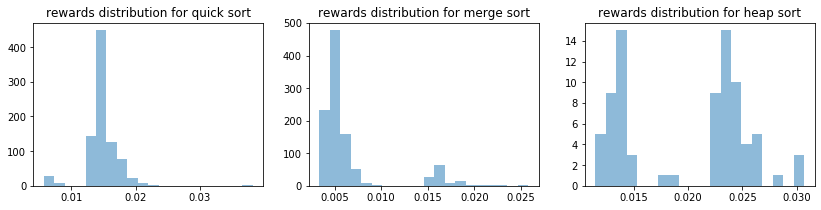

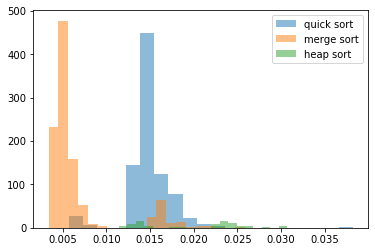

In [78]:
plot_rewards_distribution(arm_rewards_2)
plot_rewards_distribution_together(arm_rewards_2)

Restart at iteration: 37
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.018165249999973248, 'merge_sort': 0.01693340000005037, 'heap_sort': 0.02361719999998968}
Count per chosen algo {'quick_sort': 14, 'merge_sort': 20, 'heap_sort': 4}


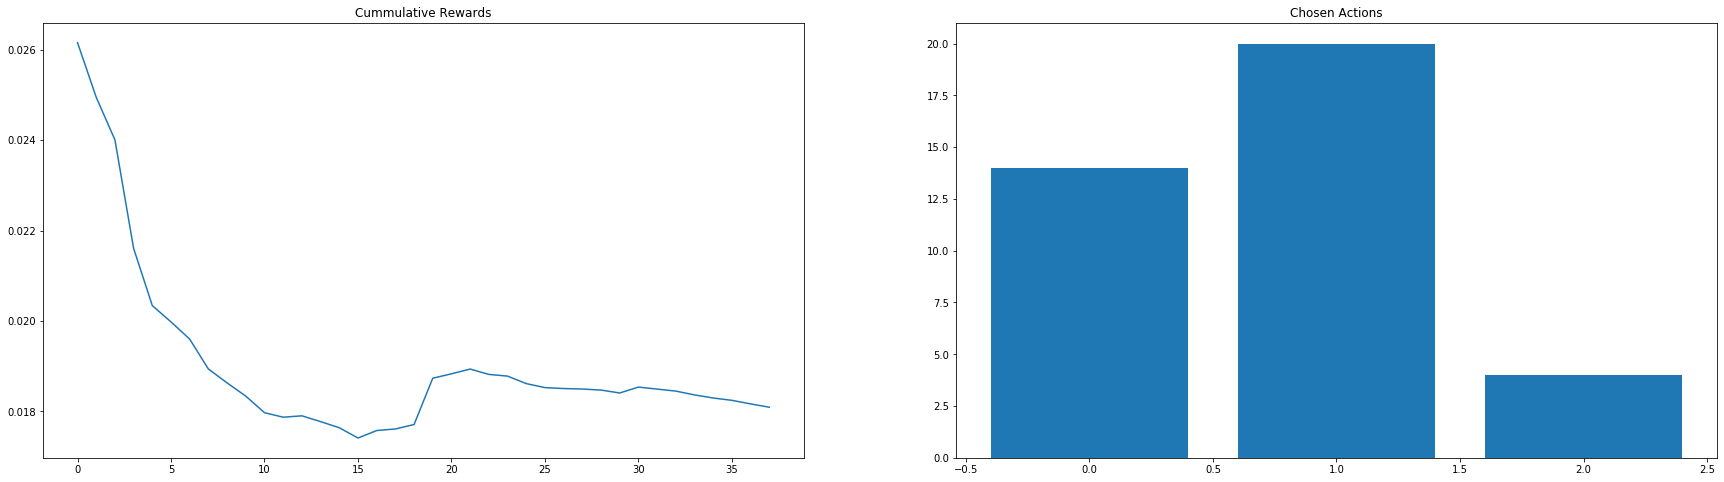

Restart at iteration: 66
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.014220086666652303, 'merge_sort': 0.01627494545453539, 'heap_sort': 0.023920133333300935}
Count per chosen algo {'quick_sort': 15, 'merge_sort': 11, 'heap_sort': 3}


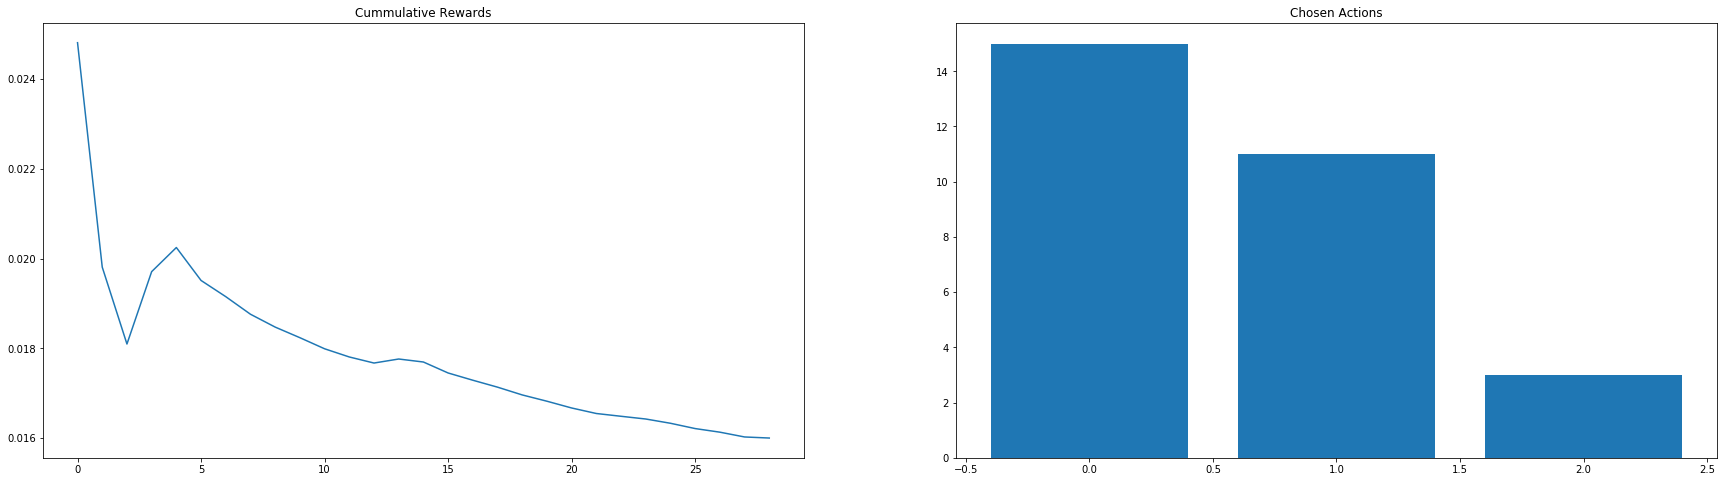

Restart at iteration: 99
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.014502939999974842, 'merge_sort': 0.016108916666704925, 'heap_sort': 0.02336450000007062}
Count per chosen algo {'quick_sort': 25, 'merge_sort': 6, 'heap_sort': 2}


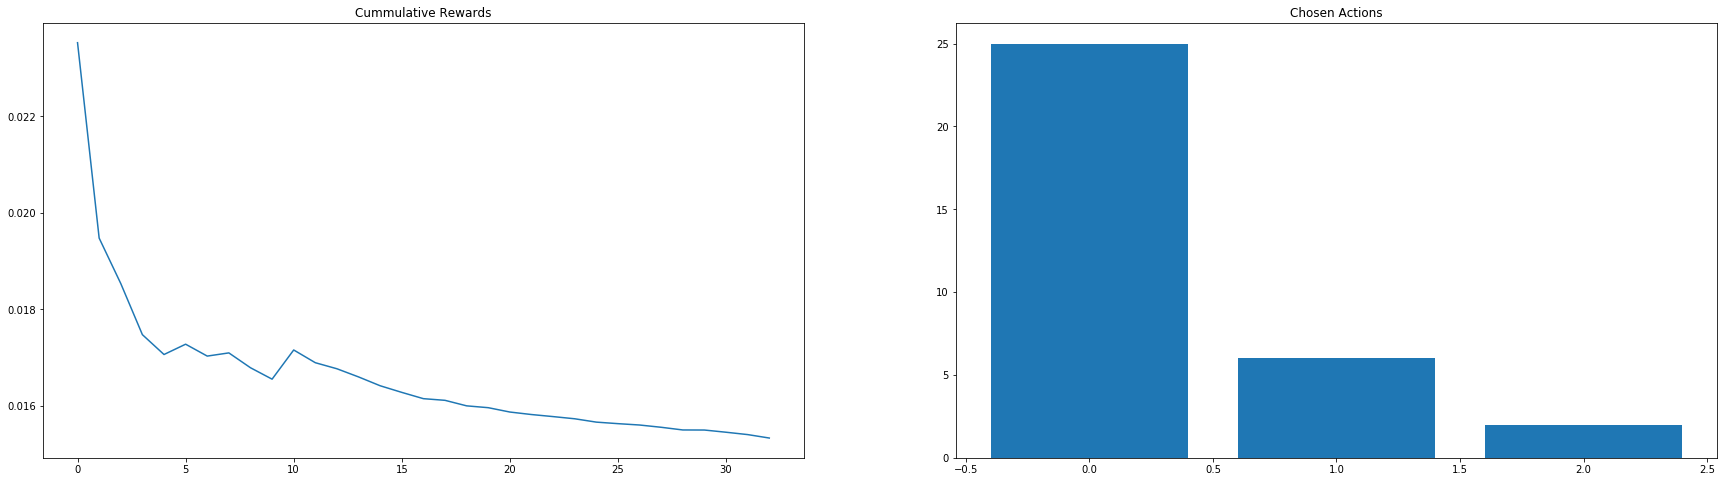

Restart at iteration: 228
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.014348728813581024, 'merge_sort': 0.016114274999978306, 'heap_sort': 0.023510700000012246}
Count per chosen algo {'quick_sort': 118, 'merge_sort': 8, 'heap_sort': 3}


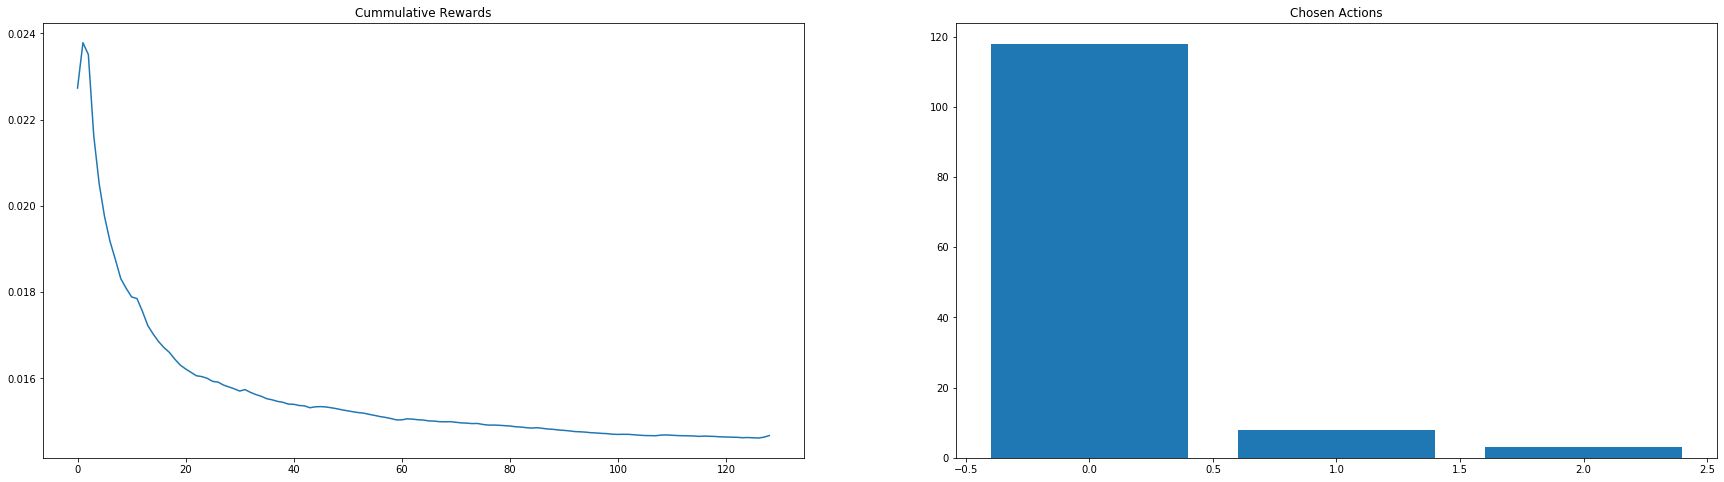

Restart at iteration: 397
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.014305990000009672, 'merge_sort': 0.01623028333331907, 'heap_sort': 0.025431833333338243}
Count per chosen algo {'quick_sort': 160, 'merge_sort': 6, 'heap_sort': 3}


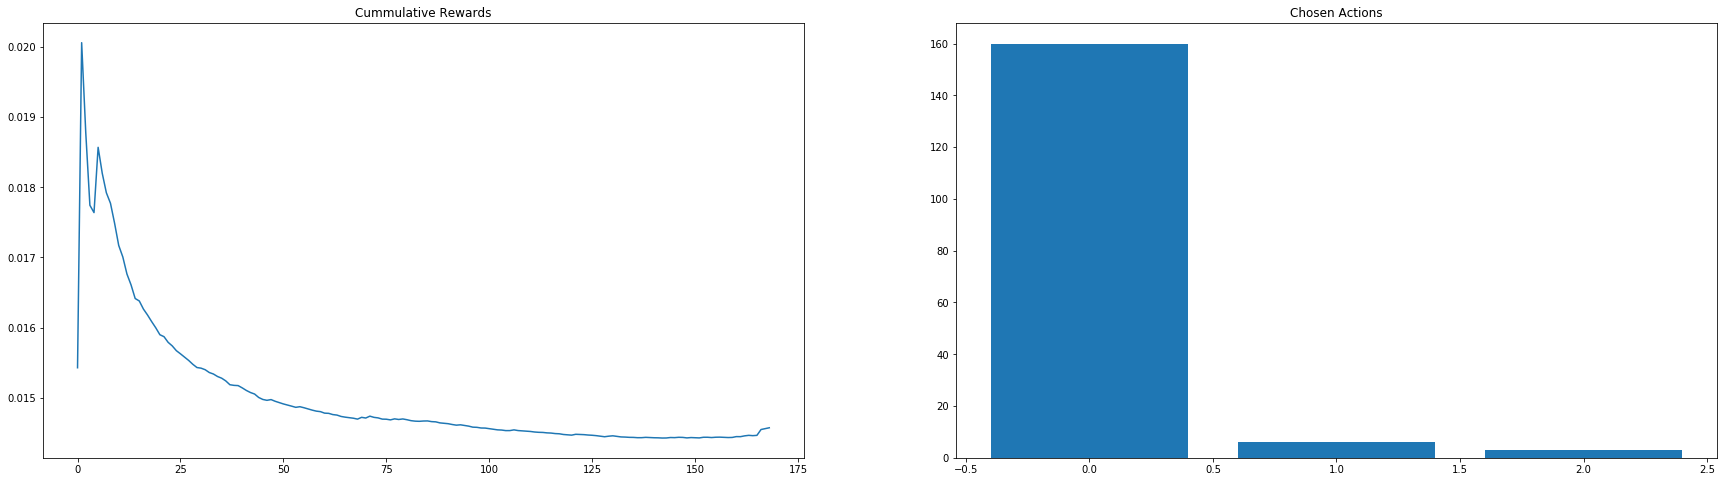

Restart at iteration: 475
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.015274191549320344, 'merge_sort': 0.016347924999934094, 'heap_sort': 0.025300366666670016}
Count per chosen algo {'quick_sort': 71, 'merge_sort': 4, 'heap_sort': 3}


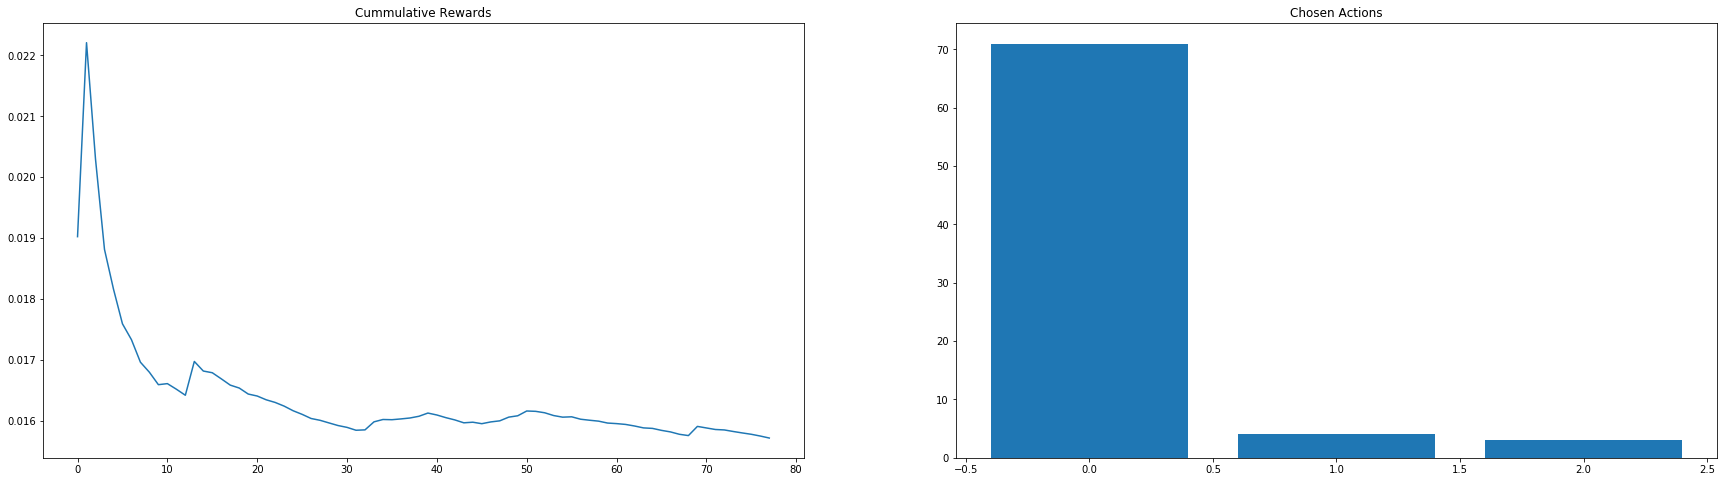

Restart at iteration: 501
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.017492300000043315, 'merge_sort': 0.014747399999990307, 'heap_sort': 0.027377049999927294}
Count per chosen algo {'quick_sort': 8, 'merge_sort': 16, 'heap_sort': 2}


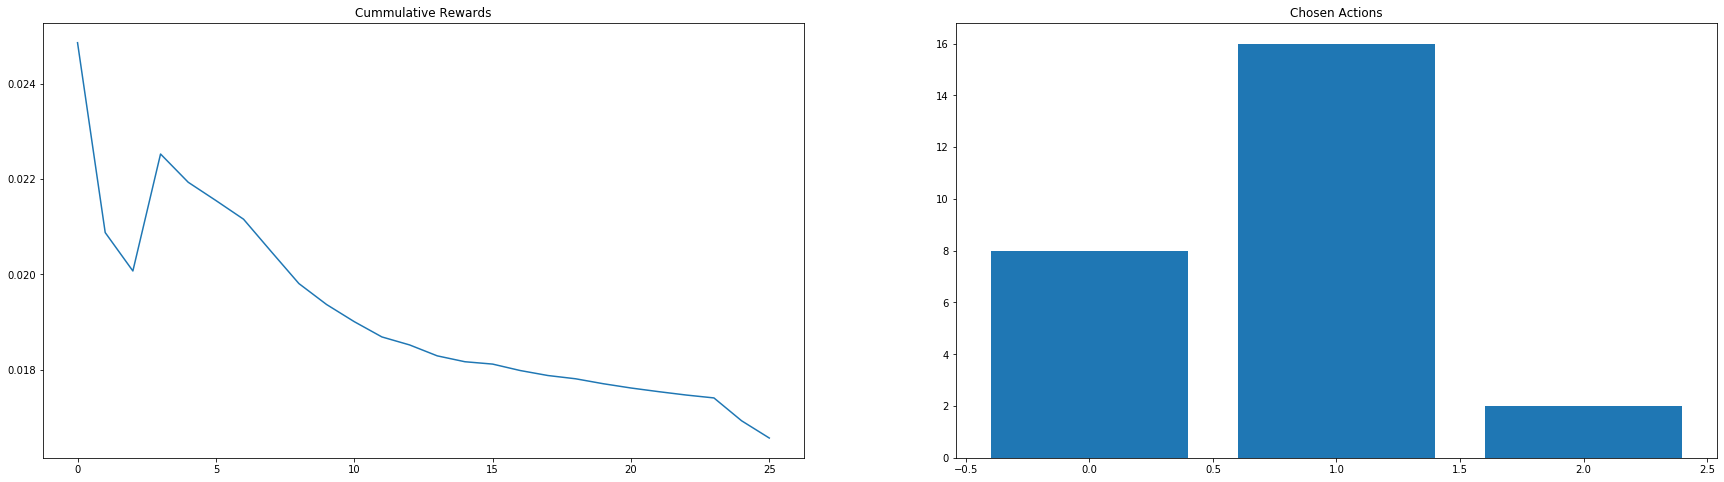

Restart at iteration: 541
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.008386650000034024, 'merge_sort': 0.004735834374997694, 'heap_sort': 0.014566250000067763}
Count per chosen algo {'quick_sort': 2, 'merge_sort': 32, 'heap_sort': 6}


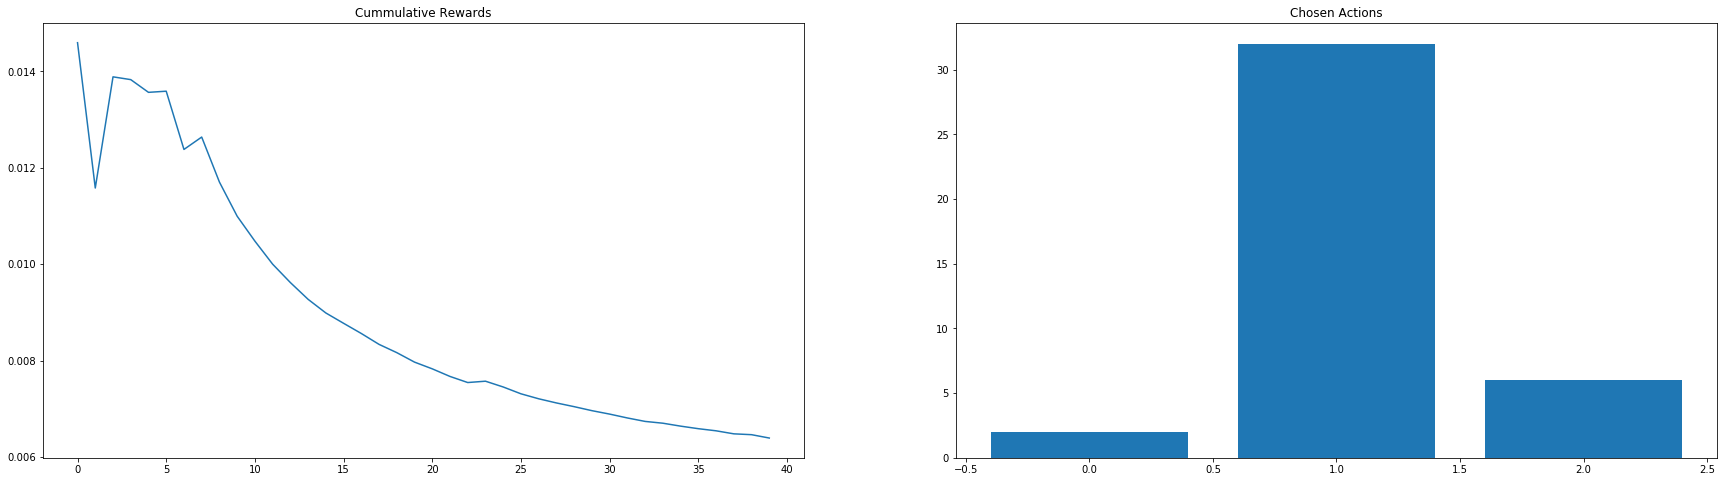

Restart at iteration: 636
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.007022746666719589, 'merge_sort': 0.005441937662332642, 'heap_sort': 0.015668533333382584}
Count per chosen algo {'quick_sort': 15, 'merge_sort': 77, 'heap_sort': 3}


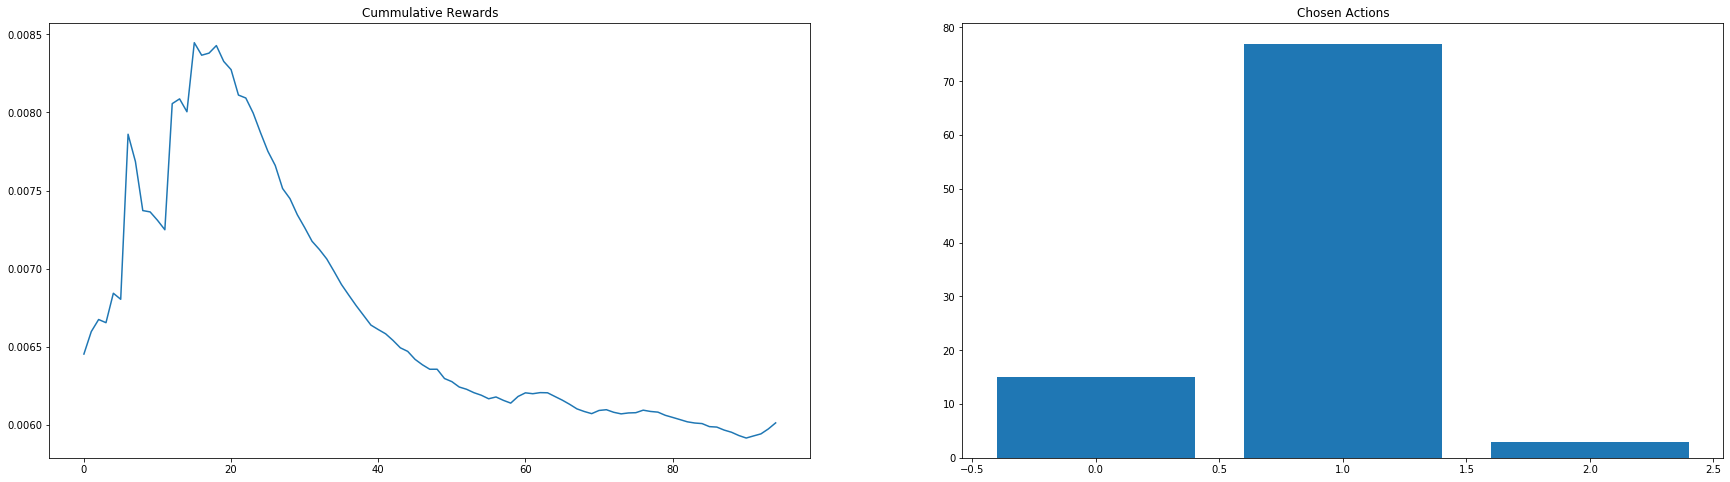

Restart at iteration: 788
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.007136114285653353, 'merge_sort': 0.005197235211259705, 'heap_sort': 0.014085666666687757}
Count per chosen algo {'quick_sort': 7, 'merge_sort': 142, 'heap_sort': 3}


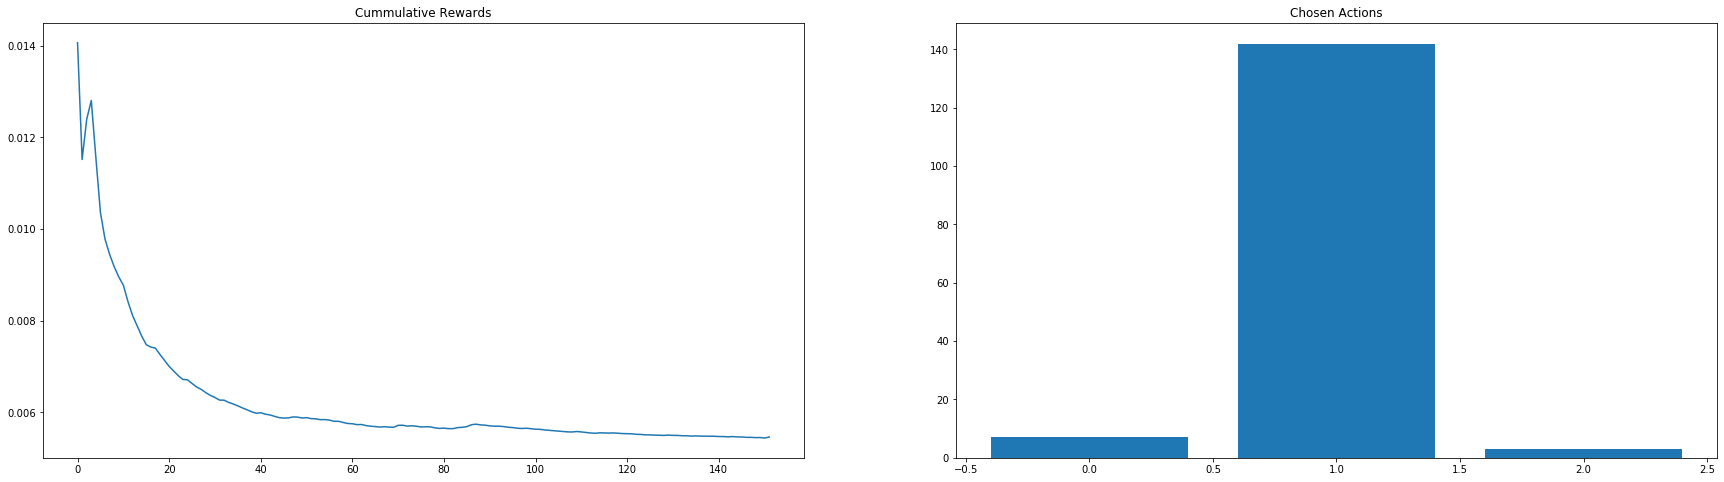

Restart at iteration: 1001
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.00626203999995596, 'merge_sort': 0.005200041798937649, 'heap_sort': 0.01301488421056188}
Count per chosen algo {'quick_sort': 5, 'merge_sort': 189, 'heap_sort': 19}


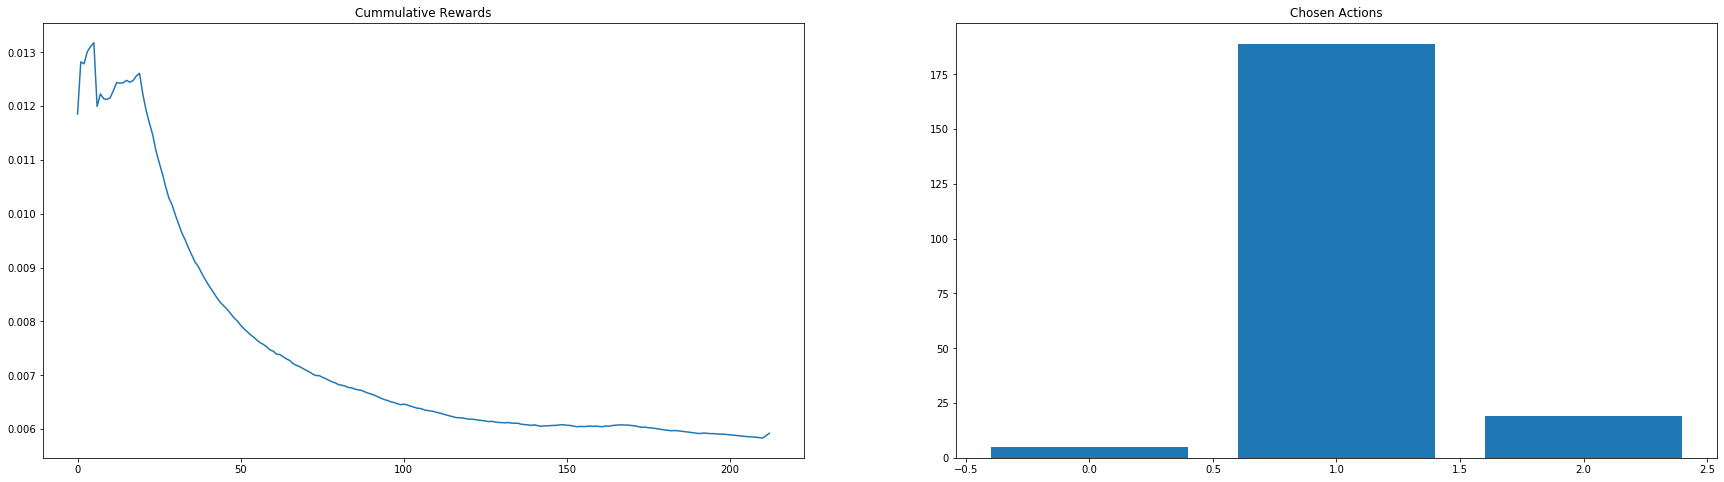

Restart at iteration: 1017
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.014293841666661441, 'merge_sort': 0.016055950000009034, 'heap_sort': 0.023568500000010317}
Count per chosen algo {'quick_sort': 12, 'merge_sort': 2, 'heap_sort': 2}


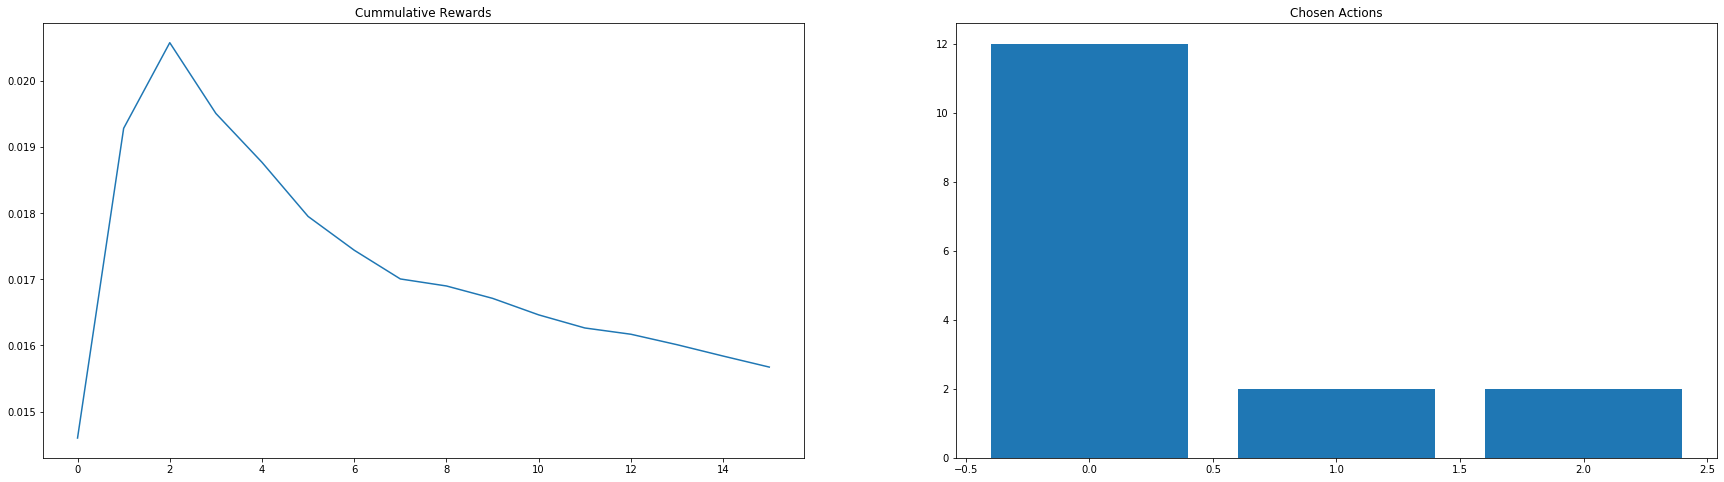

Restart at iteration: 1122
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.014309369512211671, 'merge_sort': 0.01602037333335223, 'heap_sort': 0.023533737499946028}
Count per chosen algo {'quick_sort': 82, 'merge_sort': 15, 'heap_sort': 8}


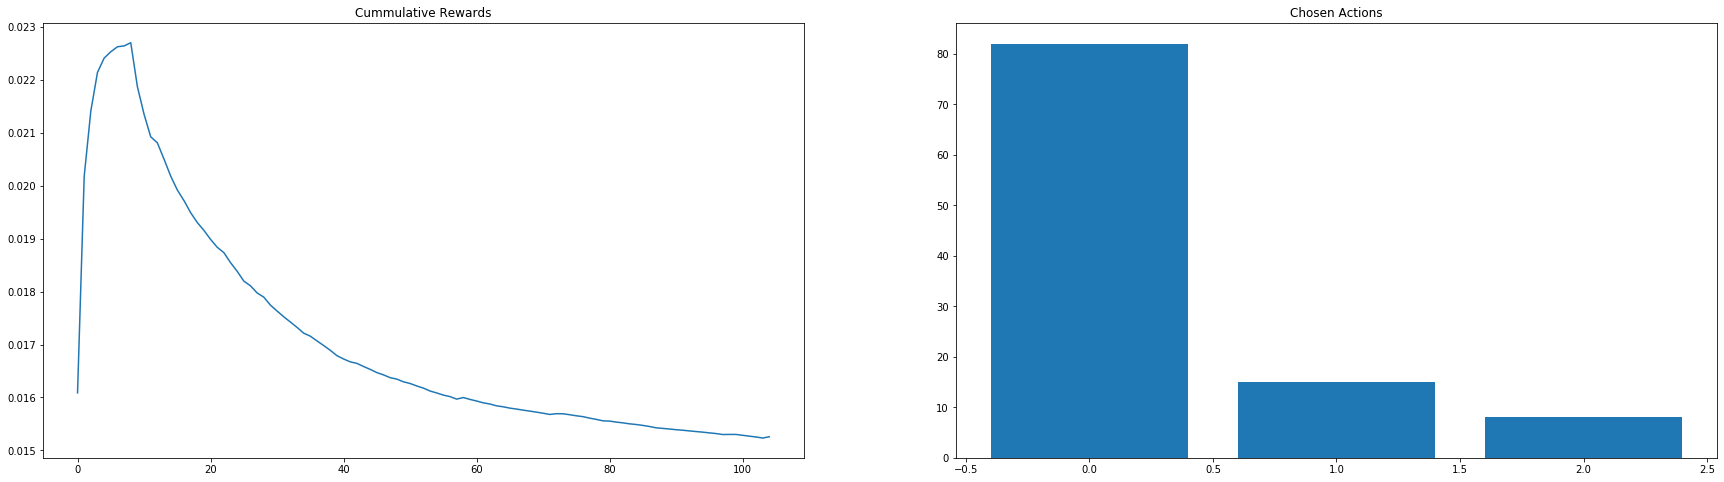

Restart at iteration: 1156
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.015161740740748227, 'merge_sort': 0.017414860000053524, 'heap_sort': 0.022495049999861294}
Count per chosen algo {'quick_sort': 27, 'merge_sort': 5, 'heap_sort': 2}


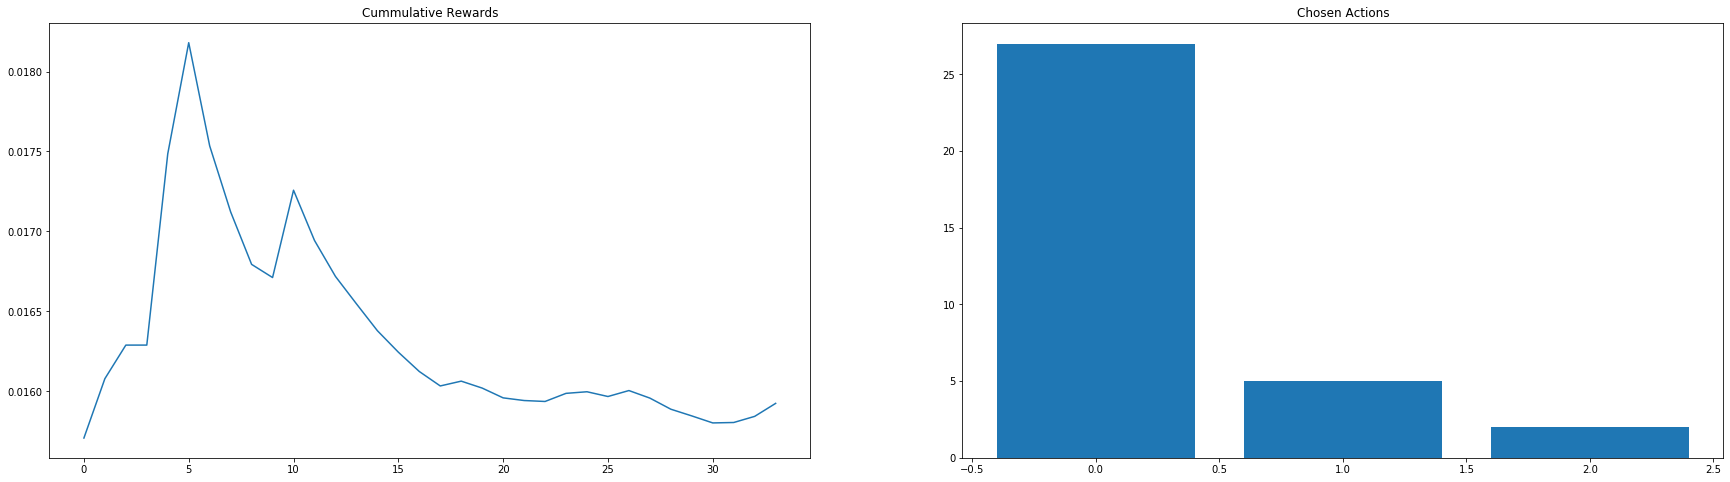

Restart at iteration: 1210
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.016181637777769233, 'merge_sort': 0.01809665714280787, 'heap_sort': 0.025905099999931736}
Count per chosen algo {'quick_sort': 45, 'merge_sort': 7, 'heap_sort': 2}


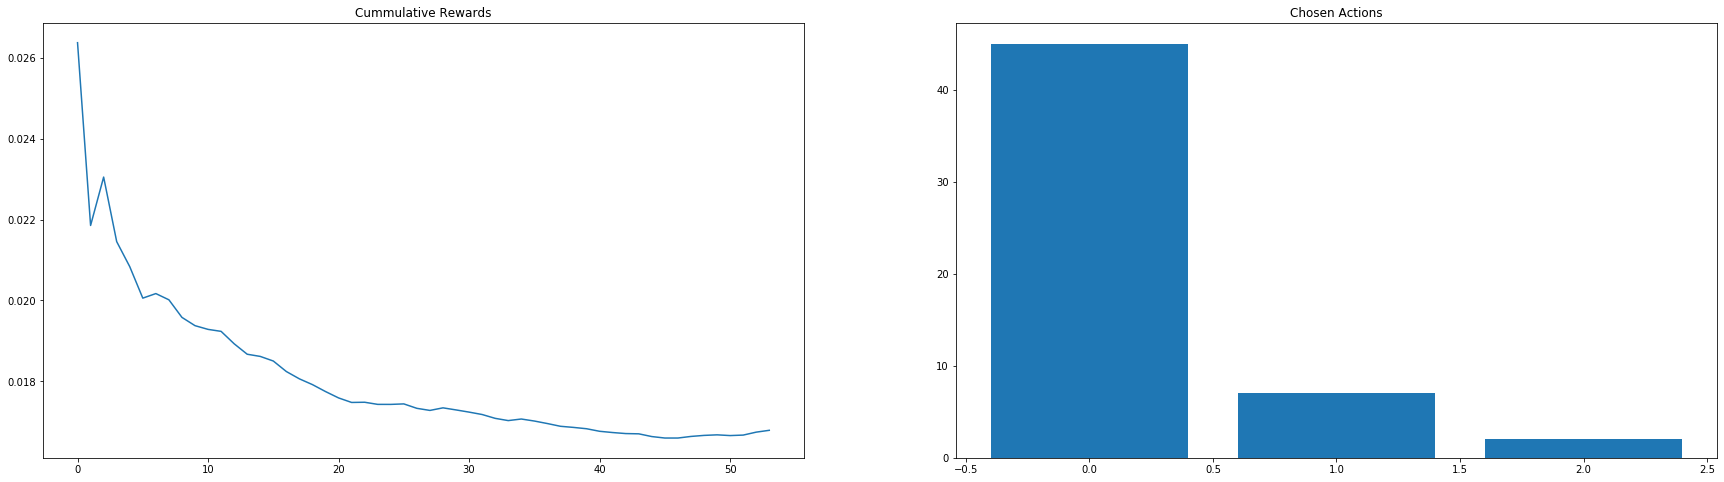

Restart at iteration: 1350
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.016769229457375953, 'merge_sort': 0.02043383749997929, 'heap_sort': 0.027047466666620796}
Count per chosen algo {'quick_sort': 129, 'merge_sort': 8, 'heap_sort': 3}


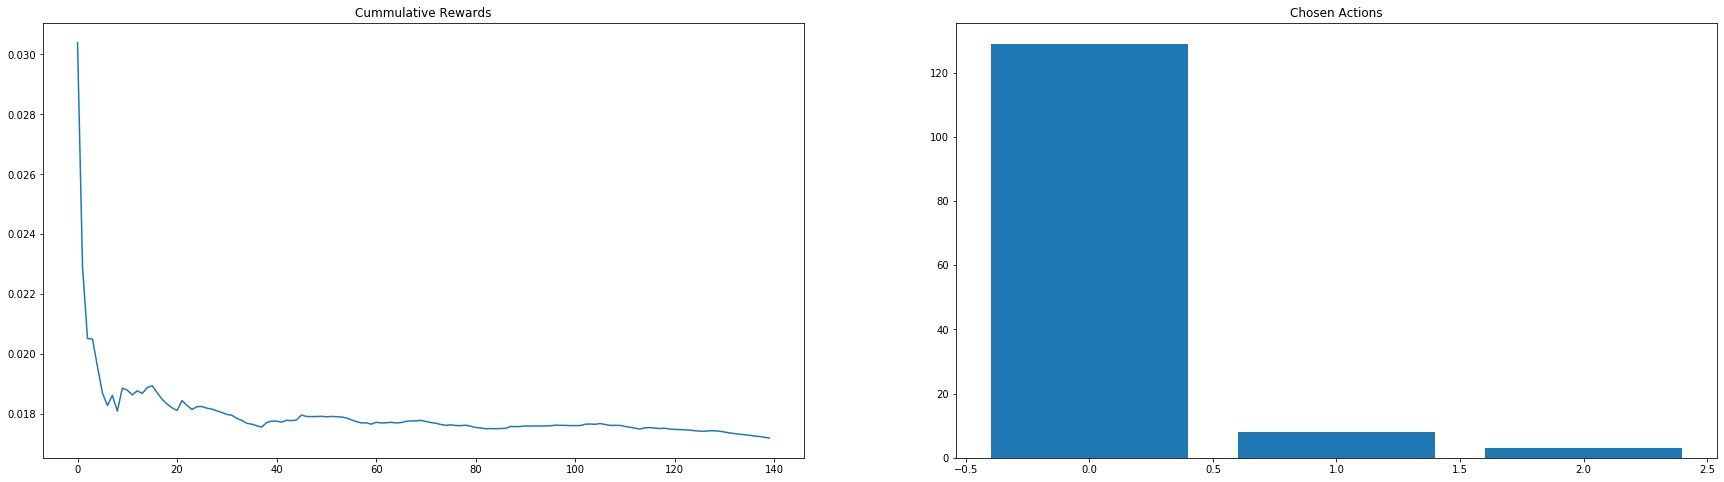

Restart at iteration: 1419
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.014755929508189675, 'merge_sort': 0.016422016666676125, 'heap_sort': 0.02324769999995624}
Count per chosen algo {'quick_sort': 61, 'merge_sort': 6, 'heap_sort': 2}


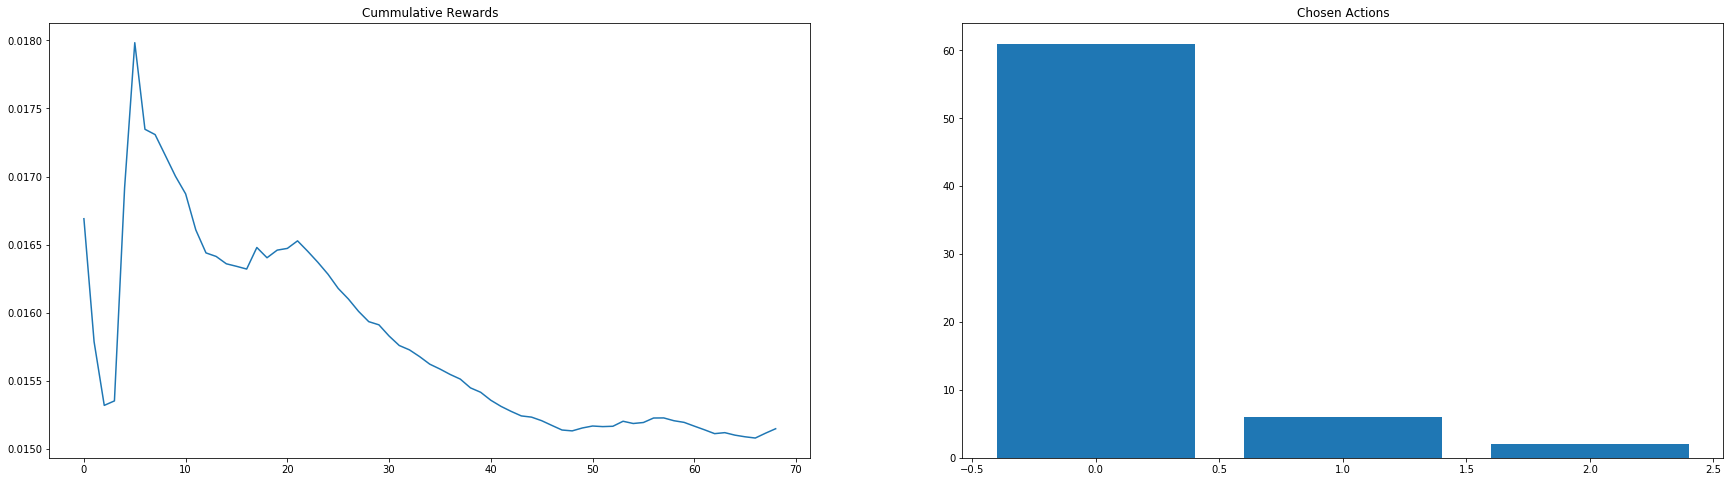

Restart at iteration: 1444
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.015649405555551412, 'merge_sort': 0.017137899999966066, 'heap_sort': 0.02557916666667855}
Count per chosen algo {'quick_sort': 18, 'merge_sort': 4, 'heap_sort': 3}


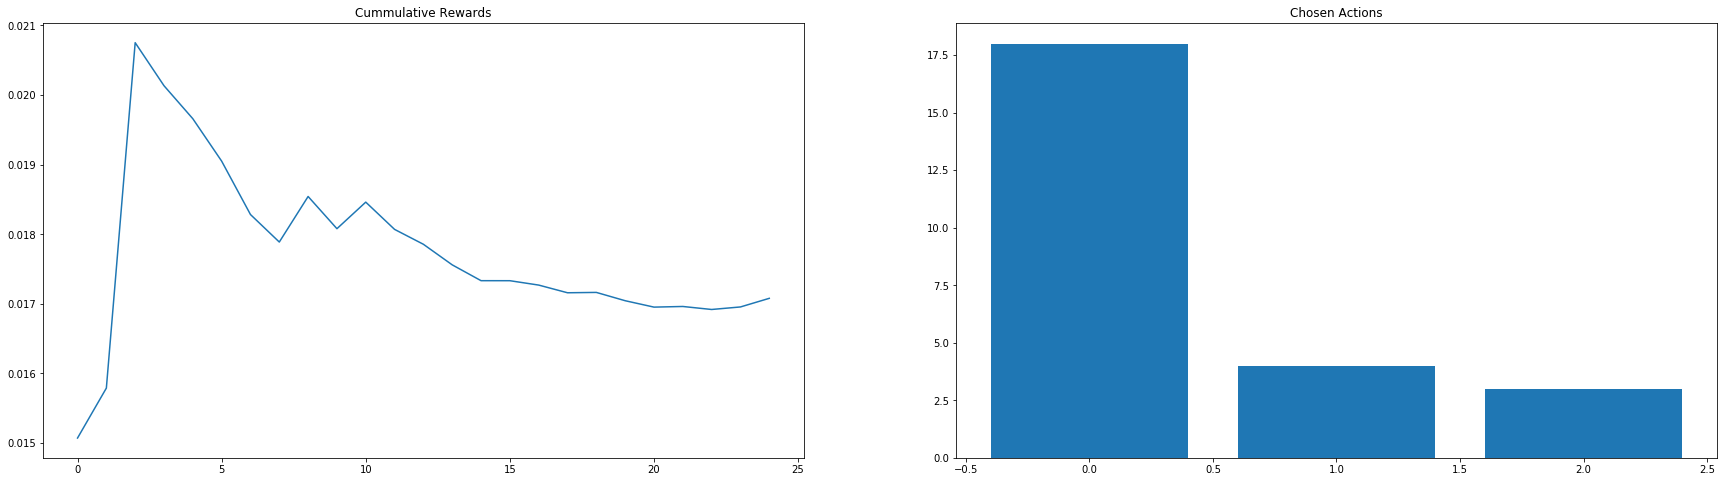

Restart at iteration: 1483
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.01565559142856208, 'merge_sort': 0.018185499999958665, 'heap_sort': 0.023546500000065862}
Count per chosen algo {'quick_sort': 35, 'merge_sort': 2, 'heap_sort': 2}


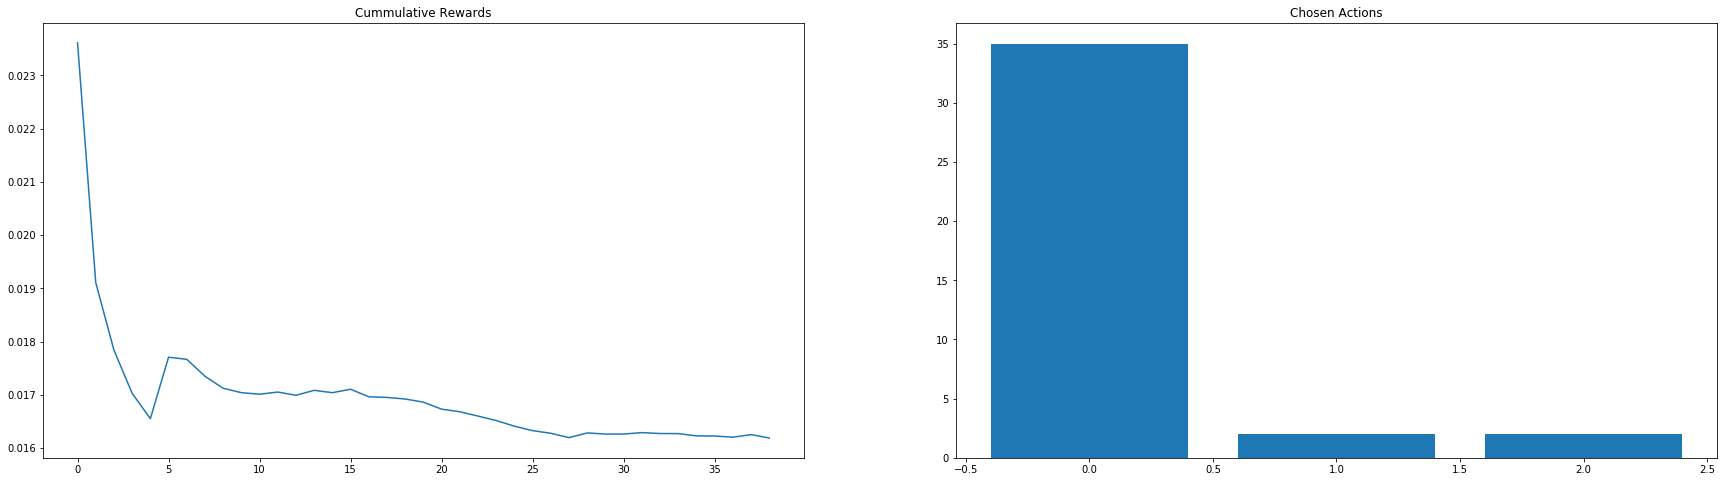

Restart at iteration: 1501
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.013613408333355892, 'merge_sort': 0.01679229999990639, 'heap_sort': 0.02582876666663954}
Count per chosen algo {'quick_sort': 12, 'merge_sort': 3, 'heap_sort': 3}


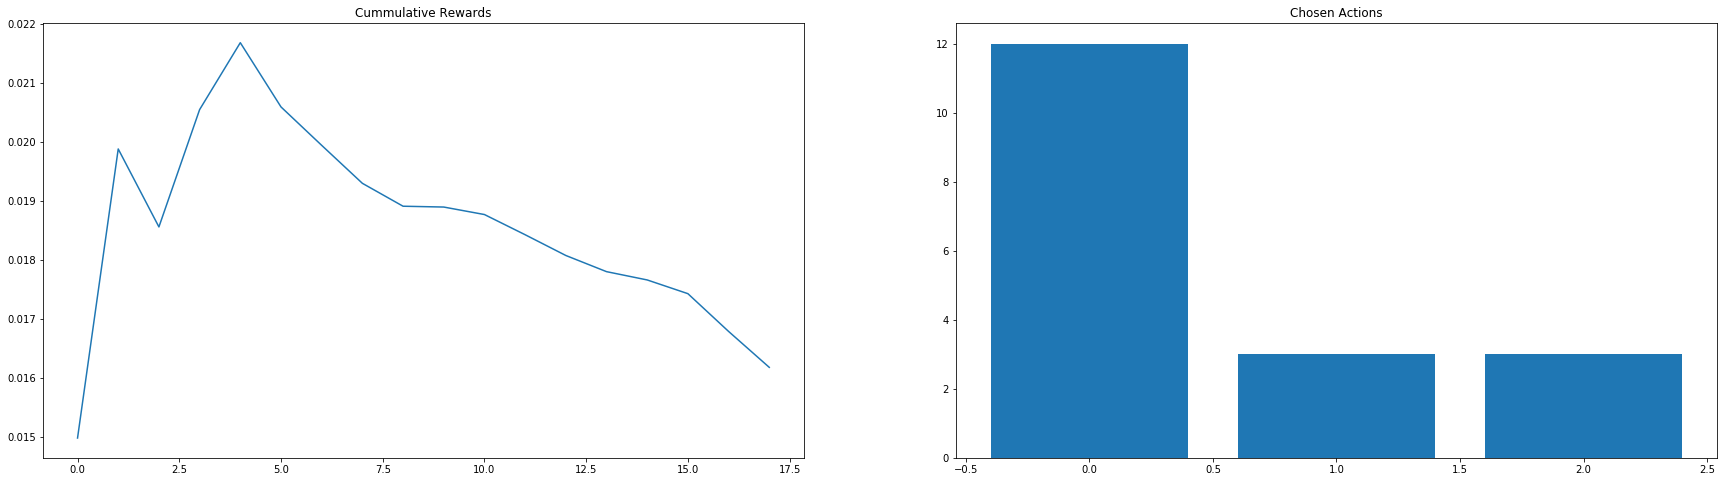

Restart at iteration: 1999
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.006595225000069149, 'merge_sort': 0.005129302647659375, 'heap_sort': 0.012832033333324944}
Count per chosen algo {'quick_sort': 4, 'merge_sort': 491, 'heap_sort': 3}


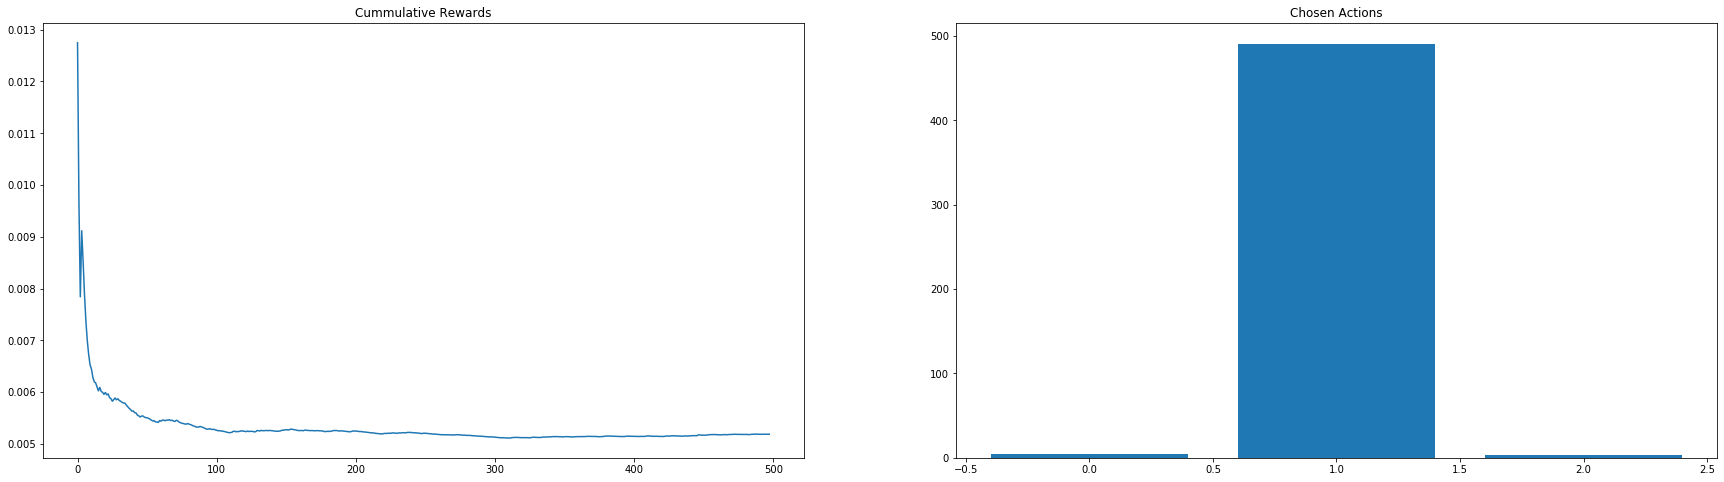

Total reward 21.2746


In [79]:
for elem in list_iteration_results_2:
    sample_mean, sample_count,rewards,cum_rewards,n = elem
    print("Restart at iteration:", n)
    print("Results up to this iteration: ")
    plot_history(rewards,cum_rewards, sample_count, sample_mean)
print("Total reward", np.round(total_reward_2,4))

## Three outliers in a row restart the expriment

In [80]:
list_iteration_results_3, total_reward_3, arm_rewards_3 = ts_quantile(list_distributions, n_samples, num_consec_elem=3)



Iteration: 0
Less than two values for quick_sort
quick_sort Theta 0.004289737596236243
Less than two values for merge_sort
merge_sort Theta 0.02975217925955479
Less than two values for heap_sort
heap_sort Theta 0.0910232059270496


Chosen algorithm is:  quick_sort with reward: 0.020102800000131538
Sample mean is:  0.020102800000131538 Sample variance is: 0.0


Iteration: 1
Less than two values for quick_sort
quick_sort Theta 0.05970930253784939
Less than two values for merge_sort
merge_sort Theta 0.0850236792076953
Less than two values for heap_sort
heap_sort Theta 0.08471425711484659


Chosen algorithm is:  quick_sort with reward: 0.01759530000003906
Sample mean is:  0.0188490500000853 Sample variance is: 1.5718890626159436e-06


Iteration: 2
quick_sort Theta 0.019705683442173487
Less than two values for merge_sort
merge_sort Theta 0.06739832889082252
Less than two values for heap_sort
heap_sort Theta 0.0757981918862384


Chosen algorithm is:  quick_sort with reward: 0.0158572000000



Iteration: 32
quick_sort Theta 0.015800523528699918
merge_sort Theta 0.0169265790205687
heap_sort Theta 0.025183159042116435


Chosen algorithm is:  quick_sort with reward: 0.013796899999988455
Sample mean is:  0.015431479999997465 Sample variance is: 2.93917831764425e-06


Iteration: 33
quick_sort Theta 0.015556177234702765
merge_sort Theta 0.014018619855337314
heap_sort Theta 0.02374972395481028


Chosen algorithm is:  merge_sort with reward: 0.016800699999976132
Sample mean is:  0.016681300000007986 Sample variance is: 2.642683656927709e-06


Iteration: 34
quick_sort Theta 0.015707305223696386
merge_sort Theta 0.017681822963026336
heap_sort Theta 0.024634532108692587


Chosen algorithm is:  quick_sort with reward: 0.01371289999997316
Sample mean is:  0.015365380769227298 Sample variance is: 2.9353607054450455e-06


Iteration: 35
quick_sort Theta 0.015325579357399224
merge_sort Theta 0.017058309017868922
heap_sort Theta 0.02508925523087897


Chosen algorithm is:  quick_sort with re


Chosen algorithm is:  quick_sort with reward: 0.014861899999914385
Sample mean is:  0.015411864285709953 Sample variance is: 1.8541019169456044e-06


Iteration: 66
quick_sort Theta 0.01522907254860484
merge_sort Theta 0.017137944697907647
heap_sort Theta 0.02132876372220959


Chosen algorithm is:  quick_sort with reward: 0.016925799999853552
Sample mean is:  0.015438424561396684 Sample variance is: 1.861078914834626e-06


Iteration: 67
quick_sort Theta 0.01573997735831067
merge_sort Theta 0.018586729108443494
heap_sort Theta 0.025059093072396836


Chosen algorithm is:  quick_sort with reward: 0.014220799999975497
Sample mean is:  0.015417431034475628 Sample variance is: 1.8541128531748254e-06


Iteration: 68
quick_sort Theta 0.015471759008303911
merge_sort Theta 0.01678723182099115
heap_sort Theta 0.02450831493271578


Chosen algorithm is:  quick_sort with reward: 0.01543149999997695
Sample mean is:  0.015417669491518023 Sample variance is: 1.8226905095777333e-06


Iteration: 69
quick


Chosen algorithm is:  quick_sort with reward: 0.01456640000014886
Sample mean is:  0.015459046067406418 Sample variance is: 1.7333863642935677e-06


Iteration: 100
quick_sort Theta 0.015260865278857831
merge_sort Theta 0.016405783279582923
heap_sort Theta 0.025645729320137048


Chosen algorithm is:  quick_sort with reward: 0.01896759999999631
Sample mean is:  0.01549802999999075 Sample variance is: 1.8493839987782547e-06


Iteration: 101
quick_sort Theta 0.015520849057589095
merge_sort Theta 0.016929043380657184
heap_sort Theta 0.024403027239048865


Chosen algorithm is:  quick_sort with reward: 0.014418999999861626
Sample mean is:  0.015486172527461858 Sample variance is: 1.841715066622387e-06


Iteration: 102
quick_sort Theta 0.01545600744307864
merge_sort Theta 0.01667605102593657
heap_sort Theta 0.026656411075780748


Chosen algorithm is:  quick_sort with reward: 0.013784100000066246
Sample mean is:  0.015467671739120602 Sample variance is: 1.8528438289954488e-06


Iteration: 103



Chosen algorithm is:  quick_sort with reward: 0.015133500000047206
Sample mean is:  0.015675930833320233 Sample variance is: 2.1826412791244054e-06


Iteration: 131
quick_sort Theta 0.0157250448733318
merge_sort Theta 0.01640971395927636
heap_sort Theta 0.02560431895963893


Chosen algorithm is:  quick_sort with reward: 0.015228499999921041
Sample mean is:  0.015672233057837593 Sample variance is: 2.1662437466680915e-06


Iteration: 132
quick_sort Theta 0.015810162957190597
merge_sort Theta 0.01590244994841983
heap_sort Theta 0.024981563906442565


Chosen algorithm is:  quick_sort with reward: 0.013952799999970011
Sample mean is:  0.015658139344248517 Sample variance is: 2.172522214674375e-06


Iteration: 133
quick_sort Theta 0.01592542024215121
merge_sort Theta 0.017110206247117572
heap_sort Theta 0.02631095637828711


Chosen algorithm is:  quick_sort with reward: 0.016418299999941155
Sample mean is:  0.015664319512180978 Sample variance is: 2.1595191584734064e-06


Iteration: 134
qu


Iteration: 160
quick_sort Theta 0.015683178357893283
merge_sort Theta 0.016857116846764438
heap_sort Theta 0.028576608059851415


Chosen algorithm is:  quick_sort with reward: 0.016291500000079395
Sample mean is:  0.015464520666654002 Sample variance is: 2.1026994218963575e-06


Iteration: 161
quick_sort Theta 0.015176132976955187
merge_sort Theta 0.01718577610024497
heap_sort Theta 0.02533503626646959


Chosen algorithm is:  quick_sort with reward: 0.015223399999968024
Sample mean is:  0.015462923841046809 Sample variance is: 2.0891567379649123e-06


Iteration: 162
quick_sort Theta 0.015439745423267315
merge_sort Theta 0.016871661333482137
heap_sort Theta 0.02400523437559355


Chosen algorithm is:  quick_sort with reward: 0.015050299999984418
Sample mean is:  0.015460209210513503 Sample variance is: 2.0765250378002437e-06


Iteration: 163
quick_sort Theta 0.015171122898342207
merge_sort Theta 0.016588449171157805
heap_sort Theta 0.02544155637214604


Chosen algorithm is:  quick_sort 



Chosen algorithm is:  quick_sort with reward: 0.015777100000150313
Sample mean is:  0.015401334782601996 Sample variance is: 1.8894125536778345e-06


Iteration: 195
quick_sort Theta 0.015157299543653326
merge_sort Theta 0.01658197896079896
heap_sort Theta 0.026258230125832383


Chosen algorithm is:  quick_sort with reward: 0.015251700000135315
Sample mean is:  0.015400525945940014 Sample variance is: 1.8793198887283646e-06


Iteration: 196
quick_sort Theta 0.015236011014183178
merge_sort Theta 0.016723521617352594
heap_sort Theta 0.027217734281861573


Chosen algorithm is:  quick_sort with reward: 0.013956100000086735
Sample mean is:  0.01539276021504833 Sample variance is: 1.8803727349710384e-06


Iteration: 197
quick_sort Theta 0.015452854700093534
merge_sort Theta 0.01660452866340077
heap_sort Theta 0.019411234592087254


Chosen algorithm is:  quick_sort with reward: 0.01422709999997096
Sample mean is:  0.015386526737962354 Sample variance is: 1.8775445258042064e-06


Iteration: 1

Chosen algorithm is:  merge_sort with reward: 0.016485000000102445
Sample mean is:  0.01679317777779943 Sample variance is: 2.2080399771170578e-06


Iteration: 232
quick_sort Theta 0.015274252626308788
merge_sort Theta 0.01678708917925096
heap_sort Theta 0.025771461722090605


Chosen algorithm is:  quick_sort with reward: 0.01347059999989142
Sample mean is:  0.015311028054290599 Sample variance is: 1.8916748466226792e-06


Iteration: 233
quick_sort Theta 0.015357476618935117
merge_sort Theta 0.016184616974453357
heap_sort Theta 0.023865816090756643


Chosen algorithm is:  quick_sort with reward: 0.014910600000121121
Sample mean is:  0.015309224324316863 Sample variance is: 1.8838727993968216e-06


Iteration: 234
quick_sort Theta 0.015149060094365414
merge_sort Theta 0.01683688862514166
heap_sort Theta 0.026577235726433928


Chosen algorithm is:  quick_sort with reward: 0.013737400000081834
Sample mean is:  0.015302175784746302 Sample variance is: 1.886454323347103e-06


Iteration: 235




Iteration: 261
quick_sort Theta 0.015221401210863968
merge_sort Theta 0.016152324732917025
heap_sort Theta 0.02579550832386462


Chosen algorithm is:  quick_sort with reward: 0.01459959999988314
Sample mean is:  0.015250718399994185 Sample variance is: 1.8511418555656082e-06


Iteration: 262
quick_sort Theta 0.015243764900161005
merge_sort Theta 0.016844296687623894
heap_sort Theta 0.025302470253712097


Chosen algorithm is:  quick_sort with reward: 0.014025500000116153
Sample mean is:  0.0152458370517875 Sample variance is: 1.849723678490688e-06


Iteration: 263
quick_sort Theta 0.015197328414884251
merge_sort Theta 0.01781700262940695
heap_sort Theta 0.026311773886692924


Chosen algorithm is:  quick_sort with reward: 0.015468699999928504
Sample mean is:  0.015246721428565837 Sample variance is: 1.8425798178571454e-06


Iteration: 264
quick_sort Theta 0.015166599795216998
merge_sort Theta 0.01671572774848223
heap_sort Theta 0.02693483302905493


Chosen algorithm is:  quick_sort wit


Iteration: 291
quick_sort Theta 0.01511549297329823
merge_sort Theta 0.018045970102806962
heap_sort Theta 0.02604360636279039


Chosen algorithm is:  quick_sort with reward: 0.01580769999986842
Sample mean is:  0.015195775268811332 Sample variance is: 1.7838100546736057e-06


Iteration: 292
quick_sort Theta 0.015302711304742167
merge_sort Theta 0.01646340768596679
heap_sort Theta 0.02414653466992744


Chosen algorithm is:  quick_sort with reward: 0.015851699999984703
Sample mean is:  0.015198117857136952 Sample variance is: 1.7789703783760114e-06


Iteration: 293
quick_sort Theta 0.01529896502170791
merge_sort Theta 0.016802240895920344
heap_sort Theta 0.021092170172067305


Chosen algorithm is:  quick_sort with reward: 0.015903499999922133
Sample mean is:  0.015200628113872842 Sample variance is: 1.7744039118233738e-06


Iteration: 294
quick_sort Theta 0.015148793552788524
merge_sort Theta 0.01664993824931245
heap_sort Theta 0.026770392782885517


Chosen algorithm is:  quick_sort wit

quick_sort Theta 0.015051301004698349
merge_sort Theta 0.016667579660045735
heap_sort Theta 0.025013163353068548


Chosen algorithm is:  quick_sort with reward: 0.015319999999974243
Sample mean is:  0.015200777316285545 Sample variance is: 1.7775200701691166e-06


Iteration: 326
quick_sort Theta 0.015245112680241387
merge_sort Theta 0.01688327761020407
heap_sort Theta 0.026404040277624795


Chosen algorithm is:  quick_sort with reward: 0.013379800000166142
Sample mean is:  0.015194978025469878 Sample variance is: 1.7823859234768469e-06


Iteration: 327
quick_sort Theta 0.015153613886222784
merge_sort Theta 0.016734798300648324
heap_sort Theta 0.028446953603184826


Chosen algorithm is:  quick_sort with reward: 0.01506599999993341
Sample mean is:  0.015194568571420557 Sample variance is: 1.7767801983880201e-06


Iteration: 328
quick_sort Theta 0.015245883886568104
merge_sort Theta 0.016053101429089868
heap_sort Theta 0.023385306668446064


Chosen algorithm is:  quick_sort with reward: 0


Chosen algorithm is:  quick_sort with reward: 0.014301300000170158
Sample mean is:  0.015202208069157223 Sample variance is: 1.7200277950733693e-06


Iteration: 360
quick_sort Theta 0.015283942328681306
merge_sort Theta 0.0179232691823682
heap_sort Theta 0.018954496016479146


Chosen algorithm is:  quick_sort with reward: 0.015197300000181713
Sample mean is:  0.015202193965510744 Sample variance is: 1.7150852554895934e-06


Iteration: 361
quick_sort Theta 0.015222353238843779
merge_sort Theta 0.016227329017382563
heap_sort Theta 0.027684940718681755


Chosen algorithm is:  quick_sort with reward: 0.013743599999997969
Sample mean is:  0.01519801461317403 Sample variance is: 1.7162494822020363e-06


Iteration: 362
quick_sort Theta 0.01527906672883
merge_sort Theta 0.016140991514761067
heap_sort Theta 0.02486782042971427


Chosen algorithm is:  quick_sort with reward: 0.013692700000092373
Sample mean is:  0.015193713714279512 Sample variance is: 1.7178016204768931e-06


Iteration: 363
qu


Chosen algorithm is:  quick_sort with reward: 0.015620800000078816
Sample mean is:  0.01524428439153032 Sample variance is: 1.8536694346299617e-06


Iteration: 392
quick_sort Theta 0.015228639809725695
merge_sort Theta 0.017455850571044026
heap_sort Theta 0.024162997007398015


Chosen algorithm is:  quick_sort with reward: 0.016614399999980378
Sample mean is:  0.015247899472291403 Sample variance is: 1.853718496021286e-06


Iteration: 393
quick_sort Theta 0.01531810376953628
merge_sort Theta 0.016974878743480457
heap_sort Theta 0.025843278380799004


Chosen algorithm is:  quick_sort with reward: 0.01596479999989242
Sample mean is:  0.015249786052627194 Sample variance is: 1.8501892207055367e-06


Iteration: 394
quick_sort Theta 0.015150142998615551
merge_sort Theta 0.016177152438119177
heap_sort Theta 0.021030079650532277


Chosen algorithm is:  quick_sort with reward: 0.015405100000180028
Sample mean is:  0.015250193700783501 Sample variance is: 1.845396228285995e-06


Iteration: 395



Iteration: 428
quick_sort Theta 0.01517630138052143
merge_sort Theta 0.016862035110898257
heap_sort Theta 0.026746317708302093


Chosen algorithm is:  quick_sort with reward: 0.014859699999988152
Sample mean is:  0.015258165542163953 Sample variance is: 1.9260215303792787e-06


Iteration: 429
quick_sort Theta 0.015362586398765792
merge_sort Theta 0.01674003360550451
heap_sort Theta 0.02753184950341379


Chosen algorithm is:  quick_sort with reward: 0.015139500000032058
Sample mean is:  0.015257880288456906 Sample variance is: 1.921425439347366e-06


Iteration: 430
quick_sort Theta 0.015272450828030087
merge_sort Theta 0.016852064021896533
heap_sort Theta 0.024822429169252043


Chosen algorithm is:  quick_sort with reward: 0.014511599999877944
Sample mean is:  0.0152560906474771 Sample variance is: 1.918150075452851e-06


Iteration: 431
quick_sort Theta 0.015298630196803888
merge_sort Theta 0.017539386811117105
heap_sort Theta 0.026211130725375776


Chosen algorithm is:  quick_sort wi


Chosen algorithm is:  quick_sort with reward: 0.015103299999964293
Sample mean is:  0.015287742410709118 Sample variance is: 1.916044533180849e-06


Iteration: 462
quick_sort Theta 0.015325956482010109
merge_sort Theta 0.01671099731173859
heap_sort Theta 0.02584866667876809


Chosen algorithm is:  quick_sort with reward: 0.01581579999992755
Sample mean is:  0.015288918485518069 Sample variance is: 1.912396825495152e-06


Iteration: 463
quick_sort Theta 0.015347769215387119
merge_sort Theta 0.016639365367930717
heap_sort Theta 0.025413657646837697


Chosen algorithm is:  quick_sort with reward: 0.017173799999909534
Sample mean is:  0.015293107111105604 Sample variance is: 1.9160245731281714e-06


Iteration: 464
quick_sort Theta 0.015266355535596228
merge_sort Theta 0.01949425948048642
heap_sort Theta 0.025012164145723492


Chosen algorithm is:  quick_sort with reward: 0.013962099999844213
Sample mean is:  0.015290155875825646 Sample variance is: 1.9156955869684276e-06


Iteration: 465


merge_sort Theta 0.017105714734597235
heap_sort Theta 0.025052574735446986


Chosen algorithm is:  quick_sort with reward: 0.01644299999998111
Sample mean is:  0.015310699999995318 Sample variance is: 1.9485943077376027e-06


Iteration: 496
quick_sort Theta 0.01533309262337988
merge_sort Theta 0.01828551626849316
heap_sort Theta 0.02580581660963924


Chosen algorithm is:  quick_sort with reward: 0.015073000000029424
Sample mean is:  0.015310207867490213 Sample variance is: 1.9446766886948486e-06


Iteration: 497
quick_sort Theta 0.015243809561610833
merge_sort Theta 0.017071598420761298
heap_sort Theta 0.025167007046289106


Chosen algorithm is:  quick_sort with reward: 0.015961999999944965
Sample mean is:  0.01531155454544983 Sample variance is: 1.9415347022095926e-06


Iteration: 498
quick_sort Theta 0.015324541963121737
merge_sort Theta 0.017335721711173473
heap_sort Theta 0.024360288100706368


Chosen algorithm is:  quick_sort with reward: 0.016548199999988356
Sample mean is:  0.01

heap_sort Theta 0.04252683531932525


Chosen algorithm is:  merge_sort with reward: 0.007384399999864399
Sample mean is:  0.005264299999998912 Sample variance is: 9.284399298961257e-07


Iteration: 527
quick_sort Theta 0.00581286008300423
merge_sort Theta 0.004929563445486139
Less than two values for heap_sort
heap_sort Theta 0.09889437890169718


Chosen algorithm is:  merge_sort with reward: 0.004736699999966731
Sample mean is:  0.00523917619047357 Sample variance is: 8.9685262076429e-07


Iteration: 528
quick_sort Theta 0.005292816852357788
merge_sort Theta 0.00464389047658576
Less than two values for heap_sort
heap_sort Theta 0.05814815743058806


Chosen algorithm is:  merge_sort with reward: 0.005197599999974045
Sample mean is:  0.005237286363632682 Sample variance is: 8.561615929029908e-07


Iteration: 529
quick_sort Theta 0.007314337765877836
merge_sort Theta 0.0052104907336988325
Less than two values for heap_sort
heap_sort Theta 0.005625388205531124


Chosen algorithm is:  merg

Less than two values for heap_sort
heap_sort Theta 0.052919035404442816


Chosen algorithm is:  merge_sort with reward: 0.004652200000009543
Sample mean is:  0.005190535416678206 Sample variance is: 7.847585084759891e-07


Iteration: 556
quick_sort Theta 0.005933402976558961
merge_sort Theta 0.005199216642049897
Less than two values for heap_sort
heap_sort Theta 0.02487174941272631


Chosen algorithm is:  merge_sort with reward: 0.004272799999853305
Sample mean is:  0.00517180612245729 Sample variance is: 7.855807788878282e-07


Iteration: 557
quick_sort Theta 0.005993338824329826
merge_sort Theta 0.005057078930772664
Less than two values for heap_sort
heap_sort Theta 0.046909177163269214


Chosen algorithm is:  merge_sort with reward: 0.005419900000106281
Sample mean is:  0.00517676800001027 Sample variance is: 7.710755545237592e-07


Iteration: 558
quick_sort Theta 0.006720533230560172
merge_sort Theta 0.005326006775510244
Less than two values for heap_sort
heap_sort Theta 0.01371881

Iteration: 583
quick_sort Theta 0.006435985824987952
merge_sort Theta 0.005258854882393836
heap_sort Theta 0.014687124405477547


Chosen algorithm is:  merge_sort with reward: 0.006994299999860232
Sample mean is:  0.005301466216220999 Sample variance is: 1.0206118230137251e-06


Iteration: 584
quick_sort Theta 0.00583763721435656
merge_sort Theta 0.0051734376404964375
heap_sort Theta 0.01533421972760569


Chosen algorithm is:  merge_sort with reward: 0.004052799999954004
Sample mean is:  0.005284817333337438 Sample variance is: 1.0275153776675584e-06


Iteration: 585
quick_sort Theta 0.006306139287824488
merge_sort Theta 0.0053669470827924495
heap_sort Theta 0.012617954407951947


Chosen algorithm is:  merge_sort with reward: 0.0038875000000189175
Sample mean is:  0.005266431578951669 Sample variance is: 1.039348135812762e-06


Iteration: 586
quick_sort Theta 0.006426456905795655
merge_sort Theta 0.005141632060495144
heap_sort Theta 0.013845887826424617


Chosen algorithm is:  merge_so

heap_sort Theta 0.02427569790112509


Chosen algorithm is:  merge_sort with reward: 0.005898899999920104
Sample mean is:  0.005210055238101285 Sample variance is: 9.379233537002794e-07


Iteration: 615
quick_sort Theta 0.006506032884180314
merge_sort Theta 0.005098830421205658
heap_sort Theta 0.013965154175188826


Chosen algorithm is:  merge_sort with reward: 0.0067854999999781285
Sample mean is:  0.0052249179245340855 Sample variance is: 9.522694622147788e-07


Iteration: 616
quick_sort Theta 0.006431086170161437
merge_sort Theta 0.005257519063382571
heap_sort Theta 0.015411557760874323


Chosen algorithm is:  merge_sort with reward: 0.005573400000002948
Sample mean is:  0.005228174766360897 Sample variance is: 9.444940915952369e-07


Iteration: 617
quick_sort Theta 0.006345788145390915
merge_sort Theta 0.005107546623004941
heap_sort Theta 0.014109087439312528


Chosen algorithm is:  merge_sort with reward: 0.00480480000010175
Sample mean is:  0.005224254629636276 Sample variance is:



Chosen algorithm is:  heap_sort with reward: 0.012940800000023955
Sample mean is:  0.013618900000058906 Sample variance is: 1.0707373399231427e-06


Iteration: 645
quick_sort Theta 0.006407122707285426
merge_sort Theta 0.005290601932111239
heap_sort Theta 0.013874875774362277


Chosen algorithm is:  merge_sort with reward: 0.007094000000051892
Sample mean is:  0.005234664444454514 Sample variance is: 9.088737165078122e-07


Iteration: 646
quick_sort Theta 0.006889101042009992
merge_sort Theta 0.00533839736804886
heap_sort Theta 0.013363607757200845


Chosen algorithm is:  merge_sort with reward: 0.005026199999974779
Sample mean is:  0.005233131617656869 Sample variance is: 9.025080118623532e-07


Iteration: 647
quick_sort Theta 0.005703733319026447
merge_sort Theta 0.005214389923099538
heap_sort Theta 0.014826871711971473


Chosen algorithm is:  merge_sort with reward: 0.007482999999865569
Sample mean is:  0.005249554014607297 Sample variance is: 9.325988986779823e-07


Iteration: 64



Chosen algorithm is:  merge_sort with reward: 0.005494899999803238
Sample mean is:  0.005259741764714764 Sample variance is: 9.031336939493793e-07


Iteration: 681
quick_sort Theta 0.006257307102935277
merge_sort Theta 0.0052925292305058
heap_sort Theta 0.014107288934752032


Chosen algorithm is:  merge_sort with reward: 0.005219899999929112
Sample mean is:  0.00525950877193824 Sample variance is: 8.978614389167972e-07


Iteration: 682
quick_sort Theta 0.0069824539883196765
merge_sort Theta 0.005209496140135419
heap_sort Theta 0.012919547260808352


Chosen algorithm is:  merge_sort with reward: 0.005965399999922738
Sample mean is:  0.005263612790705591 Sample variance is: 8.955214621492469e-07


Iteration: 683
quick_sort Theta 0.006114228074175915
merge_sort Theta 0.005308025600556143
heap_sort Theta 0.014170472228575535


Chosen algorithm is:  merge_sort with reward: 0.004696199999898454
Sample mean is:  0.005260332947984163 Sample variance is: 8.921953048562427e-07


Iteration: 684



Chosen algorithm is:  merge_sort with reward: 0.00591220000001158
Sample mean is:  0.005273803414637569 Sample variance is: 9.125575946643205e-07


Iteration: 717
quick_sort Theta 0.0065902325468056
merge_sort Theta 0.0053453647569858195
heap_sort Theta 0.012904008880855833


Chosen algorithm is:  merge_sort with reward: 0.005568500000208587
Sample mean is:  0.005275233980586943 Sample variance is: 9.085472398098652e-07


Iteration: 718
quick_sort Theta 0.007145848623017003
merge_sort Theta 0.005310989886732458
heap_sort Theta 0.014978440321590132


Chosen algorithm is:  merge_sort with reward: 0.004554899999902773
Sample mean is:  0.00527175410628412 Sample variance is: 9.066526848930034e-07


Iteration: 719
quick_sort Theta 0.00667998501487356
merge_sort Theta 0.0052861800957666304
heap_sort Theta 0.013701219065274725


Chosen algorithm is:  merge_sort with reward: 0.004635400000097434
Sample mean is:  0.0052686947115428385 Sample variance is: 9.042312762639725e-07


Iteration: 720

heap_sort Theta 0.013649778129141013


Chosen algorithm is:  merge_sort with reward: 0.006855200000018158
Sample mean is:  0.00524795854701155 Sample variance is: 8.718618270368063e-07


Iteration: 747
quick_sort Theta 0.006392864726904033
merge_sort Theta 0.00521955660066342
heap_sort Theta 0.013345917152326438


Chosen algorithm is:  merge_sort with reward: 0.006924900000058187
Sample mean is:  0.005255094468088344 Sample variance is: 8.800673771987212e-07


Iteration: 748
quick_sort Theta 0.006382592135144769
merge_sort Theta 0.005233474878356478
heap_sort Theta 0.014188863077266752


Chosen algorithm is:  merge_sort with reward: 0.0047806000000036875
Sample mean is:  0.005253083898308324 Sample variance is: 8.772882399902717e-07


Iteration: 749
quick_sort Theta 0.006276340492632079
merge_sort Theta 0.005292258105504657
heap_sort Theta 0.012959316256025822


Chosen algorithm is:  merge_sort with reward: 0.005943000000115717
Sample mean is:  0.005255994936712575 Sample variance is: 



Chosen algorithm is:  merge_sort with reward: 0.0059703000001718465
Sample mean is:  0.005225927272731772 Sample variance is: 8.467740797074671e-07


Iteration: 777
quick_sort Theta 0.0063935572425291845
merge_sort Theta 0.005125794079639566
heap_sort Theta 0.014093201793029081


Chosen algorithm is:  merge_sort with reward: 0.00600599999984297
Sample mean is:  0.005228870943400116 Sample variance is: 8.458663178307473e-07


Iteration: 778
quick_sort Theta 0.006730785464639042
merge_sort Theta 0.005106096626374338
heap_sort Theta 0.012873217251766482


Chosen algorithm is:  merge_sort with reward: 0.004920099999935701
Sample mean is:  0.005227710150379573 Sample variance is: 8.430434409831572e-07


Iteration: 779
quick_sort Theta 0.00715098701284266
merge_sort Theta 0.005195528982590295
heap_sort Theta 0.012894954293772746


Chosen algorithm is:  merge_sort with reward: 0.006873900000073263
Sample mean is:  0.005233875655434606 Sample variance is: 8.499975532993054e-07


Iteration: 7

quick_sort Theta 0.006436793041516439
merge_sort Theta 0.005221894114200436
heap_sort Theta 0.014539860503190028


Chosen algorithm is:  merge_sort with reward: 0.004462000000103217
Sample mean is:  0.005248562333336698 Sample variance is: 8.809290636731792e-07


Iteration: 813
quick_sort Theta 0.006545463069456012
merge_sort Theta 0.005219833179429713
heap_sort Theta 0.01400916937407026


Chosen algorithm is:  merge_sort with reward: 0.005036499999960142
Sample mean is:  0.005247857807312191 Sample variance is: 8.781512961187981e-07


Iteration: 814
quick_sort Theta 0.0064907926470188105
merge_sort Theta 0.005233916337209937
heap_sort Theta 0.013845187853100903


Chosen algorithm is:  merge_sort with reward: 0.006605899999840403
Sample mean is:  0.005252354635764271 Sample variance is: 8.81330171674419e-07


Iteration: 815
quick_sort Theta 0.006611103497770025
merge_sort Theta 0.005219562243143519
heap_sort Theta 0.015107551490333125


Chosen algorithm is:  merge_sort with reward: 0.0


Iteration: 847
quick_sort Theta 0.00660150112349564
merge_sort Theta 0.005321484666005231
heap_sort Theta 0.013986421880206254


Chosen algorithm is:  merge_sort with reward: 0.00700050000000374
Sample mean is:  0.005289118208956192 Sample variance is: 9.608350531237225e-07


Iteration: 848
quick_sort Theta 0.006206847629750936
merge_sort Theta 0.005305126864848511
heap_sort Theta 0.013432399110753623


Chosen algorithm is:  merge_sort with reward: 0.004378199999791832
Sample mean is:  0.005286407142857489 Sample variance is: 9.604376345855912e-07


Iteration: 849
quick_sort Theta 0.006210167615150759
merge_sort Theta 0.005381592231401636
heap_sort Theta 0.012569744097817068


Chosen algorithm is:  merge_sort with reward: 0.004239500000039698
Sample mean is:  0.0052833005934722725 Sample variance is: 9.608302893700317e-07


Iteration: 850
quick_sort Theta 0.006333582895535721
merge_sort Theta 0.00527881098594263
heap_sort Theta 0.013389895556201263


Chosen algorithm is:  merge_sort w



Iteration: 883
quick_sort Theta 0.006363762969701135
merge_sort Theta 0.005323923139333011
heap_sort Theta 0.013788940842336403


Chosen algorithm is:  merge_sort with reward: 0.005222200000162047
Sample mean is:  0.005294471967654881 Sample variance is: 9.454480778577858e-07


Iteration: 884
quick_sort Theta 0.0062845311163529744
merge_sort Theta 0.005315556462437344
heap_sort Theta 0.013818702165536208


Chosen algorithm is:  merge_sort with reward: 0.005259300000034273
Sample mean is:  0.0052943774193548255 Sample variance is: 9.429098672771372e-07


Iteration: 885
quick_sort Theta 0.0064778264523759135
merge_sort Theta 0.005232637664721796
heap_sort Theta 0.01366917870875221


Chosen algorithm is:  merge_sort with reward: 0.0047274999999444844
Sample mean is:  0.005292857640750509 Sample variance is: 9.412411772320618e-07


Iteration: 886
quick_sort Theta 0.005912816312560595
merge_sort Theta 0.0052235165641131955
heap_sort Theta 0.013863227598286416


Chosen algorithm is:  merge



Iteration: 913
quick_sort Theta 0.006252963357084206
merge_sort Theta 0.005310196763225182
heap_sort Theta 0.01441919435913027


Chosen algorithm is:  merge_sort with reward: 0.005873400000155016
Sample mean is:  0.005298076558602178 Sample variance is: 9.470720225885641e-07


Iteration: 914
quick_sort Theta 0.006288761555162501
merge_sort Theta 0.00532669509103811
heap_sort Theta 0.013646147907762762


Chosen algorithm is:  merge_sort with reward: 0.004125400000020818
Sample mean is:  0.00529515945273506 Sample variance is: 9.481284341974903e-07


Iteration: 915
quick_sort Theta 0.00710413991312694
merge_sort Theta 0.005231538074264085
heap_sort Theta 0.014147485294835503


Chosen algorithm is:  merge_sort with reward: 0.005550200000016048
Sample mean is:  0.005295792307691092 Sample variance is: 9.459367613510526e-07


Iteration: 916
quick_sort Theta 0.005996527832279365
merge_sort Theta 0.005307026040945047
heap_sort Theta 0.014034063901457046


Chosen algorithm is:  merge_sort wi



Chosen algorithm is:  merge_sort with reward: 0.005568200000197976
Sample mean is:  0.005272915046296168 Sample variance is: 9.292482891902124e-07


Iteration: 945
quick_sort Theta 0.006765761366867536
merge_sort Theta 0.0052711005182437334
heap_sort Theta 0.012041369565225668


Chosen algorithm is:  merge_sort with reward: 0.005551299999979165
Sample mean is:  0.0052735579676672605 Sample variance is: 9.272807855264958e-07


Iteration: 946
quick_sort Theta 0.0067653249667545415
merge_sort Theta 0.00521308460852022
heap_sort Theta 0.013052749704567785


Chosen algorithm is:  merge_sort with reward: 0.004251199999998789
Sample mean is:  0.005271202304147287 Sample variance is: 9.275469760729474e-07


Iteration: 947
quick_sort Theta 0.006227201839058194
merge_sort Theta 0.005265130413896309
heap_sort Theta 0.014069481063148506


Chosen algorithm is:  merge_sort with reward: 0.0056801000000632484
Sample mean is:  0.005272142298850542 Sample variance is: 9.257981622522212e-07


Iteration



Iteration: 979
quick_sort Theta 0.0062203840857523235
merge_sort Theta 0.00529228891635858
heap_sort Theta 0.013623941680013334


Chosen algorithm is:  merge_sort with reward: 0.004603200000019569
Sample mean is:  0.005280579014990071 Sample variance is: 9.393935455921666e-07


Iteration: 980
quick_sort Theta 0.0064966892143094165
merge_sort Theta 0.005271543898395376
heap_sort Theta 0.013197270445259856


Chosen algorithm is:  merge_sort with reward: 0.00790299999994204
Sample mean is:  0.005286182478633132 Sample variance is: 9.520495362675476e-07


Iteration: 981
quick_sort Theta 0.006606756170718426
merge_sort Theta 0.005321086813024042
heap_sort Theta 0.013361999407814584


Chosen algorithm is:  merge_sort with reward: 0.0048567999999704625
Sample mean is:  0.005285266950960077 Sample variance is: 9.504118532508598e-07


Iteration: 982
quick_sort Theta 0.006771550903100197
merge_sort Theta 0.005281064803778591
heap_sort Theta 0.013967701228455327


Chosen algorithm is:  merge_so

heap_sort Theta 0.04542920072206802


Chosen algorithm is:  quick_sort with reward: 0.017611099999840008
Sample mean is:  0.015990949999968508 Sample variance is: 1.9343365904575124e-06


Iteration: 1014
quick_sort Theta 0.016266028621308007
Less than two values for merge_sort
merge_sort Theta 0.01113900852264651
Less than two values for heap_sort
heap_sort Theta 0.05526827470211344


Chosen algorithm is:  merge_sort with reward: 0.017180199999984325
Sample mean is:  0.017180199999984325 Sample variance is: 0.0


Iteration: 1015
quick_sort Theta 0.01587829765465247
Less than two values for merge_sort
merge_sort Theta 0.03460096524083241
Less than two values for heap_sort
heap_sort Theta 0.0060289782231978785


Chosen algorithm is:  heap_sort with reward: 0.024298199999975623
Sample mean is:  0.0244801499999312 Sample variance is: 3.3105802483834605e-08


Iteration: 1016
quick_sort Theta 0.015570653537973428
Less than two values for merge_sort
merge_sort Theta 0.05179717587239141
heap_s



Iteration: 1042
quick_sort Theta 0.014833294249620965
merge_sort Theta 0.016529406689440487
heap_sort Theta 0.02485416547151523


Chosen algorithm is:  quick_sort with reward: 0.014564599999857819
Sample mean is:  0.014910285714267956 Sample variance is: 1.6729969943632802e-06


Iteration: 1043
quick_sort Theta 0.014982285756943494
merge_sort Theta 0.016138610113440085
heap_sort Theta 0.024423284827036693


Chosen algorithm is:  quick_sort with reward: 0.014543199999934586
Sample mean is:  0.014900088888869808 Sample variance is: 1.6301639893179787e-06


Iteration: 1044
quick_sort Theta 0.01462328987349233
merge_sort Theta 0.01662387487675488
heap_sort Theta 0.024550176475897967


Chosen algorithm is:  quick_sort with reward: 0.013714299999946888
Sample mean is:  0.014868040540520539 Sample variance is: 1.6230809818691726e-06


Iteration: 1045
quick_sort Theta 0.014889374741667405
merge_sort Theta 0.016449418339042204
heap_sort Theta 0.024147629285488262


Chosen algorithm is:  quick

Sample mean is:  0.01484025588234772 Sample variance is: 1.3514860225017957e-06


Iteration: 1078
quick_sort Theta 0.014825190306820411
merge_sort Theta 0.01689392109308287
heap_sort Theta 0.024128399796792193


Chosen algorithm is:  quick_sort with reward: 0.016004599999860147
Sample mean is:  0.014857130434775436 Sample variance is: 1.3512623038877253e-06


Iteration: 1079
quick_sort Theta 0.01475976072679434
merge_sort Theta 0.01755712373705101
heap_sort Theta 0.02434798062244748


Chosen algorithm is:  quick_sort with reward: 0.01511520000008204
Sample mean is:  0.014860817142851245 Sample variance is: 1.3328963920234287e-06


Iteration: 1080
quick_sort Theta 0.014886878592516486
merge_sort Theta 0.01667662522455097
heap_sort Theta 0.024555206290539294


Chosen algorithm is:  quick_sort with reward: 0.013942999999926542
Sample mean is:  0.01484789014083822 Sample variance is: 1.3258207200765117e-06


Iteration: 1081
quick_sort Theta 0.014864264366493117
merge_sort Theta 0.016823296



Chosen algorithm is:  quick_sort with reward: 0.01580669999998463
Sample mean is:  0.014961279611648068 Sample variance is: 1.269383523195047e-06


Iteration: 1113
quick_sort Theta 0.015011643706492184
merge_sort Theta 0.01657238231177992
heap_sort Theta 0.02445561700976283


Chosen algorithm is:  quick_sort with reward: 0.014250800000127128
Sample mean is:  0.014954448076921905 Sample variance is: 1.2619849086667158e-06


Iteration: 1114
quick_sort Theta 0.014921765360097915
merge_sort Theta 0.01706105318549036
heap_sort Theta 0.024280582950652857


Chosen algorithm is:  quick_sort with reward: 0.014596100000062506
Sample mean is:  0.014951035238094672 Sample variance is: 1.2511773415361611e-06


Iteration: 1115
quick_sort Theta 0.01484371942620589
merge_sort Theta 0.01670268728993726
heap_sort Theta 0.02424840688497372


Chosen algorithm is:  quick_sort with reward: 0.014160899999978938
Sample mean is:  0.014943581132074713 Sample variance is: 1.2452079698488123e-06


Iteration: 11



Iteration: 1148
quick_sort Theta 0.014874647762072552
merge_sort Theta 0.016555067695214504
heap_sort Theta 0.02430849592564318


Chosen algorithm is:  quick_sort with reward: 0.01464340000006814
Sample mean is:  0.014887319424453852 Sample variance is: 1.1384595879040658e-06


Iteration: 1149
quick_sort Theta 0.01505698269100603
merge_sort Theta 0.01655141700658841
heap_sort Theta 0.024202513554439902


Chosen algorithm is:  quick_sort with reward: 0.01428980000014235
Sample mean is:  0.014883051428565913 Sample variance is: 1.1328597283617769e-06


Iteration: 1150
quick_sort Theta 0.014846843383899314
merge_sort Theta 0.01686727092529971
heap_sort Theta 0.024268076204885775


Chosen algorithm is:  quick_sort with reward: 0.014796699999806151
Sample mean is:  0.014882439007085347 Sample variance is: 1.124877770612963e-06


Iteration: 1151
quick_sort Theta 0.014773599945809231
merge_sort Theta 0.016449848857287647
heap_sort Theta 0.024517283582636988


Chosen algorithm is:  quick_sor



Chosen algorithm is:  quick_sort with reward: 0.015792500000088694
Sample mean is:  0.014857798857131326 Sample variance is: 1.0880351721256073e-06


Iteration: 1185
quick_sort Theta 0.014835234244175129
merge_sort Theta 0.016063239572723324
heap_sort Theta 0.02482560562432563


Chosen algorithm is:  quick_sort with reward: 0.015341199999966193
Sample mean is:  0.014860545454533797 Sample variance is: 1.0831733186281368e-06


Iteration: 1186
quick_sort Theta 0.014988418066027579
merge_sort Theta 0.01706446878710922
heap_sort Theta 0.024311927987347083


Chosen algorithm is:  quick_sort with reward: 0.013677200000074663
Sample mean is:  0.01485385988699448 Sample variance is: 1.084920334503859e-06


Iteration: 1187
quick_sort Theta 0.014903347023127275
merge_sort Theta 0.01690902444488044
heap_sort Theta 0.024152904323976022


Chosen algorithm is:  quick_sort with reward: 0.014342700000042896
Sample mean is:  0.014850988202236326 Sample variance is: 1.0802849199278372e-06


Iteration:


Iteration: 1216
quick_sort Theta 0.016506163165106585
Less than two values for merge_sort
merge_sort Theta 0.06261409571970775
heap_sort Theta 0.02670147545420521


Chosen algorithm is:  quick_sort with reward: 0.01705210000000079
Sample mean is:  0.016749366666696613 Sample variance is: 1.3012464222972019e-07


Iteration: 1217
quick_sort Theta 0.016695508524133505
Less than two values for merge_sort
merge_sort Theta 0.08280625889999813
heap_sort Theta 0.487877106676035


Chosen algorithm is:  quick_sort with reward: 0.016342000000122425
Sample mean is:  0.016647525000053065 Sample variance is: 1.2870865686649595e-07


Iteration: 1218
quick_sort Theta 0.016747292170502234
Less than two values for merge_sort
merge_sort Theta 0.003088139502326004
heap_sort Theta 0.026847450691105272


Chosen algorithm is:  merge_sort with reward: 0.016867300000058094
Sample mean is:  0.016867300000058094 Sample variance is: 0.0


Iteration: 1219
quick_sort Theta 0.01676445330048414
Less than two values 



Chosen algorithm is:  quick_sort with reward: 0.018248699999958262
Sample mean is:  0.01520711515152498 Sample variance is: 1.6215875636871838e-06


Iteration: 1251
quick_sort Theta 0.015229953826424244
merge_sort Theta 0.017469051943712132
heap_sort Theta 0.02683476545417327


Chosen algorithm is:  quick_sort with reward: 0.014781500000026426
Sample mean is:  0.015194597058833845 Sample variance is: 1.5790649990866172e-06


Iteration: 1252
quick_sort Theta 0.015018092209913635
merge_sort Theta 0.0174180011047041
heap_sort Theta 0.026468967643469777


Chosen algorithm is:  quick_sort with reward: 0.013820500000065294
Sample mean is:  0.01515533714286903 Sample variance is: 1.5863544503087604e-06


Iteration: 1253
quick_sort Theta 0.014701343273041392
merge_sort Theta 0.017681046621261604
heap_sort Theta 0.025899013994230117


Chosen algorithm is:  quick_sort with reward: 0.01535039999998844
Sample mean is:  0.015160755555566792 Sample variance is: 1.5433166207770094e-06


Iteration: 



Iteration: 1286
quick_sort Theta 0.014868626738585185
merge_sort Theta 0.01739852786294831
heap_sort Theta 0.02542673512431492


Chosen algorithm is:  quick_sort with reward: 0.01447720000010122
Sample mean is:  0.014790868115936235 Sample variance is: 1.1582460586842165e-06


Iteration: 1287
quick_sort Theta 0.014837430502802212
merge_sort Theta 0.01752144440028473
heap_sort Theta 0.024913451294660185


Chosen algorithm is:  quick_sort with reward: 0.014987599999813028
Sample mean is:  0.01479367857142019 Sample variance is: 1.142244693959182e-06


Iteration: 1288
quick_sort Theta 0.014725421046679477
merge_sort Theta 0.01726531221544469
heap_sort Theta 0.024747363286819608


Chosen algorithm is:  quick_sort with reward: 0.014072899999973743
Sample mean is:  0.014783526760554746 Sample variance is: 1.133370888992478e-06


Iteration: 1289
quick_sort Theta 0.014681488661574635
merge_sort Theta 0.014682613559257842
heap_sort Theta 0.025912631083333318


Chosen algorithm is:  quick_sort



Chosen algorithm is:  quick_sort with reward: 0.015740499999992608
Sample mean is:  0.014862797959174676 Sample variance is: 1.1308838118185856e-06


Iteration: 1316
quick_sort Theta 0.014683945672598326
merge_sort Theta 0.017403820321431774
heap_sort Theta 0.025730873637036394


Chosen algorithm is:  quick_sort with reward: 0.01534300000002986
Sample mean is:  0.01486764848483988 Sample variance is: 1.12176644773676e-06


Iteration: 1317
quick_sort Theta 0.01492513220752977
merge_sort Theta 0.017820415595171578
heap_sort Theta 0.026603400594392233


Chosen algorithm is:  quick_sort with reward: 0.014712299999928291
Sample mean is:  0.014866094999990764 Sample variance is: 1.1107877014618595e-06


Iteration: 1318
quick_sort Theta 0.01485181529573597
merge_sort Theta 0.01763766657783755
heap_sort Theta 0.02560874790249261


Chosen algorithm is:  quick_sort with reward: 0.013835900000003676
Sample mean is:  0.014855895049495842 Sample variance is: 1.1101937024374688e-06


Iteration: 13



Iteration: 1348
quick_sort Theta 0.014741550195598488
merge_sort Theta 0.01793422956446462
heap_sort Theta 0.02624217285369137


Chosen algorithm is:  quick_sort with reward: 0.016474199999947814
Sample mean is:  0.015062441984730153 Sample variance is: 1.6359171608935082e-06


Iteration: 1349
quick_sort Theta 0.015149325372978873
merge_sort Theta 0.01831391765313151
heap_sort Theta 0.02526908272336863


Chosen algorithm is:  quick_sort with reward: 0.018293299999868395
Sample mean is:  0.015086918181814533 Sample variance is: 1.702003882375019e-06


Iteration: 1350
quick_sort Theta 0.015095178013246864
merge_sort Theta 0.018410721477591818
heap_sort Theta 0.029602575658481557


Chosen algorithm is:  quick_sort with reward: 0.018741899999895395
Sample mean is:  0.015114399248115893 Sample variance is: 1.7888944493709113e-06


Iteration: 1351
quick_sort Theta 0.015043726410064082
merge_sort Theta 0.017717674485680002
heap_sort Theta 0.024823165826668308


Chosen algorithm is:  quick_s



Iteration: 1382
quick_sort Theta 0.015225299222980103
merge_sort Theta 0.0178377950068295
heap_sort Theta 0.026029248239439532


Chosen algorithm is:  quick_sort with reward: 0.019278400000075635
Sample mean is:  0.015206995151512467 Sample variance is: 1.908325682522735e-06


Iteration: 1383
quick_sort Theta 0.015147331007760827
merge_sort Theta 0.017081276646788487
heap_sort Theta 0.025294456049613334


Chosen algorithm is:  quick_sort with reward: 0.017754599999989296
Sample mean is:  0.015222342168671965 Sample variance is: 1.9356923490657154e-06


Iteration: 1384
quick_sort Theta 0.01520371947000406
merge_sort Theta 0.017489459693886784
heap_sort Theta 0.026628228660834176


Chosen algorithm is:  quick_sort with reward: 0.017828600000029837
Sample mean is:  0.015237948502991474 Sample variance is: 1.964531950283736e-06


Iteration: 1385
quick_sort Theta 0.015237474648184868
merge_sort Theta 0.017071368260274052
heap_sort Theta 0.025307636933705496


Chosen algorithm is:  quick_s


Iteration: 1413
quick_sort Theta 0.015371263008684946
merge_sort Theta 0.01744944069088572
heap_sort Theta 0.0259802201126183


Chosen algorithm is:  quick_sort with reward: 0.015492400000084672
Sample mean is:  0.015314628061217922 Sample variance is: 2.1278790076264814e-06


Iteration: 1414
quick_sort Theta 0.01555884974213091
merge_sort Theta 0.017854636790569107
heap_sort Theta 0.026682146251491914


Chosen algorithm is:  quick_sort with reward: 0.014500899999802641
Sample mean is:  0.015310497461921398 Sample variance is: 2.1204217140516087e-06


Iteration: 1415
quick_sort Theta 0.01512921018387352
merge_sort Theta 0.01734574310985756
heap_sort Theta 0.02528705261011997


Chosen algorithm is:  quick_sort with reward: 0.014117699999815159
Sample mean is:  0.0153044732323148 Sample variance is: 2.1168619079191315e-06


Iteration: 1416
quick_sort Theta 0.015100130495381945
merge_sort Theta 0.017205112036611757
heap_sort Theta 0.027258423425179378


Chosen algorithm is:  quick_sort w



Chosen algorithm is:  quick_sort with reward: 0.015912800000023708
Sample mean is:  0.015226999134195377 Sample variance is: 1.9187461886486254e-06


Iteration: 1449
quick_sort Theta 0.015233558187400834
merge_sort Theta 0.015654781668832607
heap_sort Theta 0.02440863318123876


Chosen algorithm is:  quick_sort with reward: 0.014857099999971979
Sample mean is:  0.015225404741375447 Sample variance is: 1.9110629533741725e-06


Iteration: 1450
quick_sort Theta 0.015127966569266536
merge_sort Theta 0.017616324548865966
heap_sort Theta 0.026520841907145595


Chosen algorithm is:  quick_sort with reward: 0.013921800000161966
Sample mean is:  0.015219809871241484 Sample variance is: 1.910123163111112e-06


Iteration: 1451
quick_sort Theta 0.015247958845556131
merge_sort Theta 0.017398686389864765
heap_sort Theta 0.026675309254391016


Chosen algorithm is:  quick_sort with reward: 0.015897200000154044
Sample mean is:  0.015222704700852222 Sample variance is: 1.9039127925753595e-06


Iterati



Chosen algorithm is:  quick_sort with reward: 0.01567750000003798
Sample mean is:  0.015148429962541893 Sample variance is: 1.7590399411182316e-06


Iteration: 1485
quick_sort Theta 0.015123314460172049
merge_sort Theta 0.017580345187620857
heap_sort Theta 0.02571026258572795


Chosen algorithm is:  quick_sort with reward: 0.013493800000105693
Sample mean is:  0.015142255970144744 Sample variance is: 1.762653913874445e-06


Iteration: 1486
quick_sort Theta 0.01507584710656436
merge_sort Theta 0.01740615292115589
heap_sort Theta 0.02604628989069839


Chosen algorithm is:  quick_sort with reward: 0.014058400000067195
Sample mean is:  0.015138226765795014 Sample variance is: 1.7604521397956687e-06


Iteration: 1487
quick_sort Theta 0.015066159299200221
merge_sort Theta 0.016401994418141788
heap_sort Theta 0.026572231304039805


Chosen algorithm is:  quick_sort with reward: 0.014872400000058406
Sample mean is:  0.015137242222218211 Sample variance is: 1.754192695394008e-06


Iteration: 1

heap_sort Theta 0.08820721339909088


Chosen algorithm is:  merge_sort with reward: 0.0064201000000139175
Sample mean is:  0.005438660000027085 Sample variance is: 4.6683047238960257e-07


Iteration: 1515
Less than two values for quick_sort
quick_sort Theta 0.025865068687589712
merge_sort Theta 0.00520582804637776
Less than two values for heap_sort
heap_sort Theta 0.06220777872636525


Chosen algorithm is:  merge_sort with reward: 0.005407000000104745
Sample mean is:  0.005435781818215963 Sample variance is: 4.2447417784138107e-07


Iteration: 1516
Less than two values for quick_sort
quick_sort Theta 0.0746931282156285
merge_sort Theta 0.005232171339626827
Less than two values for heap_sort
heap_sort Theta 0.07524080709916568


Chosen algorithm is:  merge_sort with reward: 0.005062299999963216
Sample mean is:  0.005404658333361567 Sample variance is: 3.9975671409223227e-07


Iteration: 1517
Less than two values for quick_sort
quick_sort Theta 0.0396927496347294
merge_sort Theta 0.00531



Chosen algorithm is:  merge_sort with reward: 0.00586539999994784
Sample mean is:  0.0051572076923105505 Sample variance is: 5.402253197161281e-07


Iteration: 1546
quick_sort Theta 0.006896294653457806
merge_sort Theta 0.0050600773851172095
heap_sort Theta 0.013562119337146785


Chosen algorithm is:  merge_sort with reward: 0.004553299999997762
Sample mean is:  0.0051421100000027305 Sample variance is: 5.356093589310673e-07


Iteration: 1547
quick_sort Theta 0.006829398038392623
merge_sort Theta 0.0051512121244960355
heap_sort Theta 0.013370763716382041


Chosen algorithm is:  merge_sort with reward: 0.004987100000107603
Sample mean is:  0.005138329268297972 Sample variance is: 5.231174733192443e-07


Iteration: 1548
quick_sort Theta 0.006841328256876064
merge_sort Theta 0.005212920692010325
heap_sort Theta 0.01369501363777014


Chosen algorithm is:  merge_sort with reward: 0.005110699999931967
Sample mean is:  0.005137671428574971 Sample variance is: 5.106800382602194e-07


Iterati



Chosen algorithm is:  merge_sort with reward: 0.006736799999998766
Sample mean is:  0.005049739436639306 Sample variance is: 5.351703604115569e-07


Iteration: 1578
quick_sort Theta 0.006852263398837833
merge_sort Theta 0.005024497187423036
heap_sort Theta 0.01086976188552645


Chosen algorithm is:  merge_sort with reward: 0.0036440999999740598
Sample mean is:  0.005030216666685621 Sample variance is: 5.547982755523513e-07


Iteration: 1579
quick_sort Theta 0.00689495165141615
merge_sort Theta 0.005239011503606623
heap_sort Theta 0.013139236088337539


Chosen algorithm is:  merge_sort with reward: 0.005630000000110158
Sample mean is:  0.005038432876732533 Sample variance is: 5.520587389174395e-07


Iteration: 1580
quick_sort Theta 0.006932762922109646
merge_sort Theta 0.005135878617341772
heap_sort Theta 0.014602931127788625


Chosen algorithm is:  merge_sort with reward: 0.0042685000000801665
Sample mean is:  0.005028028378399393 Sample variance is: 5.525009974350206e-07


Iteration

merge_sort Theta 0.00502746693770634
heap_sort Theta 0.014106423543347625


Chosen algorithm is:  merge_sort with reward: 0.007444800000030227
Sample mean is:  0.005028743689341725 Sample variance is: 5.758837772225249e-07


Iteration: 1610
quick_sort Theta 0.006701307789392623
merge_sort Theta 0.004925429485375574
heap_sort Theta 0.013503398567560393


Chosen algorithm is:  merge_sort with reward: 0.004200899999887042
Sample mean is:  0.005020783653866199 Sample variance is: 5.768727361822477e-07


Iteration: 1611
quick_sort Theta 0.006881873943652281
merge_sort Theta 0.0048799389015556985
heap_sort Theta 0.013508437999669031


Chosen algorithm is:  merge_sort with reward: 0.004351599999836253
Sample mean is:  0.005014410476208772 Sample variance is: 5.756029190424957e-07


Iteration: 1612
quick_sort Theta 0.0068442972186425035
merge_sort Theta 0.005153438152669965
heap_sort Theta 0.013532920525181735


Chosen algorithm is:  merge_sort with reward: 0.005607999999938329
Sample mean is:



Chosen algorithm is:  merge_sort with reward: 0.005018600000084916
Sample mean is:  0.004947582089568044 Sample variance is: 5.260011147636193e-07


Iteration: 1642
quick_sort Theta 0.006755136684921687
merge_sort Theta 0.004914481114752929
heap_sort Theta 0.013783724162594295


Chosen algorithm is:  merge_sort with reward: 0.00476980000007643
Sample mean is:  0.004946265185201439 Sample variance is: 5.223371979826595e-07


Iteration: 1643
quick_sort Theta 0.007043413883549152
merge_sort Theta 0.004940647793576299
heap_sort Theta 0.013293433861878931


Chosen algorithm is:  merge_sort with reward: 0.0056007999999110325
Sample mean is:  0.004951077941191951 Sample variance is: 5.216234370218784e-07


Iteration: 1644
quick_sort Theta 0.007001322509601407
merge_sort Theta 0.004929882408703954
heap_sort Theta 0.01353550392665304


Chosen algorithm is:  merge_sort with reward: 0.004078899999967689
Sample mean is:  0.0049447116788472485 Sample variance is: 5.233279509675077e-07


Iteration

quick_sort Theta 0.006911341503657915
merge_sort Theta 0.004978064641431737
heap_sort Theta 0.01220850533361423


Chosen algorithm is:  merge_sort with reward: 0.004839599999968414
Sample mean is:  0.004956993902452246 Sample variance is: 5.708603439931953e-07


Iteration: 1673
quick_sort Theta 0.007177384190497991
merge_sort Theta 0.004958603887903094
heap_sort Theta 0.013591868535303924


Chosen algorithm is:  merge_sort with reward: 0.00489530000004379
Sample mean is:  0.004956620000013407 Sample variance is: 5.674235120301687e-07


Iteration: 1674
quick_sort Theta 0.006961478162382322
merge_sort Theta 0.0049196210768249395
heap_sort Theta 0.012992612721063631


Chosen algorithm is:  merge_sort with reward: 0.00413669999988997
Sample mean is:  0.0049516807229042295 Sample variance is: 5.680307137318813e-07


Iteration: 1675
quick_sort Theta 0.006946793934761379
merge_sort Theta 0.005008167395585848
heap_sort Theta 0.013590479479043838


Chosen algorithm is:  merge_sort with reward: 


Iteration: 1703
quick_sort Theta 0.00704358686926801
merge_sort Theta 0.004951749288847501
heap_sort Theta 0.013149375100109554


Chosen algorithm is:  merge_sort with reward: 0.006424299999935101
Sample mean is:  0.004946260000009809 Sample variance is: 5.797816968663677e-07


Iteration: 1704
quick_sort Theta 0.006856932049234911
merge_sort Theta 0.004848771902650359
heap_sort Theta 0.013363111140083005


Chosen algorithm is:  merge_sort with reward: 0.0050730999998904736
Sample mean is:  0.004946907142866342 Sample variance is: 5.769052917903652e-07


Iteration: 1705
quick_sort Theta 0.006850040928868734
merge_sort Theta 0.004936029965483761
heap_sort Theta 0.013143255397085754


Chosen algorithm is:  merge_sort with reward: 0.004939400000012029
Sample mean is:  0.004946869035542209 Sample variance is: 5.73977123157504e-07


Iteration: 1706
quick_sort Theta 0.006944448786163278
merge_sort Theta 0.005122705961544946
heap_sort Theta 0.01346779204056545


Chosen algorithm is:  merge_so



Iteration: 1733
quick_sort Theta 0.006938808536615343
merge_sort Theta 0.004941078599294425
heap_sort Theta 0.013423848279920584


Chosen algorithm is:  merge_sort with reward: 0.005607000000054541
Sample mean is:  0.004963020888902368 Sample variance is: 5.622140344522284e-07


Iteration: 1734
quick_sort Theta 0.00703841205363136
merge_sort Theta 0.004984788295242325
heap_sort Theta 0.013403080987625632


Chosen algorithm is:  merge_sort with reward: 0.005877800000007483
Sample mean is:  0.0049670685840842495 Sample variance is: 5.634127248976334e-07


Iteration: 1735
quick_sort Theta 0.006999113031411407
merge_sort Theta 0.0049255652042758105
heap_sort Theta 0.013427724042515535


Chosen algorithm is:  merge_sort with reward: 0.005236200000126701
Sample mean is:  0.004968254185035978 Sample variance is: 5.612484073282078e-07


Iteration: 1736
quick_sort Theta 0.006924152858146563
merge_sort Theta 0.00496956384028891
heap_sort Theta 0.013376267007851153


Chosen algorithm is:  merge



Iteration: 1764
quick_sort Theta 0.006915310558471077
merge_sort Theta 0.005036675494022736
heap_sort Theta 0.01332494368044823


Chosen algorithm is:  merge_sort with reward: 0.007268500000009226
Sample mean is:  0.0049905671875132285 Sample variance is: 6.129791357266707e-07
RESTART EXPERIMENT


Iteration: 1765
Less than two values for quick_sort
quick_sort Theta 0.07621852113292278
Less than two values for merge_sort
merge_sort Theta 0.09528792429920131
Less than two values for heap_sort
heap_sort Theta 0.0017260001008419512


Chosen algorithm is:  heap_sort with reward: 0.01633240000001024
Sample mean is:  0.01633240000001024 Sample variance is: 0.0


Iteration: 1766
Less than two values for quick_sort
quick_sort Theta 0.0036099643515852043
Less than two values for merge_sort
merge_sort Theta 0.053866505480649474
Less than two values for heap_sort
heap_sort Theta 0.009789164750607605


Chosen algorithm is:  quick_sort with reward: 0.008596800000077565
Sample mean is:  0.008596800


Iteration: 1797
quick_sort Theta 0.009279874344417042
merge_sort Theta 0.005560710326686306
heap_sort Theta 0.015852224180174193


Chosen algorithm is:  merge_sort with reward: 0.005652000000054613
Sample mean is:  0.0057641035714287425 Sample variance is: 1.1083483688997457e-06


Iteration: 1798
quick_sort Theta 0.006431830128273173
merge_sort Theta 0.005868855947961705
heap_sort Theta 0.014985886156241211


Chosen algorithm is:  merge_sort with reward: 0.007221600000093531
Sample mean is:  0.005814362068968907 Sample variance is: 1.1408551237271944e-06


Iteration: 1799
quick_sort Theta 0.008091169659136064
merge_sort Theta 0.006180899760317822
heap_sort Theta 0.016171370121354594


Chosen algorithm is:  merge_sort with reward: 0.0048673999999664375
Sample mean is:  0.005782796666668825 Sample variance is: 1.13172148365157e-06


Iteration: 1800
quick_sort Theta 0.01000500486249694
merge_sort Theta 0.00611981239766613
heap_sort Theta 0.016724408776109652


Chosen algorithm is:  merge



Iteration: 1833
quick_sort Theta 0.007504292101206776
merge_sort Theta 0.005705899955013271
heap_sort Theta 0.015557512730580758


Chosen algorithm is:  merge_sort with reward: 0.004543699999885575
Sample mean is:  0.005660256451608715 Sample variance is: 1.3159033034068678e-06


Iteration: 1834
quick_sort Theta 0.009125464552080732
merge_sort Theta 0.005470754506576766
heap_sort Theta 0.016094600430969396


Chosen algorithm is:  merge_sort with reward: 0.007877499999949578
Sample mean is:  0.005695450793645871 Sample variance is: 1.3718117354930954e-06


Iteration: 1835
quick_sort Theta 0.008677435648524632
merge_sort Theta 0.005538885895904141
heap_sort Theta -0.003045798066604058


Chosen algorithm is:  heap_sort with reward: 0.015327599999864105
Sample mean is:  0.015578766666597707 Sample variance is: 2.9450688227733005e-07


Iteration: 1836
quick_sort Theta 0.007474874147349539
merge_sort Theta 0.00567377617015423
heap_sort Theta 0.015322734990342105


Chosen algorithm is:  mer


Chosen algorithm is:  merge_sort with reward: 0.007390100000066013
Sample mean is:  0.005583207291664394 Sample variance is: 1.227619737105557e-06


Iteration: 1869
quick_sort Theta 0.00918596345667763
merge_sort Theta 0.005530797602385554
heap_sort Theta 0.015983170470270522


Chosen algorithm is:  merge_sort with reward: 0.0084359999998469
Sample mean is:  0.0056126175257693684 Sample variance is: 1.298000203057651e-06


Iteration: 1870
quick_sort Theta 0.009353052994245634
merge_sort Theta 0.005658428130216035
heap_sort Theta 0.01586960825378139


Chosen algorithm is:  merge_sort with reward: 0.0064910999999483465
Sample mean is:  0.0056215816326487455 Sample variance is: 1.2925497586045058e-06


Iteration: 1871
quick_sort Theta 0.009367335172426512
merge_sort Theta 0.005433400526745031
heap_sort Theta 0.015503540058891182


Chosen algorithm is:  merge_sort with reward: 0.004925599999978658
Sample mean is:  0.005614551515147027 Sample variance is: 1.2843371105414038e-06


Iteration


Chosen algorithm is:  merge_sort with reward: 0.0062124999999468855
Sample mean is:  0.0056339930769231964 Sample variance is: 1.2792534036880087e-06


Iteration: 1903
quick_sort Theta 0.008363446068998158
merge_sort Theta 0.005484495804660828
heap_sort Theta 0.016685637270175233


Chosen algorithm is:  merge_sort with reward: 0.005335699999932331
Sample mean is:  0.005631716030533953 Sample variance is: 1.2701621527637248e-06


Iteration: 1904
quick_sort Theta 0.008068229938824164
merge_sort Theta 0.0056159737528308435
heap_sort Theta 0.01536208469358065


Chosen algorithm is:  merge_sort with reward: 0.0055125999999745545
Sample mean is:  0.005630813636363048 Sample variance is: 1.2606463875088826e-06


Iteration: 1905
quick_sort Theta 0.008211080963335369
merge_sort Theta 0.005668939937873581
heap_sort Theta 0.01468936846844995


Chosen algorithm is:  merge_sort with reward: 0.004359700000122757
Sample mean is:  0.005621256390977783 Sample variance is: 1.2632248472366498e-06


Iter



Iteration: 1938
quick_sort Theta 0.010008777958361047
merge_sort Theta 0.005729376496875343
heap_sort Theta 0.016067265847861986


Chosen algorithm is:  merge_sort with reward: 0.0048736999999619
Sample mean is:  0.005569874545448549 Sample variance is: 1.329784527445507e-06


Iteration: 1939
quick_sort Theta 0.004175722863846959
merge_sort Theta 0.005489800511928208
heap_sort Theta 0.01574892791808103


Chosen algorithm is:  quick_sort with reward: 0.007154099999979735
Sample mean is:  0.008216942857123806 Sample variance is: 3.1542165309612077e-06


Iteration: 1940
quick_sort Theta 0.00852343920319434
merge_sort Theta 0.005600192944617735
heap_sort Theta 0.014881511931916539


Chosen algorithm is:  merge_sort with reward: 0.00443360000008397
Sample mean is:  0.005563029518066835 Sample variance is: 1.3295047532564817e-06


Iteration: 1941
quick_sort Theta 0.007615343323790634
merge_sort Theta 0.005612077007255984
heap_sort Theta 0.01583836112918326


Chosen algorithm is:  merge_sor


Iteration: 1973
quick_sort Theta 0.007282317606145148
merge_sort Theta 0.0055477397308900805
heap_sort Theta 0.015866599480670797


Chosen algorithm is:  merge_sort with reward: 0.007271599999967293
Sample mean is:  0.00556924472361422 Sample variance is: 1.3086738369178828e-06


Iteration: 1974
quick_sort Theta 0.007545379151997831
merge_sort Theta 0.0055905831934647855
heap_sort Theta 0.015862167822845594


Chosen algorithm is:  merge_sort with reward: 0.006595399999923757
Sample mean is:  0.005574375499995767 Sample variance is: 1.3073691161225053e-06


Iteration: 1975
quick_sort Theta 0.008859107425714078
merge_sort Theta 0.005517435433764333
heap_sort Theta 0.015479820498841083


Chosen algorithm is:  merge_sort with reward: 0.007791600000018661
Sample mean is:  0.005585406467657573 Sample variance is: 1.325201241672856e-06


Iteration: 1976
quick_sort Theta 0.008820322336365878
merge_sort Theta 0.005576691430570729
heap_sort Theta 0.015938605985748158


Chosen algorithm is:  mer

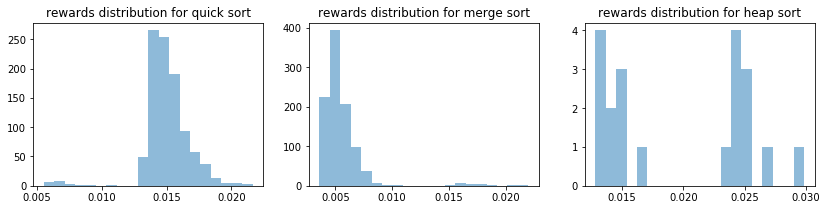

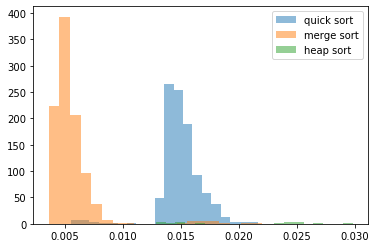

In [81]:
plot_rewards_distribution(arm_rewards_3)
plot_rewards_distribution_together(arm_rewards_3)

Restart at iteration: 502
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.015261778323103428, 'merge_sort': 0.01692688000000544, 'heap_sort': 0.02558302500000309}
Count per chosen algo {'quick_sort': 489, 'merge_sort': 10, 'heap_sort': 4}


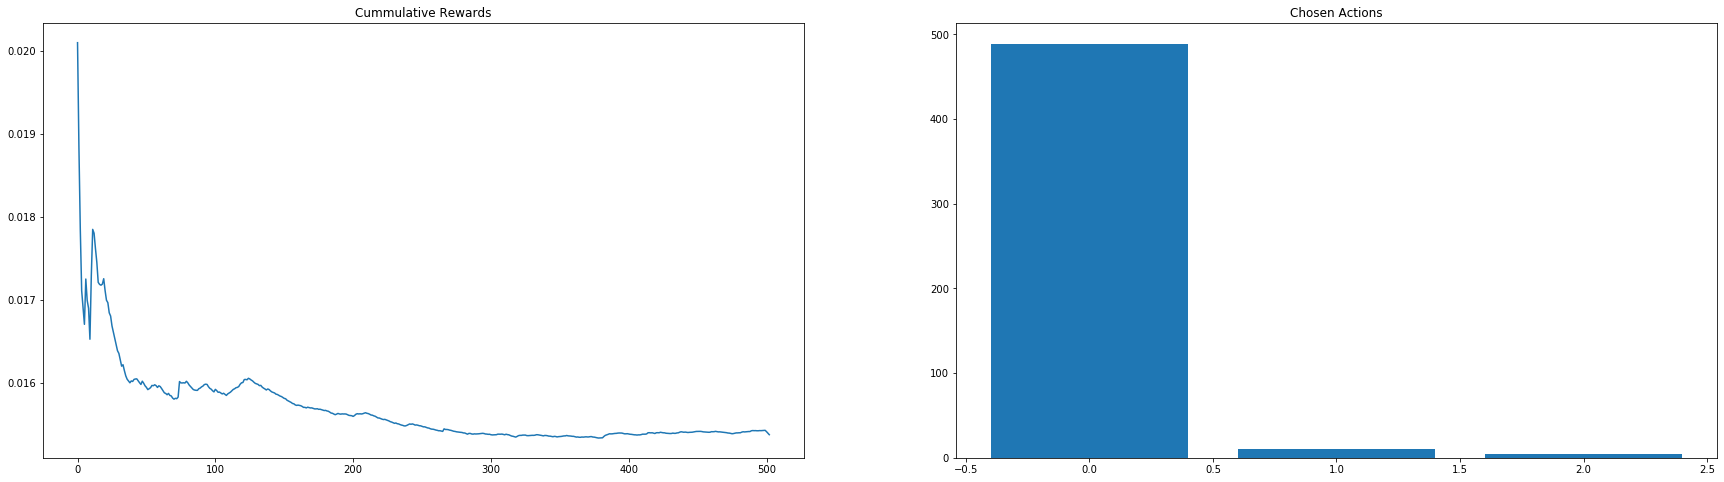

Restart at iteration: 1002
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.006478933333331345, 'merge_sort': 0.005373904897959508, 'heap_sort': 0.01370287500003542}
Count per chosen algo {'quick_sort': 6, 'merge_sort': 490, 'heap_sort': 4}


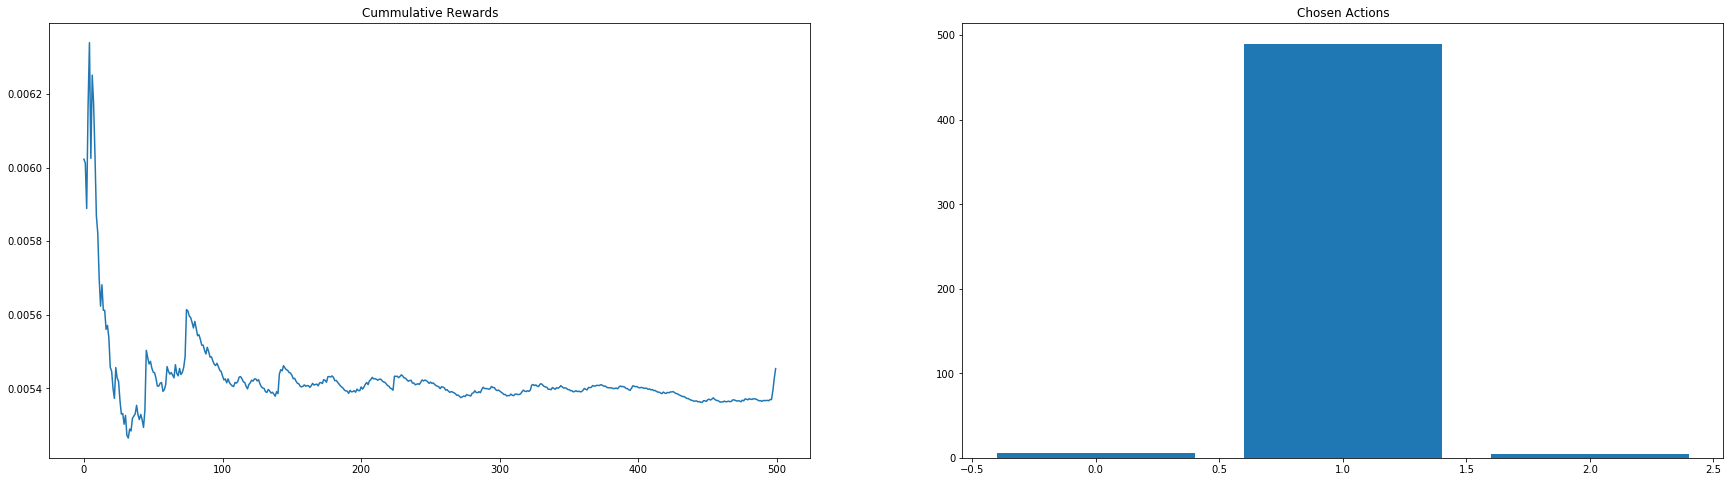

Restart at iteration: 1211
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.014962902475240928, 'merge_sort': 0.016764424999962557, 'heap_sort': 0.02433613333323592}
Count per chosen algo {'quick_sort': 202, 'merge_sort': 4, 'heap_sort': 3}


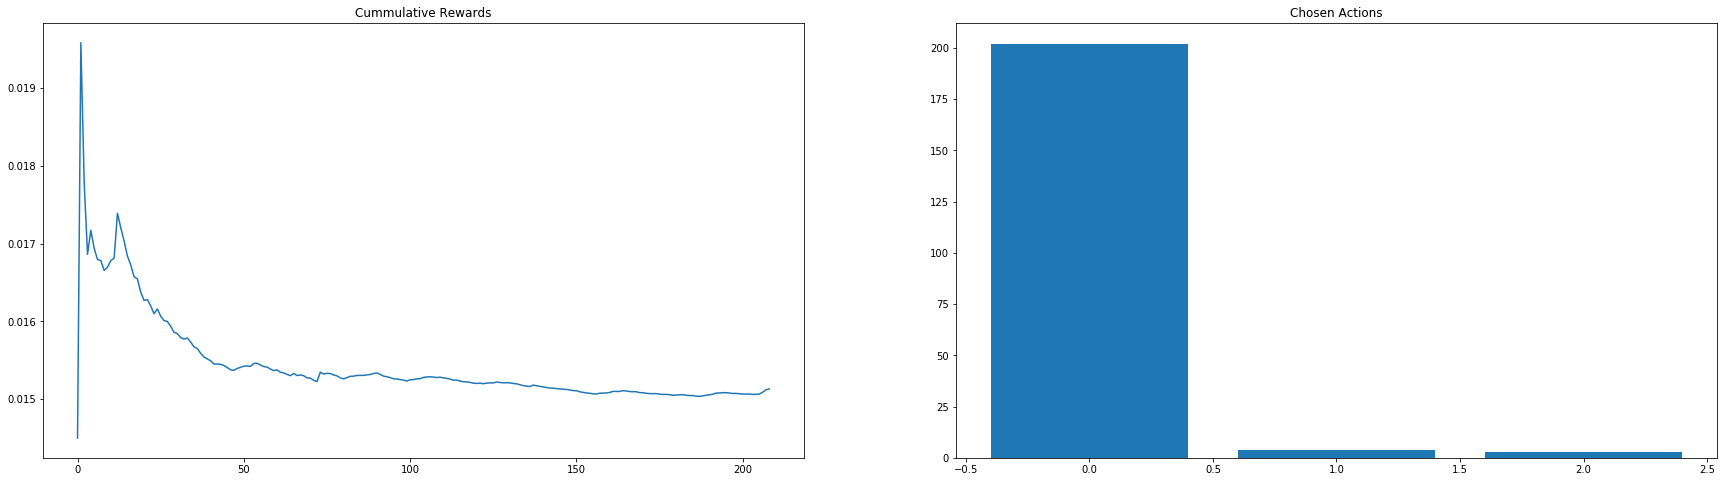

Restart at iteration: 1502
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.01502594982455999, 'merge_sort': 0.017444300000079238, 'heap_sort': 0.02584220000001854}
Count per chosen algo {'quick_sort': 285, 'merge_sort': 3, 'heap_sort': 3}


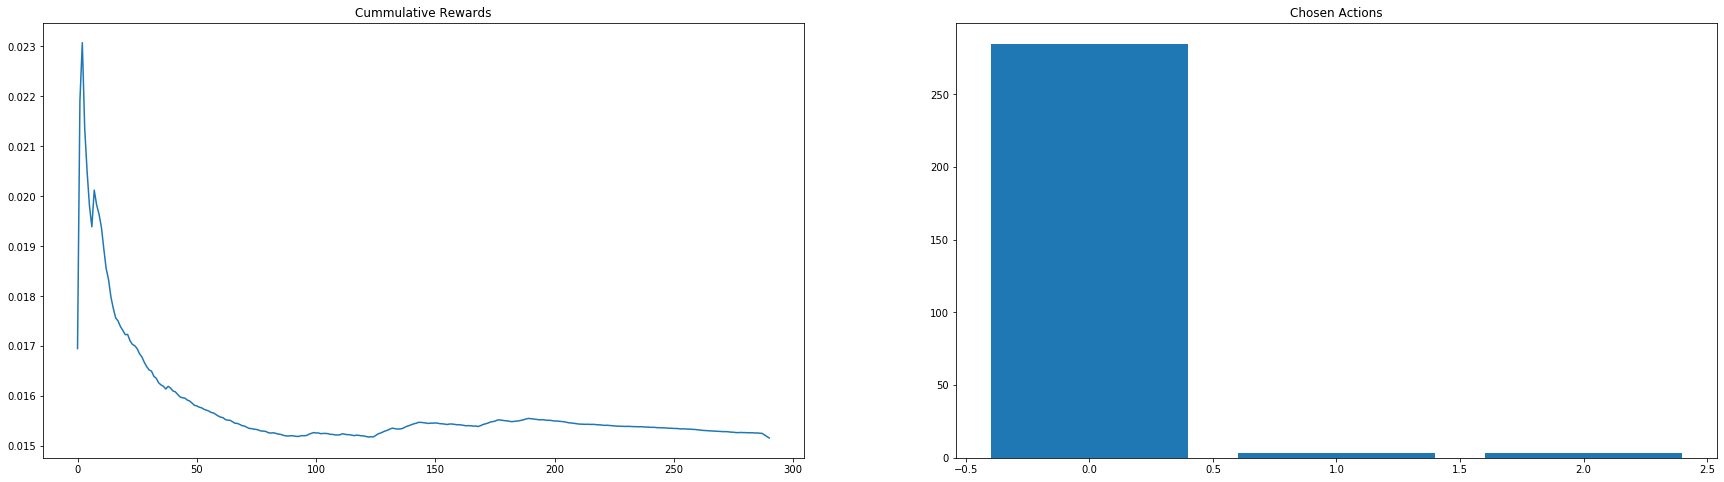

Restart at iteration: 1764
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.006953666666580223, 'merge_sort': 0.0049905671875132285, 'heap_sort': 0.013395033333229852}
Count per chosen algo {'quick_sort': 3, 'merge_sort': 256, 'heap_sort': 3}


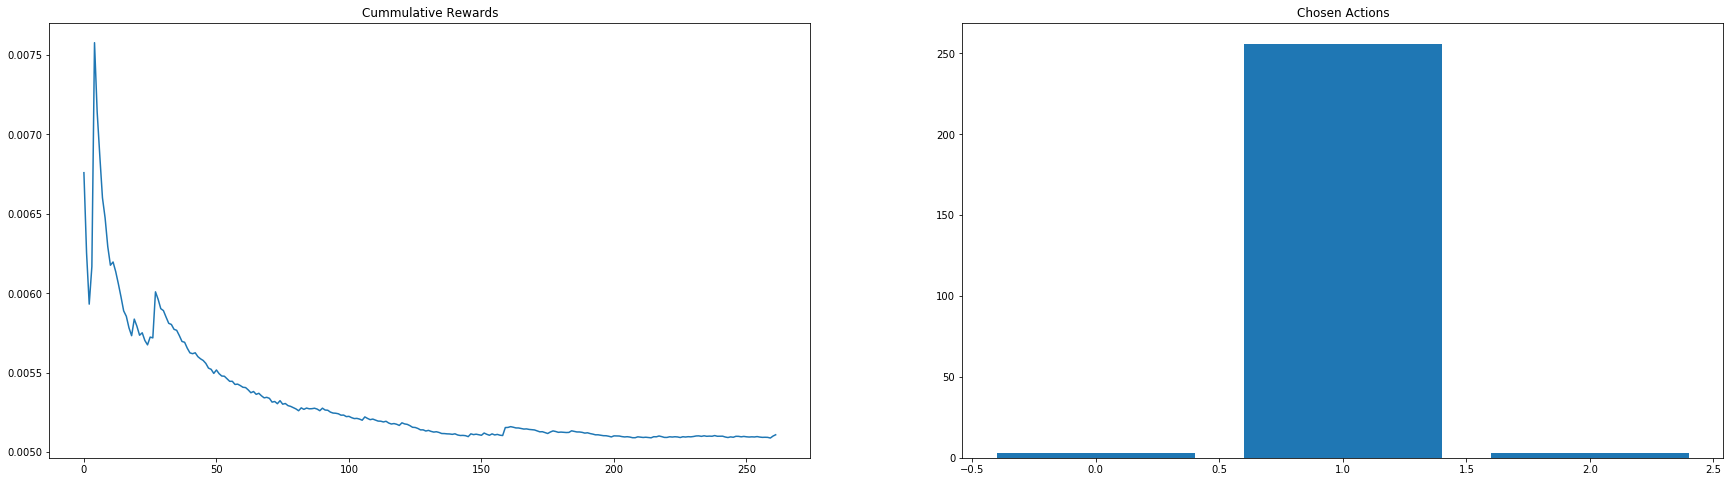

Restart at iteration: 1999
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.008216942857123806, 'merge_sort': 0.005573448444442369, 'heap_sort': 0.015578766666597707}
Count per chosen algo {'quick_sort': 7, 'merge_sort': 225, 'heap_sort': 3}


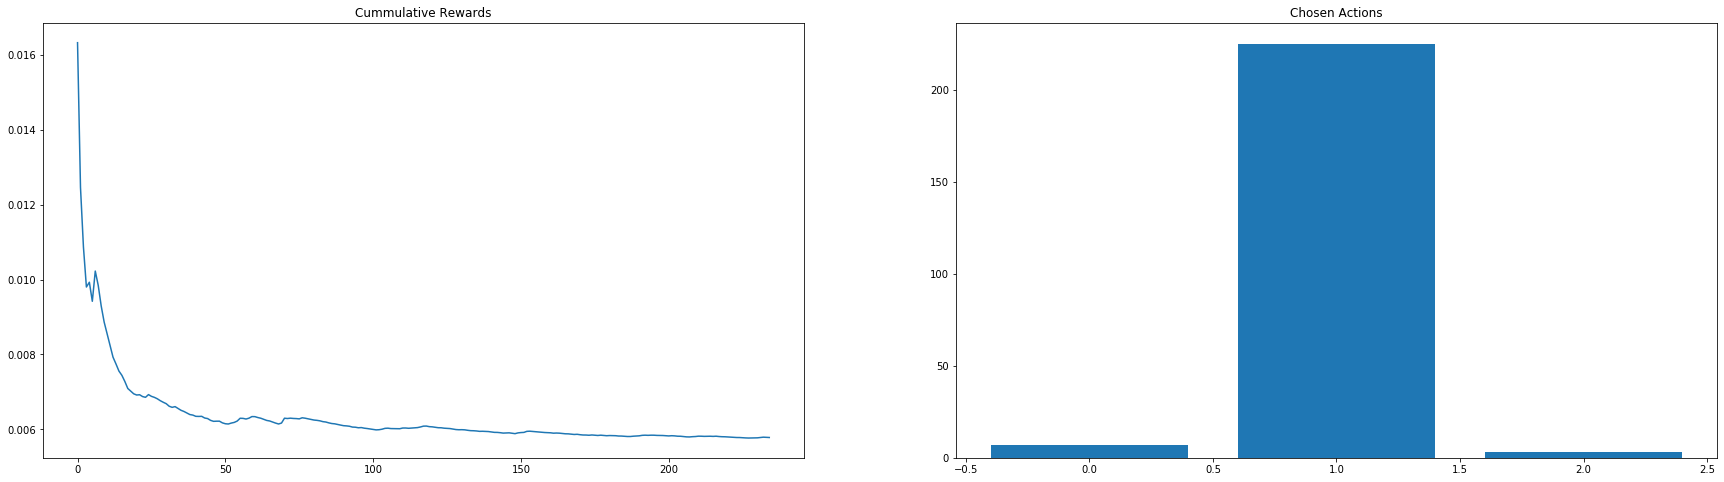

Total reward 20.7332


In [82]:
for elem in list_iteration_results_3:
    sample_mean, sample_count,rewards,cum_rewards,n = elem
    print("Restart at iteration:", n)
    print("Results up to this iteration: ")
    plot_history(rewards,cum_rewards, sample_count, sample_mean)
print("Total reward", np.round(total_reward_3,4))

## Four outliers in a row restart the expriment

In [83]:
list_iteration_results_4, total_reward_4, arm_rewards_4 = ts_quantile(list_distributions, n_samples, num_consec_elem=4)



Iteration: 0
Less than two values for quick_sort
quick_sort Theta 0.010308049443886302
Less than two values for merge_sort
merge_sort Theta 0.09307492970619623
Less than two values for heap_sort
heap_sort Theta 0.09842893437874978


Chosen algorithm is:  quick_sort with reward: 0.01574849999997241
Sample mean is:  0.01574849999997241 Sample variance is: 0.0


Iteration: 1
Less than two values for quick_sort
quick_sort Theta 0.0609467535730148
Less than two values for merge_sort
merge_sort Theta 0.07748561605548364
Less than two values for heap_sort
heap_sort Theta 0.0020162375882121887


Chosen algorithm is:  heap_sort with reward: 0.02411389999997482
Sample mean is:  0.02411389999997482 Sample variance is: 0.0


Iteration: 2
Less than two values for quick_sort
quick_sort Theta 0.02884787067562944
Less than two values for merge_sort
merge_sort Theta 0.04871991213677649
Less than two values for heap_sort
heap_sort Theta 0.08069636978588085


Chosen algorithm is:  quick_sort with rewar


Chosen algorithm is:  quick_sort with reward: 0.01452160000008007
Sample mean is:  0.014995200000019237 Sample variance is: 1.230827699191e-06


Iteration: 28
quick_sort Theta 0.015253708590229894
merge_sort Theta 0.016453195110037632
heap_sort Theta 0.031293592428352286


Chosen algorithm is:  quick_sort with reward: 0.01413989999991827
Sample mean is:  0.01495956250001503 Sample variance is: 1.2087539340753547e-06


Iteration: 29
quick_sort Theta 0.015295355913569618
merge_sort Theta 0.016199262216048508
heap_sort Theta 0.0255383411831038


Chosen algorithm is:  quick_sort with reward: 0.014837400000033085
Sample mean is:  0.014954676000015751 Sample variance is: 1.1609768458861711e-06


Iteration: 30
quick_sort Theta 0.014899194946389553
merge_sort Theta 0.016272007118336537
heap_sort Theta 0.024877268815526626


Chosen algorithm is:  quick_sort with reward: 0.01384209999991981
Sample mean is:  0.014911884615396677 Sample variance is: 1.1621014552156037e-06


Iteration: 31
quick_so



Chosen algorithm is:  quick_sort with reward: 0.01523100000008526
Sample mean is:  0.014762690740747497 Sample variance is: 7.450778593907261e-07


Iteration: 61
quick_sort Theta 0.014850537895312954
merge_sort Theta 0.01644839976622123
heap_sort Theta 0.025209770846213984


Chosen algorithm is:  quick_sort with reward: 0.013898499999868363
Sample mean is:  0.01474697818182242 Sample variance is: 7.448627526505795e-07


Iteration: 62
quick_sort Theta 0.014729833810295133
merge_sort Theta 0.01613429493615516
heap_sort Theta 0.024911679150949106


Chosen algorithm is:  quick_sort with reward: 0.013885099999924932
Sample mean is:  0.014731587500002823 Sample variance is: 7.445896518454994e-07


Iteration: 63
quick_sort Theta 0.014490620498430713
merge_sort Theta 0.01682256305021573
heap_sort Theta 0.021444689457368066


Chosen algorithm is:  quick_sort with reward: 0.01439610000011271
Sample mean is:  0.014725701754390716 Sample variance is: 7.334666275763173e-07


Iteration: 64
quick_s

quick_sort Theta 0.014880123688414343
merge_sort Theta 0.016718846420390426
heap_sort Theta 0.02415427570786497


Chosen algorithm is:  quick_sort with reward: 0.01543149999997695
Sample mean is:  0.014929952808990513 Sample variance is: 1.5695506996123313e-06


Iteration: 96
quick_sort Theta 0.01510439431973057
merge_sort Theta 0.01711904141152049
heap_sort Theta 0.02497785932695221


Chosen algorithm is:  quick_sort with reward: 0.01486269999986689
Sample mean is:  0.014929205555555805 Sample variance is: 1.5521609438993324e-06


Iteration: 97
quick_sort Theta 0.01487969172447609
merge_sort Theta 0.01651923803386147
heap_sort Theta 0.02454495946847047


Chosen algorithm is:  quick_sort with reward: 0.014513099999931
Sample mean is:  0.014924632967032456 Sample variance is: 1.5369860011524568e-06


Iteration: 98
quick_sort Theta 0.01491160833442212
merge_sort Theta 0.016287649822768032
heap_sort Theta 0.024907618993138356


Chosen algorithm is:  quick_sort with reward: 0.0141363000000



Iteration: 126
quick_sort Theta 0.014777414928407178
merge_sort Theta 0.016284421217068787
heap_sort Theta 0.02527650989840906


Chosen algorithm is:  quick_sort with reward: 0.01381960000003346
Sample mean is:  0.01480403333333129 Sample variance is: 1.34472880775687e-06


Iteration: 127
quick_sort Theta 0.01481587351287465
merge_sort Theta 0.016720835618026595
heap_sort Theta 0.02513621991271663


Chosen algorithm is:  quick_sort with reward: 0.014717900000050577
Sample mean is:  0.014803321487601698 Sample variance is: 1.3336761534568676e-06


Iteration: 128
quick_sort Theta 0.014902516557417894
merge_sort Theta 0.016751665021740296
heap_sort Theta 0.026012215191608786


Chosen algorithm is:  quick_sort with reward: 0.01391050000006544
Sample mean is:  0.014796003278687466 Sample variance is: 1.329224679694414e-06


Iteration: 129
quick_sort Theta 0.01478428245386612
merge_sort Theta 0.0165304489410698
heap_sort Theta 0.03732835154173793


Chosen algorithm is:  quick_sort with rew



Chosen algorithm is:  quick_sort with reward: 0.014925599999969563
Sample mean is:  0.014706299999995323 Sample variance is: 1.1981371564003e-06


Iteration: 156
quick_sort Theta 0.0147862481500817
merge_sort Theta 0.016532271414260755
heap_sort Theta 0.02459848981936943


Chosen algorithm is:  quick_sort with reward: 0.013606500000150845
Sample mean is:  0.01469896799999636 Sample variance is: 1.1981595507313662e-06


Iteration: 157
quick_sort Theta 0.01455605402542354
merge_sort Theta 0.01652191302504921
heap_sort Theta 0.02552154673254222


Chosen algorithm is:  quick_sort with reward: 0.014102600000114762
Sample mean is:  0.014695018543043501 Sample variance is: 1.1925644508029409e-06


Iteration: 158
quick_sort Theta 0.014657140254982095
merge_sort Theta 0.016522906953938266
heap_sort Theta 0.024939348934057904


Chosen algorithm is:  quick_sort with reward: 0.01370919999999387
Sample mean is:  0.014688532894733965 Sample variance is: 1.1910702407809036e-06


Iteration: 159
quic

quick_sort Theta 0.014602101310135838
merge_sort Theta 0.016519832650864243
heap_sort Theta 0.026601694365652535


Chosen algorithm is:  quick_sort with reward: 0.014838000000054308
Sample mean is:  0.01473945333333025 Sample variance is: 1.1302578052873872e-06


Iteration: 187
quick_sort Theta 0.014799814696562816
merge_sort Theta 0.016294986446297347
heap_sort Theta 0.02462836490863542


Chosen algorithm is:  quick_sort with reward: 0.015647699999817632
Sample mean is:  0.01474447127071416 Sample variance is: 1.128545632232119e-06


Iteration: 188
quick_sort Theta 0.014773240147079977
merge_sort Theta 0.016490462676416465
heap_sort Theta 0.02529122287921017


Chosen algorithm is:  quick_sort with reward: 0.014501300000119954
Sample mean is:  0.014743135164831774 Sample variance is: 1.1226679494411589e-06


Iteration: 189
quick_sort Theta 0.01472292628841932
merge_sort Theta 0.016483224415283708
heap_sort Theta 0.025343246308911185


Chosen algorithm is:  quick_sort with reward: 0.015


Chosen algorithm is:  quick_sort with reward: 0.013778200000160723
Sample mean is:  0.014804162857141515 Sample variance is: 1.1930056606362395e-06


Iteration: 217
quick_sort Theta 0.014809186801271171
merge_sort Theta 0.016459574411663517
heap_sort Theta 0.025978380525991124


Chosen algorithm is:  quick_sort with reward: 0.014596799999935683
Sample mean is:  0.01480318009478509 Sample variance is: 1.1875544279608943e-06


Iteration: 218
quick_sort Theta 0.014698497058377539
merge_sort Theta 0.016517195463325286
heap_sort Theta 0.025182184121713


Chosen algorithm is:  quick_sort with reward: 0.014148700000077952
Sample mean is:  0.014800092924527037 Sample variance is: 1.1839637169935554e-06


Iteration: 219
quick_sort Theta 0.014779065110937219
merge_sort Theta 0.01632519800940534
heap_sort Theta 0.024868804802283304


Chosen algorithm is:  quick_sort with reward: 0.01470540000013898
Sample mean is:  0.014799648356806906 Sample variance is: 1.1784471016673492e-06


Iteration: 220


Sample mean is:  0.014783838842975058 Sample variance is: 1.1030286314818032e-06


Iteration: 249
quick_sort Theta 0.01473964297638802
merge_sort Theta 0.015836584117712226
heap_sort Theta 0.02609175904682121


Chosen algorithm is:  quick_sort with reward: 0.01664659999983087
Sample mean is:  0.014791504526748126 Sample variance is: 1.1127099942720738e-06


Iteration: 250
quick_sort Theta 0.014852192600171999
merge_sort Theta 0.016390773862366773
heap_sort Theta 0.023956116404554736


Chosen algorithm is:  quick_sort with reward: 0.014260400000011941
Sample mean is:  0.014789327868851667 Sample variance is: 1.1093010024326705e-06


Iteration: 251
quick_sort Theta 0.014661717878637317
merge_sort Theta 0.016644019057542987
heap_sort Theta 0.02574806972405698


Chosen algorithm is:  quick_sort with reward: 0.014884500000107437
Sample mean is:  0.014789716326530263 Sample variance is: 1.1048100626848745e-06


Iteration: 252
quick_sort Theta 0.01482947424663448
merge_sort Theta 0.0163400628

merge_sort Theta 0.016393679717305095
heap_sort Theta 0.0252895823921237


Chosen algorithm is:  quick_sort with reward: 0.016735499999867898
Sample mean is:  0.014948525274726157 Sample variance is: 1.59736705480289e-06


Iteration: 280
quick_sort Theta 0.015038142247214326
merge_sort Theta 0.016368513286697032
heap_sort Theta 0.02696322928948931


Chosen algorithm is:  quick_sort with reward: 0.015641499999901498
Sample mean is:  0.014951054379562564 Sample variance is: 1.593283457391211e-06


Iteration: 281
quick_sort Theta 0.014916625263085568
merge_sort Theta 0.016389187286984158
heap_sort Theta 0.025082053086101272


Chosen algorithm is:  quick_sort with reward: 0.016151600000057442
Sample mean is:  0.014955420000000727 Sample variance is: 1.5927117672203036e-06


Iteration: 282
quick_sort Theta 0.014955174764235303
merge_sort Theta 0.016616726862711238
heap_sort Theta 0.025093952179057768


Chosen algorithm is:  quick_sort with reward: 0.01748829999996815
Sample mean is:  0.0149



Iteration: 311
quick_sort Theta 0.014873407423717231
merge_sort Theta 0.0163631628984603
heap_sort Theta 0.025222808035705577


Chosen algorithm is:  quick_sort with reward: 0.018968999999970038
Sample mean is:  0.015056881639345536 Sample variance is: 1.7643378179819886e-06


Iteration: 312
quick_sort Theta 0.014998213020351722
merge_sort Theta 0.01608885560962713
heap_sort Theta 0.02497624722487244


Chosen algorithm is:  quick_sort with reward: 0.017481999999972686
Sample mean is:  0.015064806862746277 Sample variance is: 1.777728803734563e-06


Iteration: 313
quick_sort Theta 0.015138168635067683
merge_sort Theta 0.016096011004658364
heap_sort Theta 0.024337370547811037


Chosen algorithm is:  quick_sort with reward: 0.017469200000050478
Sample mean is:  0.015072638762216324 Sample variance is: 1.790707782853922e-06


Iteration: 314
quick_sort Theta 0.01503503428306621
merge_sort Theta 0.016465679557621446
heap_sort Theta 0.02564963066412701


Chosen algorithm is:  quick_sort wit



Iteration: 341
quick_sort Theta 0.015230076746363522
merge_sort Theta 0.016454041376559776
heap_sort Theta 0.02559138962419009


Chosen algorithm is:  quick_sort with reward: 0.01841110000009394
Sample mean is:  0.015105469850748622 Sample variance is: 1.7907183929418639e-06


Iteration: 342
quick_sort Theta 0.015114100096917545
merge_sort Theta 0.016514421239737478
heap_sort Theta 0.0247658304698356


Chosen algorithm is:  quick_sort with reward: 0.013425999999981286
Sample mean is:  0.01510047142857372 Sample variance is: 1.7937585890351687e-06


Iteration: 343
quick_sort Theta 0.015094341859267432
merge_sort Theta 0.01642739738288837
heap_sort Theta 0.028230069280750187


Chosen algorithm is:  quick_sort with reward: 0.01876470000001973
Sample mean is:  0.0151113445103881 Sample variance is: 1.82815909638746e-06


Iteration: 344
quick_sort Theta 0.01510921249521362
merge_sort Theta 0.01646347949598137
heap_sort Theta 0.02534881529980004


Chosen algorithm is:  quick_sort with rewa



Iteration: 374
quick_sort Theta 0.015205150695430296
merge_sort Theta 0.01697312518140493
heap_sort Theta 0.024315800389809582


Chosen algorithm is:  quick_sort with reward: 0.01344240000003083
Sample mean is:  0.015158479619568973 Sample variance is: 1.9752887971914323e-06


Iteration: 375
quick_sort Theta 0.015223520661502824
merge_sort Theta 0.016431908936127174
heap_sort Theta 0.02459178673938923


Chosen algorithm is:  quick_sort with reward: 0.014042200000176308
Sample mean is:  0.01515545447154894 Sample variance is: 1.9733034705800493e-06


Iteration: 376
quick_sort Theta 0.015228008765337989
merge_sort Theta 0.016420362331840476
heap_sort Theta 0.024671901465240655


Chosen algorithm is:  quick_sort with reward: 0.01502159999995456
Sample mean is:  0.015155092702706792 Sample variance is: 1.96801851145737e-06


Iteration: 377
quick_sort Theta 0.015147813367469325
merge_sort Theta 0.01613067466626093
heap_sort Theta 0.024774056266574748


Chosen algorithm is:  quick_sort wit

merge_sort Theta 0.017038369929365093
heap_sort Theta 0.024651528796780675


Chosen algorithm is:  quick_sort with reward: 0.016230599999971673
Sample mean is:  0.015191950750004252 Sample variance is: 1.9583281514708124e-06


Iteration: 407
quick_sort Theta 0.015196946474519855
merge_sort Theta 0.016389472362831153
heap_sort Theta 0.025252204452383027


Chosen algorithm is:  quick_sort with reward: 0.017652100000077553
Sample mean is:  0.015198085785540594 Sample variance is: 1.968500004533385e-06


Iteration: 408
quick_sort Theta 0.01522993285947747
merge_sort Theta 0.016489685115757817
heap_sort Theta 0.024955790003254534


Chosen algorithm is:  quick_sort with reward: 0.01707340000007207
Sample mean is:  0.015202750746273261 Sample variance is: 1.9723297436665147e-06


Iteration: 409
quick_sort Theta 0.015283374996865075
merge_sort Theta 0.01632986195818054
heap_sort Theta 0.0257414869496774


Chosen algorithm is:  quick_sort with reward: 0.01783130000012534
Sample mean is:  0.0152



Iteration: 439
quick_sort Theta 0.015179319831129209
merge_sort Theta 0.016342892276098534
heap_sort Theta 0.025320800348152428


Chosen algorithm is:  quick_sort with reward: 0.019746400000030917
Sample mean is:  0.015243763048505356 Sample variance is: 1.9916216634621086e-06


Iteration: 440
quick_sort Theta 0.015376444345794906
merge_sort Theta 0.016463176889117026
heap_sort Theta 0.02501036448556532


Chosen algorithm is:  quick_sort with reward: 0.0176062999998976
Sample mean is:  0.01524920668203391 Sample variance is: 1.9998638256691845e-06


Iteration: 441
quick_sort Theta 0.015238873670151932
merge_sort Theta 0.01654680146401064
heap_sort Theta 0.025697336324405868


Chosen algorithm is:  quick_sort with reward: 0.01583030000006147
Sample mean is:  0.01525054252874202 Sample variance is: 1.9960409046737615e-06


Iteration: 442
quick_sort Theta 0.015219558614132017
merge_sort Theta 0.015801789139229708
heap_sort Theta 0.02602192744337466


Chosen algorithm is:  quick_sort wit



Chosen algorithm is:  quick_sort with reward: 0.015563599999950384
Sample mean is:  0.015285495913983425 Sample variance is: 2.2249561700990875e-06


Iteration: 472
quick_sort Theta 0.015370697046066516
merge_sort Theta 0.016432773110734024
heap_sort Theta 0.024776369810350956


Chosen algorithm is:  quick_sort with reward: 0.0163180999998076
Sample mean is:  0.015287711802579613 Sample variance is: 2.222464811498967e-06


Iteration: 473
quick_sort Theta 0.015255798870722601
merge_sort Theta 0.01606325491609382
heap_sort Theta 0.030643539627525723


Chosen algorithm is:  quick_sort with reward: 0.014353499999970154
Sample mean is:  0.015285711349040835 Sample variance is: 2.2195706316988155e-06


Iteration: 474
quick_sort Theta 0.015226377187698046
merge_sort Theta 0.016853564759109256
heap_sort Theta 0.02497694694442272


Chosen algorithm is:  quick_sort with reward: 0.014778400000068359
Sample mean is:  0.01528462735043192 Sample variance is: 2.2153767091524495e-06


Iteration: 475

Less than two values for quick_sort
quick_sort Theta 0.08372420067874396
merge_sort Theta 0.004971495083547236
Less than two values for heap_sort
heap_sort Theta 0.06540631822088107


Chosen algorithm is:  merge_sort with reward: 0.005806099999972503
Sample mean is:  0.0053104500000245025 Sample variance is: 3.4232428748288443e-07


Iteration: 508
Less than two values for quick_sort
quick_sort Theta 0.03356900767047851
merge_sort Theta 0.005091595834129678
Less than two values for heap_sort
heap_sort Theta 0.0445231612574311


Chosen algorithm is:  merge_sort with reward: 0.007377200000064477
Sample mean is:  0.005723800000032498 Sample variance is: 9.57292320012745e-07


Iteration: 509
Less than two values for quick_sort
quick_sort Theta 0.023916534762990195
merge_sort Theta 0.005431371508550353
Less than two values for heap_sort
heap_sort Theta 0.07809148674411688


Chosen algorithm is:  merge_sort with reward: 0.006953399999929388
Sample mean is:  0.005928733333348646 Sample varianc

merge_sort Theta 0.005292549492633442
heap_sort Theta 0.014765330461852523


Chosen algorithm is:  merge_sort with reward: 0.005188100000168561
Sample mean is:  0.005410442857152832 Sample variance is: 5.521335817113941e-07


Iteration: 537
quick_sort Theta 0.006569945432632254
merge_sort Theta 0.005287177710599458
heap_sort Theta 0.014089839054691813


Chosen algorithm is:  merge_sort with reward: 0.005918000000065149
Sample mean is:  0.005427944827598084 Sample variance is: 5.416714238319247e-07


Iteration: 538
quick_sort Theta 0.006589239830632107
merge_sort Theta 0.005467651668913962
heap_sort Theta 0.013396025420460046


Chosen algorithm is:  merge_sort with reward: 0.004555199999913384
Sample mean is:  0.005398853333341928 Sample variance is: 5.48158845807818e-07


Iteration: 539
quick_sort Theta 0.006577395442425927
merge_sort Theta 0.0054213666114886466
heap_sort Theta 0.013739492433659248


Chosen algorithm is:  merge_sort with reward: 0.006665500000053726
Sample mean is:  0.



Chosen algorithm is:  merge_sort with reward: 0.005710399999998117
Sample mean is:  0.005297543548393942 Sample variance is: 5.698438405227739e-07


Iteration: 572
quick_sort Theta 0.0067392265020057365
merge_sort Theta 0.005252596629749921
heap_sort Theta 0.013875506381711328


Chosen algorithm is:  merge_sort with reward: 0.004384300000083385
Sample mean is:  0.00528304761905568 Sample variance is: 5.7382688217457e-07


Iteration: 573
quick_sort Theta 0.006938162464666661
merge_sort Theta 0.0051586971829578766
heap_sort Theta 0.01975897339050097


Chosen algorithm is:  merge_sort with reward: 0.005775500000027023
Sample mean is:  0.005290742187508357 Sample variance is: 5.685908393119875e-07


Iteration: 574
quick_sort Theta 0.006811300274846673
merge_sort Theta 0.005251195190677946
heap_sort Theta 0.013498623379748834


Chosen algorithm is:  merge_sort with reward: 0.00412359999995715
Sample mean is:  0.005272786153853723 Sample variance is: 5.80478113192763e-07


Iteration: 575
q

quick_sort Theta 0.007328977891281178
merge_sort Theta 0.005197842895614648
heap_sort Theta 0.01323211483168502


Chosen algorithm is:  merge_sort with reward: 0.005153799999789044
Sample mean is:  0.005115867741940219 Sample variance is: 5.625993236900718e-07


Iteration: 603
quick_sort Theta 0.006772315835551761
merge_sort Theta 0.005183060663943161
heap_sort Theta 0.013618996379997757


Chosen algorithm is:  merge_sort with reward: 0.005526500000087253
Sample mean is:  0.005120236170218379 Sample variance is: 5.583889589046722e-07


Iteration: 604
quick_sort Theta 0.006805156846624315
merge_sort Theta 0.005059434274703574
heap_sort Theta 0.013610632299191528


Chosen algorithm is:  merge_sort with reward: 0.004310599999826081
Sample mean is:  0.005111713684214249 Sample variance is: 5.593386605528011e-07


Iteration: 605
quick_sort Theta 0.006871919417041851
merge_sort Theta 0.004954217751813118
heap_sort Theta 0.010598519947670495


Chosen algorithm is:  merge_sort with reward: 0.0

quick_sort Theta 0.006384567571897535
merge_sort Theta 0.004997030594973928
heap_sort Theta 0.0134057203814632


Chosen algorithm is:  merge_sort with reward: 0.004991600000039398
Sample mean is:  0.005066804032268128 Sample variance is: 6.005941731290259e-07


Iteration: 634
quick_sort Theta 0.00610735404949875
merge_sort Theta 0.0051368245581981465
heap_sort Theta 0.012547503881998465


Chosen algorithm is:  merge_sort with reward: 0.005665800000087984
Sample mean is:  0.005071596000010686 Sample variance is: 5.986368261448637e-07


Iteration: 635
quick_sort Theta 0.006688104185050741
merge_sort Theta 0.00499142633556772
heap_sort Theta 0.01371969101748575


Chosen algorithm is:  merge_sort with reward: 0.0065311999999266845
Sample mean is:  0.005083180158740178 Sample variance is: 6.106598319068373e-07


Iteration: 636
quick_sort Theta 0.0068657205610273215
merge_sort Theta 0.005104487428489206
heap_sort Theta 0.013999134533128864


Chosen algorithm is:  merge_sort with reward: 0.00


Iteration: 663
quick_sort Theta 0.006680393947756954
merge_sort Theta 0.005049029133572381
heap_sort Theta 0.013977659243127064


Chosen algorithm is:  merge_sort with reward: 0.006211000000121203
Sample mean is:  0.005073761688321044 Sample variance is: 6.066516321106729e-07


Iteration: 664
quick_sort Theta 0.0063099839990890996
merge_sort Theta 0.0050881767865338275
heap_sort Theta 0.013556310242277178


Chosen algorithm is:  merge_sort with reward: 0.005202199999985169
Sample mean is:  0.005074590322589844 Sample variance is: 6.028434923649052e-07


Iteration: 665
quick_sort Theta 0.006378502377526324
merge_sort Theta 0.005085249151356524
heap_sort Theta 0.013374158799645056


Chosen algorithm is:  merge_sort with reward: 0.004998999999997977
Sample mean is:  0.005074105769239896 Sample variance is: 5.990155037556782e-07


Iteration: 666
quick_sort Theta 0.006792016061134246
merge_sort Theta 0.005038753603036088
heap_sort Theta 0.01324452056658637


Chosen algorithm is:  merge_sor


Iteration: 694
quick_sort Theta 0.006937490088058422
merge_sort Theta 0.005020302201832211
heap_sort Theta 0.01351609213238756


Chosen algorithm is:  merge_sort with reward: 0.00671369999986382
Sample mean is:  0.005034887027033767 Sample variance is: 5.946483228686381e-07


Iteration: 695
quick_sort Theta 0.006178748991792412
merge_sort Theta 0.005004451905505955
heap_sort Theta 0.013479199213365978


Chosen algorithm is:  merge_sort with reward: 0.004996399999981804
Sample mean is:  0.005034680107533487 Sample variance is: 5.914592097754459e-07


Iteration: 696
quick_sort Theta 0.005530486714302656
merge_sort Theta 0.004913338929355773
heap_sort Theta 0.013236644978605853


Chosen algorithm is:  merge_sort with reward: 0.004555700000082652
Sample mean is:  0.0050321187165845525 Sample variance is: 5.895166208890621e-07


Iteration: 697
quick_sort Theta 0.006967437198843233
merge_sort Theta 0.005100742225031885
heap_sort Theta 0.014108430907612428


Chosen algorithm is:  merge_sort 



Chosen algorithm is:  merge_sort with reward: 0.006080600000132108
Sample mean is:  0.00503718084112874 Sample variance is: 6.317417713707025e-07


Iteration: 724
quick_sort Theta 0.0057161473770320145
merge_sort Theta 0.0049917816313727725
heap_sort Theta 0.01355310426870588


Chosen algorithm is:  merge_sort with reward: 0.003777500000069267
Sample mean is:  0.00503132186047265 Sample variance is: 6.361495555766607e-07


Iteration: 725
quick_sort Theta 0.006745041763757853
merge_sort Theta 0.005026825003056456
heap_sort Theta 0.01313104203799683


Chosen algorithm is:  merge_sort with reward: 0.0047391000000516215
Sample mean is:  0.005029968981489219 Sample variance is: 6.335979292772059e-07


Iteration: 726
quick_sort Theta 0.007026065055002428
merge_sort Theta 0.0050521648847425115
heap_sort Theta 0.013453385027966261


Chosen algorithm is:  merge_sort with reward: 0.0045162000001255365
Sample mean is:  0.0050276013824967596 Sample variance is: 6.318889165491489e-07


Iteration:

heap_sort Theta 0.013442098991813584


Chosen algorithm is:  merge_sort with reward: 0.00826269999993201
Sample mean is:  0.005016593495945823 Sample variance is: 6.518734577695055e-07


Iteration: 756
quick_sort Theta 0.006707411049767119
merge_sort Theta 0.004969566567084608
heap_sort Theta 0.014416408251947798


Chosen algorithm is:  merge_sort with reward: 0.005743100000017876
Sample mean is:  0.005019534817824657 Sample variance is: 6.513625320740154e-07


Iteration: 757
quick_sort Theta 0.0066078404374583545
merge_sort Theta 0.005039718203135953
heap_sort Theta 0.013001593629362033


Chosen algorithm is:  merge_sort with reward: 0.0045898000000761385
Sample mean is:  0.005017802016140187 Sample variance is: 6.494777128655285e-07


Iteration: 758
quick_sort Theta 0.007881028976140177
merge_sort Theta 0.005121264055641363
heap_sort Theta 0.013836178338129463


Chosen algorithm is:  merge_sort with reward: 0.004401099999995495
Sample mean is:  0.005015325301215912 Sample variance is

merge_sort Theta 0.0050110605480567574
heap_sort Theta 0.01280585767046973


Chosen algorithm is:  merge_sort with reward: 0.00603000000000975
Sample mean is:  0.005002356159427959 Sample variance is: 6.443068822547608e-07


Iteration: 786
quick_sort Theta 0.006403803381302453
merge_sort Theta 0.00501253093828212
heap_sort Theta 0.013081654165909732


Chosen algorithm is:  merge_sort with reward: 0.007356299999855764
Sample mean is:  0.005010854151631669 Sample variance is: 6.619124451617259e-07


Iteration: 787
quick_sort Theta 0.006605192422242257
merge_sort Theta 0.00502999224999947
heap_sort Theta 0.013456054511608733


Chosen algorithm is:  merge_sort with reward: 0.004598399999849789
Sample mean is:  0.005009370503603677 Sample variance is: 6.60141200720616e-07


Iteration: 788
quick_sort Theta 0.006533278539639545
merge_sort Theta 0.0048660762471001776
heap_sort Theta 0.013647562383483981


Chosen algorithm is:  merge_sort with reward: 0.004553299999997762
Sample mean is:  0.005



Chosen algorithm is:  merge_sort with reward: 0.006370000000060827
Sample mean is:  0.00500901140065694 Sample variance is: 6.790318670777422e-07


Iteration: 817
quick_sort Theta 0.006641241657543232
merge_sort Theta 0.00500184154098171
heap_sort Theta 0.014063035484995984


Chosen algorithm is:  merge_sort with reward: 0.004571400000031645
Sample mean is:  0.0050075905844211436 Sample variance is: 6.774469648228608e-07


Iteration: 818
quick_sort Theta 0.006968520851043733
merge_sort Theta 0.0050661063103381795
heap_sort Theta 0.013330955137384524


Chosen algorithm is:  merge_sort with reward: 0.005109699999820805
Sample mean is:  0.005007921035603666 Sample variance is: 6.752882128025156e-07


Iteration: 819
quick_sort Theta 0.007031005734152722
merge_sort Theta 0.004960071716811341
heap_sort Theta 0.013185069005165816


Chosen algorithm is:  merge_sort with reward: 0.005142900000009831
Sample mean is:  0.00500835645161788 Sample variance is: 6.731684461445381e-07


Iteration: 82



Iteration: 848
quick_sort Theta 0.006152366069422457
merge_sort Theta 0.005143693831066986
heap_sort Theta 0.013093216441796325


Chosen algorithm is:  merge_sort with reward: 0.006763200000023062
Sample mean is:  0.005122955752214323 Sample variance is: 2.0272838331562125e-06


Iteration: 849
quick_sort Theta 0.006719607512744304
merge_sort Theta 0.00515857727418434
heap_sort Theta 0.013898048075625337


Chosen algorithm is:  merge_sort with reward: 0.006126800000174626
Sample mean is:  0.005125908235296559 Sample variance is: 2.0242763496498817e-06


Iteration: 850
quick_sort Theta 0.006593305185008679
merge_sort Theta 0.0050377605514680505
heap_sort Theta 0.013482863779793387


Chosen algorithm is:  merge_sort with reward: 0.004336499999908483
Sample mean is:  0.005123593255134131 Sample variance is: 2.020162160641212e-06


Iteration: 851
quick_sort Theta 0.006819623859747432
merge_sort Theta 0.005063559641265503
heap_sort Theta 0.01259163576921398


Chosen algorithm is:  merge_so


Iteration: 878
quick_sort Theta 0.006506628556758244
merge_sort Theta 0.005044279513178578
heap_sort Theta 0.01161784460661765


Chosen algorithm is:  merge_sort with reward: 0.006752400000095804
Sample mean is:  0.005197143360434836 Sample variance is: 2.0187800881525085e-06


Iteration: 879
quick_sort Theta 0.006350466320082549
merge_sort Theta 0.005225483663544
heap_sort Theta 0.013606014420820142


Chosen algorithm is:  merge_sort with reward: 0.005862900000010995
Sample mean is:  0.005198942702703961 Sample variance is: 2.0145186121820347e-06


Iteration: 880
quick_sort Theta 0.006029465956154837
merge_sort Theta 0.005157105206374589
heap_sort Theta 0.013439269601599612


Chosen algorithm is:  merge_sort with reward: 0.0044433000000481115
Sample mean is:  0.0051969059299205225 Sample variance is: 2.010623566924364e-06


Iteration: 881
quick_sort Theta 0.00671944221628927
merge_sort Theta 0.005193803355935958
heap_sort Theta 0.013689568550228199


Chosen algorithm is:  merge_sort 


Iteration: 915
quick_sort Theta 0.006723352051216013
merge_sort Theta 0.005321109259582465
heap_sort Theta 0.013141312840467718


Chosen algorithm is:  merge_sort with reward: 0.0048581999999441905
Sample mean is:  0.005183453333334169 Sample variance is: 1.9025720172581016e-06


Iteration: 916
quick_sort Theta 0.006767783800987932
merge_sort Theta 0.005270655499001007
heap_sort Theta 0.013531990255056484


Chosen algorithm is:  merge_sort with reward: 0.004255599999851256
Sample mean is:  0.005181167980296034 Sample variance is: 1.90000112888067e-06


Iteration: 917
quick_sort Theta 0.006889141171999852
merge_sort Theta 0.005267209291335481
heap_sort Theta 0.01320429932042499


Chosen algorithm is:  merge_sort with reward: 0.004642899999907968
Sample mean is:  0.005179845454545694 Sample variance is: 1.896042945628988e-06


Iteration: 918
quick_sort Theta 0.0069883957950042
merge_sort Theta 0.005107967855812304
heap_sort Theta 0.01245809349131875


Chosen algorithm is:  merge_sort wi


Chosen algorithm is:  merge_sort with reward: 0.004660199999989345
Sample mean is:  0.00516394827586162 Sample variance is: 1.8060326572617905e-06


Iteration: 946
quick_sort Theta 0.006796075274902382
merge_sort Theta 0.0050827429885318565
heap_sort Theta 0.01362572017672391


Chosen algorithm is:  merge_sort with reward: 0.00430699999992612
Sample mean is:  0.00516198279816452 Sample variance is: 1.8035708301462932e-06


Iteration: 947
quick_sort Theta 0.006757718882631001
merge_sort Theta 0.005190940288187064
heap_sort Theta 0.013433056038765365


Chosen algorithm is:  merge_sort with reward: 0.00499679999984437
Sample mean is:  0.005161604805491019 Sample variance is: 1.7995059607843408e-06


Iteration: 948
quick_sort Theta 0.006525562578222586
merge_sort Theta 0.0051965343375444005
heap_sort Theta 0.013635148526518261


Chosen algorithm is:  merge_sort with reward: 0.004275300000017523
Sample mean is:  0.005159581278537883 Sample variance is: 1.7971868666878993e-06


Iteration: 9

quick_sort Theta 0.006599424418154362
merge_sort Theta 0.005274459493045738
heap_sort Theta 0.011834719103578613


Chosen algorithm is:  merge_sort with reward: 0.005283899999994901
Sample mean is:  0.005159154506437837 Sample variance is: 1.7349056511544268e-06


Iteration: 977
quick_sort Theta 0.006401232987646898
merge_sort Theta 0.0052587075811030065
heap_sort Theta 0.014661756606819048


Chosen algorithm is:  merge_sort with reward: 0.006246899999950983
Sample mean is:  0.005161483725910028 Sample variance is: 1.733718822481021e-06


Iteration: 978
quick_sort Theta 0.006601471712983945
merge_sort Theta 0.005175506108138774
heap_sort Theta 0.013714830128747852


Chosen algorithm is:  merge_sort with reward: 0.0035720999999284686
Sample mean is:  0.0051580876068374176 Sample variance is: 1.7354004978433038e-06


Iteration: 979
quick_sort Theta 0.006700238787699252
merge_sort Theta 0.005170114246611663
heap_sort Theta 0.013135202723773396


Chosen algorithm is:  merge_sort with rewar



Chosen algorithm is:  merge_sort with reward: 0.016360699999950157
Sample mean is:  0.01601487499999621 Sample variance is: 5.368493186747977e-08


Iteration: 1009
Less than two values for quick_sort
quick_sort Theta 0.08858928512962323
merge_sort Theta 0.016148672624228925
Less than two values for heap_sort
heap_sort Theta 0.006283452837839654


Chosen algorithm is:  heap_sort with reward: 0.023391700000047422
Sample mean is:  0.0234560500000498 Sample variance is: 4.140922500306021e-09


Iteration: 1010
Less than two values for quick_sort
quick_sort Theta 0.029430200302307166
merge_sort Theta 0.01603501063210514
heap_sort Theta 0.02344967772926267


Chosen algorithm is:  merge_sort with reward: 0.015543600000000879
Sample mean is:  0.015920619999997145 Sample variance is: 7.848396559327958e-08


Iteration: 1011
Less than two values for quick_sort
quick_sort Theta 0.05962941824808796
merge_sort Theta 0.01603956449654117
heap_sort Theta 0.023484631165939903


Chosen algorithm is:  me



Iteration: 1038
quick_sort Theta 0.014208424732287462
merge_sort Theta 0.01563309399744314
heap_sort Theta 0.023241348435963444


Chosen algorithm is:  quick_sort with reward: 0.015974099999993996
Sample mean is:  0.014350410526312293 Sample variance is: 4.7140675992055854e-07


Iteration: 1039
quick_sort Theta 0.014285749048325311
merge_sort Theta 0.015936717589014403
heap_sort Theta 0.023498538597372328


Chosen algorithm is:  quick_sort with reward: 0.013933900000210997
Sample mean is:  0.014329585000007227 Sample variance is: 4.560767702963065e-07


Iteration: 1040
quick_sort Theta 0.014263800261493834
merge_sort Theta 0.01579727750433375
heap_sort Theta 0.0214316155039369


Chosen algorithm is:  quick_sort with reward: 0.013830600000119375
Sample mean is:  0.014305823809536378 Sample variance is: 4.4565071230546556e-07


Iteration: 1041
quick_sort Theta 0.0143576914932419
merge_sort Theta 0.0159046468583731
heap_sort Theta 0.023479878985556736


Chosen algorithm is:  quick_sort 

Sample mean is:  0.014117785416672746 Sample variance is: 4.481887725094274e-07


Iteration: 1068
quick_sort Theta 0.014134148132396022
merge_sort Theta 0.015607289842468347
heap_sort Theta 0.023443119377727122


Chosen algorithm is:  quick_sort with reward: 0.014058900000009089
Sample mean is:  0.014116583673475527 Sample variance is: 4.391113838285567e-07


Iteration: 1069
quick_sort Theta 0.014176831094291166
merge_sort Theta 0.015906123116764505
heap_sort Theta 0.023417406874311996


Chosen algorithm is:  quick_sort with reward: 0.014973199999985809
Sample mean is:  0.014133716000005734 Sample variance is: 4.447114701565273e-07


Iteration: 1070
quick_sort Theta 0.014016065333942456
merge_sort Theta 0.01572022619550701
heap_sort Theta 0.023278340806806807


Chosen algorithm is:  quick_sort with reward: 0.0136953999999605
Sample mean is:  0.014125121568632298 Sample variance is: 4.396848499399952e-07


Iteration: 1071
quick_sort Theta 0.013997966855184195
merge_sort Theta 0.01574011



Chosen algorithm is:  quick_sort with reward: 0.016899199999897974
Sample mean is:  0.014580091666668219 Sample variance is: 1.5392806443150424e-06


Iteration: 1104
quick_sort Theta 0.01466405729481668
merge_sort Theta 0.015814151803041087
heap_sort Theta 0.02331784196736181


Chosen algorithm is:  quick_sort with reward: 0.014619300000049407
Sample mean is:  0.014580552941178587 Sample variance is: 1.5211893332948864e-06


Iteration: 1105
quick_sort Theta 0.01454116365969632
merge_sort Theta 0.015915128474661623
heap_sort Theta 0.023461508904009477


Chosen algorithm is:  quick_sort with reward: 0.016014699999914228
Sample mean is:  0.014597229069768536 Sample variance is: 1.5271390127369422e-06


Iteration: 1106
quick_sort Theta 0.014387421177638148
merge_sort Theta 0.016042396596632123
heap_sort Theta 0.02345942086124377


Chosen algorithm is:  quick_sort with reward: 0.013755599999967671
Sample mean is:  0.014587555172414503 Sample variance is: 1.5176339396928673e-06


Iteration

Iteration: 1137
quick_sort Theta 0.015321493560736484
merge_sort Theta 0.01572994406236625
heap_sort Theta 0.023440973676410435


Chosen algorithm is:  quick_sort with reward: 0.02038700000002791
Sample mean is:  0.01517491440678233 Sample variance is: 1.0240614558436947e-05


Iteration: 1138
quick_sort Theta 0.014802449434803631
merge_sort Theta 0.01576427558105044
heap_sort Theta 0.023509244135988573


Chosen algorithm is:  quick_sort with reward: 0.01593800000000556
Sample mean is:  0.015181326890758995 Sample variance is: 1.0159411128100882e-05


Iteration: 1139
quick_sort Theta 0.014993168570336762
merge_sort Theta 0.015856033865668126
heap_sort Theta 0.0234849171729633


Chosen algorithm is:  quick_sort with reward: 0.016934099999843966
Sample mean is:  0.015195933333334704 Sample variance is: 1.0100137800301423e-05


Iteration: 1140
quick_sort Theta 0.015423210272947145
merge_sort Theta 0.01565877705424236
heap_sort Theta 0.023649760582674626


Chosen algorithm is:  quick_sort w


Iteration: 1167
quick_sort Theta 0.015253332611658274
merge_sort Theta 0.01597274922575644
heap_sort Theta 0.02354288335345401


Chosen algorithm is:  quick_sort with reward: 0.01832309999986137
Sample mean is:  0.01560628571428424 Sample variance is: 1.6709428797308054e-05


Iteration: 1168
quick_sort Theta 0.01505537139636118
merge_sort Theta 0.01593244398800631
heap_sort Theta 0.02344884949804657


Chosen algorithm is:  quick_sort with reward: 0.014153500000020358
Sample mean is:  0.015596469594593269 Sample variance is: 1.6610691613631062e-05


Iteration: 1169
quick_sort Theta 0.015506146265171083
merge_sort Theta 0.015648454465849528
heap_sort Theta 0.02349899203353783


Chosen algorithm is:  quick_sort with reward: 0.015176699999983612
Sample mean is:  0.015593652348991861 Sample variance is: 1.6500385119032965e-05


Iteration: 1170
quick_sort Theta 0.0152542340780529
merge_sort Theta 0.01607210565110435
heap_sort Theta 0.023447873797003655


Chosen algorithm is:  quick_sort wit



Iteration: 1201
quick_sort Theta 0.01568381920177814
merge_sort Theta 0.015964338244798783
heap_sort Theta 0.023444926643040296


Chosen algorithm is:  quick_sort with reward: 0.017336399999976493
Sample mean is:  0.015593146327681376 Sample variance is: 1.4116574802734212e-05


Iteration: 1202
quick_sort Theta 0.015773364496129406
merge_sort Theta 0.016021602676343373
heap_sort Theta 0.023256796035298774


Chosen algorithm is:  quick_sort with reward: 0.015794099999993705
Sample mean is:  0.015594275280896613 Sample variance is: 1.4037493795477962e-05


Iteration: 1203
quick_sort Theta 0.01590628213917013
merge_sort Theta 0.015998118205120662
heap_sort Theta 0.02347362255770213


Chosen algorithm is:  quick_sort with reward: 0.01664630000004763
Sample mean is:  0.015600152513964495 Sample variance is: 1.3965220495029694e-05


Iteration: 1204
quick_sort Theta 0.01594882590689765
merge_sort Theta 0.016227133754998124
heap_sort Theta 0.023596570106886476


Chosen algorithm is:  quick_s



Iteration: 1234
quick_sort Theta 0.01567926747822058
merge_sort Theta 0.01600373201573725
heap_sort Theta 0.023407129957502795


Chosen algorithm is:  quick_sort with reward: 0.0160723000001326
Sample mean is:  0.015539973300967829 Sample variance is: 1.2286459236746872e-05


Iteration: 1235
quick_sort Theta 0.015396824126806147
merge_sort Theta 0.016281889305886876
heap_sort Theta 0.023543755874878045


Chosen algorithm is:  quick_sort with reward: 0.014707099999895945
Sample mean is:  0.015535949758450573 Sample variance is: 1.2230439273450991e-05


Iteration: 1236
quick_sort Theta 0.015302343572758073
merge_sort Theta 0.01654496602557324
heap_sort Theta 0.023495265026559405


Chosen algorithm is:  quick_sort with reward: 0.013266700000031051
Sample mean is:  0.015525039903842788 Sample variance is: 1.2196277244641868e-05


Iteration: 1237
quick_sort Theta 0.015775063075886255
merge_sort Theta 0.015852567219381292
heap_sort Theta 0.023775393625876783


Chosen algorithm is:  quick_s


Chosen algorithm is:  quick_sort with reward: 0.01523059999999532
Sample mean is:  0.015459799585058973 Sample variance is: 1.066754925741788e-05


Iteration: 1270
quick_sort Theta 0.015462194620018431
merge_sort Theta 0.016004691027796298
heap_sort Theta 0.023468586234508634


Chosen algorithm is:  quick_sort with reward: 0.01858059999995021
Sample mean is:  0.015472695454541994 Sample variance is: 1.0663547606745705e-05


Iteration: 1271
quick_sort Theta 0.015501627135253685
merge_sort Theta 0.016020669418062565
heap_sort Theta 0.02353915338156187


Chosen algorithm is:  quick_sort with reward: 0.014919499999905383
Sample mean is:  0.015470418930037318 Sample variance is: 1.0620918875228327e-05


Iteration: 1272
quick_sort Theta 0.016087444867954943
merge_sort Theta 0.015579308488795405
heap_sort Theta 0.023418556098492277


Chosen algorithm is:  merge_sort with reward: 0.016942199999903096
Sample mean is:  0.016173816666679386 Sample variance is: 1.030544450568138e-06


Iteration: 


Iteration: 1302
quick_sort Theta 0.01572011521085065
merge_sort Theta 0.01607096372137783
heap_sort Theta 0.023437615466220266


Chosen algorithm is:  quick_sort with reward: 0.015417900000102236
Sample mean is:  0.015494469963364331 Sample variance is: 9.711265511657632e-06


Iteration: 1303
quick_sort Theta 0.015338912403925896
merge_sort Theta 0.01605825500499607
heap_sort Theta 0.023484820080873568


Chosen algorithm is:  quick_sort with reward: 0.015712299999904644
Sample mean is:  0.01549526496349769 Sample variance is: 9.675995479680452e-06


Iteration: 1304
quick_sort Theta 0.015748308964103754
merge_sort Theta 0.015379294099850038
heap_sort Theta 0.023567872241249028


Chosen algorithm is:  merge_sort with reward: 0.018882700000176555
Sample mean is:  0.016282172000019274 Sample variance is: 1.2711037508621642e-06


Iteration: 1305
quick_sort Theta 0.015757608188790476
merge_sort Theta 0.016100609853553365
heap_sort Theta 0.023131291940005086


Chosen algorithm is:  quick_sor


Chosen algorithm is:  quick_sort with reward: 0.017302599999993618
Sample mean is:  0.015546975247519699 Sample variance is: 8.846680561828148e-06


Iteration: 1334
quick_sort Theta 0.0156006818703447
merge_sort Theta 0.016459106782887447
heap_sort Theta 0.023401354550385983


Chosen algorithm is:  quick_sort with reward: 0.01756430000000364
Sample mean is:  0.015553611184205502 Sample variance is: 8.830922442603884e-06


Iteration: 1335
quick_sort Theta 0.015278081566338917
merge_sort Theta 0.01600720282930236
heap_sort Theta 0.02347134548061876


Chosen algorithm is:  quick_sort with reward: 0.016398100000060367
Sample mean is:  0.01555637999999519 Sample variance is: 8.80429916615645e-06


Iteration: 1336
quick_sort Theta 0.015490407217015223
merge_sort Theta 0.016220948060402807
heap_sort Theta 0.023390490656016557


Chosen algorithm is:  quick_sort with reward: 0.014269700000113517
Sample mean is:  0.015552175163394268 Sample variance is: 8.780919545165541e-06


Iteration: 1337
q


Chosen algorithm is:  quick_sort with reward: 0.016989400000056776
Sample mean is:  0.015503072106818387 Sample variance is: 8.11999051883106e-06


Iteration: 1368
quick_sort Theta 0.015553588712860401
merge_sort Theta 0.01569493186108636
heap_sort Theta 0.0234455163108339


Chosen algorithm is:  quick_sort with reward: 0.015604800000119212
Sample mean is:  0.015503373076916911 Sample variance is: 8.09599740471387e-06


Iteration: 1369
quick_sort Theta 0.01583992180100023
merge_sort Theta 0.016384560599013095
heap_sort Theta 0.02343764530027432


Chosen algorithm is:  quick_sort with reward: 0.014840699999922435
Sample mean is:  0.01550141828907917 Sample variance is: 8.073406970545692e-06


Iteration: 1370
quick_sort Theta 0.015450176683826821
merge_sort Theta 0.016533578377505714
heap_sort Theta 0.023418794328578706


Chosen algorithm is:  quick_sort with reward: 0.015343699999903038
Sample mean is:  0.015500954411758062 Sample variance is: 8.049734602681745e-06


Iteration: 1371
qu



Iteration: 1402
quick_sort Theta 0.015601805580529584
merge_sort Theta 0.016481665638601848
heap_sort Theta 0.023433333213853665


Chosen algorithm is:  quick_sort with reward: 0.014160999999830892
Sample mean is:  0.015454173387090283 Sample variance is: 7.665528365312144e-06


Iteration: 1403
quick_sort Theta 0.015357516384043602
merge_sort Theta 0.016205652298189023
heap_sort Theta 0.02377586989173166


Chosen algorithm is:  quick_sort with reward: 0.014640099999951417
Sample mean is:  0.015451990884711896 Sample variance is: 7.64674930471491e-06


Iteration: 1404
quick_sort Theta 0.015437160136459705
merge_sort Theta 0.01613958839725876
heap_sort Theta 0.023477017720156094


Chosen algorithm is:  quick_sort with reward: 0.013842800000020361
Sample mean is:  0.015447688235287587 Sample variance is: 7.63320872240054e-06


Iteration: 1405
quick_sort Theta 0.015432199302745456
merge_sort Theta 0.016188612039370973
heap_sort Theta 0.023424878147957615


Chosen algorithm is:  quick_sor



Chosen algorithm is:  quick_sort with reward: 0.016424599999936618
Sample mean is:  0.015367856127444027 Sample variance is: 7.130794840081622e-06


Iteration: 1439
quick_sort Theta 0.015425404667334462
merge_sort Theta 0.016325226535963803
heap_sort Theta 0.023409769992642642


Chosen algorithm is:  quick_sort with reward: 0.014892299999928582
Sample mean is:  0.015366693398525897 Sample variance is: 7.1139117247942725e-06


Iteration: 1440
quick_sort Theta 0.01526627788812109
merge_sort Theta 0.016232438537370948
heap_sort Theta 0.02345258920147477


Chosen algorithm is:  quick_sort with reward: 0.013629999999920983
Sample mean is:  0.015362457560968323 Sample variance is: 7.103899129391446e-06


Iteration: 1441
quick_sort Theta 0.015575029159289386
merge_sort Theta 0.016198435750201346
heap_sort Theta 0.023423974344399277


Chosen algorithm is:  quick_sort with reward: 0.014464099999941027
Sample mean is:  0.015360271776148305 Sample variance is: 7.088573541950429e-06


Iteration:



Iteration: 1474
quick_sort Theta 0.01541437817942924
merge_sort Theta 0.016262366680919314
heap_sort Theta 0.023367454711564116


Chosen algorithm is:  quick_sort with reward: 0.01642430000015338
Sample mean is:  0.015317263288283344 Sample variance is: 6.639618598066186e-06


Iteration: 1475
quick_sort Theta 0.015187946304381004
merge_sort Theta 0.016562251441404514
heap_sort Theta 0.02332468493623838


Chosen algorithm is:  quick_sort with reward: 0.01458320000006097
Sample mean is:  0.015315613707860373 Sample variance is: 6.625906282148479e-06


Iteration: 1476
quick_sort Theta 0.015557426371485576
merge_sort Theta 0.016093064331466504
heap_sort Theta 0.023611518281545354


Chosen algorithm is:  quick_sort with reward: 0.014040900000054535
Sample mean is:  0.015312755605376503 Sample variance is: 6.614685083700734e-06


Iteration: 1477
quick_sort Theta 0.01537372741885414
merge_sort Theta 0.016122650975894163
heap_sort Theta 0.024244266903551553


Chosen algorithm is:  quick_sort


Chosen algorithm is:  heap_sort with reward: 0.011423700000023018
Sample mean is:  0.011453874999972413 Sample variance is: 1.0173111853566314e-08


Iteration: 1508
Less than two values for quick_sort
quick_sort Theta 0.07565430895063707
Less than two values for merge_sort
merge_sort Theta 0.0051726788556004325
heap_sort Theta 0.011471439102716734


Chosen algorithm is:  merge_sort with reward: 0.004454699999996592
Sample mean is:  0.004454699999996592 Sample variance is: 0.0


Iteration: 1509
Less than two values for quick_sort
quick_sort Theta 0.07166559665586819
Less than two values for merge_sort
merge_sort Theta 0.003358775052081131
heap_sort Theta 0.011496331441036749


Chosen algorithm is:  merge_sort with reward: 0.005371599999989485
Sample mean is:  0.004913149999993038 Sample variance is: 2.1017640249674172e-07


Iteration: 1510
Less than two values for quick_sort
quick_sort Theta 0.011466651257688743
merge_sort Theta 0.005027559976846113
heap_sort Theta 0.011480425403096323



Chosen algorithm is:  merge_sort with reward: 0.006004500000017288
Sample mean is:  0.0061637520000113 Sample variance is: 1.3306041705548029e-06


Iteration: 1534
Less than two values for quick_sort
quick_sort Theta 0.06002432346932838
merge_sort Theta 0.00660082384012531
heap_sort Theta 0.011423204942861243


Chosen algorithm is:  merge_sort with reward: 0.004564900000104899
Sample mean is:  0.006102257692322592 Sample variance is: 1.3739658340247626e-06


Iteration: 1535
Less than two values for quick_sort
quick_sort Theta 0.014253407055335777
merge_sort Theta 0.006361979575265278
heap_sort Theta 0.011472333781998764


Chosen algorithm is:  merge_sort with reward: 0.005683500000031927
Sample mean is:  0.006086748148163679 Sample variance is: 1.3293324055028132e-06


Iteration: 1536
Less than two values for quick_sort
quick_sort Theta 0.07911912629286916
merge_sort Theta 0.006127800943797964
heap_sort Theta 0.011401414018572751


Chosen algorithm is:  merge_sort with reward: 0.0045



Iteration: 1565
Less than two values for quick_sort
quick_sort Theta 0.0922571307211366
merge_sort Theta 0.005490977701677223
heap_sort Theta 0.011486464432387546


Chosen algorithm is:  merge_sort with reward: 0.005320199999914621
Sample mean is:  0.005578387719316724 Sample variance is: 1.1975106126591057e-06


Iteration: 1566
Less than two values for quick_sort
quick_sort Theta 0.017206947194934274
merge_sort Theta 0.0059521507366291
heap_sort Theta 0.01142026658312722


Chosen algorithm is:  merge_sort with reward: 0.005932100000109131
Sample mean is:  0.005584486206916593 Sample variance is: 1.178983796365415e-06


Iteration: 1567
Less than two values for quick_sort
quick_sort Theta 0.03370846704152527
merge_sort Theta 0.005611283001311058
heap_sort Theta 0.011479421147208034


Chosen algorithm is:  merge_sort with reward: 0.005079700000123921
Sample mean is:  0.005575930508496378 Sample variance is: 1.1632466187323763e-06


Iteration: 1568
Less than two values for quick_sort
qu

Iteration: 1594
quick_sort Theta 0.006334538140515984
merge_sort Theta 0.005252664328738887
heap_sort Theta 0.011464551861575807


Chosen algorithm is:  merge_sort with reward: 0.006300100000089515
Sample mean is:  0.0053602333333493506 Sample variance is: 1.0247669641373338e-06


Iteration: 1595
quick_sort Theta 0.006401470847138485
merge_sort Theta 0.005303291991947364
heap_sort Theta 0.011402494600632723


Chosen algorithm is:  merge_sort with reward: 0.005071600000064791
Sample mean is:  0.005356837647075415 Sample variance is: 1.0136794597690702e-06


Iteration: 1596
quick_sort Theta 0.006269109884253069
merge_sort Theta 0.00528851660365909
heap_sort Theta 0.011373874946476613


Chosen algorithm is:  merge_sort with reward: 0.004527600000074017
Sample mean is:  0.005347195348854469 Sample variance is: 1.0097952720800807e-06


Iteration: 1597
quick_sort Theta 0.006416693976859857
merge_sort Theta 0.005384988440795476
heap_sort Theta 0.011441334268553363


Chosen algorithm is:  merg



Chosen algorithm is:  merge_sort with reward: 0.006723700000065946
Sample mean is:  0.005231346086979418 Sample variance is: 9.317612043993476e-07


Iteration: 1626
quick_sort Theta 0.007344156843455072
merge_sort Theta 0.005157036436443333
heap_sort Theta 0.011488263810733382


Chosen algorithm is:  merge_sort with reward: 0.004331900000124733
Sample mean is:  0.005223592241403084 Sample variance is: 9.306428241639781e-07


Iteration: 1627
quick_sort Theta 0.006268257248575529
merge_sort Theta 0.005222396460366463
heap_sort Theta 0.01145971041992717


Chosen algorithm is:  merge_sort with reward: 0.004447600000048624
Sample mean is:  0.005216959829083816 Sample variance is: 9.277913235996801e-07


Iteration: 1628
quick_sort Theta 0.006453726240488088
merge_sort Theta 0.00518946333405577
heap_sort Theta 0.011438283879181365


Chosen algorithm is:  merge_sort with reward: 0.0043594999999641
Sample mean is:  0.005209693220362462 Sample variance is: 9.261067067342719e-07


Iteration: 16


Iteration: 1656
quick_sort Theta 0.006262688382973855
merge_sort Theta 0.005094967720355483
heap_sort Theta 0.011487985912598439


Chosen algorithm is:  merge_sort with reward: 0.0053740999999263295
Sample mean is:  0.005148113698648919 Sample variance is: 8.181369024203012e-07


Iteration: 1657
quick_sort Theta 0.006058049721366441
merge_sort Theta 0.005281070678798409
heap_sort Theta 0.011389036258899381


Chosen algorithm is:  merge_sort with reward: 0.005912399999942863
Sample mean is:  0.005153312925188334 Sample variance is: 8.165180109257698e-07


Iteration: 1658
quick_sort Theta 0.006356898414758275
merge_sort Theta 0.005175394318152648
heap_sort Theta 0.011396304769547625


Chosen algorithm is:  merge_sort with reward: 0.0039340000000720465
Sample mean is:  0.005145074324342954 Sample variance is: 8.209785552901902e-07


Iteration: 1659
quick_sort Theta 0.0066252202728584175
merge_sort Theta 0.00518520651810956
heap_sort Theta 0.011367612654750564


Chosen algorithm is:  merg


Iteration: 1687
quick_sort Theta 0.006321964010820923
merge_sort Theta 0.0050767389718265315
heap_sort Theta 0.01147145190296914


Chosen algorithm is:  merge_sort with reward: 0.004861399999981586
Sample mean is:  0.005073619209054151 Sample variance is: 7.679492786195792e-07


Iteration: 1688
quick_sort Theta 0.0062374439711750515
merge_sort Theta 0.0050603383351825295
heap_sort Theta 0.011370798073726122


Chosen algorithm is:  merge_sort with reward: 0.004124900000078924
Sample mean is:  0.005068289325857661 Sample variance is: 7.686631117447978e-07


Iteration: 1689
quick_sort Theta 0.0064138776553247555
merge_sort Theta 0.004994374617650558
heap_sort Theta 0.01152987450360713


Chosen algorithm is:  merge_sort with reward: 0.004650099999935264
Sample mean is:  0.005065953072640218 Sample variance is: 7.653404424957055e-07


Iteration: 1690
quick_sort Theta 0.006226429081038127
merge_sort Theta 0.005058078887531771
heap_sort Theta 0.011109516784761332


Chosen algorithm is:  merg



Chosen algorithm is:  merge_sort with reward: 0.005991100000073857
Sample mean is:  0.004999486666680414 Sample variance is: 7.223649099267033e-07


Iteration: 1721
quick_sort Theta 0.006281772751370804
merge_sort Theta 0.004938064229055229
heap_sort Theta 0.01136613438484176


Chosen algorithm is:  merge_sort with reward: 0.004665299999942363
Sample mean is:  0.004997902843615305 Sample variance is: 7.194681636032339e-07


Iteration: 1722
quick_sort Theta 0.006321853228356288
merge_sort Theta 0.004963718627409181
heap_sort Theta 0.011454686417141135


Chosen algorithm is:  merge_sort with reward: 0.005406900000025416
Sample mean is:  0.004999832075485164 Sample variance is: 7.168597742636088e-07


Iteration: 1723
quick_sort Theta 0.006339248079898525
merge_sort Theta 0.005008014343409343
heap_sort Theta 0.011521119992270224


Chosen algorithm is:  merge_sort with reward: 0.004470499999797539
Sample mean is:  0.00499734694836926 Sample variance is: 7.148035170551277e-07


Iteration: 



Chosen algorithm is:  merge_sort with reward: 0.005932199999961085
Sample mean is:  0.004950715637869694 Sample variance is: 6.963656442135687e-07


Iteration: 1754
quick_sort Theta 0.006245373571858752
merge_sort Theta 0.004975815125373461
heap_sort Theta 0.01143976307868213


Chosen algorithm is:  merge_sort with reward: 0.004833299999972951
Sample mean is:  0.00495023442623897 Sample variance is: 6.935679568612676e-07


Iteration: 1755
quick_sort Theta 0.006241456547864106
merge_sort Theta 0.005013518703858228
heap_sort Theta 0.011279476299161234


Chosen algorithm is:  merge_sort with reward: 0.004301400000031208
Sample mean is:  0.00494758612245853 Sample variance is: 6.924483643923177e-07


Iteration: 1756
quick_sort Theta 0.0067784748431407894
merge_sort Theta 0.0049177572089460185
heap_sort Theta 0.011463753305039497


Chosen algorithm is:  merge_sort with reward: 0.004372499999817592
Sample mean is:  0.00494524837399251 Sample variance is: 6.909724752758984e-07


Iteration: 



Chosen algorithm is:  merge_sort with reward: 0.006931399999984933
Sample mean is:  0.004963462007174787 Sample variance is: 7.118663871731149e-07


Iteration: 1790
quick_sort Theta 0.006590789305060329
merge_sort Theta 0.004991188968770111
heap_sort Theta 0.011415168800123632


Chosen algorithm is:  merge_sort with reward: 0.005556200000000899
Sample mean is:  0.004965578928577737 Sample variance is: 7.105743056060543e-07


Iteration: 1791
quick_sort Theta 0.006287926342558313
merge_sort Theta 0.004997796007111133
heap_sort Theta 0.011449041467998548


Chosen algorithm is:  merge_sort with reward: 0.004565799999909359
Sample mean is:  0.004964156227763971 Sample variance is: 7.086123131519405e-07


Iteration: 1792
quick_sort Theta 0.006390050621496654
merge_sort Theta 0.005024108745696345
heap_sort Theta 0.011305908684549705


Chosen algorithm is:  merge_sort with reward: 0.0056280000001152075
Sample mean is:  0.004966510283694295 Sample variance is: 7.076566873206231e-07


Iteratio

Iteration: 1826
quick_sort Theta 0.006359987608939719
merge_sort Theta 0.0049328263846961425
heap_sort Theta 0.011424819100011007


Chosen algorithm is:  merge_sort with reward: 0.0045783999999002845
Sample mean is:  0.004966599050638257 Sample variance is: 6.795232448540729e-07


Iteration: 1827
quick_sort Theta 0.006289072849393784
merge_sort Theta 0.004891549698845048
heap_sort Theta 0.01146259513881342


Chosen algorithm is:  merge_sort with reward: 0.00450619999992341
Sample mean is:  0.004965146687702248 Sample variance is: 6.78046195562363e-07


Iteration: 1828
quick_sort Theta 0.006154136391482306
merge_sort Theta 0.005057072209272915
heap_sort Theta 0.01142347129395071


Chosen algorithm is:  merge_sort with reward: 0.004938099999890255
Sample mean is:  0.004965061635224852 Sample variance is: 6.759162679754809e-07


Iteration: 1829
quick_sort Theta 0.006201325402870105
merge_sort Theta 0.004921274205169533
heap_sort Theta 0.011300138287938771


Chosen algorithm is:  merge_sor

merge_sort Theta 0.004993586386655416
heap_sort Theta 0.011375042817321254


Chosen algorithm is:  merge_sort with reward: 0.006120600000031118
Sample mean is:  0.0049786541310569005 Sample variance is: 6.618508598734801e-07


Iteration: 1862
quick_sort Theta 0.006092426373801607
merge_sort Theta 0.005018132385915146
heap_sort Theta 0.011469472728080646


Chosen algorithm is:  merge_sort with reward: 0.007556999999906111
Sample mean is:  0.004985978977275222 Sample variance is: 6.788029353636826e-07


Iteration: 1863
quick_sort Theta 0.0063910911547001735
merge_sort Theta 0.004905720128458256
heap_sort Theta 0.011580535991693649


Chosen algorithm is:  merge_sort with reward: 0.004857700000002296
Sample mean is:  0.004985615580739038 Sample variance is: 6.769264649515312e-07


Iteration: 1864
quick_sort Theta 0.006485532526471253
merge_sort Theta 0.004978752019216375
heap_sort Theta 0.01149458853622102


Chosen algorithm is:  merge_sort with reward: 0.004743900000221402
Sample mean is:


Iteration: 1897
quick_sort Theta 0.0062555218394524945
merge_sort Theta 0.005037310176149293
heap_sort Theta 0.011463941365923276


Chosen algorithm is:  merge_sort with reward: 0.0048351000000366184
Sample mean is:  0.005001539793283295 Sample variance is: 6.928846295364815e-07


Iteration: 1898
quick_sort Theta 0.006454329689431042
merge_sort Theta 0.004973943450542967
heap_sort Theta 0.011439102400875343


Chosen algorithm is:  merge_sort with reward: 0.004347000000052503
Sample mean is:  0.004999852835053318 Sample variance is: 6.92200179871778e-07


Iteration: 1899
quick_sort Theta 0.006195996865601425
merge_sort Theta 0.0050705639293897025
heap_sort Theta 0.011401648773430107


Chosen algorithm is:  merge_sort with reward: 0.004428599999982907
Sample mean is:  0.004998384318767791 Sample variance is: 6.912574825134561e-07


Iteration: 1900
quick_sort Theta 0.006390370421610116
merge_sort Theta 0.005039414192599603
heap_sort Theta 0.011539157109327904


Chosen algorithm is:  merg



Chosen algorithm is:  merge_sort with reward: 0.008438899999873684
Sample mean is:  0.004990338701924967 Sample variance is: 6.935675997824142e-07


Iteration: 1927
quick_sort Theta 0.006370785257817267
merge_sort Theta 0.005104181785848356
heap_sort Theta 0.011415719378913157


Chosen algorithm is:  merge_sort with reward: 0.006608599999935905
Sample mean is:  0.004994219424462164 Sample variance is: 6.98169331211113e-07


Iteration: 1928
quick_sort Theta 0.006555581637930592
merge_sort Theta 0.005028750275103471
heap_sort Theta 0.011488905750380684


Chosen algorithm is:  merge_sort with reward: 0.005637299999989409
Sample mean is:  0.0049957578947385445 Sample variance is: 6.974860631131669e-07


Iteration: 1929
quick_sort Theta 0.006368523053772468
merge_sort Theta 0.0049881295997021334
heap_sort Theta 0.011523558153763623


Chosen algorithm is:  merge_sort with reward: 0.0058950000000095315
Sample mean is:  0.004997904057280957 Sample variance is: 6.977467322803654e-07


Iterati



Iteration: 1961
quick_sort Theta 0.006179913486303071
merge_sort Theta 0.004984839693763301
heap_sort Theta 0.011479471993487832


Chosen algorithm is:  merge_sort with reward: 0.0056709000000410015
Sample mean is:  0.005017795343681876 Sample variance is: 7.813279729121979e-07


Iteration: 1962
quick_sort Theta 0.006436142315240072
merge_sort Theta 0.004990007029618495
heap_sort Theta 0.011430137357374684


Chosen algorithm is:  merge_sort with reward: 0.004486400000132562
Sample mean is:  0.005016619690266943 Sample variance is: 7.802227257915858e-07


Iteration: 1963
quick_sort Theta 0.006198089977861766
merge_sort Theta 0.0050008438955031105
heap_sort Theta 0.011458259756243167


Chosen algorithm is:  merge_sort with reward: 0.004632599999922604
Sample mean is:  0.005015771964681194 Sample variance is: 7.788252044968035e-07


Iteration: 1964
quick_sort Theta 0.006238254105379166
merge_sort Theta 0.005061343251525891
heap_sort Theta 0.011474378938940996


Chosen algorithm is:  mer



Iteration: 1991
quick_sort Theta 0.00578629509063794
merge_sort Theta 0.005031176859019131
heap_sort Theta 0.011473717399643858


Chosen algorithm is:  merge_sort with reward: 0.006426600000168037
Sample mean is:  0.005017758835760268 Sample variance is: 7.789710109565742e-07


Iteration: 1992
quick_sort Theta 0.006327879729929186
merge_sort Theta 0.004939539482118847
heap_sort Theta 0.011369466980865736


Chosen algorithm is:  merge_sort with reward: 0.005432100000007267
Sample mean is:  0.005018618464731735 Sample variance is: 7.777103292340932e-07


Iteration: 1993
quick_sort Theta 0.006239307705642182
merge_sort Theta 0.005044086110565159
heap_sort Theta 0.011498217996938585


Chosen algorithm is:  merge_sort with reward: 0.004689200000029814
Sample mean is:  0.005017936438924899 Sample variance is: 7.763243696559531e-07


Iteration: 1994
quick_sort Theta 0.006384439926066306
merge_sort Theta 0.004942697473967347
heap_sort Theta 0.011453259197784343


Chosen algorithm is:  merge_

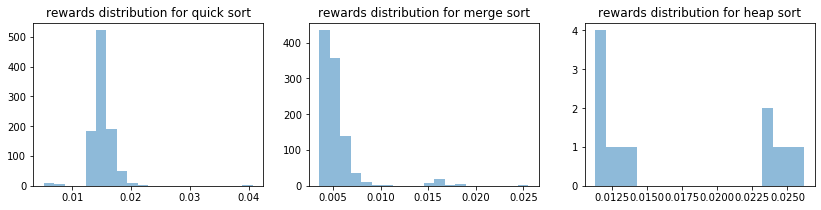

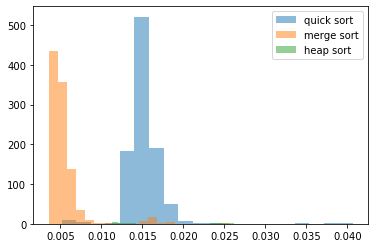

In [84]:
plot_rewards_distribution(arm_rewards_4)
plot_rewards_distribution_together(arm_rewards_4)

Restart at iteration: 503
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.015190757545276067, 'merge_sort': 0.016386350000004768, 'heap_sort': 0.025088933333260382}
Count per chosen algo {'quick_sort': 497, 'merge_sort': 4, 'heap_sort': 3}


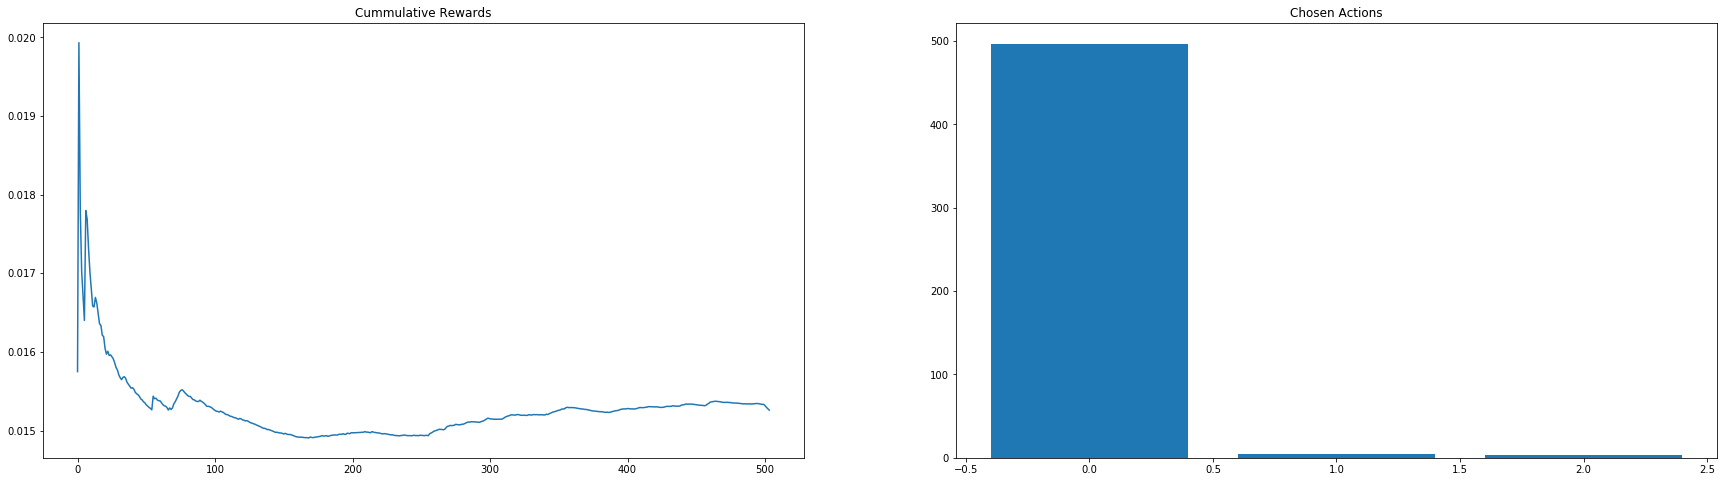

Restart at iteration: 1003
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.006820750000031239, 'merge_sort': 0.005225635091276415, 'heap_sort': 0.013354033333371262}
Count per chosen algo {'quick_sort': 4, 'merge_sort': 493, 'heap_sort': 3}


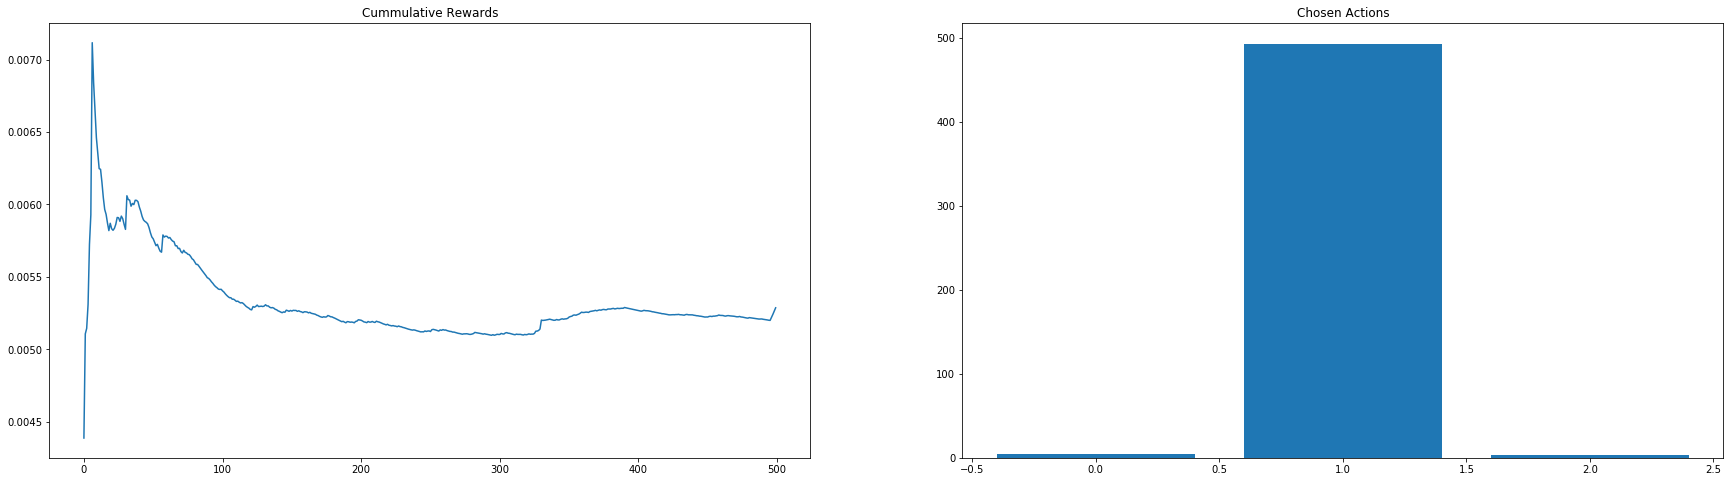

Restart at iteration: 1503
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.015242385412256924, 'merge_sort': 0.016282172000019274, 'heap_sort': 0.0234560500000498}
Count per chosen algo {'quick_sort': 473, 'merge_sort': 25, 'heap_sort': 2}


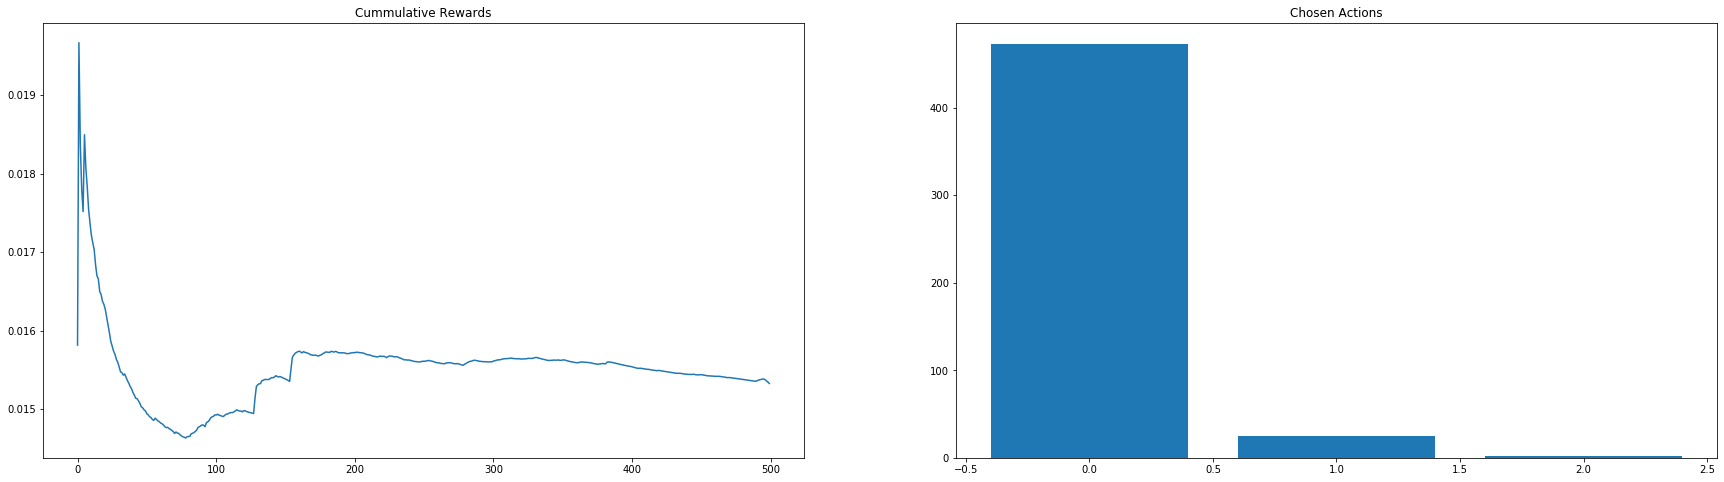

Restart at iteration: 1999
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.00629603333330427, 'merge_sort': 0.005011561963192621, 'heap_sort': 0.011453874999972413}
Count per chosen algo {'quick_sort': 3, 'merge_sort': 489, 'heap_sort': 4}


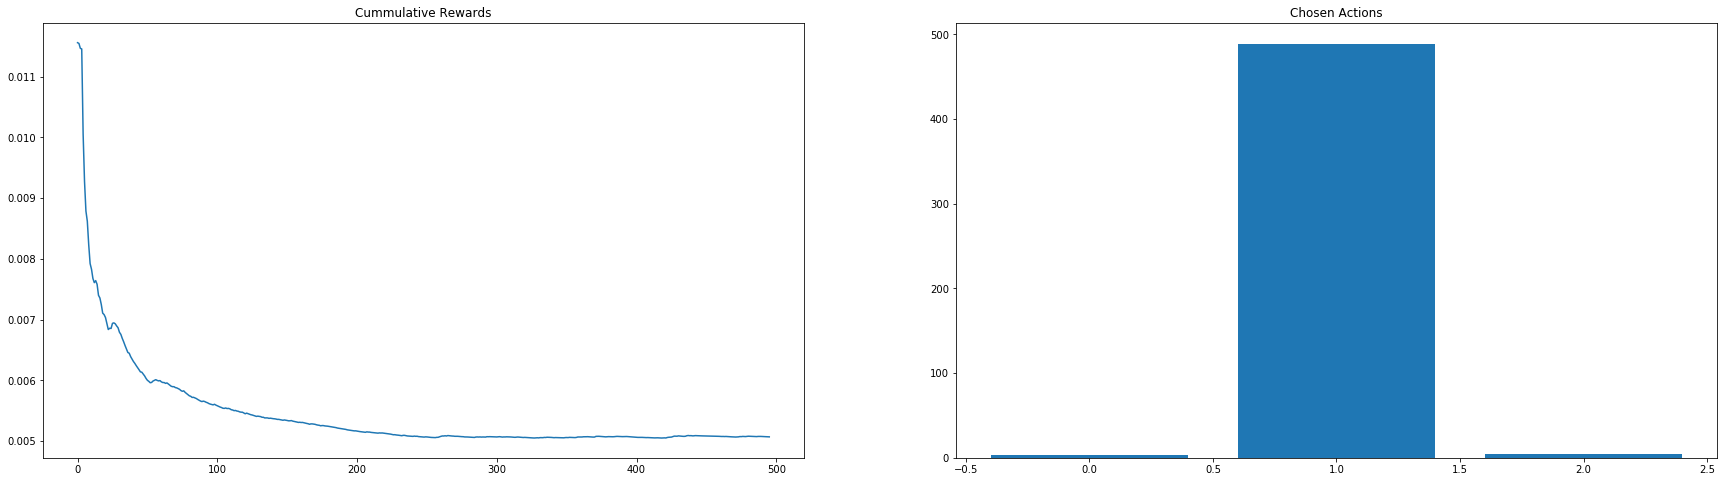

Total reward 20.5132


In [85]:
for elem in list_iteration_results_4:
    sample_mean, sample_count,rewards,cum_rewards,n = elem
    print("Restart at iteration:", n)
    print("Results up to this iteration: ")
    plot_history(rewards,cum_rewards, sample_count, sample_mean)
print("Total reward", np.round(total_reward_4,4))

## Five outliers in a row restart the expriment

In [86]:
list_iteration_results_5, total_reward_5, arm_rewards_5 = ts_quantile(list_distributions, n_samples, num_consec_elem=5)



Iteration: 0
Less than two values for quick_sort
quick_sort Theta 0.07632565744992054
Less than two values for merge_sort
merge_sort Theta 0.048808203411518813
Less than two values for heap_sort
heap_sort Theta 0.01289700610969704


Chosen algorithm is:  heap_sort with reward: 0.028856099999984508
Sample mean is:  0.028856099999984508 Sample variance is: 0.0


Iteration: 1
Less than two values for quick_sort
quick_sort Theta 0.0830480067913163
Less than two values for merge_sort
merge_sort Theta 0.040030024702875394
Less than two values for heap_sort
heap_sort Theta 0.011511387831978782


Chosen algorithm is:  heap_sort with reward: 0.023100300000123752
Sample mean is:  0.02597820000005413 Sample variance is: 8.282308409599269e-06


Iteration: 2
Less than two values for quick_sort
quick_sort Theta 0.05457549057567867
Less than two values for merge_sort
merge_sort Theta 0.0594794523887895
heap_sort Theta 0.028065236321442727


Chosen algorithm is:  heap_sort with reward: 0.02556140000

merge_sort Theta 0.08670980630659103
heap_sort Theta 0.025377058992638805


Chosen algorithm is:  quick_sort with reward: 0.01697380000018711
Sample mean is:  0.015371078260871043 Sample variance is: 3.5499337140025697e-06


Iteration: 27
quick_sort Theta 0.015202401851853665
Less than two values for merge_sort
merge_sort Theta 0.018554710409707065
heap_sort Theta 0.021815979674168366


Chosen algorithm is:  quick_sort with reward: 0.01474000000007436
Sample mean is:  0.01534478333333785 Sample variance is: 3.417922543173911e-06


Iteration: 28
quick_sort Theta 0.015014839879781096
Less than two values for merge_sort
merge_sort Theta 0.09054014422652679
heap_sort Theta 0.025802496516201038


Chosen algorithm is:  quick_sort with reward: 0.01402050000001509
Sample mean is:  0.015291812000004939 Sample variance is: 3.348548733168546e-06


Iteration: 29
quick_sort Theta 0.01493943740720153
Less than two values for merge_sort
merge_sort Theta 0.055705298428919775
heap_sort Theta 0.02433006

merge_sort Theta 0.016892909974129483
heap_sort Theta 0.025986149003860193


Chosen algorithm is:  quick_sort with reward: 0.015801499999952284
Sample mean is:  0.01507663061224497 Sample variance is: 2.497149217317878e-06


Iteration: 55
quick_sort Theta 0.014925349294388381
merge_sort Theta 0.019182477972028888
heap_sort Theta 0.023572818945415033


Chosen algorithm is:  quick_sort with reward: 0.015174000000115484
Sample mean is:  0.01507857800000238 Sample variance is: 2.447392056606328e-06


Iteration: 56
quick_sort Theta 0.015018770630775452
merge_sort Theta 0.01711140903755925
heap_sort Theta 0.02578534593828239


Chosen algorithm is:  quick_sort with reward: 0.014021900000216192
Sample mean is:  0.015057858823535985 Sample variance is: 2.42086819073731e-06


Iteration: 57
quick_sort Theta 0.015116743390386685
merge_sort Theta 0.017888273091829016
heap_sort Theta 0.024331319961864845


Chosen algorithm is:  quick_sort with reward: 0.014591899999913949
Sample mean is:  0.01504889


Chosen algorithm is:  quick_sort with reward: 0.01417019999985314
Sample mean is:  0.01478779036143811 Sample variance is: 1.8028755190077264e-06


Iteration: 91
quick_sort Theta 0.014728881144733667
merge_sort Theta 0.017061820685444817
heap_sort Theta 0.02865713269075916


Chosen algorithm is:  quick_sort with reward: 0.014440400000012232
Sample mean is:  0.014783654761897327 Sample variance is: 1.782832279445639e-06


Iteration: 92
quick_sort Theta 0.014661828595816535
merge_sort Theta 0.01728801133795822
heap_sort Theta 0.023993912866615504


Chosen algorithm is:  quick_sort with reward: 0.015129699999988588
Sample mean is:  0.014787725882345459 Sample variance is: 1.763249999863465e-06


Iteration: 93
quick_sort Theta 0.01467899450536771
merge_sort Theta 0.017520038454261165
heap_sort Theta 0.025776117231652525


Chosen algorithm is:  quick_sort with reward: 0.014398000000028333
Sample mean is:  0.014783194186039446 Sample variance is: 1.744492675958153e-06


Iteration: 94
quick_

quick_sort Theta 0.014883497232143685
merge_sort Theta 0.0165768452004199
heap_sort Theta 0.025550763338183253


Chosen algorithm is:  quick_sort with reward: 0.01801460000001498
Sample mean is:  0.014773761061945079 Sample variance is: 1.5717919225890539e-06


Iteration: 121
quick_sort Theta 0.014765070145777104
merge_sort Theta 0.018253408900936182
heap_sort Theta 0.025377377309368933


Chosen algorithm is:  quick_sort with reward: 0.013552699999991091
Sample mean is:  0.014763049999998114 Sample variance is: 1.5709684079728742e-06


Iteration: 122
quick_sort Theta 0.014731276995713324
merge_sort Theta 0.016306025569570583
heap_sort Theta 0.024948348102189342


Chosen algorithm is:  quick_sort with reward: 0.013970900000003894
Sample mean is:  0.014756161739128599 Sample variance is: 1.5627169008308764e-06


Iteration: 123
quick_sort Theta 0.014655888516974348
merge_sort Theta 0.015487838857263002
heap_sort Theta 0.02654821092351329


Chosen algorithm is:  quick_sort with reward: 0.0



Iteration: 156
quick_sort Theta 0.014697190869466225
merge_sort Theta 0.01704349389244192
heap_sort Theta 0.02366484652808941


Chosen algorithm is:  quick_sort with reward: 0.014666900000065652
Sample mean is:  0.01480088120804843 Sample variance is: 1.4830649620764074e-06


Iteration: 157
quick_sort Theta 0.014988872258305683
merge_sort Theta 0.016758790411512618
heap_sort Theta 0.024815044029512626


Chosen algorithm is:  quick_sort with reward: 0.014394699999911609
Sample mean is:  0.014798173333327516 Sample variance is: 1.47427041756935e-06


Iteration: 158
quick_sort Theta 0.014917260543004589
merge_sort Theta 0.017481179607129173
heap_sort Theta 0.02553550138520285


Chosen algorithm is:  quick_sort with reward: 0.014517000000068947
Sample mean is:  0.014796311258272824 Sample variance is: 1.465027135846943e-06


Iteration: 159
quick_sort Theta 0.014743113544226716
merge_sort Theta 0.018346342409550978
heap_sort Theta 0.02548716721388762


Chosen algorithm is:  quick_sort wit



Chosen algorithm is:  quick_sort with reward: 0.015524200000072597
Sample mean is:  0.014779574301673667 Sample variance is: 1.4411595839297448e-06


Iteration: 187
quick_sort Theta 0.014781972731836573
merge_sort Theta 0.01716804479130707
heap_sort Theta 0.02520133505917906


Chosen algorithm is:  quick_sort with reward: 0.015429300000050716
Sample mean is:  0.014783183888886874 Sample variance is: 1.4354853542499049e-06


Iteration: 188
quick_sort Theta 0.014657794679403502
merge_sort Theta 0.017905275478371726
heap_sort Theta 0.02859268192812484


Chosen algorithm is:  quick_sort with reward: 0.014003699999875607
Sample mean is:  0.014778877348063607 Sample variance is: 1.430892828834375e-06


Iteration: 189
quick_sort Theta 0.014884118711591721
merge_sort Theta 0.015923401524981878
heap_sort Theta 0.022503262563388714


Chosen algorithm is:  quick_sort with reward: 0.014115899999978865
Sample mean is:  0.014775234615381824 Sample variance is: 1.4254325600760562e-06


Iteration: 1


Iteration: 219
quick_sort Theta 0.014881315099417187
merge_sort Theta 0.016738094799109968
heap_sort Theta 0.02776397640262448


Chosen algorithm is:  quick_sort with reward: 0.016114100000095277
Sample mean is:  0.0149915490566001 Sample variance is: 2.4645054349680857e-06


Iteration: 220
quick_sort Theta 0.015058093452836499
merge_sort Theta 0.018553185491060744
heap_sort Theta 0.025448762179010462


Chosen algorithm is:  quick_sort with reward: 0.013826500000050146
Sample mean is:  0.014986079342719583 Sample variance is: 2.4592775541427513e-06


Iteration: 221
quick_sort Theta 0.015004710040808384
merge_sort Theta 0.018447438117371234
heap_sort Theta 0.0257918209918118


Chosen algorithm is:  quick_sort with reward: 0.014015400000062073
Sample mean is:  0.01498154345794081 Sample variance is: 2.452167918359872e-06


Iteration: 222
quick_sort Theta 0.014943625640300332
merge_sort Theta 0.01803084755140231
heap_sort Theta 0.02531393474941636


Chosen algorithm is:  quick_sort with 



Iteration: 253
quick_sort Theta 0.015156737550064782
merge_sort Theta 0.016140133911024
heap_sort Theta 0.02508276937378681


Chosen algorithm is:  quick_sort with reward: 0.01860830000009628
Sample mean is:  0.01508701632652372 Sample variance is: 2.416834739574627e-06


Iteration: 254
quick_sort Theta 0.01488998150018726
merge_sort Theta 0.01635639248753264
heap_sort Theta 0.02644164459460155


Chosen algorithm is:  quick_sort with reward: 0.014727100000072824
Sample mean is:  0.015085553252025952 Sample variance is: 2.4075346519245164e-06


Iteration: 255
quick_sort Theta 0.015078683159478235
merge_sort Theta 0.01685403094806872
heap_sort Theta 0.02522017752410755


Chosen algorithm is:  quick_sort with reward: 0.015201400000023568
Sample mean is:  0.015086022267200032 Sample variance is: 2.3978416619780164e-06


Iteration: 256
quick_sort Theta 0.015093397708003378
merge_sort Theta 0.016789546251653166
heap_sort Theta 0.025652552582534707


Chosen algorithm is:  quick_sort with re


Iteration: 288
quick_sort Theta 0.014987610894783225
merge_sort Theta 0.01625872181021848
heap_sort Theta 0.02346120207123783


Chosen algorithm is:  quick_sort with reward: 0.016748799999959374
Sample mean is:  0.015062679928312582 Sample variance is: 2.185608830711021e-06


Iteration: 289
quick_sort Theta 0.015134157084737516
merge_sort Theta 0.0174757075658296
heap_sort Theta 0.02497104688051753


Chosen algorithm is:  quick_sort with reward: 0.014447300000028918
Sample mean is:  0.015060482142854426 Sample variance is: 2.179150727683756e-06


Iteration: 290
quick_sort Theta 0.014852070800356679
merge_sort Theta 0.01721253199102922
heap_sort Theta 0.02492937754580015


Chosen algorithm is:  quick_sort with reward: 0.015682599999990998
Sample mean is:  0.015062696085406512 Sample variance is: 2.172768174542432e-06


Iteration: 291
quick_sort Theta 0.015108055066399211
merge_sort Theta 0.02042039136388445
heap_sort Theta 0.025996159919326335


Chosen algorithm is:  quick_sort with re

Sample mean is:  0.01520626148866876 Sample variance is: 2.8561747981557343e-06


Iteration: 320
quick_sort Theta 0.015193398113743902
merge_sort Theta 0.01701085707770689
heap_sort Theta 0.02666614919688429


Chosen algorithm is:  quick_sort with reward: 0.01969930000018394
Sample mean is:  0.01522075516128655 Sample variance is: 2.911871893763985e-06


Iteration: 321
quick_sort Theta 0.015057024796902055
merge_sort Theta 0.01694227499364715
heap_sort Theta 0.026394044260076195


Chosen algorithm is:  quick_sort with reward: 0.018201900000121896
Sample mean is:  0.015230340836009494 Sample variance is: 2.930993361196858e-06


Iteration: 322
quick_sort Theta 0.015262116257674417
merge_sort Theta 0.017247407884458887
heap_sort Theta 0.026322940224747956


Chosen algorithm is:  quick_sort with reward: 0.01825959999996485
Sample mean is:  0.01524004999999653 Sample variance is: 2.9509164578225913e-06


Iteration: 323
quick_sort Theta 0.015294836550082413
merge_sort Theta 0.018317506132542



Iteration: 351
quick_sort Theta 0.015404225417881067
merge_sort Theta 0.01671981663869521
heap_sort Theta 0.025137407749520665


Chosen algorithm is:  quick_sort with reward: 0.01587500000005093
Sample mean is:  0.015337636070376059 Sample variance is: 3.1119497450078123e-06


Iteration: 352
quick_sort Theta 0.015312729979454338
merge_sort Theta 0.016869504954039653
heap_sort Theta 0.025521434603912613


Chosen algorithm is:  quick_sort with reward: 0.01382740000008198
Sample mean is:  0.01533322017543368 Sample variance is: 3.109500020444025e-06


Iteration: 353
quick_sort Theta 0.015313126211015621
merge_sort Theta 0.01673550374649596
heap_sort Theta 0.025492524952334256


Chosen algorithm is:  quick_sort with reward: 0.014921799999910945
Sample mean is:  0.015332020699703292 Sample variance is: 3.100926472490286e-06


Iteration: 354
quick_sort Theta 0.015239737598756777
merge_sort Theta 0.01666027735655151
heap_sort Theta 0.023494554131693463


Chosen algorithm is:  quick_sort wit


Chosen algorithm is:  quick_sort with reward: 0.014185600000018894
Sample mean is:  0.015309142175058982 Sample variance is: 3.0862066990940707e-06


Iteration: 388
quick_sort Theta 0.015178554034398368
merge_sort Theta 0.017472063302403452
heap_sort Theta 0.02645990980218027


Chosen algorithm is:  quick_sort with reward: 0.015479099999993196
Sample mean is:  0.01530959179893447 Sample variance is: 3.078118346041336e-06


Iteration: 389
quick_sort Theta 0.015101480896186271
merge_sort Theta 0.017519976658658364
heap_sort Theta 0.025729179220986654


Chosen algorithm is:  quick_sort with reward: 0.014499599999908241
Sample mean is:  0.015307454617406697 Sample variance is: 3.071723193716634e-06


Iteration: 390
quick_sort Theta 0.015318724014698758
merge_sort Theta 0.01695930036548095
heap_sort Theta 0.024670312041273998


Chosen algorithm is:  quick_sort with reward: 0.015622800000073767
Sample mean is:  0.015308284473676874 Sample variance is: 3.0639007143095544e-06


Iteration: 391



Iteration: 422
quick_sort Theta 0.015264178245775207
merge_sort Theta 0.01654881358756852
heap_sort Theta 0.02368043517429653


Chosen algorithm is:  quick_sort with reward: 0.013653900000008434
Sample mean is:  0.015326759708730086 Sample variance is: 3.095770364729324e-06


Iteration: 423
quick_sort Theta 0.015322077830295568
merge_sort Theta 0.016889598463595404
heap_sort Theta 0.02590670469539458


Chosen algorithm is:  quick_sort with reward: 0.014556200000015451
Sample mean is:  0.015324893946723511 Sample variance is: 3.089708752668637e-06


Iteration: 424
quick_sort Theta 0.015390972694520805
merge_sort Theta 0.01726055361244937
heap_sort Theta 0.02684251114578458


Chosen algorithm is:  quick_sort with reward: 0.015377599999965241
Sample mean is:  0.01532502125603086 Sample variance is: 3.0822523818121365e-06


Iteration: 425
quick_sort Theta 0.015492480626073087
merge_sort Theta 0.01699954074103187
heap_sort Theta 0.02536858803941818


Chosen algorithm is:  quick_sort with 



Chosen algorithm is:  quick_sort with reward: 0.0182436999998572
Sample mean is:  0.015310036281170288 Sample variance is: 2.9937122420281007e-06


Iteration: 452
quick_sort Theta 0.015244049658469674
merge_sort Theta 0.017070085985599386
heap_sort Theta 0.02504685624977325


Chosen algorithm is:  quick_sort with reward: 0.017004099999894606
Sample mean is:  0.015313869004515817 Sample variance is: 2.9934173252034544e-06


Iteration: 453
quick_sort Theta 0.015317257336218956
merge_sort Theta 0.017816199627405178
heap_sort Theta 0.026775365555953737


Chosen algorithm is:  quick_sort with reward: 0.018501600000035978
Sample mean is:  0.01532106478554408 Sample variance is: 3.0095466104413224e-06


Iteration: 454
quick_sort Theta 0.015245439938933753
merge_sort Theta 0.01727311702778132
heap_sort Theta 0.02703549043772318


Chosen algorithm is:  quick_sort with reward: 0.016074699999990116
Sample mean is:  0.015322762162153194 Sample variance is: 3.0040446740071494e-06


Iteration: 455

Iteration: 486
quick_sort Theta 0.015350328436492585
merge_sort Theta 0.016882569902626116
heap_sort Theta 0.025853429890055665


Chosen algorithm is:  quick_sort with reward: 0.013909400000102323
Sample mean is:  0.015299982352933764 Sample variance is: 2.926678264343339e-06


Iteration: 487
quick_sort Theta 0.015261817636043755
merge_sort Theta 0.016071777816643814
heap_sort Theta 0.02664089309935511


Chosen algorithm is:  quick_sort with reward: 0.018134199999849443
Sample mean is:  0.015305924109006962 Sample variance is: 2.93734759594885e-06


Iteration: 488
quick_sort Theta 0.01540458910346954
merge_sort Theta 0.01817409134514122
heap_sort Theta 0.025849380446477273


Chosen algorithm is:  quick_sort with reward: 0.017496699999810517
Sample mean is:  0.015310507322167639 Sample variance is: 2.9412223043481855e-06


Iteration: 489
quick_sort Theta 0.01526747071029217
merge_sort Theta 0.017227957011098378
heap_sort Theta 0.02546480831683241


Chosen algorithm is:  quick_sort with 



Chosen algorithm is:  merge_sort with reward: 0.0073919999999816355
Sample mean is:  0.005490166666630911 Sample variance is: 1.8209385755295934e-06


Iteration: 514
Less than two values for quick_sort
quick_sort Theta 0.03511585907146723
merge_sort Theta 0.005887407961779065
Less than two values for heap_sort
heap_sort Theta 0.05460791022846639


Chosen algorithm is:  merge_sort with reward: 0.0054025000001729495
Sample mean is:  0.005481399999985115 Sample variance is: 1.6395364079733408e-06


Iteration: 515
Less than two values for quick_sort
quick_sort Theta 0.08508421668918173
merge_sort Theta 0.005404506463404462
Less than two values for heap_sort
heap_sort Theta 0.06429177425298792


Chosen algorithm is:  merge_sort with reward: 0.004282299999886163
Sample mean is:  0.005372390909067029 Sample variance is: 1.6093174626400046e-06


Iteration: 516
Less than two values for quick_sort
quick_sort Theta 0.004790933155689359
merge_sort Theta 0.005170828081070762
Less than two values 



Chosen algorithm is:  merge_sort with reward: 0.005530799999860392
Sample mean is:  0.005022884615370388 Sample variance is: 7.028660982063357e-07


Iteration: 548
quick_sort Theta 0.0060929090891325395
merge_sort Theta 0.004787864407990058
Less than two values for heap_sort
heap_sort Theta 0.06760312165376972


Chosen algorithm is:  merge_sort with reward: 0.005941200000052049
Sample mean is:  0.00504584249998743 Sample variance is: 7.058499599286636e-07


Iteration: 549
quick_sort Theta 0.006000338641516004
merge_sort Theta 0.0051589248491123625
Less than two values for heap_sort
heap_sort Theta 0.03434922058515777


Chosen algorithm is:  merge_sort with reward: 0.00478009999983442
Sample mean is:  0.005039360975593454 Sample variance is: 6.903145135862648e-07


Iteration: 550
quick_sort Theta 0.006194402472712234
merge_sort Theta 0.0049479163593758365
Less than two values for heap_sort
heap_sort Theta 0.023025114976898343


Chosen algorithm is:  merge_sort with reward: 0.004595299



Chosen algorithm is:  merge_sort with reward: 0.006297599999925296
Sample mean is:  0.005144686764702007 Sample variance is: 7.265378293888832e-07


Iteration: 580
quick_sort Theta 0.006784198231922449
merge_sort Theta 0.005006318240900124
Less than two values for heap_sort
heap_sort Theta 0.03264961466390128


Chosen algorithm is:  merge_sort with reward: 0.004446599999937462
Sample mean is:  0.005134569565212666 Sample variance is: 7.229686209641086e-07


Iteration: 581
quick_sort Theta 0.007375673671182121
merge_sort Theta 0.0051293621273050686
Less than two values for heap_sort
heap_sort Theta 0.0312778547968154


Chosen algorithm is:  merge_sort with reward: 0.0058639000001221575
Sample mean is:  0.005144988571425659 Sample variance is: 7.201308404496589e-07


Iteration: 582
quick_sort Theta 0.006710653224491828
merge_sort Theta 0.0050199165240423236
Less than two values for heap_sort
heap_sort Theta 0.05304940896517921


Chosen algorithm is:  merge_sort with reward: 0.004487000



Chosen algorithm is:  merge_sort with reward: 0.006640500000003158
Sample mean is:  0.005218181249996216 Sample variance is: 8.532898304910328e-07


Iteration: 610
quick_sort Theta 0.006834777733665898
merge_sort Theta 0.005242462146866197
heap_sort Theta 0.011619098991554703


Chosen algorithm is:  merge_sort with reward: 0.004317099999980201
Sample mean is:  0.00520889175257337 Sample variance is: 8.527773253022657e-07


Iteration: 611
quick_sort Theta 0.006742489184794136
merge_sort Theta 0.005271899730147757
heap_sort Theta 0.011464314615742956


Chosen algorithm is:  merge_sort with reward: 0.00582340000005388
Sample mean is:  0.0052151622448946 Sample variance is: 8.47889466033614e-07


Iteration: 612
quick_sort Theta 0.00665953190467186
merge_sort Theta 0.005143208777387413
heap_sort Theta 0.014631812361023965


Chosen algorithm is:  merge_sort with reward: 0.005595899999889298
Sample mean is:  0.005219008080803637 Sample variance is: 8.407743904489142e-07


Iteration: 613
qui



Iteration: 645
quick_sort Theta 0.007142490856340698
merge_sort Theta 0.005264540057572071
heap_sort Theta 0.012389240119967226


Chosen algorithm is:  merge_sort with reward: 0.005423000000064349
Sample mean is:  0.005230599236631145 Sample variance is: 8.865508797905714e-07


Iteration: 646
quick_sort Theta 0.005968162964586113
merge_sort Theta 0.005285486854351184
heap_sort Theta 0.012011487797838534


Chosen algorithm is:  merge_sort with reward: 0.007080200000018522
Sample mean is:  0.0052446113636265045 Sample variance is: 9.055550863310664e-07


Iteration: 647
quick_sort Theta 0.00635466775337855
merge_sort Theta 0.005284295384251818
heap_sort Theta 0.012355990986200206


Chosen algorithm is:  merge_sort with reward: 0.005708700000013778
Sample mean is:  0.005248100751870018 Sample variance is: 9.003536110728781e-07


Iteration: 648
quick_sort Theta 0.007151281661781147
merge_sort Theta 0.005168673399039518
heap_sort Theta 0.013934359749595475


Chosen algorithm is:  merge_sor



Iteration: 676
quick_sort Theta 0.006491499033690982
merge_sort Theta 0.0052960278020035235
heap_sort Theta 0.012586658313862992


Chosen algorithm is:  merge_sort with reward: 0.005177500000172586
Sample mean is:  0.0051927067901162425 Sample variance is: 8.346176937308102e-07


Iteration: 677
quick_sort Theta 0.007551300644196617
merge_sort Theta 0.005188449825423657
heap_sort Theta 0.012585710618086615


Chosen algorithm is:  merge_sort with reward: 0.004513500000030035
Sample mean is:  0.005188539877293627 Sample variance is: 8.323101721018873e-07


Iteration: 678
quick_sort Theta 0.007088548087351049
merge_sort Theta 0.005264779489386754
heap_sort Theta 0.012943189445312224


Chosen algorithm is:  merge_sort with reward: 0.005350500000076863
Sample mean is:  0.005189527439017915 Sample variance is: 8.273940804168382e-07


Iteration: 679
quick_sort Theta 0.006971872953206397
merge_sort Theta 0.005045488022289395
heap_sort Theta 0.011901213416679017


Chosen algorithm is:  merge_s



Chosen algorithm is:  merge_sort with reward: 0.005742199999986042
Sample mean is:  0.005249492424237553 Sample variance is: 9.413108576766443e-07


Iteration: 713
quick_sort Theta 0.006774074921142026
merge_sort Theta 0.005206390694078565
heap_sort Theta 0.012994107929445426


Chosen algorithm is:  merge_sort with reward: 0.005371200000126919
Sample mean is:  0.005250104020096294 Sample variance is: 9.366547141615833e-07


Iteration: 714
quick_sort Theta 0.007051079978670743
merge_sort Theta 0.00516567243862145
heap_sort Theta 0.010715674801661142


Chosen algorithm is:  merge_sort with reward: 0.004157300000088071
Sample mean is:  0.005244639999996252 Sample variance is: 9.379126882058523e-07


Iteration: 715
quick_sort Theta 0.007188171889139723
merge_sort Theta 0.005378298516988968
heap_sort Theta 0.013488893650326144


Chosen algorithm is:  merge_sort with reward: 0.005855299999893759
Sample mean is:  0.0052476781094484785 Sample variance is: 9.350924777349628e-07


Iteration: 7



Iteration: 744
quick_sort Theta 0.00592017203221675
merge_sort Theta 0.005305780984447837
heap_sort Theta 0.012292998121341915


Chosen algorithm is:  merge_sort with reward: 0.004422599999998056
Sample mean is:  0.005248435217386624 Sample variance is: 9.71262095673653e-07


Iteration: 745
quick_sort Theta 0.006820819083295123
merge_sort Theta 0.005310077595788677
heap_sort Theta 0.01288487765512869


Chosen algorithm is:  merge_sort with reward: 0.003920899999911853
Sample mean is:  0.005242688311683271 Sample variance is: 9.746536906444298e-07


Iteration: 746
quick_sort Theta 0.007305786592045449
merge_sort Theta 0.005276022494722095
heap_sort Theta 0.01202293670179189


Chosen algorithm is:  merge_sort with reward: 0.0055085999999846536
Sample mean is:  0.005243834482753535 Sample variance is: 9.707560637265267e-07


Iteration: 747
quick_sort Theta 0.0068317434004667625
merge_sort Theta 0.0052164059572905284
heap_sort Theta 0.012474349512466506


Chosen algorithm is:  merge_sort

merge_sort Theta 0.0052039109486925065
heap_sort Theta 0.012122468903201629


Chosen algorithm is:  merge_sort with reward: 0.00818610000010267
Sample mean is:  0.005278930337074901 Sample variance is: 1.0181046375553934e-06


Iteration: 782
quick_sort Theta 0.006948598331135546
merge_sort Theta 0.005214334550289505
heap_sort Theta 0.012841235677570374


Chosen algorithm is:  merge_sort with reward: 0.00477069999988089
Sample mean is:  0.0052770339552197 Sample variance is: 1.0152659421796442e-06


Iteration: 783
quick_sort Theta 0.007001526295908443
merge_sort Theta 0.005401432926611147
heap_sort Theta 0.012239807544956367


Chosen algorithm is:  merge_sort with reward: 0.0048698000000513275
Sample mean is:  0.005275520074345468 Sample variance is: 1.0121059312070284e-06


Iteration: 784
quick_sort Theta 0.006647514372234814
merge_sort Theta 0.005258432273282778
heap_sort Theta 0.011760989940883353


Chosen algorithm is:  merge_sort with reward: 0.00430000000005748
Sample mean is:  0.



Iteration: 817
quick_sort Theta 0.007190457129299945
merge_sort Theta 0.005240201152946869
heap_sort Theta 0.012507405247355625


Chosen algorithm is:  merge_sort with reward: 0.008872199999814256
Sample mean is:  0.005275816171610035 Sample variance is: 1.0217705005056815e-06


Iteration: 818
quick_sort Theta 0.006284034523379595
merge_sort Theta 0.005326402608170375
heap_sort Theta 0.011815643568187532


Chosen algorithm is:  merge_sort with reward: 0.005873099999917031
Sample mean is:  0.005277780921045256 Sample variance is: 1.0195790661569548e-06


Iteration: 819
quick_sort Theta 0.005948162525064509
merge_sort Theta 0.005211171758747259
heap_sort Theta 0.012442935440007253


Chosen algorithm is:  merge_sort with reward: 0.00825040000017907
Sample mean is:  0.00528752721310799 Sample variance is: 1.0451132075003545e-06


Iteration: 820
quick_sort Theta 0.007405035577158355
merge_sort Theta 0.005315377739404633
heap_sort Theta 0.012452026371405904


Chosen algorithm is:  merge_so



Iteration: 847
quick_sort Theta 0.007486514733621119
merge_sort Theta 0.0053078670385029465
heap_sort Theta 0.012878175406446027


Chosen algorithm is:  merge_sort with reward: 0.005403099999966798
Sample mean is:  0.005290795495487804 Sample variance is: 1.0524594723866551e-06


Iteration: 848
quick_sort Theta 0.005623393683640905
merge_sort Theta 0.0052901923112141985
heap_sort Theta 0.010804049902998695


Chosen algorithm is:  merge_sort with reward: 0.004117299999961688
Sample mean is:  0.00528728203592036 Sample variance is: 1.0534190807000002e-06


Iteration: 849
quick_sort Theta 0.006553955925366083
merge_sort Theta 0.005290711936743629
heap_sort Theta 0.012311411614679487


Chosen algorithm is:  merge_sort with reward: 0.004607400000168127
Sample mean is:  0.005285252537306175 Sample variance is: 1.0516502469154905e-06


Iteration: 850
quick_sort Theta 0.006534430069014438
merge_sort Theta 0.005280386893131291
heap_sort Theta 0.011414794190266055


Chosen algorithm is:  merge



Chosen algorithm is:  merge_sort with reward: 0.005801899999823945
Sample mean is:  0.005279756198338252 Sample variance is: 1.0264481393816636e-06


Iteration: 878
quick_sort Theta 0.006653299488991844
merge_sort Theta 0.005290024276846551
heap_sort Theta 0.012065235900910402


Chosen algorithm is:  merge_sort with reward: 0.004115300000194111
Sample mean is:  0.005276557142848845 Sample variance is: 1.0273431529476574e-06


Iteration: 879
quick_sort Theta 0.007082957496022989
merge_sort Theta 0.005272577355920579
heap_sort Theta 0.012277984668934238


Chosen algorithm is:  merge_sort with reward: 0.005389599999944039
Sample mean is:  0.00527686684930664 Sample variance is: 1.0245634283572184e-06


Iteration: 880
quick_sort Theta 0.0051784295907529535
merge_sort Theta 0.005347622075165727
heap_sort Theta 0.011749978857652235


Chosen algorithm is:  quick_sort with reward: 0.007808699999941382
Sample mean is:  0.00693720000001008 Sample variance is: 1.3369167775000557e-06


Iteration


Chosen algorithm is:  quick_sort with reward: 0.006539900000007037
Sample mean is:  0.006893055555565297 Sample variance is: 1.2039603246916463e-06


Iteration: 913
quick_sort Theta 0.006652520448514268
merge_sort Theta 0.005326953004996328
heap_sort Theta 0.012719712280669905


Chosen algorithm is:  merge_sort with reward: 0.00560019999988981
Sample mean is:  0.00528334483626296 Sample variance is: 1.0450800555280926e-06


Iteration: 914
quick_sort Theta 0.00721807290410708
merge_sort Theta 0.005271529691332822
heap_sort Theta 0.012464629069664978


Chosen algorithm is:  merge_sort with reward: 0.008833699999968303
Sample mean is:  0.005292265326624028 Sample variance is: 1.0740455601107683e-06


Iteration: 915
quick_sort Theta 0.006934873642414523
merge_sort Theta 0.005261564296088236
heap_sort Theta 0.012438180244577756


Chosen algorithm is:  merge_sort with reward: 0.005694499999890468
Sample mean is:  0.005293273433574571 Sample variance is: 1.0717581958919642e-06


Iteration: 9



Iteration: 948
quick_sort Theta 0.006669518180418194
merge_sort Theta 0.005242583929074708
heap_sort Theta 0.012609953615656548


Chosen algorithm is:  merge_sort with reward: 0.005364999999983411
Sample mean is:  0.005290953472211341 Sample variance is: 1.0547260895790941e-06


Iteration: 949
quick_sort Theta 0.006730647953455187
merge_sort Theta 0.005423190696517388
heap_sort Theta 0.012638928878496734


Chosen algorithm is:  merge_sort with reward: 0.004835700000057841
Sample mean is:  0.005289902078511218 Sample variance is: 1.05276777776315e-06


Iteration: 950
quick_sort Theta 0.007236858009843532
merge_sort Theta 0.0053065426503084365
heap_sort Theta 0.012732736753710765


Chosen algorithm is:  merge_sort with reward: 0.004263600000058432
Sample mean is:  0.005287537327178377 Sample variance is: 1.0527634027153745e-06


Iteration: 951
quick_sort Theta 0.007675507288556602
merge_sort Theta 0.005175726926852225
heap_sort Theta 0.012285845955012796


Chosen algorithm is:  merge_s


Iteration: 979
quick_sort Theta 0.006646360663610075
merge_sort Theta 0.005256875727641938
heap_sort Theta 0.01154021284982982


Chosen algorithm is:  merge_sort with reward: 0.00534590000006574
Sample mean is:  0.005273734125261179 Sample variance is: 1.0120599034629098e-06


Iteration: 980
quick_sort Theta 0.006578030120260218
merge_sort Theta 0.00528512870221223
heap_sort Theta 0.01214745299221453


Chosen algorithm is:  merge_sort with reward: 0.0043230000001130975
Sample mean is:  0.005271685129301808 Sample variance is: 1.0118225918742832e-06


Iteration: 981
quick_sort Theta 0.006990991955096723
merge_sort Theta 0.005281502670263511
heap_sort Theta 0.013072091063717314


Chosen algorithm is:  merge_sort with reward: 0.005531400000108988
Sample mean is:  0.005272243655905695 Sample variance is: 1.0097913750239162e-06


Iteration: 982
quick_sort Theta 0.00691350498690021
merge_sort Theta 0.005317368052669764
heap_sort Theta 0.012259225826294006


Chosen algorithm is:  merge_sort 


Chosen algorithm is:  quick_sort with reward: 0.014487299999927927
Sample mean is:  0.014548549999915394 Sample variance is: 1.7822492249485304e-07


Iteration: 1010
quick_sort Theta 0.01441649421964959
Less than two values for merge_sort
merge_sort Theta 0.06304819817746797
Less than two values for heap_sort
heap_sort Theta 0.06285155152171722


Chosen algorithm is:  quick_sort with reward: 0.013852099999894563
Sample mean is:  0.014409259999911227 Sample variance is: 2.2018675440052508e-07


Iteration: 1011
quick_sort Theta 0.015140995135889934
Less than two values for merge_sort
merge_sort Theta 0.010212633962656382
Less than two values for heap_sort
heap_sort Theta 0.05676647329414394


Chosen algorithm is:  merge_sort with reward: 0.016407200000003286
Sample mean is:  0.016901500000017222 Sample variance is: 2.443324900137775e-07


Iteration: 1012
quick_sort Theta 0.014412167914090095
merge_sort Theta 0.07405744918286797
Less than two values for heap_sort
heap_sort Theta 0.001393



Chosen algorithm is:  quick_sort with reward: 0.014360800000076779
Sample mean is:  0.0145828413793142 Sample variance is: 3.5443039071061714e-07


Iteration: 1039
quick_sort Theta 0.014529984253938399
merge_sort Theta 0.016658371679986864
heap_sort Theta 0.02739056796882359


Chosen algorithm is:  quick_sort with reward: 0.01548359999992499
Sample mean is:  0.014612866666667893 Sample variance is: 3.6876006289307987e-07


Iteration: 1040
quick_sort Theta 0.014501713315562423
merge_sort Theta 0.01700431539111662
heap_sort Theta 0.024274194930785767


Chosen algorithm is:  quick_sort with reward: 0.014016899999887755
Sample mean is:  0.014593641935481438 Sample variance is: 3.67952285669048e-07


Iteration: 1041
quick_sort Theta 0.014466986145668199
merge_sort Theta 0.016616239456886336
heap_sort Theta 0.024234810006684263


Chosen algorithm is:  quick_sort with reward: 0.014261699999906341
Sample mean is:  0.014583268749994716 Sample variance is: 3.5978946903329025e-07


Iteration: 1



Iteration: 1068
quick_sort Theta 0.014608083112854442
merge_sort Theta 0.019287227128093727
heap_sort Theta 0.024265717024399888


Chosen algorithm is:  quick_sort with reward: 0.014423999999962689
Sample mean is:  0.014538150000005553 Sample variance is: 4.1029693112253814e-07


Iteration: 1069
quick_sort Theta 0.014725502160196196
merge_sort Theta 0.016583229767995464
heap_sort Theta 0.0242127100149018


Chosen algorithm is:  quick_sort with reward: 0.014892499999859865
Sample mean is:  0.014544155932206473 Sample variance is: 4.05434876702194e-07


Iteration: 1070
quick_sort Theta 0.014503091232935576
merge_sort Theta 0.01632184261345906
heap_sort Theta 0.024299056180099296


Chosen algorithm is:  quick_sort with reward: 0.013973400000168112
Sample mean is:  0.014534643333339167 Sample variance is: 4.0401651145256344e-07


Iteration: 1071
quick_sort Theta 0.014504364963506815
merge_sort Theta 0.01638280338224837
heap_sort Theta 0.024162149364690657


Chosen algorithm is:  quick_so



Iteration: 1103
quick_sort Theta 0.014621443352548632
merge_sort Theta 0.016739767872293167
heap_sort Theta 0.02492772544307962


Chosen algorithm is:  quick_sort with reward: 0.013599699999986115
Sample mean is:  0.014522127173921965 Sample variance is: 5.510984661042263e-07


Iteration: 1104
quick_sort Theta 0.01453175720167273
merge_sort Theta 0.0166765383547889
heap_sort Theta 0.025970666444962175


Chosen algorithm is:  quick_sort with reward: 0.013500499999963722
Sample mean is:  0.014511141935492305 Sample variance is: 5.562748187749095e-07


Iteration: 1105
quick_sort Theta 0.014593644405139394
merge_sort Theta 0.016704442751809476
heap_sort Theta 0.026190294330793572


Chosen algorithm is:  quick_sort with reward: 0.01543390000006184
Sample mean is:  0.014520958510647301 Sample variance is: 5.593189602968508e-07


Iteration: 1106
quick_sort Theta 0.014460796331600275
merge_sort Theta 0.017390927339975996
heap_sort Theta 0.02658427052483462


Chosen algorithm is:  quick_sort 



Chosen algorithm is:  quick_sort with reward: 0.01589050000006864
Sample mean is:  0.015056960000010803 Sample variance is: 7.081915086424892e-06


Iteration: 1137
quick_sort Theta 0.01501263225437135
merge_sort Theta 0.01610723874957323
heap_sort Theta 0.028126914964310322


Chosen algorithm is:  quick_sort with reward: 0.014298999999937223
Sample mean is:  0.015050944444454664 Sample variance is: 7.030232774716931e-06


Iteration: 1138
quick_sort Theta 0.015245200038970362
merge_sort Theta 0.011899680649664996
heap_sort Theta 0.02672591080098228


Chosen algorithm is:  merge_sort with reward: 0.015451999999868349
Sample mean is:  0.01615737999995872 Sample variance is: 5.280290336528649e-07


Iteration: 1139
quick_sort Theta 0.014433700422485823
merge_sort Theta 0.016697440310767517
heap_sort Theta 0.023908056413983633


Chosen algorithm is:  quick_sort with reward: 0.015043599999899016
Sample mean is:  0.015050886614182572 Sample variance is: 6.9748770325233686e-06


Iteration: 11



Iteration: 1168
quick_sort Theta 0.015118123150119275
merge_sort Theta 0.016560749001431303
heap_sort Theta 0.026430859969909997


Chosen algorithm is:  quick_sort with reward: 0.014969199999995908
Sample mean is:  0.015235439102572202 Sample variance is: 6.323924000725995e-06


Iteration: 1169
quick_sort Theta 0.015522302662834355
merge_sort Theta 0.01616137210003615
heap_sort Theta 0.026252115067637125


Chosen algorithm is:  quick_sort with reward: 0.01486720000002606
Sample mean is:  0.015233093630581462 Sample variance is: 6.284502423282794e-06


Iteration: 1170
quick_sort Theta 0.014844997316685373
merge_sort Theta 0.015481420257914318
heap_sort Theta 0.02483444853994298


Chosen algorithm is:  quick_sort with reward: 0.016985299999987546
Sample mean is:  0.01524418354431188 Sample variance is: 6.264035922777918e-06


Iteration: 1171
quick_sort Theta 0.015072673628637245
merge_sort Theta 0.016360272379143493
heap_sort Theta 0.026041726567441123


Chosen algorithm is:  quick_sor



Chosen algorithm is:  quick_sort with reward: 0.016498800000135816
Sample mean is:  0.015318250802143413 Sample variance is: 5.710221335222997e-06


Iteration: 1200
quick_sort Theta 0.015199682291478124
merge_sort Theta 0.015692812611052785
heap_sort Theta 0.024180834565727154


Chosen algorithm is:  quick_sort with reward: 0.014240099999824452
Sample mean is:  0.015312515957450227 Sample variance is: 5.685997956445925e-06


Iteration: 1201
quick_sort Theta 0.015264189624068348
merge_sort Theta 0.01573147031751928
heap_sort Theta 0.024658171018550244


Chosen algorithm is:  quick_sort with reward: 0.014834000000064407
Sample mean is:  0.015309984126987869 Sample variance is: 5.657118422285869e-06


Iteration: 1202
quick_sort Theta 0.015417444084193418
merge_sort Theta 0.01613415920085124
heap_sort Theta 0.02782704300649122


Chosen algorithm is:  quick_sort with reward: 0.013659800000141331
Sample mean is:  0.015301298947372886 Sample variance is: 5.641600827994663e-06


Iteration: 1



Chosen algorithm is:  quick_sort with reward: 0.01719550000007075
Sample mean is:  0.015235202777783266 Sample variance is: 5.105428673324336e-06


Iteration: 1230
quick_sort Theta 0.015048589279389362
merge_sort Theta 0.01721496830901375
heap_sort Theta 0.02619354287527947


Chosen algorithm is:  quick_sort with reward: 0.015061600000080944
Sample mean is:  0.015234402764982795 Sample variance is: 5.082039596672987e-06


Iteration: 1231
quick_sort Theta 0.015189672554725335
merge_sort Theta 0.01708581423095497
heap_sort Theta 0.0263909166365429


Chosen algorithm is:  quick_sort with reward: 0.014135299999907147
Sample mean is:  0.015229361009179695 Sample variance is: 5.064243476873811e-06


Iteration: 1232
quick_sort Theta 0.015038192592744692
merge_sort Theta 0.016766913474978804
heap_sort Theta 0.026991295017080398


Chosen algorithm is:  quick_sort with reward: 0.014002399999981208
Sample mean is:  0.015223758447493858 Sample variance is: 5.0479618134787405e-06


Iteration: 123


Chosen algorithm is:  quick_sort with reward: 0.024530000000140717
Sample mean is:  0.015298926209683737 Sample variance is: 5.135927112916364e-06


Iteration: 1263
quick_sort Theta 0.015391109874591627
merge_sort Theta 0.01674565437980399
heap_sort Theta 0.025490654404938303


Chosen algorithm is:  quick_sort with reward: 0.017336299999897165
Sample mean is:  0.015307108433740817 Sample variance is: 5.131904199660511e-06


Iteration: 1264
quick_sort Theta 0.015312321134268706
merge_sort Theta 0.016050692886505222
heap_sort Theta 0.023447364071723945


Chosen algorithm is:  quick_sort with reward: 0.01320539999983339
Sample mean is:  0.015298701600005188 Sample variance is: 5.12897462137304e-06


Iteration: 1265
quick_sort Theta 0.015397702100060449
merge_sort Theta 0.016872642589055284
heap_sort Theta 0.024587592636097926


Chosen algorithm is:  quick_sort with reward: 0.01579449999985627
Sample mean is:  0.015300676892434873 Sample variance is: 5.109515904580593e-06


Iteration: 126



Iteration: 1294
quick_sort Theta 0.015525400636415165
merge_sort Theta 0.0156421032254928
heap_sort Theta 0.024088399831329873


Chosen algorithm is:  quick_sort with reward: 0.016504100000020117
Sample mean is:  0.015421754838715183 Sample variance is: 4.921386285288294e-06


Iteration: 1295
quick_sort Theta 0.01549188751359753
merge_sort Theta 0.016416832849007502
heap_sort Theta 0.02355579984778486


Chosen algorithm is:  quick_sort with reward: 0.015460500000017419
Sample mean is:  0.015421893214291263 Sample variance is: 4.903815247934194e-06


Iteration: 1296
quick_sort Theta 0.015528931638859801
merge_sort Theta 0.016592202991439205
heap_sort Theta 0.02430281825835483


Chosen algorithm is:  quick_sort with reward: 0.013636700000006385
Sample mean is:  0.015415540213528684 Sample variance is: 4.897664921352495e-06


Iteration: 1297
quick_sort Theta 0.015428381733286105
merge_sort Theta 0.015658681838860523
heap_sort Theta 0.025192400359599465


Chosen algorithm is:  quick_sort



Chosen algorithm is:  quick_sort with reward: 0.017685400000118534
Sample mean is:  0.015376869329078743 Sample variance is: 4.59825133620134e-06


Iteration: 1329
quick_sort Theta 0.015404603019389083
merge_sort Theta 0.016262284040848687
heap_sort Theta 0.02762226131644549


Chosen algorithm is:  quick_sort with reward: 0.01560749999998734
Sample mean is:  0.015377603821661255 Sample variance is: 4.583776080703395e-06


Iteration: 1330
quick_sort Theta 0.015472350160588379
merge_sort Theta 0.016220106779674736
heap_sort Theta 0.02517014889791202


Chosen algorithm is:  quick_sort with reward: 0.013673800000105985
Sample mean is:  0.015372194920640443 Sample variance is: 4.578410860625342e-06


Iteration: 1331
quick_sort Theta 0.015461396127828101
merge_sort Theta 0.016564562874688563
heap_sort Theta 0.025524924335106253


Chosen algorithm is:  quick_sort with reward: 0.013732000000118205
Sample mean is:  0.015367004430385627 Sample variance is: 4.572408693223225e-06


Iteration: 13



Chosen algorithm is:  quick_sort with reward: 0.017032799999924464
Sample mean is:  0.015394808985514617 Sample variance is: 4.440362205226555e-06


Iteration: 1362
quick_sort Theta 0.015558693730692116
merge_sort Theta 0.01656553441747639
heap_sort Theta 0.027032021732845368


Chosen algorithm is:  quick_sort with reward: 0.014329900000120688
Sample mean is:  0.01539173121388053 Sample variance is: 4.430796862438342e-06


Iteration: 1363
quick_sort Theta 0.015574702369218131
merge_sort Theta 0.01772683347575163
heap_sort Theta 0.02442359579694066


Chosen algorithm is:  quick_sort with reward: 0.014649799999915558
Sample mean is:  0.01538959308358092 Sample variance is: 4.419609769407242e-06


Iteration: 1364
quick_sort Theta 0.01542672550703026
merge_sort Theta 0.016883494848376077
heap_sort Theta 0.025379018960709255


Chosen algorithm is:  quick_sort with reward: 0.01563320000013846
Sample mean is:  0.015390293103456085 Sample variance is: 4.407079780989725e-06


Iteration: 1365



Chosen algorithm is:  quick_sort with reward: 0.016814599999861457
Sample mean is:  0.015419974338630718 Sample variance is: 4.3336781480436184e-06


Iteration: 1395
quick_sort Theta 0.015430585395500789
merge_sort Theta 0.017163034299850843
heap_sort Theta 0.02576148641858415


Chosen algorithm is:  quick_sort with reward: 0.017218899999988935
Sample mean is:  0.01542472084433351 Sample variance is: 4.330759722650846e-06


Iteration: 1396
quick_sort Theta 0.015203258999892864
merge_sort Theta 0.01572595297202771
heap_sort Theta 0.0246952991270436


Chosen algorithm is:  quick_sort with reward: 0.01392970000006244
Sample mean is:  0.01542078657895385 Sample variance is: 4.325229316844015e-06


Iteration: 1397
quick_sort Theta 0.015415745052018651
merge_sort Theta 0.017392383115976934
heap_sort Theta 0.02577647702403818


Chosen algorithm is:  quick_sort with reward: 0.014724999999998545
Sample mean is:  0.01541896036746053 Sample variance is: 4.315144327324758e-06


Iteration: 1398
qu



Iteration: 1430
quick_sort Theta 0.015399106770285569
merge_sort Theta 0.01638418575201904
heap_sort Theta 0.023420382874531093


Chosen algorithm is:  quick_sort with reward: 0.015152800000123534
Sample mean is:  0.015386192512082106 Sample variance is: 4.051942020256712e-06


Iteration: 1431
quick_sort Theta 0.015546751235242549
merge_sort Theta 0.01683411519304043
heap_sort Theta 0.02636664474803597


Chosen algorithm is:  quick_sort with reward: 0.015527999999903841
Sample mean is:  0.015386534216872038 Sample variance is: 4.042226644080923e-06


Iteration: 1432
quick_sort Theta 0.015198507286677947
merge_sort Theta 0.0178517610608002
heap_sort Theta 0.026486117767715135


Chosen algorithm is:  quick_sort with reward: 0.01589620000004288
Sample mean is:  0.01538775937500466 Sample variance is: 4.033132673276295e-06


Iteration: 1433
quick_sort Theta 0.015312248906667526
merge_sort Theta 0.01663572092160056
heap_sort Theta 0.022102349062201015


Chosen algorithm is:  quick_sort wi

Sample mean is:  0.01541369438202841 Sample variance is: 3.965259401921347e-06


Iteration: 1463
quick_sort Theta 0.015511922319119421
merge_sort Theta 0.016641341662046404
heap_sort Theta 0.024089224940553843


Chosen algorithm is:  quick_sort with reward: 0.015915299999960553
Sample mean is:  0.015414819058301799 Sample variance is: 3.956931564813909e-06


Iteration: 1464
quick_sort Theta 0.015459406905527075
merge_sort Theta 0.017159431021712118
heap_sort Theta 0.025106288682986803


Chosen algorithm is:  quick_sort with reward: 0.014083499999969717
Sample mean is:  0.015411840715889424 Sample variance is: 3.952035622411779e-06


Iteration: 1465
quick_sort Theta 0.015455821252746554
merge_sort Theta 0.017051992324616884
heap_sort Theta 0.024492273907602103


Chosen algorithm is:  quick_sort with reward: 0.013852499999984502
Sample mean is:  0.015408360044648564 Sample variance is: 3.948629551638303e-06


Iteration: 1466
quick_sort Theta 0.015386900301936427
merge_sort Theta 0.016137


Iteration: 1495
quick_sort Theta 0.015398602777209485
merge_sort Theta 0.016667874195741405
heap_sort Theta 0.024436735066490932


Chosen algorithm is:  quick_sort with reward: 0.017869299999802024
Sample mean is:  0.015450239121343969 Sample variance is: 3.946597456947137e-06


Iteration: 1496
quick_sort Theta 0.015414122605650348
merge_sort Theta 0.016929412657747493
heap_sort Theta 0.03056940623139234


Chosen algorithm is:  quick_sort with reward: 0.013838899999882415
Sample mean is:  0.015446875156581 Sample variance is: 3.943767385588847e-06


Iteration: 1497
quick_sort Theta 0.015443229771851882
merge_sort Theta 0.01657900290365963
heap_sort Theta 0.026148873174500025


Chosen algorithm is:  quick_sort with reward: 0.01335689999996248
Sample mean is:  0.015442521041671379 Sample variance is: 3.944632237209063e-06


Iteration: 1498
quick_sort Theta 0.015352591131728894
merge_sort Theta 0.016806515422181898
heap_sort Theta 0.025642201810738948


Chosen algorithm is:  quick_sort w



Chosen algorithm is:  merge_sort with reward: 0.005357999999887397
Sample mean is:  0.00514045833331996 Sample variance is: 2.9882602906579003e-07


Iteration: 1529
quick_sort Theta 0.007526283900399809
merge_sort Theta 0.00509698071703516
heap_sort Theta 0.012447695825789008


Chosen algorithm is:  merge_sort with reward: 0.004744699999946533
Sample mean is:  0.005110015384598927 Sample variance is: 2.869606889673218e-07


Iteration: 1530
quick_sort Theta 0.00823890009893233
merge_sort Theta 0.005085131307953231
heap_sort Theta 0.018783615784880386


Chosen algorithm is:  merge_sort with reward: 0.003959500000064509
Sample mean is:  0.005027835714275041 Sample variance is: 3.5425897368728336e-07


Iteration: 1531
quick_sort Theta 0.008118494956079426
merge_sort Theta 0.005427822923173453
heap_sort Theta 0.013629238863300171


Chosen algorithm is:  merge_sort with reward: 0.004959000000098968
Sample mean is:  0.005023246666663302 Sample variance is: 3.3093653978655703e-07


Iteration


Chosen algorithm is:  merge_sort with reward: 0.006376499999987573
Sample mean is:  0.005220546808502943 Sample variance is: 7.20810367601318e-07


Iteration: 1564
quick_sort Theta 0.007790314929011135
merge_sort Theta 0.005370308169413739
heap_sort Theta 0.013937133685903165


Chosen algorithm is:  merge_sort with reward: 0.007571200000029421
Sample mean is:  0.005269518749993078 Sample variance is: 8.185112844486777e-07


Iteration: 1565
quick_sort Theta 0.007929226965118863
merge_sort Theta 0.005327041665288066
heap_sort Theta 0.011497468106668482


Chosen algorithm is:  merge_sort with reward: 0.004634300000134317
Sample mean is:  0.005256555102036776 Sample variance is: 8.098736686012295e-07


Iteration: 1566
quick_sort Theta 0.00806851835393498
merge_sort Theta 0.005183726943408934
heap_sort Theta 0.014502478192099301


Chosen algorithm is:  merge_sort with reward: 0.005249000000048909
Sample mean is:  0.005256403999997019 Sample variance is: 7.936773139886996e-07


Iteration: 1

quick_sort Theta 0.007940217583594256
merge_sort Theta 0.0054082304350498295
heap_sort Theta 0.013949260212475171


Chosen algorithm is:  merge_sort with reward: 0.006397199999810255
Sample mean is:  0.005348750602413666 Sample variance is: 9.470719480754196e-07


Iteration: 1601
quick_sort Theta 0.007766176910273352
merge_sort Theta 0.00542674337290623
heap_sort Theta 0.013595709513513791


Chosen algorithm is:  merge_sort with reward: 0.004753700000037497
Sample mean is:  0.005341666666671093 Sample variance is: 9.399624001121105e-07


Iteration: 1602
quick_sort Theta 0.007907563234946728
merge_sort Theta 0.005442103457794012
heap_sort Theta 0.01362532475258407


Chosen algorithm is:  merge_sort with reward: 0.004823900000019421
Sample mean is:  0.0053355752941222495 Sample variance is: 9.320208237747401e-07


Iteration: 1603
quick_sort Theta 0.00777655304332445
merge_sort Theta 0.005646201872652783
heap_sort Theta 0.014149943126351454


Chosen algorithm is:  merge_sort with reward: 

merge_sort Theta 0.005419909202827631
heap_sort Theta 0.014099848826270911


Chosen algorithm is:  merge_sort with reward: 0.00668350000000828
Sample mean is:  0.005379112820511516 Sample variance is: 1.0537489149948713e-06


Iteration: 1636
quick_sort Theta 0.007438314554883033
merge_sort Theta 0.0052809786503751985
heap_sort Theta 0.013275561045358361


Chosen algorithm is:  merge_sort with reward: 0.0036113000001023465
Sample mean is:  0.005364131355931777 Sample variance is: 1.0710788203156814e-06


Iteration: 1637
quick_sort Theta 0.0076424302374449036
merge_sort Theta 0.005382462196534933
heap_sort Theta 0.012087910800462197


Chosen algorithm is:  merge_sort with reward: 0.0061177000000043336
Sample mean is:  0.005370463865545833 Sample variance is: 1.0668100379655153e-06


Iteration: 1638
quick_sort Theta 0.007532947618517391
merge_sort Theta 0.005329013591221426
heap_sort Theta 0.013621047752845474


Chosen algorithm is:  merge_sort with reward: 0.004378999999971711
Sample mea

Chosen algorithm is:  merge_sort with reward: 0.005273800000168194
Sample mean is:  0.005331859589040044 Sample variance is: 1.090908540371631e-06


Iteration: 1665
quick_sort Theta 0.007989307862604425
merge_sort Theta 0.005376362152820442
heap_sort Theta 0.013580975175377548


Chosen algorithm is:  merge_sort with reward: 0.004985999999917112
Sample mean is:  0.00532950680271948 Sample variance is: 1.0842955919451447e-06


Iteration: 1666
quick_sort Theta 0.008548115122033871
merge_sort Theta 0.005387291943112683
heap_sort Theta 0.012670359897424419


Chosen algorithm is:  merge_sort with reward: 0.005587699999978213
Sample mean is:  0.005331251351349606 Sample variance is: 1.0774166575166107e-06


Iteration: 1667
quick_sort Theta 0.008083869453684184
merge_sort Theta 0.005390292865671304
heap_sort Theta 0.014248779392102754


Chosen algorithm is:  merge_sort with reward: 0.004918000000088796
Sample mean is:  0.005328477852347856 Sample variance is: 1.0713241331514567e-06


Iteration

Iteration: 1696
quick_sort Theta 0.007659383330207606
merge_sort Theta 0.005174471404527945
heap_sort Theta 0.01400604112502729


Chosen algorithm is:  merge_sort with reward: 0.006133799999815892
Sample mean is:  0.005260310112358444 Sample variance is: 9.997727942958529e-07


Iteration: 1697
quick_sort Theta 0.008166708720006575
merge_sort Theta 0.0053228750420639855
heap_sort Theta 0.012818483363089257


Chosen algorithm is:  merge_sort with reward: 0.0052522000000863045
Sample mean is:  0.0052602648044686555 Sample variance is: 9.9418783682196e-07


Iteration: 1698
quick_sort Theta 0.007189048674367553
merge_sort Theta 0.005208147928646225
heap_sort Theta 0.013895921731707804


Chosen algorithm is:  merge_sort with reward: 0.004840399999920919
Sample mean is:  0.005257932222221168 Sample variance is: 9.896384993113295e-07


Iteration: 1699
quick_sort Theta 0.007586339707042086
merge_sort Theta 0.00529642587906666
heap_sort Theta 0.01383711731165472


Chosen algorithm is:  merge_sor


Iteration: 1726
quick_sort Theta 0.007724290099620196
merge_sort Theta 0.005262013403679524
heap_sort Theta 0.012350935733966931


Chosen algorithm is:  merge_sort with reward: 0.005505399999947258
Sample mean is:  0.0052279384615401955 Sample variance is: 9.387314237296024e-07


Iteration: 1727
quick_sort Theta 0.007258077198144007
merge_sort Theta 0.0052710750403750645
heap_sort Theta 0.013635263765695758


Chosen algorithm is:  merge_sort with reward: 0.005137000000104308
Sample mean is:  0.005227503349284521 Sample variance is: 9.342792649334284e-07


Iteration: 1728
quick_sort Theta 0.008132258557572066
merge_sort Theta 0.005142479204087859
heap_sort Theta 0.014231801277397387


Chosen algorithm is:  merge_sort with reward: 0.004322000000001935
Sample mean is:  0.005223191428573652 Sample variance is: 9.337161820381095e-07


Iteration: 1729
quick_sort Theta 0.006533872508970483
merge_sort Theta 0.005140087340714141
heap_sort Theta 0.014297847849666435


Chosen algorithm is:  merg

Sample mean is:  0.0052386581967228075 Sample variance is: 9.299871246589354e-07


Iteration: 1763
quick_sort Theta 0.00788385518789885
merge_sort Theta 0.005203983904113589
heap_sort Theta 0.01377767678172802


Chosen algorithm is:  merge_sort with reward: 0.00566619999995055
Sample mean is:  0.00524040326530741 Sample variance is: 9.269343033490533e-07


Iteration: 1764
quick_sort Theta 0.008456019708524373
merge_sort Theta 0.005136912142936577
heap_sort Theta 0.014354077742832807


Chosen algorithm is:  merge_sort with reward: 0.0042283000000225
Sample mean is:  0.005236289024391618 Sample variance is: 9.273133874124122e-07


Iteration: 1765
quick_sort Theta 0.007938285576165915
merge_sort Theta 0.0053410152023146504
heap_sort Theta 0.013799881959109138


Chosen algorithm is:  merge_sort with reward: 0.005637799999931303
Sample mean is:  0.005237914574899876 Sample variance is: 9.242091161561208e-07


Iteration: 1766
quick_sort Theta 0.008164407364374139
merge_sort Theta 0.005193323


Iteration: 1792
quick_sort Theta 0.007413939364624344
merge_sort Theta 0.005314507391350615
heap_sort Theta 0.014101560798379525


Chosen algorithm is:  merge_sort with reward: 0.006594800000129908
Sample mean is:  0.005256197810217932 Sample variance is: 9.148376406656051e-07


Iteration: 1793
quick_sort Theta 0.00734981720701912
merge_sort Theta 0.005409345971009689
heap_sort Theta 0.013212215100505449


Chosen algorithm is:  merge_sort with reward: 0.004714500000090993
Sample mean is:  0.0052542279999992884 Sample variance is: 9.125741200654194e-07


Iteration: 1794
quick_sort Theta 0.0076259288512855496
merge_sort Theta 0.005247725914174231
heap_sort Theta 0.01292262156298869


Chosen algorithm is:  merge_sort with reward: 0.0044835999999577325
Sample mean is:  0.005251435869564355 Sample variance is: 9.114115899947301e-07


Iteration: 1795
quick_sort Theta 0.00788603403126346
merge_sort Theta 0.005335295516278489
heap_sort Theta 0.011108726666495603


Chosen algorithm is:  merge_



Chosen algorithm is:  merge_sort with reward: 0.006814200000007986
Sample mean is:  0.005252111935485646 Sample variance is: 9.055200421614207e-07


Iteration: 1829
quick_sort Theta 0.007541176385916392
merge_sort Theta 0.005312532739801547
heap_sort Theta 0.014770989083292742


Chosen algorithm is:  merge_sort with reward: 0.00609649999978501
Sample mean is:  0.00525482700964738 Sample variance is: 9.048936067426229e-07


Iteration: 1830
quick_sort Theta 0.007216922908298562
merge_sort Theta 0.0052374775566494365
heap_sort Theta 0.01149796681822977


Chosen algorithm is:  merge_sort with reward: 0.0052067000001443375
Sample mean is:  0.005254672756411794 Sample variance is: 9.020007066738863e-07


Iteration: 1831
quick_sort Theta 0.0073352332210435195
merge_sort Theta 0.005327270294047321
heap_sort Theta 0.01295891093604318


Chosen algorithm is:  merge_sort with reward: 0.0062138999999206135
Sample mean is:  0.005257737380192972 Sample variance is: 9.020491939818531e-07


Iteration

merge_sort Theta 0.005353607488177293
heap_sort Theta 0.013908605392352157


Chosen algorithm is:  merge_sort with reward: 0.0062331000001449866
Sample mean is:  0.005258530882354883 Sample variance is: 8.831924024391339e-07


Iteration: 1859
quick_sort Theta 0.00737358874009306
merge_sort Theta 0.005205651612290501
heap_sort Theta 0.013419948073301909


Chosen algorithm is:  merge_sort with reward: 0.00463909999984935
Sample mean is:  0.00525671436950296 Sample variance is: 8.817242998338655e-07


Iteration: 1860
quick_sort Theta 0.007162111874034965
merge_sort Theta 0.005230802277935309
heap_sort Theta 0.013501552928966579


Chosen algorithm is:  merge_sort with reward: 0.00561529999981758
Sample mean is:  0.005257762865498032 Sample variance is: 8.795210348597045e-07


Iteration: 1861
quick_sort Theta 0.007474630350754335
merge_sort Theta 0.0052746226826728155
heap_sort Theta 0.013152716564652254


Chosen algorithm is:  merge_sort with reward: 0.004443500000206768
Sample mean is:  0

quick_sort Theta 0.007915123271652993
merge_sort Theta 0.005385532020290725
heap_sort Theta 0.01762091760505339


Chosen algorithm is:  merge_sort with reward: 0.004800599999953192
Sample mean is:  0.005256291081080211 Sample variance is: 8.838895942291454e-07


Iteration: 1889
quick_sort Theta 0.007911084939407778
merge_sort Theta 0.0051730981170569484
heap_sort Theta 0.014485235418937523


Chosen algorithm is:  merge_sort with reward: 0.004738500000030399
Sample mean is:  0.005254895417788971 Sample variance is: 8.822278566210087e-07


Iteration: 1890
quick_sort Theta 0.006179155413793554
merge_sort Theta 0.005208928147611134
heap_sort Theta 0.014644375841395435


Chosen algorithm is:  merge_sort with reward: 0.005987400000094567
Sample mean is:  0.005256864516128502 Sample variance is: 8.812947725697208e-07


Iteration: 1891
quick_sort Theta 0.008741659989098281
merge_sort Theta 0.0052713247271109435
heap_sort Theta 0.013555570889725178


Chosen algorithm is:  merge_sort with reward



Iteration: 1919
quick_sort Theta 0.008201630882771182
merge_sort Theta 0.0052425152596035415
heap_sort Theta 0.012806642792916269


Chosen algorithm is:  merge_sort with reward: 0.004955000000109067
Sample mean is:  0.005247869825435326 Sample variance is: 8.510992932860934e-07


Iteration: 1920
quick_sort Theta 0.00798920758548172
merge_sort Theta 0.005236827523472453
heap_sort Theta 0.013862095028682223


Chosen algorithm is:  merge_sort with reward: 0.00577989999987949
Sample mean is:  0.005249193283580709 Sample variance is: 8.49684498991479e-07


Iteration: 1921
quick_sort Theta 0.007981222099283319
merge_sort Theta 0.0052417310528860795
heap_sort Theta 0.01350552677694418


Chosen algorithm is:  merge_sort with reward: 0.004475700000057259
Sample mean is:  0.005247273945408194 Sample variance is: 8.490570120571841e-07


Iteration: 1922
quick_sort Theta 0.007147074483627976
merge_sort Theta 0.005276619287900062
heap_sort Theta 0.014811592156408707


Chosen algorithm is:  merge_s



Chosen algorithm is:  merge_sort with reward: 0.006810200000018085
Sample mean is:  0.005218764665124848 Sample variance is: 8.468272113432192e-07


Iteration: 1952
quick_sort Theta 0.007441449448202056
merge_sort Theta 0.005247433222746728
heap_sort Theta 0.013333090080038213


Chosen algorithm is:  merge_sort with reward: 0.004182099999979982
Sample mean is:  0.005216376036864145 Sample variance is: 8.473464975416077e-07


Iteration: 1953
quick_sort Theta 0.007158440475371825
merge_sort Theta 0.0052189800521136665
heap_sort Theta 0.007923720941168048


Chosen algorithm is:  merge_sort with reward: 0.004881699999941702
Sample mean is:  0.005215606666664324 Sample variance is: 8.456554723976515e-07


Iteration: 1954
quick_sort Theta 0.007095364228269074
merge_sort Theta 0.005245579358554503
heap_sort Theta 0.013507119921310472


Chosen algorithm is:  merge_sort with reward: 0.005132900000035079
Sample mean is:  0.005215416972474808 Sample variance is: 8.437315486163057e-07


Iteratio



Chosen algorithm is:  merge_sort with reward: 0.006125999999994747
Sample mean is:  0.005190763010748787 Sample variance is: 8.198931172212011e-07


Iteration: 1984
quick_sort Theta 0.007971220604565269
merge_sort Theta 0.005228061817969726
heap_sort Theta 0.014801387574068186


Chosen algorithm is:  merge_sort with reward: 0.005525100000113525
Sample mean is:  0.005191480472099355 Sample variance is: 8.183730490481718e-07


Iteration: 1985
quick_sort Theta 0.007411598867428364
merge_sort Theta 0.005179183337992871
heap_sort Theta 0.01371662147531104


Chosen algorithm is:  merge_sort with reward: 0.004716099999996004
Sample mean is:  0.005190462526762946 Sample variance is: 8.171035193541127e-07


Iteration: 1986
quick_sort Theta 0.007820723843880778
merge_sort Theta 0.005084266295754612
heap_sort Theta 0.012534815553548736


Chosen algorithm is:  merge_sort with reward: 0.00430329999994683
Sample mean is:  0.005188566880338125 Sample variance is: 8.17035724660011e-07


Iteration: 1

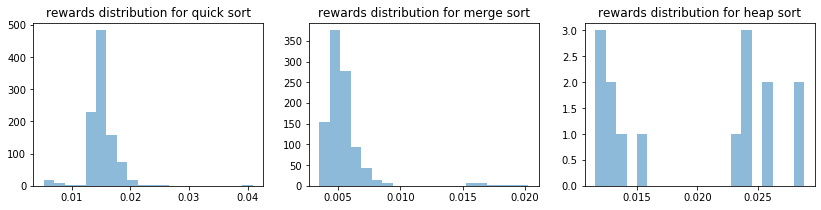

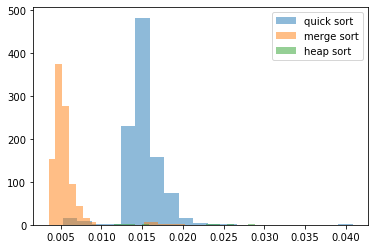

In [87]:
plot_rewards_distribution(arm_rewards_5)
plot_rewards_distribution_together(arm_rewards_5)

Restart at iteration: 504
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.01523872611335126, 'merge_sort': 0.01698371666672453, 'heap_sort': 0.025612620000038076}
Count per chosen algo {'quick_sort': 494, 'merge_sort': 6, 'heap_sort': 5}


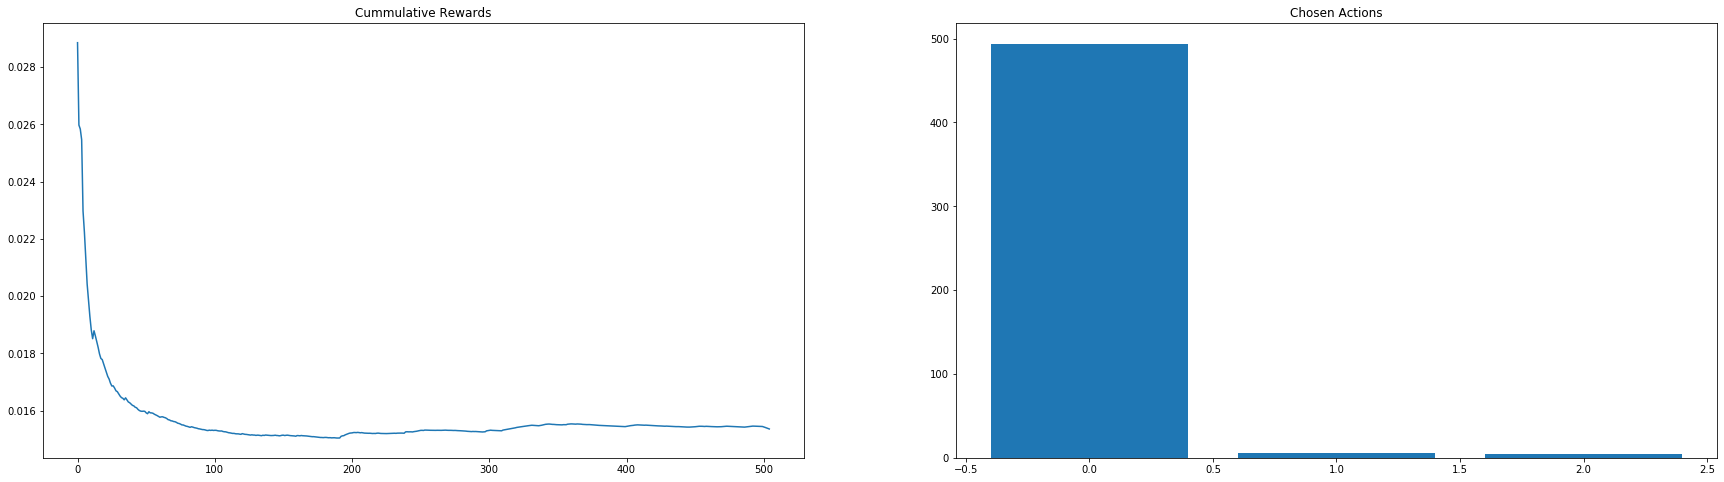

Restart at iteration: 1004
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.006893055555565297, 'merge_sort': 0.005363776024583398, 'heap_sort': 0.012370266666645572}
Count per chosen algo {'quick_sort': 9, 'merge_sort': 488, 'heap_sort': 3}


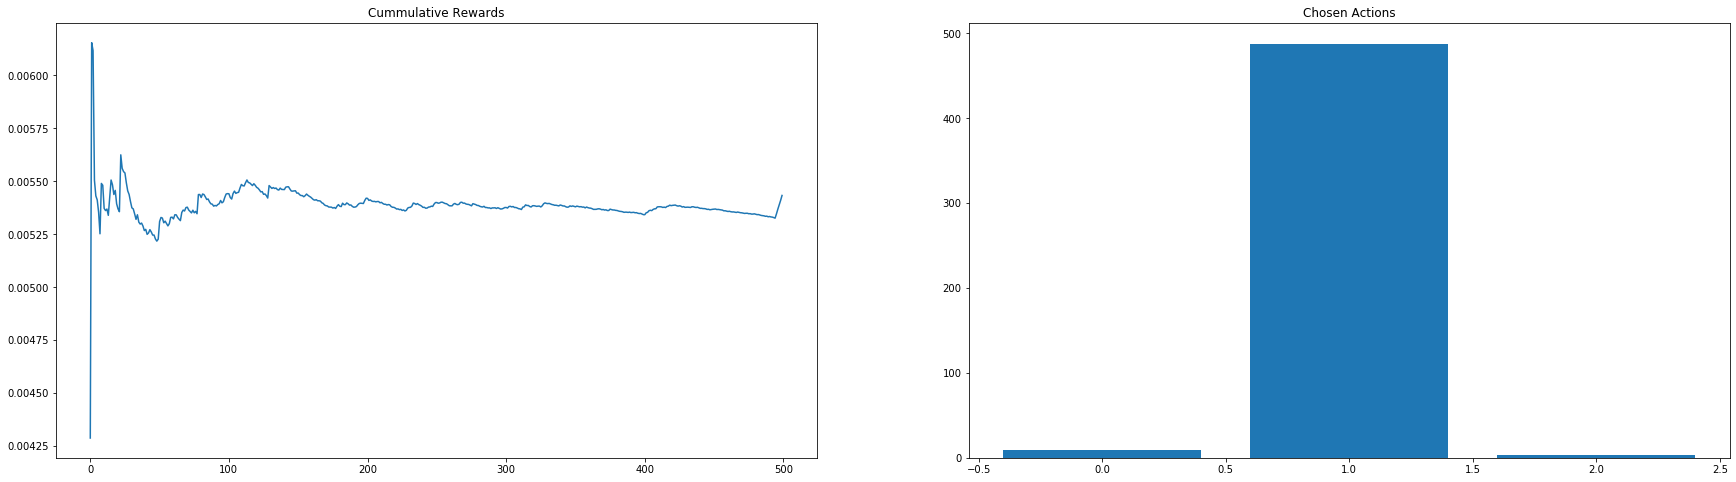

Restart at iteration: 1504
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.015370013347026848, 'merge_sort': 0.01685798999999406, 'heap_sort': 0.025640699999939898}
Count per chosen algo {'quick_sort': 487, 'merge_sort': 10, 'heap_sort': 3}


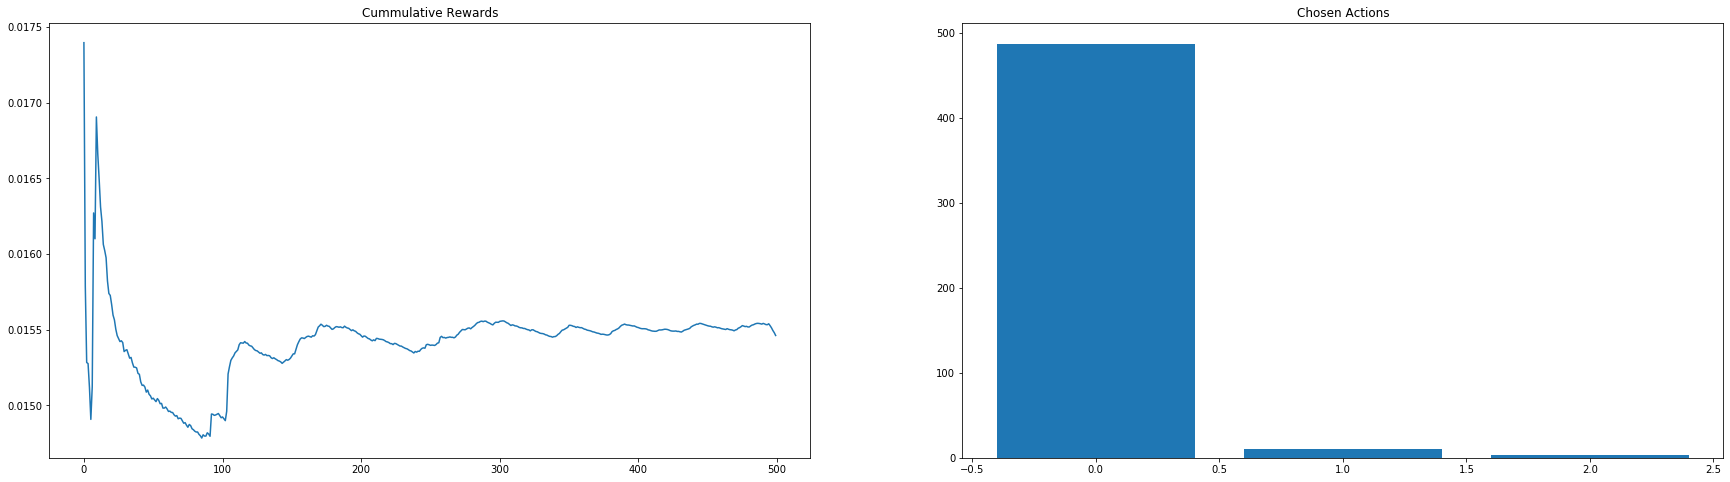

Restart at iteration: 1999
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.00772191000003204, 'merge_sort': 0.005190943451140306, 'heap_sort': 0.013388399999939793}
Count per chosen algo {'quick_sort': 10, 'merge_sort': 481, 'heap_sort': 4}


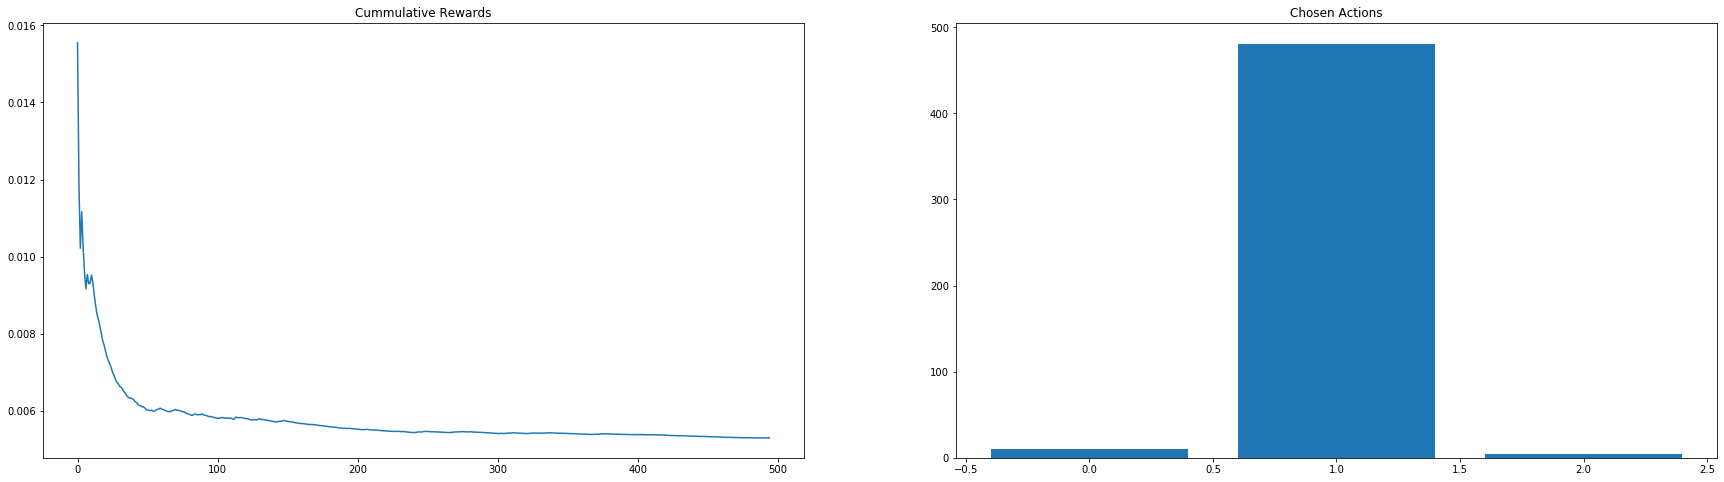

Total reward 20.8329


In [88]:
for elem in list_iteration_results_5:
    sample_mean, sample_count,rewards,cum_rewards,n = elem
    print("Restart at iteration:", n)
    print("Results up to this iteration: ")
    plot_history(rewards,cum_rewards, sample_count, sample_mean)
print("Total reward", np.round(total_reward_5,4))